In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as f
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neural_network import MLPRegressor
from scipy.stats import norm
import copy
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool, metrics, cv
import xgboost as xgb
from scipy.stats import gmean
from sklearn.impute import KNNImputer

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('./n_train.csv')
test_df = pd.read_csv('./n_test.csv')

In [31]:
exclude_cols = ['index', 'startdate']
temporal_attrs = ['year', 'quarter', 'month', 'week', 'dayofyear', 'season', 'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'season_sin', 'season_cos', 'quarter_sin', 'quarter_cos']
sub_temporal_attrs = ['month', 'season']
loc_attrs = ['lat', 'lon', 'loc_group']
embedding_attrs = ['climateregions__climateregion']
target=["contest-tmp2m-14d__tmp2m"]

main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in temporal_attrs and c not in loc_attrs and c not in target and c not in embedding_attrs]
print("Main features:", len(main_attrs))

Main features: 240


In [10]:
independent_corr = train_df[temporal_attrs + loc_attrs + embedding_attrs + main_attrs].corr()
seleted_corr_columns = np.full((independent_corr.shape[0],), True, dtype=bool)
for i in range(independent_corr.shape[0]):
    for j in range(i + 1, independent_corr.shape[0]):
        if independent_corr.iloc[i, j] >= 0.95:
            if seleted_corr_columns[j]:
                seleted_corr_columns[j] = False

In [13]:
selected_columns = train_df[temporal_attrs + loc_attrs + embedding_attrs + main_attrs].columns[seleted_corr_columns]
print(selected_columns.shape)

(199,)


In [14]:
out_cols = ['icec-2010-1',
 'icec-2010-2',
 'icec-2010-3',
 'icec-2010-4',
 'icec-2010-5',
 'icec-2010-6',
 'icec-2010-7',
 'icec-2010-8',
 'icec-2010-9',
 'icec-2010-10',
 'year',
 'quarter',
 'month_cos',
 'quarter_sin',
 'quarter_cos']
features = [c for c in selected_columns if c not in out_cols]

In [15]:
len(features)

185

In [25]:
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from scipy.stats import gmean
X_train, X_validation, y_train, y_validation = train_test_split(train_df[features], train_df[target[0]], test_size=0.33, random_state=42)
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_feautures = [X_train.columns.tolist()[i] for i in categorical_features_indices]
X_test = test_df[features]

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

clf = CatBoostRegressor(verbose=200)

params = clf.get_params()
params.update({
    'od_type': 'Iter',
    'od_wait': 40,
    'iterations': 4900,
    'use_best_model': True
})
clf = CatBoostRegressor(**params)
clf.fit(train_pool, eval_set=validate_pool, 
        verbose=True)

s = clf.predict(X_test)
df = pd.read_csv('best_sub.csv')
t = df['contest-tmp2m-14d__tmp2m']
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_corr_important.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

Learning rate set to 0.046007
0:	learn: 9.4797172	test: 9.4729893	best: 9.4729893 (0)	total: 53ms	remaining: 4m 19s
1:	learn: 9.1105735	test: 9.1048401	best: 9.1048401 (1)	total: 103ms	remaining: 4m 11s
2:	learn: 8.7605697	test: 8.7552203	best: 8.7552203 (2)	total: 152ms	remaining: 4m 8s
3:	learn: 8.4275504	test: 8.4223373	best: 8.4223373 (3)	total: 205ms	remaining: 4m 11s
4:	learn: 8.1091897	test: 8.1043448	best: 8.1043448 (4)	total: 254ms	remaining: 4m 8s
5:	learn: 7.8021640	test: 7.7976250	best: 7.7976250 (5)	total: 303ms	remaining: 4m 7s
6:	learn: 7.5152052	test: 7.5107272	best: 7.5107272 (6)	total: 352ms	remaining: 4m 5s
7:	learn: 7.2412166	test: 7.2367588	best: 7.2367588 (7)	total: 400ms	remaining: 4m 4s
8:	learn: 6.9776613	test: 6.9731169	best: 6.9731169 (8)	total: 449ms	remaining: 4m 4s
9:	learn: 6.7343330	test: 6.7300748	best: 6.7300748 (9)	total: 501ms	remaining: 4m 5s
10:	learn: 6.4969838	test: 6.4932312	best: 6.4932312 (10)	total: 547ms	remaining: 4m 3s
11:	learn: 6.2705812

96:	learn: 1.8311058	test: 1.8317447	best: 1.8317447 (96)	total: 4.46s	remaining: 3m 40s
97:	learn: 1.8238340	test: 1.8243446	best: 1.8243446 (97)	total: 4.5s	remaining: 3m 40s
98:	learn: 1.8181568	test: 1.8186361	best: 1.8186361 (98)	total: 4.54s	remaining: 3m 40s
99:	learn: 1.8122625	test: 1.8128813	best: 1.8128813 (99)	total: 4.59s	remaining: 3m 40s
100:	learn: 1.8066598	test: 1.8072090	best: 1.8072090 (100)	total: 4.63s	remaining: 3m 39s
101:	learn: 1.8005108	test: 1.8008785	best: 1.8008785 (101)	total: 4.67s	remaining: 3m 39s
102:	learn: 1.7949493	test: 1.7952481	best: 1.7952481 (102)	total: 4.71s	remaining: 3m 39s
103:	learn: 1.7875383	test: 1.7878518	best: 1.7878518 (103)	total: 4.75s	remaining: 3m 39s
104:	learn: 1.7825700	test: 1.7829587	best: 1.7829587 (104)	total: 4.8s	remaining: 3m 39s
105:	learn: 1.7783280	test: 1.7786407	best: 1.7786407 (105)	total: 4.84s	remaining: 3m 39s
106:	learn: 1.7741922	test: 1.7743720	best: 1.7743720 (106)	total: 4.89s	remaining: 3m 39s
107:	lear

191:	learn: 1.4905119	test: 1.4909530	best: 1.4909530 (191)	total: 8.7s	remaining: 3m 33s
192:	learn: 1.4885613	test: 1.4890432	best: 1.4890432 (192)	total: 8.75s	remaining: 3m 33s
193:	learn: 1.4868292	test: 1.4873069	best: 1.4873069 (193)	total: 8.79s	remaining: 3m 33s
194:	learn: 1.4852548	test: 1.4857649	best: 1.4857649 (194)	total: 8.83s	remaining: 3m 33s
195:	learn: 1.4833899	test: 1.4839059	best: 1.4839059 (195)	total: 8.88s	remaining: 3m 33s
196:	learn: 1.4813562	test: 1.4818083	best: 1.4818083 (196)	total: 8.91s	remaining: 3m 32s
197:	learn: 1.4790520	test: 1.4795675	best: 1.4795675 (197)	total: 8.96s	remaining: 3m 32s
198:	learn: 1.4776160	test: 1.4781324	best: 1.4781324 (198)	total: 9s	remaining: 3m 32s
199:	learn: 1.4758806	test: 1.4765274	best: 1.4765274 (199)	total: 9.05s	remaining: 3m 32s
200:	learn: 1.4743284	test: 1.4750600	best: 1.4750600 (200)	total: 9.1s	remaining: 3m 32s
201:	learn: 1.4718837	test: 1.4727411	best: 1.4727411 (201)	total: 9.14s	remaining: 3m 32s
202:

286:	learn: 1.3181358	test: 1.3199300	best: 1.3199300 (286)	total: 13s	remaining: 3m 28s
287:	learn: 1.3165405	test: 1.3182553	best: 1.3182553 (287)	total: 13s	remaining: 3m 28s
288:	learn: 1.3145693	test: 1.3163307	best: 1.3163307 (288)	total: 13.1s	remaining: 3m 28s
289:	learn: 1.3132952	test: 1.3150989	best: 1.3150989 (289)	total: 13.1s	remaining: 3m 28s
290:	learn: 1.3117238	test: 1.3135582	best: 1.3135582 (290)	total: 13.2s	remaining: 3m 28s
291:	learn: 1.3102129	test: 1.3120504	best: 1.3120504 (291)	total: 13.2s	remaining: 3m 28s
292:	learn: 1.3093908	test: 1.3111864	best: 1.3111864 (292)	total: 13.3s	remaining: 3m 28s
293:	learn: 1.3081311	test: 1.3099499	best: 1.3099499 (293)	total: 13.3s	remaining: 3m 28s
294:	learn: 1.3071080	test: 1.3089324	best: 1.3089324 (294)	total: 13.4s	remaining: 3m 28s
295:	learn: 1.3057114	test: 1.3075937	best: 1.3075937 (295)	total: 13.4s	remaining: 3m 28s
296:	learn: 1.3041751	test: 1.3061612	best: 1.3061612 (296)	total: 13.5s	remaining: 3m 28s
297

381:	learn: 1.1886366	test: 1.1915711	best: 1.1915711 (381)	total: 17.4s	remaining: 3m 25s
382:	learn: 1.1876940	test: 1.1906492	best: 1.1906492 (382)	total: 17.4s	remaining: 3m 25s
383:	learn: 1.1866517	test: 1.1895783	best: 1.1895783 (383)	total: 17.5s	remaining: 3m 25s
384:	learn: 1.1858229	test: 1.1887358	best: 1.1887358 (384)	total: 17.5s	remaining: 3m 25s
385:	learn: 1.1850593	test: 1.1880023	best: 1.1880023 (385)	total: 17.6s	remaining: 3m 25s
386:	learn: 1.1840120	test: 1.1869794	best: 1.1869794 (386)	total: 17.6s	remaining: 3m 25s
387:	learn: 1.1813939	test: 1.1843489	best: 1.1843489 (387)	total: 17.7s	remaining: 3m 25s
388:	learn: 1.1803659	test: 1.1833789	best: 1.1833789 (388)	total: 17.7s	remaining: 3m 25s
389:	learn: 1.1796718	test: 1.1826927	best: 1.1826927 (389)	total: 17.8s	remaining: 3m 25s
390:	learn: 1.1787014	test: 1.1816965	best: 1.1816965 (390)	total: 17.8s	remaining: 3m 25s
391:	learn: 1.1780061	test: 1.1810063	best: 1.1810063 (391)	total: 17.8s	remaining: 3m 25s

476:	learn: 1.0882232	test: 1.0916735	best: 1.0916735 (476)	total: 21.6s	remaining: 3m 20s
477:	learn: 1.0876651	test: 1.0911201	best: 1.0911201 (477)	total: 21.7s	remaining: 3m 20s
478:	learn: 1.0869078	test: 1.0903765	best: 1.0903765 (478)	total: 21.7s	remaining: 3m 20s
479:	learn: 1.0862048	test: 1.0897106	best: 1.0897106 (479)	total: 21.8s	remaining: 3m 20s
480:	learn: 1.0856115	test: 1.0891417	best: 1.0891417 (480)	total: 21.8s	remaining: 3m 20s
481:	learn: 1.0845406	test: 1.0880729	best: 1.0880729 (481)	total: 21.9s	remaining: 3m 20s
482:	learn: 1.0839078	test: 1.0874386	best: 1.0874386 (482)	total: 21.9s	remaining: 3m 20s
483:	learn: 1.0831472	test: 1.0866773	best: 1.0866773 (483)	total: 21.9s	remaining: 3m 20s
484:	learn: 1.0823147	test: 1.0859015	best: 1.0859015 (484)	total: 22s	remaining: 3m 20s
485:	learn: 1.0817815	test: 1.0853788	best: 1.0853788 (485)	total: 22s	remaining: 3m 20s
486:	learn: 1.0801576	test: 1.0837620	best: 1.0837620 (486)	total: 22.1s	remaining: 3m 20s
487

571:	learn: 1.0103269	test: 1.0145790	best: 1.0145790 (571)	total: 25.9s	remaining: 3m 16s
572:	learn: 1.0097851	test: 1.0140779	best: 1.0140779 (572)	total: 26s	remaining: 3m 16s
573:	learn: 1.0089745	test: 1.0132508	best: 1.0132508 (573)	total: 26s	remaining: 3m 16s
574:	learn: 1.0084145	test: 1.0127342	best: 1.0127342 (574)	total: 26.1s	remaining: 3m 16s
575:	learn: 1.0074256	test: 1.0117134	best: 1.0117134 (575)	total: 26.1s	remaining: 3m 16s
576:	learn: 1.0065596	test: 1.0109080	best: 1.0109080 (576)	total: 26.2s	remaining: 3m 16s
577:	learn: 1.0060866	test: 1.0104660	best: 1.0104660 (577)	total: 26.2s	remaining: 3m 16s
578:	learn: 1.0055966	test: 1.0099819	best: 1.0099819 (578)	total: 26.3s	remaining: 3m 16s
579:	learn: 1.0051244	test: 1.0095136	best: 1.0095136 (579)	total: 26.3s	remaining: 3m 16s
580:	learn: 1.0044233	test: 1.0088277	best: 1.0088277 (580)	total: 26.4s	remaining: 3m 15s
581:	learn: 1.0037799	test: 1.0081997	best: 1.0081997 (581)	total: 26.4s	remaining: 3m 15s
582

666:	learn: 0.9433395	test: 0.9484849	best: 0.9484849 (666)	total: 30.2s	remaining: 3m 11s
667:	learn: 0.9427179	test: 0.9478535	best: 0.9478535 (667)	total: 30.3s	remaining: 3m 11s
668:	learn: 0.9419939	test: 0.9471668	best: 0.9471668 (668)	total: 30.3s	remaining: 3m 11s
669:	learn: 0.9415107	test: 0.9467012	best: 0.9467012 (669)	total: 30.4s	remaining: 3m 11s
670:	learn: 0.9404532	test: 0.9456517	best: 0.9456517 (670)	total: 30.4s	remaining: 3m 11s
671:	learn: 0.9399600	test: 0.9451993	best: 0.9451993 (671)	total: 30.5s	remaining: 3m 11s
672:	learn: 0.9392062	test: 0.9444816	best: 0.9444816 (672)	total: 30.5s	remaining: 3m 11s
673:	learn: 0.9385222	test: 0.9438237	best: 0.9438237 (673)	total: 30.6s	remaining: 3m 11s
674:	learn: 0.9380773	test: 0.9433773	best: 0.9433773 (674)	total: 30.6s	remaining: 3m 11s
675:	learn: 0.9371980	test: 0.9424739	best: 0.9424739 (675)	total: 30.7s	remaining: 3m 11s
676:	learn: 0.9363016	test: 0.9415513	best: 0.9415513 (676)	total: 30.7s	remaining: 3m 11s

761:	learn: 0.8920993	test: 0.8979919	best: 0.8979919 (761)	total: 34.6s	remaining: 3m 7s
762:	learn: 0.8915667	test: 0.8974616	best: 0.8974616 (762)	total: 34.6s	remaining: 3m 7s
763:	learn: 0.8910800	test: 0.8970127	best: 0.8970127 (763)	total: 34.7s	remaining: 3m 7s
764:	learn: 0.8901866	test: 0.8960945	best: 0.8960945 (764)	total: 34.7s	remaining: 3m 7s
765:	learn: 0.8898581	test: 0.8957932	best: 0.8957932 (765)	total: 34.7s	remaining: 3m 7s
766:	learn: 0.8895346	test: 0.8954926	best: 0.8954926 (766)	total: 34.8s	remaining: 3m 7s
767:	learn: 0.8889051	test: 0.8948764	best: 0.8948764 (767)	total: 34.8s	remaining: 3m 7s
768:	learn: 0.8883597	test: 0.8943223	best: 0.8943223 (768)	total: 34.9s	remaining: 3m 7s
769:	learn: 0.8879163	test: 0.8938600	best: 0.8938600 (769)	total: 34.9s	remaining: 3m 7s
770:	learn: 0.8872981	test: 0.8932242	best: 0.8932242 (770)	total: 35s	remaining: 3m 7s
771:	learn: 0.8868608	test: 0.8927968	best: 0.8927968 (771)	total: 35s	remaining: 3m 7s
772:	learn: 0.

856:	learn: 0.8479045	test: 0.8548196	best: 0.8548196 (856)	total: 38.8s	remaining: 3m 3s
857:	learn: 0.8473757	test: 0.8542980	best: 0.8542980 (857)	total: 38.9s	remaining: 3m 3s
858:	learn: 0.8470506	test: 0.8539729	best: 0.8539729 (858)	total: 38.9s	remaining: 3m 3s
859:	learn: 0.8468498	test: 0.8537762	best: 0.8537762 (859)	total: 39s	remaining: 3m 3s
860:	learn: 0.8462857	test: 0.8532522	best: 0.8532522 (860)	total: 39s	remaining: 3m 2s
861:	learn: 0.8457605	test: 0.8527250	best: 0.8527250 (861)	total: 39s	remaining: 3m 2s
862:	learn: 0.8452939	test: 0.8522474	best: 0.8522474 (862)	total: 39.1s	remaining: 3m 2s
863:	learn: 0.8448513	test: 0.8517954	best: 0.8517954 (863)	total: 39.1s	remaining: 3m 2s
864:	learn: 0.8445562	test: 0.8515153	best: 0.8515153 (864)	total: 39.2s	remaining: 3m 2s
865:	learn: 0.8441667	test: 0.8511341	best: 0.8511341 (865)	total: 39.2s	remaining: 3m 2s
866:	learn: 0.8435900	test: 0.8505402	best: 0.8505402 (866)	total: 39.3s	remaining: 3m 2s
867:	learn: 0.84

951:	learn: 0.8113313	test: 0.8190771	best: 0.8190771 (951)	total: 43.1s	remaining: 2m 58s
952:	learn: 0.8107464	test: 0.8185081	best: 0.8185081 (952)	total: 43.1s	remaining: 2m 58s
953:	learn: 0.8103525	test: 0.8181229	best: 0.8181229 (953)	total: 43.2s	remaining: 2m 58s
954:	learn: 0.8099679	test: 0.8177596	best: 0.8177596 (954)	total: 43.2s	remaining: 2m 58s
955:	learn: 0.8096208	test: 0.8174284	best: 0.8174284 (955)	total: 43.3s	remaining: 2m 58s
956:	learn: 0.8093209	test: 0.8171357	best: 0.8171357 (956)	total: 43.3s	remaining: 2m 58s
957:	learn: 0.8090127	test: 0.8168416	best: 0.8168416 (957)	total: 43.4s	remaining: 2m 58s
958:	learn: 0.8083387	test: 0.8161699	best: 0.8161699 (958)	total: 43.4s	remaining: 2m 58s
959:	learn: 0.8080435	test: 0.8158589	best: 0.8158589 (959)	total: 43.5s	remaining: 2m 58s
960:	learn: 0.8078240	test: 0.8156317	best: 0.8156317 (960)	total: 43.5s	remaining: 2m 58s
961:	learn: 0.8074290	test: 0.8152236	best: 0.8152236 (961)	total: 43.6s	remaining: 2m 58s

1041:	learn: 0.7794319	test: 0.7877780	best: 0.7877780 (1041)	total: 47.1s	remaining: 2m 54s
1042:	learn: 0.7791347	test: 0.7874954	best: 0.7874954 (1042)	total: 47.2s	remaining: 2m 54s
1043:	learn: 0.7788805	test: 0.7872830	best: 0.7872830 (1043)	total: 47.2s	remaining: 2m 54s
1044:	learn: 0.7786826	test: 0.7870858	best: 0.7870858 (1044)	total: 47.3s	remaining: 2m 54s
1045:	learn: 0.7784139	test: 0.7868095	best: 0.7868095 (1045)	total: 47.3s	remaining: 2m 54s
1046:	learn: 0.7781654	test: 0.7865830	best: 0.7865830 (1046)	total: 47.4s	remaining: 2m 54s
1047:	learn: 0.7778436	test: 0.7863048	best: 0.7863048 (1047)	total: 47.4s	remaining: 2m 54s
1048:	learn: 0.7771365	test: 0.7856139	best: 0.7856139 (1048)	total: 47.5s	remaining: 2m 54s
1049:	learn: 0.7768202	test: 0.7853063	best: 0.7853063 (1049)	total: 47.5s	remaining: 2m 54s
1050:	learn: 0.7765176	test: 0.7850108	best: 0.7850108 (1050)	total: 47.6s	remaining: 2m 54s
1051:	learn: 0.7762517	test: 0.7847685	best: 0.7847685 (1051)	total: 4

1131:	learn: 0.7524104	test: 0.7616240	best: 0.7616240 (1131)	total: 51.2s	remaining: 2m 50s
1132:	learn: 0.7520715	test: 0.7612919	best: 0.7612919 (1132)	total: 51.2s	remaining: 2m 50s
1133:	learn: 0.7514271	test: 0.7606754	best: 0.7606754 (1133)	total: 51.3s	remaining: 2m 50s
1134:	learn: 0.7511792	test: 0.7604436	best: 0.7604436 (1134)	total: 51.3s	remaining: 2m 50s
1135:	learn: 0.7508412	test: 0.7601226	best: 0.7601226 (1135)	total: 51.4s	remaining: 2m 50s
1136:	learn: 0.7505613	test: 0.7598483	best: 0.7598483 (1136)	total: 51.4s	remaining: 2m 50s
1137:	learn: 0.7503990	test: 0.7597131	best: 0.7597131 (1137)	total: 51.5s	remaining: 2m 50s
1138:	learn: 0.7501736	test: 0.7594905	best: 0.7594905 (1138)	total: 51.5s	remaining: 2m 50s
1139:	learn: 0.7499369	test: 0.7592627	best: 0.7592627 (1139)	total: 51.5s	remaining: 2m 50s
1140:	learn: 0.7496639	test: 0.7589886	best: 0.7589886 (1140)	total: 51.6s	remaining: 2m 49s
1141:	learn: 0.7494462	test: 0.7587842	best: 0.7587842 (1141)	total: 5

1221:	learn: 0.7274125	test: 0.7373031	best: 0.7373031 (1221)	total: 55.2s	remaining: 2m 46s
1222:	learn: 0.7272089	test: 0.7371251	best: 0.7371251 (1222)	total: 55.3s	remaining: 2m 46s
1223:	learn: 0.7270584	test: 0.7369832	best: 0.7369832 (1223)	total: 55.3s	remaining: 2m 46s
1224:	learn: 0.7268248	test: 0.7367688	best: 0.7367688 (1224)	total: 55.4s	remaining: 2m 46s
1225:	learn: 0.7266395	test: 0.7365853	best: 0.7365853 (1225)	total: 55.4s	remaining: 2m 46s
1226:	learn: 0.7264320	test: 0.7363917	best: 0.7363917 (1226)	total: 55.5s	remaining: 2m 46s
1227:	learn: 0.7262460	test: 0.7362190	best: 0.7362190 (1227)	total: 55.5s	remaining: 2m 45s
1228:	learn: 0.7259644	test: 0.7359503	best: 0.7359503 (1228)	total: 55.6s	remaining: 2m 45s
1229:	learn: 0.7257921	test: 0.7357795	best: 0.7357795 (1229)	total: 55.6s	remaining: 2m 45s
1230:	learn: 0.7255499	test: 0.7355468	best: 0.7355468 (1230)	total: 55.6s	remaining: 2m 45s
1231:	learn: 0.7252764	test: 0.7353008	best: 0.7353008 (1231)	total: 5

1311:	learn: 0.7039080	test: 0.7144631	best: 0.7144631 (1311)	total: 59.3s	remaining: 2m 42s
1312:	learn: 0.7037692	test: 0.7143265	best: 0.7143265 (1312)	total: 59.3s	remaining: 2m 42s
1313:	learn: 0.7035168	test: 0.7140885	best: 0.7140885 (1313)	total: 59.4s	remaining: 2m 42s
1314:	learn: 0.7033559	test: 0.7139384	best: 0.7139384 (1314)	total: 59.4s	remaining: 2m 41s
1315:	learn: 0.7030124	test: 0.7136274	best: 0.7136274 (1315)	total: 59.5s	remaining: 2m 41s
1316:	learn: 0.7027991	test: 0.7134075	best: 0.7134075 (1316)	total: 59.5s	remaining: 2m 41s
1317:	learn: 0.7024438	test: 0.7130435	best: 0.7130435 (1317)	total: 59.5s	remaining: 2m 41s
1318:	learn: 0.7021998	test: 0.7128101	best: 0.7128101 (1318)	total: 59.6s	remaining: 2m 41s
1319:	learn: 0.7018363	test: 0.7124503	best: 0.7124503 (1319)	total: 59.6s	remaining: 2m 41s
1320:	learn: 0.7015656	test: 0.7121903	best: 0.7121903 (1320)	total: 59.7s	remaining: 2m 41s
1321:	learn: 0.7013193	test: 0.7119529	best: 0.7119529 (1321)	total: 5

1401:	learn: 0.6828784	test: 0.6939629	best: 0.6939629 (1401)	total: 1m 3s	remaining: 2m 38s
1402:	learn: 0.6826795	test: 0.6937976	best: 0.6937976 (1402)	total: 1m 3s	remaining: 2m 38s
1403:	learn: 0.6823249	test: 0.6934440	best: 0.6934440 (1403)	total: 1m 3s	remaining: 2m 37s
1404:	learn: 0.6818276	test: 0.6929763	best: 0.6929763 (1404)	total: 1m 3s	remaining: 2m 37s
1405:	learn: 0.6816234	test: 0.6927805	best: 0.6927805 (1405)	total: 1m 3s	remaining: 2m 37s
1406:	learn: 0.6815020	test: 0.6926605	best: 0.6926605 (1406)	total: 1m 3s	remaining: 2m 37s
1407:	learn: 0.6811865	test: 0.6923537	best: 0.6923537 (1407)	total: 1m 3s	remaining: 2m 37s
1408:	learn: 0.6810551	test: 0.6922324	best: 0.6922324 (1408)	total: 1m 3s	remaining: 2m 37s
1409:	learn: 0.6807935	test: 0.6919313	best: 0.6919313 (1409)	total: 1m 3s	remaining: 2m 37s
1410:	learn: 0.6805980	test: 0.6917381	best: 0.6917381 (1410)	total: 1m 3s	remaining: 2m 37s
1411:	learn: 0.6804696	test: 0.6916175	best: 0.6916175 (1411)	total: 1

1491:	learn: 0.6640851	test: 0.6758107	best: 0.6758107 (1491)	total: 1m 7s	remaining: 2m 33s
1492:	learn: 0.6638334	test: 0.6755597	best: 0.6755597 (1492)	total: 1m 7s	remaining: 2m 33s
1493:	learn: 0.6636294	test: 0.6753496	best: 0.6753496 (1493)	total: 1m 7s	remaining: 2m 33s
1494:	learn: 0.6634544	test: 0.6751683	best: 0.6751683 (1494)	total: 1m 7s	remaining: 2m 33s
1495:	learn: 0.6632899	test: 0.6750148	best: 0.6750148 (1495)	total: 1m 7s	remaining: 2m 33s
1496:	learn: 0.6630941	test: 0.6748296	best: 0.6748296 (1496)	total: 1m 7s	remaining: 2m 33s
1497:	learn: 0.6629549	test: 0.6747071	best: 0.6747071 (1497)	total: 1m 7s	remaining: 2m 33s
1498:	learn: 0.6628057	test: 0.6745615	best: 0.6745615 (1498)	total: 1m 7s	remaining: 2m 33s
1499:	learn: 0.6626360	test: 0.6744172	best: 0.6744172 (1499)	total: 1m 7s	remaining: 2m 33s
1500:	learn: 0.6624769	test: 0.6742667	best: 0.6742667 (1500)	total: 1m 7s	remaining: 2m 33s
1501:	learn: 0.6622953	test: 0.6741009	best: 0.6741009 (1501)	total: 1

1581:	learn: 0.6470251	test: 0.6593804	best: 0.6593804 (1581)	total: 1m 11s	remaining: 2m 29s
1582:	learn: 0.6467957	test: 0.6591699	best: 0.6591699 (1582)	total: 1m 11s	remaining: 2m 29s
1583:	learn: 0.6466674	test: 0.6590403	best: 0.6590403 (1583)	total: 1m 11s	remaining: 2m 29s
1584:	learn: 0.6465324	test: 0.6589083	best: 0.6589083 (1584)	total: 1m 11s	remaining: 2m 29s
1585:	learn: 0.6463843	test: 0.6587709	best: 0.6587709 (1585)	total: 1m 11s	remaining: 2m 29s
1586:	learn: 0.6462046	test: 0.6585611	best: 0.6585611 (1586)	total: 1m 11s	remaining: 2m 29s
1587:	learn: 0.6460125	test: 0.6583862	best: 0.6583862 (1587)	total: 1m 11s	remaining: 2m 29s
1588:	learn: 0.6457019	test: 0.6580770	best: 0.6580770 (1588)	total: 1m 11s	remaining: 2m 29s
1589:	learn: 0.6455816	test: 0.6579675	best: 0.6579675 (1589)	total: 1m 11s	remaining: 2m 29s
1590:	learn: 0.6454881	test: 0.6578669	best: 0.6578669 (1590)	total: 1m 11s	remaining: 2m 29s
1591:	learn: 0.6453164	test: 0.6576970	best: 0.6576970 (1591

1671:	learn: 0.6311629	test: 0.6439862	best: 0.6439862 (1671)	total: 1m 15s	remaining: 2m 25s
1672:	learn: 0.6310130	test: 0.6438535	best: 0.6438535 (1672)	total: 1m 15s	remaining: 2m 25s
1673:	learn: 0.6308301	test: 0.6436699	best: 0.6436699 (1673)	total: 1m 15s	remaining: 2m 25s
1674:	learn: 0.6306694	test: 0.6435172	best: 0.6435172 (1674)	total: 1m 15s	remaining: 2m 25s
1675:	learn: 0.6304310	test: 0.6432870	best: 0.6432870 (1675)	total: 1m 15s	remaining: 2m 25s
1676:	learn: 0.6302693	test: 0.6431353	best: 0.6431353 (1676)	total: 1m 15s	remaining: 2m 25s
1677:	learn: 0.6301308	test: 0.6430110	best: 0.6430110 (1677)	total: 1m 15s	remaining: 2m 25s
1678:	learn: 0.6299862	test: 0.6428713	best: 0.6428713 (1678)	total: 1m 15s	remaining: 2m 25s
1679:	learn: 0.6297848	test: 0.6426793	best: 0.6426793 (1679)	total: 1m 15s	remaining: 2m 25s
1680:	learn: 0.6296205	test: 0.6425201	best: 0.6425201 (1680)	total: 1m 15s	remaining: 2m 25s
1681:	learn: 0.6294705	test: 0.6423826	best: 0.6423826 (1681

1761:	learn: 0.6154487	test: 0.6288227	best: 0.6288227 (1761)	total: 1m 19s	remaining: 2m 21s
1762:	learn: 0.6153552	test: 0.6287305	best: 0.6287305 (1762)	total: 1m 19s	remaining: 2m 21s
1763:	learn: 0.6152237	test: 0.6286196	best: 0.6286196 (1763)	total: 1m 19s	remaining: 2m 21s
1764:	learn: 0.6150784	test: 0.6284762	best: 0.6284762 (1764)	total: 1m 19s	remaining: 2m 21s
1765:	learn: 0.6149996	test: 0.6284002	best: 0.6284002 (1765)	total: 1m 19s	remaining: 2m 21s
1766:	learn: 0.6148331	test: 0.6282528	best: 0.6282528 (1766)	total: 1m 19s	remaining: 2m 21s
1767:	learn: 0.6147327	test: 0.6281411	best: 0.6281411 (1767)	total: 1m 19s	remaining: 2m 21s
1768:	learn: 0.6146152	test: 0.6280434	best: 0.6280434 (1768)	total: 1m 19s	remaining: 2m 21s
1769:	learn: 0.6144111	test: 0.6278525	best: 0.6278525 (1769)	total: 1m 19s	remaining: 2m 21s
1770:	learn: 0.6142141	test: 0.6276545	best: 0.6276545 (1770)	total: 1m 19s	remaining: 2m 21s
1771:	learn: 0.6140856	test: 0.6275317	best: 0.6275317 (1771

1850:	learn: 0.6019690	test: 0.6158074	best: 0.6158074 (1850)	total: 1m 23s	remaining: 2m 17s
1851:	learn: 0.6017865	test: 0.6156391	best: 0.6156391 (1851)	total: 1m 23s	remaining: 2m 17s
1852:	learn: 0.6016822	test: 0.6155433	best: 0.6155433 (1852)	total: 1m 23s	remaining: 2m 17s
1853:	learn: 0.6015634	test: 0.6154189	best: 0.6154189 (1853)	total: 1m 23s	remaining: 2m 17s
1854:	learn: 0.6013740	test: 0.6152215	best: 0.6152215 (1854)	total: 1m 23s	remaining: 2m 17s
1855:	learn: 0.6011039	test: 0.6149612	best: 0.6149612 (1855)	total: 1m 23s	remaining: 2m 17s
1856:	learn: 0.6009576	test: 0.6148223	best: 0.6148223 (1856)	total: 1m 23s	remaining: 2m 17s
1857:	learn: 0.6008424	test: 0.6147133	best: 0.6147133 (1857)	total: 1m 23s	remaining: 2m 17s
1858:	learn: 0.6006931	test: 0.6145679	best: 0.6145679 (1858)	total: 1m 24s	remaining: 2m 17s
1859:	learn: 0.6005553	test: 0.6144360	best: 0.6144360 (1859)	total: 1m 24s	remaining: 2m 17s
1860:	learn: 0.6004189	test: 0.6142976	best: 0.6142976 (1860

1940:	learn: 0.5893989	test: 0.6037412	best: 0.6037412 (1940)	total: 1m 27s	remaining: 2m 13s
1941:	learn: 0.5891603	test: 0.6035211	best: 0.6035211 (1941)	total: 1m 27s	remaining: 2m 13s
1942:	learn: 0.5890693	test: 0.6034369	best: 0.6034369 (1942)	total: 1m 27s	remaining: 2m 13s
1943:	learn: 0.5888734	test: 0.6032525	best: 0.6032525 (1943)	total: 1m 27s	remaining: 2m 13s
1944:	learn: 0.5887906	test: 0.6031656	best: 0.6031656 (1944)	total: 1m 27s	remaining: 2m 13s
1945:	learn: 0.5886873	test: 0.6030612	best: 0.6030612 (1945)	total: 1m 27s	remaining: 2m 13s
1946:	learn: 0.5886056	test: 0.6029771	best: 0.6029771 (1946)	total: 1m 27s	remaining: 2m 13s
1947:	learn: 0.5884954	test: 0.6028761	best: 0.6028761 (1947)	total: 1m 28s	remaining: 2m 13s
1948:	learn: 0.5884100	test: 0.6028008	best: 0.6028008 (1948)	total: 1m 28s	remaining: 2m 13s
1949:	learn: 0.5882561	test: 0.6026575	best: 0.6026575 (1949)	total: 1m 28s	remaining: 2m 13s
1950:	learn: 0.5881698	test: 0.6025784	best: 0.6025784 (1950

2030:	learn: 0.5782398	test: 0.5930541	best: 0.5930541 (2030)	total: 1m 31s	remaining: 2m 9s
2031:	learn: 0.5781040	test: 0.5929166	best: 0.5929166 (2031)	total: 1m 31s	remaining: 2m 9s
2032:	learn: 0.5780173	test: 0.5928394	best: 0.5928394 (2032)	total: 1m 31s	remaining: 2m 9s
2033:	learn: 0.5779427	test: 0.5927717	best: 0.5927717 (2033)	total: 1m 31s	remaining: 2m 9s
2034:	learn: 0.5778522	test: 0.5926926	best: 0.5926926 (2034)	total: 1m 31s	remaining: 2m 9s
2035:	learn: 0.5777572	test: 0.5925982	best: 0.5925982 (2035)	total: 1m 31s	remaining: 2m 9s
2036:	learn: 0.5776922	test: 0.5925327	best: 0.5925327 (2036)	total: 1m 32s	remaining: 2m 9s
2037:	learn: 0.5774872	test: 0.5923452	best: 0.5923452 (2037)	total: 1m 32s	remaining: 2m 9s
2038:	learn: 0.5773946	test: 0.5922632	best: 0.5922632 (2038)	total: 1m 32s	remaining: 2m 9s
2039:	learn: 0.5772013	test: 0.5920835	best: 0.5920835 (2039)	total: 1m 32s	remaining: 2m 9s
2040:	learn: 0.5771182	test: 0.5920082	best: 0.5920082 (2040)	total: 1

2120:	learn: 0.5672815	test: 0.5826908	best: 0.5826908 (2120)	total: 1m 35s	remaining: 2m 5s
2121:	learn: 0.5670494	test: 0.5824737	best: 0.5824737 (2121)	total: 1m 35s	remaining: 2m 5s
2122:	learn: 0.5669095	test: 0.5823558	best: 0.5823558 (2122)	total: 1m 35s	remaining: 2m 5s
2123:	learn: 0.5668288	test: 0.5822828	best: 0.5822828 (2123)	total: 1m 35s	remaining: 2m 5s
2124:	learn: 0.5666886	test: 0.5821482	best: 0.5821482 (2124)	total: 1m 36s	remaining: 2m 5s
2125:	learn: 0.5665257	test: 0.5819927	best: 0.5819927 (2125)	total: 1m 36s	remaining: 2m 5s
2126:	learn: 0.5664218	test: 0.5818861	best: 0.5818861 (2126)	total: 1m 36s	remaining: 2m 5s
2127:	learn: 0.5663176	test: 0.5817829	best: 0.5817829 (2127)	total: 1m 36s	remaining: 2m 5s
2128:	learn: 0.5662115	test: 0.5816783	best: 0.5816783 (2128)	total: 1m 36s	remaining: 2m 5s
2129:	learn: 0.5661196	test: 0.5815982	best: 0.5815982 (2129)	total: 1m 36s	remaining: 2m 5s
2130:	learn: 0.5659812	test: 0.5814562	best: 0.5814562 (2130)	total: 1

2210:	learn: 0.5567441	test: 0.5726312	best: 0.5726312 (2210)	total: 1m 39s	remaining: 2m 1s
2211:	learn: 0.5565041	test: 0.5724095	best: 0.5724095 (2211)	total: 1m 39s	remaining: 2m 1s
2212:	learn: 0.5564146	test: 0.5723225	best: 0.5723225 (2212)	total: 1m 39s	remaining: 2m 1s
2213:	learn: 0.5563470	test: 0.5722646	best: 0.5722646 (2213)	total: 1m 39s	remaining: 2m 1s
2214:	learn: 0.5562493	test: 0.5721705	best: 0.5721705 (2214)	total: 1m 40s	remaining: 2m 1s
2215:	learn: 0.5561693	test: 0.5721007	best: 0.5721007 (2215)	total: 1m 40s	remaining: 2m 1s
2216:	learn: 0.5560785	test: 0.5720094	best: 0.5720094 (2216)	total: 1m 40s	remaining: 2m 1s
2217:	learn: 0.5557407	test: 0.5716873	best: 0.5716873 (2217)	total: 1m 40s	remaining: 2m 1s
2218:	learn: 0.5556404	test: 0.5716019	best: 0.5716019 (2218)	total: 1m 40s	remaining: 2m 1s
2219:	learn: 0.5555436	test: 0.5715045	best: 0.5715045 (2219)	total: 1m 40s	remaining: 2m
2220:	learn: 0.5554205	test: 0.5713956	best: 0.5713956 (2220)	total: 1m 4

2300:	learn: 0.5468968	test: 0.5633387	best: 0.5633387 (2300)	total: 1m 43s	remaining: 1m 57s
2301:	learn: 0.5468344	test: 0.5632842	best: 0.5632842 (2301)	total: 1m 43s	remaining: 1m 57s
2302:	learn: 0.5467433	test: 0.5632006	best: 0.5632006 (2302)	total: 1m 43s	remaining: 1m 57s
2303:	learn: 0.5466535	test: 0.5631296	best: 0.5631296 (2303)	total: 1m 43s	remaining: 1m 57s
2304:	learn: 0.5465652	test: 0.5630380	best: 0.5630380 (2304)	total: 1m 44s	remaining: 1m 57s
2305:	learn: 0.5464758	test: 0.5629501	best: 0.5629501 (2305)	total: 1m 44s	remaining: 1m 57s
2306:	learn: 0.5463519	test: 0.5628264	best: 0.5628264 (2306)	total: 1m 44s	remaining: 1m 57s
2307:	learn: 0.5462483	test: 0.5627445	best: 0.5627445 (2307)	total: 1m 44s	remaining: 1m 56s
2308:	learn: 0.5461409	test: 0.5626326	best: 0.5626326 (2308)	total: 1m 44s	remaining: 1m 56s
2309:	learn: 0.5459918	test: 0.5624770	best: 0.5624770 (2309)	total: 1m 44s	remaining: 1m 56s
2310:	learn: 0.5459079	test: 0.5623998	best: 0.5623998 (2310

2390:	learn: 0.5374107	test: 0.5543937	best: 0.5543937 (2390)	total: 1m 47s	remaining: 1m 53s
2391:	learn: 0.5373392	test: 0.5543219	best: 0.5543219 (2391)	total: 1m 47s	remaining: 1m 53s
2392:	learn: 0.5372770	test: 0.5542598	best: 0.5542598 (2392)	total: 1m 48s	remaining: 1m 53s
2393:	learn: 0.5371970	test: 0.5541907	best: 0.5541907 (2393)	total: 1m 48s	remaining: 1m 53s
2394:	learn: 0.5371153	test: 0.5541118	best: 0.5541118 (2394)	total: 1m 48s	remaining: 1m 53s
2395:	learn: 0.5370410	test: 0.5540495	best: 0.5540495 (2395)	total: 1m 48s	remaining: 1m 53s
2396:	learn: 0.5369245	test: 0.5539340	best: 0.5539340 (2396)	total: 1m 48s	remaining: 1m 52s
2397:	learn: 0.5368410	test: 0.5538530	best: 0.5538530 (2397)	total: 1m 48s	remaining: 1m 52s
2398:	learn: 0.5367289	test: 0.5537447	best: 0.5537447 (2398)	total: 1m 48s	remaining: 1m 52s
2399:	learn: 0.5365720	test: 0.5535972	best: 0.5535972 (2399)	total: 1m 48s	remaining: 1m 52s
2400:	learn: 0.5365206	test: 0.5535508	best: 0.5535508 (2400

2480:	learn: 0.5290348	test: 0.5463534	best: 0.5463534 (2480)	total: 1m 51s	remaining: 1m 49s
2481:	learn: 0.5289411	test: 0.5462657	best: 0.5462657 (2481)	total: 1m 51s	remaining: 1m 49s
2482:	learn: 0.5288727	test: 0.5462071	best: 0.5462071 (2482)	total: 1m 52s	remaining: 1m 49s
2483:	learn: 0.5288325	test: 0.5461711	best: 0.5461711 (2483)	total: 1m 52s	remaining: 1m 48s
2484:	learn: 0.5287603	test: 0.5461035	best: 0.5461035 (2484)	total: 1m 52s	remaining: 1m 48s
2485:	learn: 0.5287001	test: 0.5460541	best: 0.5460541 (2485)	total: 1m 52s	remaining: 1m 48s
2486:	learn: 0.5286089	test: 0.5459734	best: 0.5459734 (2486)	total: 1m 52s	remaining: 1m 48s
2487:	learn: 0.5285331	test: 0.5459029	best: 0.5459029 (2487)	total: 1m 52s	remaining: 1m 48s
2488:	learn: 0.5284334	test: 0.5458113	best: 0.5458113 (2488)	total: 1m 52s	remaining: 1m 48s
2489:	learn: 0.5283490	test: 0.5457337	best: 0.5457337 (2489)	total: 1m 52s	remaining: 1m 48s
2490:	learn: 0.5282672	test: 0.5456589	best: 0.5456589 (2490

2570:	learn: 0.5212456	test: 0.5390484	best: 0.5390484 (2570)	total: 1m 55s	remaining: 1m 45s
2571:	learn: 0.5211247	test: 0.5389396	best: 0.5389396 (2571)	total: 1m 56s	remaining: 1m 45s
2572:	learn: 0.5210321	test: 0.5388487	best: 0.5388487 (2572)	total: 1m 56s	remaining: 1m 44s
2573:	learn: 0.5209546	test: 0.5387740	best: 0.5387740 (2573)	total: 1m 56s	remaining: 1m 44s
2574:	learn: 0.5207168	test: 0.5385230	best: 0.5385230 (2574)	total: 1m 56s	remaining: 1m 44s
2575:	learn: 0.5206631	test: 0.5384690	best: 0.5384690 (2575)	total: 1m 56s	remaining: 1m 44s
2576:	learn: 0.5205522	test: 0.5383699	best: 0.5383699 (2576)	total: 1m 56s	remaining: 1m 44s
2577:	learn: 0.5204695	test: 0.5382921	best: 0.5382921 (2577)	total: 1m 56s	remaining: 1m 44s
2578:	learn: 0.5203985	test: 0.5382266	best: 0.5382266 (2578)	total: 1m 56s	remaining: 1m 44s
2579:	learn: 0.5203310	test: 0.5381600	best: 0.5381600 (2579)	total: 1m 56s	remaining: 1m 44s
2580:	learn: 0.5202680	test: 0.5381004	best: 0.5381004 (2580

2661:	learn: 0.5126868	test: 0.5308652	best: 0.5308652 (2661)	total: 2m	remaining: 1m 40s
2662:	learn: 0.5125947	test: 0.5307693	best: 0.5307693 (2662)	total: 2m	remaining: 1m 40s
2663:	learn: 0.5125011	test: 0.5306736	best: 0.5306736 (2663)	total: 2m	remaining: 1m 40s
2664:	learn: 0.5123708	test: 0.5305475	best: 0.5305475 (2664)	total: 2m	remaining: 1m 40s
2665:	learn: 0.5123149	test: 0.5304965	best: 0.5304965 (2665)	total: 2m	remaining: 1m 40s
2666:	learn: 0.5122309	test: 0.5304143	best: 0.5304143 (2666)	total: 2m	remaining: 1m 40s
2667:	learn: 0.5120808	test: 0.5302673	best: 0.5302673 (2667)	total: 2m	remaining: 1m 40s
2668:	learn: 0.5119933	test: 0.5301974	best: 0.5301974 (2668)	total: 2m	remaining: 1m 40s
2669:	learn: 0.5119277	test: 0.5301329	best: 0.5301329 (2669)	total: 2m	remaining: 1m 40s
2670:	learn: 0.5118407	test: 0.5300631	best: 0.5300631 (2670)	total: 2m	remaining: 1m 40s
2671:	learn: 0.5117676	test: 0.5299890	best: 0.5299890 (2671)	total: 2m	remaining: 1m 40s
2672:	lear

2751:	learn: 0.5047865	test: 0.5233545	best: 0.5233545 (2751)	total: 2m 4s	remaining: 1m 36s
2752:	learn: 0.5046896	test: 0.5232683	best: 0.5232683 (2752)	total: 2m 4s	remaining: 1m 36s
2753:	learn: 0.5045542	test: 0.5231513	best: 0.5231513 (2753)	total: 2m 4s	remaining: 1m 36s
2754:	learn: 0.5044920	test: 0.5230800	best: 0.5230800 (2754)	total: 2m 4s	remaining: 1m 36s
2755:	learn: 0.5044335	test: 0.5230340	best: 0.5230340 (2755)	total: 2m 4s	remaining: 1m 36s
2756:	learn: 0.5043151	test: 0.5229130	best: 0.5229130 (2756)	total: 2m 4s	remaining: 1m 36s
2757:	learn: 0.5042104	test: 0.5228237	best: 0.5228237 (2757)	total: 2m 4s	remaining: 1m 36s
2758:	learn: 0.5041026	test: 0.5227107	best: 0.5227107 (2758)	total: 2m 4s	remaining: 1m 36s
2759:	learn: 0.5040357	test: 0.5226503	best: 0.5226503 (2759)	total: 2m 4s	remaining: 1m 36s
2760:	learn: 0.5039781	test: 0.5225954	best: 0.5225954 (2760)	total: 2m 4s	remaining: 1m 36s
2761:	learn: 0.5039272	test: 0.5225512	best: 0.5225512 (2761)	total: 2

2841:	learn: 0.4970888	test: 0.5160190	best: 0.5160190 (2841)	total: 2m 8s	remaining: 1m 32s
2842:	learn: 0.4970050	test: 0.5159460	best: 0.5159460 (2842)	total: 2m 8s	remaining: 1m 32s
2843:	learn: 0.4969467	test: 0.5158969	best: 0.5158969 (2843)	total: 2m 8s	remaining: 1m 32s
2844:	learn: 0.4968728	test: 0.5158260	best: 0.5158260 (2844)	total: 2m 8s	remaining: 1m 32s
2845:	learn: 0.4967361	test: 0.5156899	best: 0.5156899 (2845)	total: 2m 8s	remaining: 1m 32s
2846:	learn: 0.4966246	test: 0.5155766	best: 0.5155766 (2846)	total: 2m 8s	remaining: 1m 32s
2847:	learn: 0.4964922	test: 0.5154424	best: 0.5154424 (2847)	total: 2m 8s	remaining: 1m 32s
2848:	learn: 0.4963003	test: 0.5152550	best: 0.5152550 (2848)	total: 2m 8s	remaining: 1m 32s
2849:	learn: 0.4962043	test: 0.5151654	best: 0.5151654 (2849)	total: 2m 8s	remaining: 1m 32s
2850:	learn: 0.4961379	test: 0.5151069	best: 0.5151069 (2850)	total: 2m 8s	remaining: 1m 32s
2851:	learn: 0.4960336	test: 0.5150068	best: 0.5150068 (2851)	total: 2

2931:	learn: 0.4892029	test: 0.5084474	best: 0.5084474 (2931)	total: 2m 12s	remaining: 1m 28s
2932:	learn: 0.4891484	test: 0.5083937	best: 0.5083937 (2932)	total: 2m 12s	remaining: 1m 28s
2933:	learn: 0.4890743	test: 0.5083148	best: 0.5083148 (2933)	total: 2m 12s	remaining: 1m 28s
2934:	learn: 0.4889554	test: 0.5082160	best: 0.5082160 (2934)	total: 2m 12s	remaining: 1m 28s
2935:	learn: 0.4888752	test: 0.5081502	best: 0.5081502 (2935)	total: 2m 12s	remaining: 1m 28s
2936:	learn: 0.4888073	test: 0.5080717	best: 0.5080717 (2936)	total: 2m 12s	remaining: 1m 28s
2937:	learn: 0.4887401	test: 0.5080106	best: 0.5080106 (2937)	total: 2m 12s	remaining: 1m 28s
2938:	learn: 0.4886622	test: 0.5079369	best: 0.5079369 (2938)	total: 2m 12s	remaining: 1m 28s
2939:	learn: 0.4885241	test: 0.5078086	best: 0.5078086 (2939)	total: 2m 12s	remaining: 1m 28s
2940:	learn: 0.4884196	test: 0.5077052	best: 0.5077052 (2940)	total: 2m 12s	remaining: 1m 28s
2941:	learn: 0.4883676	test: 0.5076645	best: 0.5076645 (2941

3020:	learn: 0.4823955	test: 0.5021222	best: 0.5021222 (3020)	total: 2m 16s	remaining: 1m 24s
3021:	learn: 0.4823431	test: 0.5020774	best: 0.5020774 (3021)	total: 2m 16s	remaining: 1m 24s
3022:	learn: 0.4822791	test: 0.5020218	best: 0.5020218 (3022)	total: 2m 16s	remaining: 1m 24s
3023:	learn: 0.4822155	test: 0.5019676	best: 0.5019676 (3023)	total: 2m 16s	remaining: 1m 24s
3024:	learn: 0.4821430	test: 0.5018960	best: 0.5018960 (3024)	total: 2m 16s	remaining: 1m 24s
3025:	learn: 0.4820762	test: 0.5018320	best: 0.5018320 (3025)	total: 2m 16s	remaining: 1m 24s
3026:	learn: 0.4820004	test: 0.5017711	best: 0.5017711 (3026)	total: 2m 16s	remaining: 1m 24s
3027:	learn: 0.4819319	test: 0.5017043	best: 0.5017043 (3027)	total: 2m 16s	remaining: 1m 24s
3028:	learn: 0.4818665	test: 0.5016452	best: 0.5016452 (3028)	total: 2m 16s	remaining: 1m 24s
3029:	learn: 0.4817942	test: 0.5015790	best: 0.5015790 (3029)	total: 2m 16s	remaining: 1m 24s
3030:	learn: 0.4817026	test: 0.5014851	best: 0.5014851 (3030

3110:	learn: 0.4760403	test: 0.4962057	best: 0.4962057 (3110)	total: 2m 20s	remaining: 1m 20s
3111:	learn: 0.4759825	test: 0.4961576	best: 0.4961576 (3111)	total: 2m 20s	remaining: 1m 20s
3112:	learn: 0.4758905	test: 0.4960593	best: 0.4960593 (3112)	total: 2m 20s	remaining: 1m 20s
3113:	learn: 0.4758362	test: 0.4960133	best: 0.4960133 (3113)	total: 2m 20s	remaining: 1m 20s
3114:	learn: 0.4757643	test: 0.4959437	best: 0.4959437 (3114)	total: 2m 20s	remaining: 1m 20s
3115:	learn: 0.4757009	test: 0.4958680	best: 0.4958680 (3115)	total: 2m 20s	remaining: 1m 20s
3116:	learn: 0.4756356	test: 0.4958114	best: 0.4958114 (3116)	total: 2m 20s	remaining: 1m 20s
3117:	learn: 0.4755756	test: 0.4957563	best: 0.4957563 (3117)	total: 2m 20s	remaining: 1m 20s
3118:	learn: 0.4754794	test: 0.4956787	best: 0.4956787 (3118)	total: 2m 20s	remaining: 1m 20s
3119:	learn: 0.4754106	test: 0.4956151	best: 0.4956151 (3119)	total: 2m 20s	remaining: 1m 20s
3120:	learn: 0.4753327	test: 0.4955535	best: 0.4955535 (3120

3199:	learn: 0.4700192	test: 0.4905886	best: 0.4905886 (3199)	total: 2m 24s	remaining: 1m 16s
3200:	learn: 0.4699669	test: 0.4905409	best: 0.4905409 (3200)	total: 2m 24s	remaining: 1m 16s
3201:	learn: 0.4699078	test: 0.4904843	best: 0.4904843 (3201)	total: 2m 24s	remaining: 1m 16s
3202:	learn: 0.4698228	test: 0.4904069	best: 0.4904069 (3202)	total: 2m 24s	remaining: 1m 16s
3203:	learn: 0.4697739	test: 0.4903596	best: 0.4903596 (3203)	total: 2m 24s	remaining: 1m 16s
3204:	learn: 0.4697027	test: 0.4902965	best: 0.4902965 (3204)	total: 2m 24s	remaining: 1m 16s
3205:	learn: 0.4696596	test: 0.4902568	best: 0.4902568 (3205)	total: 2m 24s	remaining: 1m 16s
3206:	learn: 0.4695978	test: 0.4901987	best: 0.4901987 (3206)	total: 2m 24s	remaining: 1m 16s
3207:	learn: 0.4695166	test: 0.4901228	best: 0.4901228 (3207)	total: 2m 24s	remaining: 1m 16s
3208:	learn: 0.4694236	test: 0.4900322	best: 0.4900322 (3208)	total: 2m 24s	remaining: 1m 16s
3209:	learn: 0.4693791	test: 0.4899952	best: 0.4899952 (3209

3289:	learn: 0.4641629	test: 0.4851386	best: 0.4851386 (3289)	total: 2m 28s	remaining: 1m 12s
3290:	learn: 0.4641375	test: 0.4851177	best: 0.4851177 (3290)	total: 2m 28s	remaining: 1m 12s
3291:	learn: 0.4640459	test: 0.4850273	best: 0.4850273 (3291)	total: 2m 28s	remaining: 1m 12s
3292:	learn: 0.4639864	test: 0.4849724	best: 0.4849724 (3292)	total: 2m 28s	remaining: 1m 12s
3293:	learn: 0.4639426	test: 0.4849309	best: 0.4849309 (3293)	total: 2m 28s	remaining: 1m 12s
3294:	learn: 0.4638719	test: 0.4848754	best: 0.4848754 (3294)	total: 2m 28s	remaining: 1m 12s
3295:	learn: 0.4638147	test: 0.4848272	best: 0.4848272 (3295)	total: 2m 28s	remaining: 1m 12s
3296:	learn: 0.4637807	test: 0.4847923	best: 0.4847923 (3296)	total: 2m 28s	remaining: 1m 12s
3297:	learn: 0.4637232	test: 0.4847410	best: 0.4847410 (3297)	total: 2m 28s	remaining: 1m 12s
3298:	learn: 0.4636543	test: 0.4846686	best: 0.4846686 (3298)	total: 2m 28s	remaining: 1m 12s
3299:	learn: 0.4635893	test: 0.4846088	best: 0.4846088 (3299

3380:	learn: 0.4584261	test: 0.4797563	best: 0.4797563 (3380)	total: 2m 32s	remaining: 1m 8s
3381:	learn: 0.4583656	test: 0.4796988	best: 0.4796988 (3381)	total: 2m 32s	remaining: 1m 8s
3382:	learn: 0.4583054	test: 0.4796427	best: 0.4796427 (3382)	total: 2m 32s	remaining: 1m 8s
3383:	learn: 0.4582319	test: 0.4795666	best: 0.4795666 (3383)	total: 2m 32s	remaining: 1m 8s
3384:	learn: 0.4581440	test: 0.4794822	best: 0.4794822 (3384)	total: 2m 32s	remaining: 1m 8s
3385:	learn: 0.4580952	test: 0.4794312	best: 0.4794312 (3385)	total: 2m 32s	remaining: 1m 8s
3386:	learn: 0.4580304	test: 0.4793734	best: 0.4793734 (3386)	total: 2m 32s	remaining: 1m 8s
3387:	learn: 0.4579934	test: 0.4793356	best: 0.4793356 (3387)	total: 2m 32s	remaining: 1m 8s
3388:	learn: 0.4579420	test: 0.4792817	best: 0.4792817 (3388)	total: 2m 32s	remaining: 1m 8s
3389:	learn: 0.4578662	test: 0.4792086	best: 0.4792086 (3389)	total: 2m 32s	remaining: 1m 8s
3390:	learn: 0.4578068	test: 0.4791575	best: 0.4791575 (3390)	total: 2

3470:	learn: 0.4528597	test: 0.4744884	best: 0.4744884 (3470)	total: 2m 36s	remaining: 1m 4s
3471:	learn: 0.4528102	test: 0.4744476	best: 0.4744476 (3471)	total: 2m 36s	remaining: 1m 4s
3472:	learn: 0.4527296	test: 0.4743649	best: 0.4743649 (3472)	total: 2m 36s	remaining: 1m 4s
3473:	learn: 0.4526832	test: 0.4743225	best: 0.4743225 (3473)	total: 2m 36s	remaining: 1m 4s
3474:	learn: 0.4526281	test: 0.4742700	best: 0.4742700 (3474)	total: 2m 36s	remaining: 1m 4s
3475:	learn: 0.4525898	test: 0.4742349	best: 0.4742349 (3475)	total: 2m 36s	remaining: 1m 4s
3476:	learn: 0.4525270	test: 0.4741745	best: 0.4741745 (3476)	total: 2m 36s	remaining: 1m 4s
3477:	learn: 0.4524907	test: 0.4741410	best: 0.4741410 (3477)	total: 2m 36s	remaining: 1m 4s
3478:	learn: 0.4524206	test: 0.4740762	best: 0.4740762 (3478)	total: 2m 36s	remaining: 1m 4s
3479:	learn: 0.4523670	test: 0.4740275	best: 0.4740275 (3479)	total: 2m 36s	remaining: 1m 4s
3480:	learn: 0.4523168	test: 0.4739870	best: 0.4739870 (3480)	total: 2

3559:	learn: 0.4477679	test: 0.4697281	best: 0.4697281 (3559)	total: 2m 40s	remaining: 1m
3560:	learn: 0.4477151	test: 0.4696742	best: 0.4696742 (3560)	total: 2m 40s	remaining: 1m
3561:	learn: 0.4476694	test: 0.4696322	best: 0.4696322 (3561)	total: 2m 40s	remaining: 1m
3562:	learn: 0.4476107	test: 0.4695828	best: 0.4695828 (3562)	total: 2m 40s	remaining: 1m
3563:	learn: 0.4475672	test: 0.4695412	best: 0.4695412 (3563)	total: 2m 40s	remaining: 1m
3564:	learn: 0.4475014	test: 0.4694667	best: 0.4694667 (3564)	total: 2m 40s	remaining: 1m
3565:	learn: 0.4474651	test: 0.4694332	best: 0.4694332 (3565)	total: 2m 40s	remaining: 1m
3566:	learn: 0.4474106	test: 0.4693908	best: 0.4693908 (3566)	total: 2m 40s	remaining: 1m
3567:	learn: 0.4473503	test: 0.4693294	best: 0.4693294 (3567)	total: 2m 40s	remaining: 1m
3568:	learn: 0.4473036	test: 0.4692857	best: 0.4692857 (3568)	total: 2m 40s	remaining: 1m
3569:	learn: 0.4472247	test: 0.4692064	best: 0.4692064 (3569)	total: 2m 40s	remaining: 60s
3570:	lea

3649:	learn: 0.4423870	test: 0.4646658	best: 0.4646658 (3649)	total: 2m 44s	remaining: 56.4s
3650:	learn: 0.4423409	test: 0.4646180	best: 0.4646180 (3650)	total: 2m 44s	remaining: 56.3s
3651:	learn: 0.4423043	test: 0.4645878	best: 0.4645878 (3651)	total: 2m 44s	remaining: 56.3s
3652:	learn: 0.4422489	test: 0.4645356	best: 0.4645356 (3652)	total: 2m 44s	remaining: 56.2s
3653:	learn: 0.4421973	test: 0.4644821	best: 0.4644821 (3653)	total: 2m 44s	remaining: 56.2s
3654:	learn: 0.4421464	test: 0.4644334	best: 0.4644334 (3654)	total: 2m 44s	remaining: 56.1s
3655:	learn: 0.4421109	test: 0.4643967	best: 0.4643967 (3655)	total: 2m 44s	remaining: 56.1s
3656:	learn: 0.4420405	test: 0.4643367	best: 0.4643367 (3656)	total: 2m 44s	remaining: 56s
3657:	learn: 0.4419836	test: 0.4642783	best: 0.4642783 (3657)	total: 2m 44s	remaining: 56s
3658:	learn: 0.4419304	test: 0.4642333	best: 0.4642333 (3658)	total: 2m 44s	remaining: 56s
3659:	learn: 0.4418940	test: 0.4642008	best: 0.4642008 (3659)	total: 2m 45s	

3739:	learn: 0.4375335	test: 0.4600853	best: 0.4600853 (3739)	total: 2m 48s	remaining: 52.3s
3740:	learn: 0.4374802	test: 0.4600360	best: 0.4600360 (3740)	total: 2m 48s	remaining: 52.3s
3741:	learn: 0.4374198	test: 0.4599808	best: 0.4599808 (3741)	total: 2m 48s	remaining: 52.2s
3742:	learn: 0.4373806	test: 0.4599386	best: 0.4599386 (3742)	total: 2m 48s	remaining: 52.2s
3743:	learn: 0.4373276	test: 0.4598918	best: 0.4598918 (3743)	total: 2m 48s	remaining: 52.1s
3744:	learn: 0.4372800	test: 0.4598447	best: 0.4598447 (3744)	total: 2m 48s	remaining: 52.1s
3745:	learn: 0.4371976	test: 0.4597664	best: 0.4597664 (3745)	total: 2m 48s	remaining: 52s
3746:	learn: 0.4371554	test: 0.4597263	best: 0.4597263 (3746)	total: 2m 48s	remaining: 52s
3747:	learn: 0.4371041	test: 0.4596813	best: 0.4596813 (3747)	total: 2m 48s	remaining: 51.9s
3748:	learn: 0.4370276	test: 0.4596057	best: 0.4596057 (3748)	total: 2m 49s	remaining: 51.9s
3749:	learn: 0.4369869	test: 0.4595690	best: 0.4595690 (3749)	total: 2m 49

3829:	learn: 0.4328050	test: 0.4557240	best: 0.4557240 (3829)	total: 2m 52s	remaining: 48.2s
3830:	learn: 0.4326970	test: 0.4556146	best: 0.4556146 (3830)	total: 2m 52s	remaining: 48.2s
3831:	learn: 0.4326120	test: 0.4555365	best: 0.4555365 (3831)	total: 2m 52s	remaining: 48.1s
3832:	learn: 0.4325758	test: 0.4555035	best: 0.4555035 (3832)	total: 2m 52s	remaining: 48.1s
3833:	learn: 0.4325322	test: 0.4554579	best: 0.4554579 (3833)	total: 2m 52s	remaining: 48.1s
3834:	learn: 0.4324827	test: 0.4554067	best: 0.4554067 (3834)	total: 2m 52s	remaining: 48s
3835:	learn: 0.4324458	test: 0.4553759	best: 0.4553759 (3835)	total: 2m 52s	remaining: 48s
3836:	learn: 0.4324030	test: 0.4553300	best: 0.4553300 (3836)	total: 2m 52s	remaining: 47.9s
3837:	learn: 0.4323086	test: 0.4552424	best: 0.4552424 (3837)	total: 2m 53s	remaining: 47.9s
3838:	learn: 0.4322262	test: 0.4551664	best: 0.4551664 (3838)	total: 2m 53s	remaining: 47.8s
3839:	learn: 0.4321848	test: 0.4551334	best: 0.4551334 (3839)	total: 2m 53

3919:	learn: 0.4282048	test: 0.4514166	best: 0.4514166 (3919)	total: 2m 56s	remaining: 44.2s
3920:	learn: 0.4281615	test: 0.4513732	best: 0.4513732 (3920)	total: 2m 56s	remaining: 44.1s
3921:	learn: 0.4280727	test: 0.4512892	best: 0.4512892 (3921)	total: 2m 56s	remaining: 44.1s
3922:	learn: 0.4280364	test: 0.4512542	best: 0.4512542 (3922)	total: 2m 56s	remaining: 44s
3923:	learn: 0.4279559	test: 0.4511780	best: 0.4511780 (3923)	total: 2m 56s	remaining: 44s
3924:	learn: 0.4279255	test: 0.4511541	best: 0.4511541 (3924)	total: 2m 56s	remaining: 43.9s
3925:	learn: 0.4278458	test: 0.4510841	best: 0.4510841 (3925)	total: 2m 56s	remaining: 43.9s
3926:	learn: 0.4278117	test: 0.4510526	best: 0.4510526 (3926)	total: 2m 57s	remaining: 43.9s
3927:	learn: 0.4277580	test: 0.4509940	best: 0.4509940 (3927)	total: 2m 57s	remaining: 43.8s
3928:	learn: 0.4277282	test: 0.4509691	best: 0.4509691 (3928)	total: 2m 57s	remaining: 43.8s
3929:	learn: 0.4276823	test: 0.4509280	best: 0.4509280 (3929)	total: 2m 57

4009:	learn: 0.4237675	test: 0.4473441	best: 0.4473441 (4009)	total: 3m	remaining: 40.1s
4010:	learn: 0.4237208	test: 0.4472980	best: 0.4472980 (4010)	total: 3m	remaining: 40.1s
4011:	learn: 0.4236840	test: 0.4472670	best: 0.4472670 (4011)	total: 3m	remaining: 40s
4012:	learn: 0.4236329	test: 0.4472136	best: 0.4472136 (4012)	total: 3m	remaining: 40s
4013:	learn: 0.4235829	test: 0.4471744	best: 0.4471744 (4013)	total: 3m	remaining: 39.9s
4014:	learn: 0.4235358	test: 0.4471401	best: 0.4471401 (4014)	total: 3m	remaining: 39.9s
4015:	learn: 0.4234894	test: 0.4470929	best: 0.4470929 (4015)	total: 3m 1s	remaining: 39.8s
4016:	learn: 0.4234455	test: 0.4470526	best: 0.4470526 (4016)	total: 3m 1s	remaining: 39.8s
4017:	learn: 0.4233937	test: 0.4470085	best: 0.4470085 (4017)	total: 3m 1s	remaining: 39.8s
4018:	learn: 0.4233446	test: 0.4469651	best: 0.4469651 (4018)	total: 3m 1s	remaining: 39.7s
4019:	learn: 0.4232973	test: 0.4469204	best: 0.4469204 (4019)	total: 3m 1s	remaining: 39.7s
4020:	lear

4099:	learn: 0.4193036	test: 0.4432013	best: 0.4432013 (4099)	total: 3m 4s	remaining: 36.1s
4100:	learn: 0.4192524	test: 0.4431542	best: 0.4431542 (4100)	total: 3m 4s	remaining: 36s
4101:	learn: 0.4192060	test: 0.4431165	best: 0.4431165 (4101)	total: 3m 4s	remaining: 36s
4102:	learn: 0.4191752	test: 0.4430885	best: 0.4430885 (4102)	total: 3m 4s	remaining: 35.9s
4103:	learn: 0.4191442	test: 0.4430575	best: 0.4430575 (4103)	total: 3m 5s	remaining: 35.9s
4104:	learn: 0.4191061	test: 0.4430253	best: 0.4430253 (4104)	total: 3m 5s	remaining: 35.8s
4105:	learn: 0.4190589	test: 0.4429807	best: 0.4429807 (4105)	total: 3m 5s	remaining: 35.8s
4106:	learn: 0.4190137	test: 0.4429463	best: 0.4429463 (4106)	total: 3m 5s	remaining: 35.8s
4107:	learn: 0.4189680	test: 0.4429104	best: 0.4429104 (4107)	total: 3m 5s	remaining: 35.7s
4108:	learn: 0.4189168	test: 0.4428626	best: 0.4428626 (4108)	total: 3m 5s	remaining: 35.7s
4109:	learn: 0.4188771	test: 0.4428307	best: 0.4428307 (4109)	total: 3m 5s	remaining

4193:	learn: 0.4150458	test: 0.4392541	best: 0.4392541 (4193)	total: 3m 9s	remaining: 31.8s
4194:	learn: 0.4150120	test: 0.4392256	best: 0.4392256 (4194)	total: 3m 9s	remaining: 31.8s
4195:	learn: 0.4149728	test: 0.4391960	best: 0.4391960 (4195)	total: 3m 9s	remaining: 31.7s
4196:	learn: 0.4149140	test: 0.4391470	best: 0.4391470 (4196)	total: 3m 9s	remaining: 31.7s
4197:	learn: 0.4148643	test: 0.4390992	best: 0.4390992 (4197)	total: 3m 9s	remaining: 31.7s
4198:	learn: 0.4148255	test: 0.4390676	best: 0.4390676 (4198)	total: 3m 9s	remaining: 31.6s
4199:	learn: 0.4147827	test: 0.4390298	best: 0.4390298 (4199)	total: 3m 9s	remaining: 31.6s
4200:	learn: 0.4147330	test: 0.4389834	best: 0.4389834 (4200)	total: 3m 9s	remaining: 31.5s
4201:	learn: 0.4146852	test: 0.4389364	best: 0.4389364 (4201)	total: 3m 9s	remaining: 31.5s
4202:	learn: 0.4146401	test: 0.4388961	best: 0.4388961 (4202)	total: 3m 9s	remaining: 31.4s
4203:	learn: 0.4145887	test: 0.4388536	best: 0.4388536 (4203)	total: 3m 9s	remai

4283:	learn: 0.4108809	test: 0.4354177	best: 0.4354177 (4283)	total: 3m 13s	remaining: 27.8s
4284:	learn: 0.4108141	test: 0.4353536	best: 0.4353536 (4284)	total: 3m 13s	remaining: 27.7s
4285:	learn: 0.4107641	test: 0.4353086	best: 0.4353086 (4285)	total: 3m 13s	remaining: 27.7s
4286:	learn: 0.4107278	test: 0.4352755	best: 0.4352755 (4286)	total: 3m 13s	remaining: 27.6s
4287:	learn: 0.4106779	test: 0.4352232	best: 0.4352232 (4287)	total: 3m 13s	remaining: 27.6s
4288:	learn: 0.4106362	test: 0.4351807	best: 0.4351807 (4288)	total: 3m 13s	remaining: 27.6s
4289:	learn: 0.4105986	test: 0.4351476	best: 0.4351476 (4289)	total: 3m 13s	remaining: 27.5s
4290:	learn: 0.4105685	test: 0.4351206	best: 0.4351206 (4290)	total: 3m 13s	remaining: 27.5s
4291:	learn: 0.4105231	test: 0.4350797	best: 0.4350797 (4291)	total: 3m 13s	remaining: 27.4s
4292:	learn: 0.4104687	test: 0.4350279	best: 0.4350279 (4292)	total: 3m 13s	remaining: 27.4s
4293:	learn: 0.4104337	test: 0.4349934	best: 0.4349934 (4293)	total: 3

4373:	learn: 0.4068166	test: 0.4316217	best: 0.4316217 (4373)	total: 3m 17s	remaining: 23.7s
4374:	learn: 0.4067876	test: 0.4315926	best: 0.4315926 (4374)	total: 3m 17s	remaining: 23.7s
4375:	learn: 0.4067212	test: 0.4315290	best: 0.4315290 (4375)	total: 3m 17s	remaining: 23.6s
4376:	learn: 0.4066999	test: 0.4315131	best: 0.4315131 (4376)	total: 3m 17s	remaining: 23.6s
4377:	learn: 0.4066542	test: 0.4314723	best: 0.4314723 (4377)	total: 3m 17s	remaining: 23.5s
4378:	learn: 0.4066300	test: 0.4314475	best: 0.4314475 (4378)	total: 3m 17s	remaining: 23.5s
4379:	learn: 0.4065966	test: 0.4314210	best: 0.4314210 (4379)	total: 3m 17s	remaining: 23.5s
4380:	learn: 0.4065570	test: 0.4313809	best: 0.4313809 (4380)	total: 3m 17s	remaining: 23.4s
4381:	learn: 0.4065187	test: 0.4313442	best: 0.4313442 (4381)	total: 3m 17s	remaining: 23.4s
4382:	learn: 0.4064832	test: 0.4313100	best: 0.4313100 (4382)	total: 3m 17s	remaining: 23.3s
4383:	learn: 0.4064143	test: 0.4312418	best: 0.4312418 (4383)	total: 3

4463:	learn: 0.4029990	test: 0.4280650	best: 0.4280650 (4463)	total: 3m 21s	remaining: 19.7s
4464:	learn: 0.4029724	test: 0.4280455	best: 0.4280455 (4464)	total: 3m 21s	remaining: 19.6s
4465:	learn: 0.4029367	test: 0.4280087	best: 0.4280087 (4465)	total: 3m 21s	remaining: 19.6s
4466:	learn: 0.4028984	test: 0.4279762	best: 0.4279762 (4466)	total: 3m 21s	remaining: 19.5s
4467:	learn: 0.4028343	test: 0.4279117	best: 0.4279117 (4467)	total: 3m 21s	remaining: 19.5s
4468:	learn: 0.4027841	test: 0.4278528	best: 0.4278528 (4468)	total: 3m 21s	remaining: 19.4s
4469:	learn: 0.4027486	test: 0.4278200	best: 0.4278200 (4469)	total: 3m 21s	remaining: 19.4s
4470:	learn: 0.4027083	test: 0.4277802	best: 0.4277802 (4470)	total: 3m 21s	remaining: 19.3s
4471:	learn: 0.4026466	test: 0.4277149	best: 0.4277149 (4471)	total: 3m 21s	remaining: 19.3s
4472:	learn: 0.4026198	test: 0.4276865	best: 0.4276865 (4472)	total: 3m 21s	remaining: 19.3s
4473:	learn: 0.4025870	test: 0.4276606	best: 0.4276606 (4473)	total: 3

4553:	learn: 0.3989214	test: 0.4242239	best: 0.4242239 (4553)	total: 3m 25s	remaining: 15.6s
4554:	learn: 0.3988810	test: 0.4241869	best: 0.4241869 (4554)	total: 3m 25s	remaining: 15.6s
4555:	learn: 0.3988472	test: 0.4241531	best: 0.4241531 (4555)	total: 3m 25s	remaining: 15.5s
4556:	learn: 0.3987467	test: 0.4240415	best: 0.4240415 (4556)	total: 3m 25s	remaining: 15.5s
4557:	learn: 0.3987239	test: 0.4240216	best: 0.4240216 (4557)	total: 3m 25s	remaining: 15.4s
4558:	learn: 0.3986795	test: 0.4239792	best: 0.4239792 (4558)	total: 3m 25s	remaining: 15.4s
4559:	learn: 0.3986354	test: 0.4239433	best: 0.4239433 (4559)	total: 3m 25s	remaining: 15.3s
4560:	learn: 0.3985815	test: 0.4239018	best: 0.4239018 (4560)	total: 3m 25s	remaining: 15.3s
4561:	learn: 0.3985446	test: 0.4238714	best: 0.4238714 (4561)	total: 3m 25s	remaining: 15.2s
4562:	learn: 0.3984732	test: 0.4238031	best: 0.4238031 (4562)	total: 3m 25s	remaining: 15.2s
4563:	learn: 0.3984452	test: 0.4237776	best: 0.4237776 (4563)	total: 3

4643:	learn: 0.3950372	test: 0.4206401	best: 0.4206401 (4643)	total: 3m 29s	remaining: 11.5s
4644:	learn: 0.3950034	test: 0.4206131	best: 0.4206131 (4644)	total: 3m 29s	remaining: 11.5s
4645:	learn: 0.3949643	test: 0.4205758	best: 0.4205758 (4645)	total: 3m 29s	remaining: 11.5s
4646:	learn: 0.3948655	test: 0.4204703	best: 0.4204703 (4646)	total: 3m 29s	remaining: 11.4s
4647:	learn: 0.3948283	test: 0.4204357	best: 0.4204357 (4647)	total: 3m 29s	remaining: 11.4s
4648:	learn: 0.3947834	test: 0.4203910	best: 0.4203910 (4648)	total: 3m 29s	remaining: 11.3s
4649:	learn: 0.3947539	test: 0.4203592	best: 0.4203592 (4649)	total: 3m 29s	remaining: 11.3s
4650:	learn: 0.3947319	test: 0.4203410	best: 0.4203410 (4650)	total: 3m 29s	remaining: 11.2s
4651:	learn: 0.3947037	test: 0.4203154	best: 0.4203154 (4651)	total: 3m 29s	remaining: 11.2s
4652:	learn: 0.3946695	test: 0.4202870	best: 0.4202870 (4652)	total: 3m 29s	remaining: 11.1s
4653:	learn: 0.3946233	test: 0.4202387	best: 0.4202387 (4653)	total: 3

4733:	learn: 0.3914871	test: 0.4173012	best: 0.4173012 (4733)	total: 3m 33s	remaining: 7.49s
4734:	learn: 0.3914579	test: 0.4172778	best: 0.4172778 (4734)	total: 3m 33s	remaining: 7.44s
4735:	learn: 0.3914326	test: 0.4172541	best: 0.4172541 (4735)	total: 3m 33s	remaining: 7.39s
4736:	learn: 0.3913924	test: 0.4172199	best: 0.4172199 (4736)	total: 3m 33s	remaining: 7.35s
4737:	learn: 0.3913500	test: 0.4171822	best: 0.4171822 (4737)	total: 3m 33s	remaining: 7.3s
4738:	learn: 0.3913232	test: 0.4171581	best: 0.4171581 (4738)	total: 3m 33s	remaining: 7.26s
4739:	learn: 0.3912719	test: 0.4171076	best: 0.4171076 (4739)	total: 3m 33s	remaining: 7.21s
4740:	learn: 0.3912479	test: 0.4170864	best: 0.4170864 (4740)	total: 3m 33s	remaining: 7.17s
4741:	learn: 0.3912192	test: 0.4170597	best: 0.4170597 (4741)	total: 3m 33s	remaining: 7.13s
4742:	learn: 0.3911773	test: 0.4170228	best: 0.4170228 (4742)	total: 3m 33s	remaining: 7.08s
4743:	learn: 0.3911301	test: 0.4169799	best: 0.4169799 (4743)	total: 3m

4823:	learn: 0.3879485	test: 0.4140683	best: 0.4140683 (4823)	total: 3m 37s	remaining: 3.43s
4824:	learn: 0.3879008	test: 0.4140178	best: 0.4140178 (4824)	total: 3m 37s	remaining: 3.38s
4825:	learn: 0.3878656	test: 0.4139858	best: 0.4139858 (4825)	total: 3m 37s	remaining: 3.34s
4826:	learn: 0.3878422	test: 0.4139686	best: 0.4139686 (4826)	total: 3m 37s	remaining: 3.29s
4827:	learn: 0.3878208	test: 0.4139511	best: 0.4139511 (4827)	total: 3m 37s	remaining: 3.25s
4828:	learn: 0.3877856	test: 0.4139195	best: 0.4139195 (4828)	total: 3m 37s	remaining: 3.2s
4829:	learn: 0.3877554	test: 0.4138916	best: 0.4138916 (4829)	total: 3m 37s	remaining: 3.16s
4830:	learn: 0.3877245	test: 0.4138644	best: 0.4138644 (4830)	total: 3m 37s	remaining: 3.11s
4831:	learn: 0.3876882	test: 0.4138303	best: 0.4138303 (4831)	total: 3m 37s	remaining: 3.07s
4832:	learn: 0.3876508	test: 0.4137981	best: 0.4137981 (4832)	total: 3m 38s	remaining: 3.02s
4833:	learn: 0.3876211	test: 0.4137748	best: 0.4137748 (4833)	total: 3m

In [26]:
feature_importances = clf.get_feature_importance(train_pool)
selected_cols = []
for score, name in sorted(zip(feature_importances, features), reverse=True):
    if score >= 0.06:
        selected_cols.append(name)
    print('{}: {}'.format(name, score))

nmme-tmp2m-56w__cancm3: 27.602171060226958
contest-wind-h100-14d__wind-hgt-100: 11.345574422541166
contest-pevpr-sfc-gauss-14d__pevpr: 9.902350341503904
contest-prwtr-eatm-14d__prwtr: 5.411178346231012
lon: 4.7648420138956915
lat: 4.654070057138695
contest-slp-14d__slp: 4.3702690765174195
climateregions__climateregion: 4.091301689322706
elevation__elevation: 3.5849700871258494
nmme-tmp2m-34w__ccsm3: 3.5459933682701137
season_sin: 1.8924570045848426
contest-pres-sfc-gauss-14d__pres: 1.5905960545921705
day_of_year_sin: 1.5572714189768304
contest-wind-h850-14d__wind-hgt-850: 1.3356590354471112
day_of_year_cos: 0.8781979339652941
contest-wind-vwnd-925-14d__wind-vwnd-925: 0.8346367428144083
contest-wind-uwnd-250-14d__wind-uwnd-250: 0.7336537707513855
contest-precip-14d__precip: 0.7131345865499025
nmme-prate-34w__cfsv2: 0.6167660570943073
contest-rhum-sig995-14d__rhum: 0.5390777577770766
nmme-prate-34w__nmmemean: 0.5159711726292603
wind-uwnd-250-2010-7: 0.4013676161535609
nmme-prate-34w__gfd

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(train_df[selected_cols], train_df[target[0]], test_size=0.33, random_state=42)
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_feautures = [X_train.columns.tolist()[i] for i in categorical_features_indices]
X_test = test_df[selected_cols]

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

clf = CatBoostRegressor(verbose=200)

params = clf.get_params()
params.update({
    'od_type': 'Iter',
    'od_wait': 40,
    'use_best_model': True
})
clf = CatBoostRegressor(**params)
clf.fit(train_pool, eval_set=validate_pool, 
        verbose=True)

s = clf.predict(X_test)
df = pd.read_csv('best_sub.csv')
t = df['contest-tmp2m-14d__tmp2m']
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_corr_important.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

Learning rate set to 0.121296
0:	learn: 8.8475988	test: 8.8423812	best: 8.8423812 (0)	total: 52.8ms	remaining: 52.8s
1:	learn: 7.9588111	test: 7.9543874	best: 7.9543874 (1)	total: 97.3ms	remaining: 48.5s
2:	learn: 7.1757197	test: 7.1724550	best: 7.1724550 (2)	total: 160ms	remaining: 53.1s
3:	learn: 6.4951547	test: 6.4919533	best: 6.4919533 (3)	total: 199ms	remaining: 49.4s
4:	learn: 5.9055380	test: 5.9030060	best: 5.9030060 (4)	total: 236ms	remaining: 47.1s
5:	learn: 5.4004947	test: 5.3989161	best: 5.3989161 (5)	total: 273ms	remaining: 45.3s
6:	learn: 4.9536124	test: 4.9525666	best: 4.9525666 (6)	total: 309ms	remaining: 43.9s
7:	learn: 4.5583718	test: 4.5572495	best: 4.5572495 (7)	total: 348ms	remaining: 43.2s
8:	learn: 4.2278005	test: 4.2271889	best: 4.2271889 (8)	total: 387ms	remaining: 42.6s
9:	learn: 3.9315783	test: 3.9313772	best: 3.9313772 (9)	total: 424ms	remaining: 41.9s
10:	learn: 3.6821395	test: 3.6817970	best: 3.6817970 (10)	total: 460ms	remaining: 41.4s
11:	learn: 3.4578285

98:	learn: 1.3886209	test: 1.3894334	best: 1.3894334 (98)	total: 3.69s	remaining: 33.6s
99:	learn: 1.3829003	test: 1.3835299	best: 1.3835299 (99)	total: 3.73s	remaining: 33.6s
100:	learn: 1.3769876	test: 1.3775517	best: 1.3775517 (100)	total: 3.77s	remaining: 33.5s
101:	learn: 1.3703454	test: 1.3709468	best: 1.3709468 (101)	total: 3.8s	remaining: 33.5s
102:	learn: 1.3672767	test: 1.3678089	best: 1.3678089 (102)	total: 3.85s	remaining: 33.5s
103:	learn: 1.3640560	test: 1.3646224	best: 1.3646224 (103)	total: 3.88s	remaining: 33.4s
104:	learn: 1.3619013	test: 1.3623004	best: 1.3623004 (104)	total: 3.92s	remaining: 33.4s
105:	learn: 1.3579430	test: 1.3585815	best: 1.3585815 (105)	total: 3.95s	remaining: 33.3s
106:	learn: 1.3550297	test: 1.3558175	best: 1.3558175 (106)	total: 3.98s	remaining: 33.3s
107:	learn: 1.3485641	test: 1.3490528	best: 1.3490528 (107)	total: 4.02s	remaining: 33.2s
108:	learn: 1.3444980	test: 1.3451608	best: 1.3451608 (108)	total: 4.05s	remaining: 33.1s
109:	learn: 1.3

194:	learn: 1.0972895	test: 1.1001555	best: 1.1001555 (194)	total: 7.17s	remaining: 29.6s
195:	learn: 1.0955568	test: 1.0984834	best: 1.0984834 (195)	total: 7.21s	remaining: 29.6s
196:	learn: 1.0941338	test: 1.0971495	best: 1.0971495 (196)	total: 7.25s	remaining: 29.5s
197:	learn: 1.0895484	test: 1.0925865	best: 1.0925865 (197)	total: 7.28s	remaining: 29.5s
198:	learn: 1.0878090	test: 1.0909691	best: 1.0909691 (198)	total: 7.32s	remaining: 29.4s
199:	learn: 1.0863344	test: 1.0894398	best: 1.0894398 (199)	total: 7.35s	remaining: 29.4s
200:	learn: 1.0850222	test: 1.0882038	best: 1.0882038 (200)	total: 7.39s	remaining: 29.4s
201:	learn: 1.0832879	test: 1.0866226	best: 1.0866226 (201)	total: 7.43s	remaining: 29.3s
202:	learn: 1.0804819	test: 1.0836070	best: 1.0836070 (202)	total: 7.46s	remaining: 29.3s
203:	learn: 1.0787951	test: 1.0818468	best: 1.0818468 (203)	total: 7.5s	remaining: 29.3s
204:	learn: 1.0775524	test: 1.0805457	best: 1.0805457 (204)	total: 7.54s	remaining: 29.2s
205:	learn:

289:	learn: 0.9395781	test: 0.9441728	best: 0.9441728 (289)	total: 10.6s	remaining: 26s
290:	learn: 0.9385247	test: 0.9431572	best: 0.9431572 (290)	total: 10.7s	remaining: 26s
291:	learn: 0.9375029	test: 0.9421096	best: 0.9421096 (291)	total: 10.7s	remaining: 25.9s
292:	learn: 0.9365618	test: 0.9413079	best: 0.9413079 (292)	total: 10.7s	remaining: 25.9s
293:	learn: 0.9357683	test: 0.9404977	best: 0.9404977 (293)	total: 10.8s	remaining: 25.8s
294:	learn: 0.9341936	test: 0.9389581	best: 0.9389581 (294)	total: 10.8s	remaining: 25.8s
295:	learn: 0.9331895	test: 0.9379832	best: 0.9379832 (295)	total: 10.8s	remaining: 25.8s
296:	learn: 0.9317721	test: 0.9364700	best: 0.9364700 (296)	total: 10.9s	remaining: 25.7s
297:	learn: 0.9310976	test: 0.9358614	best: 0.9358614 (297)	total: 10.9s	remaining: 25.7s
298:	learn: 0.9300973	test: 0.9348735	best: 0.9348735 (298)	total: 10.9s	remaining: 25.6s
299:	learn: 0.9291098	test: 0.9339363	best: 0.9339363 (299)	total: 11s	remaining: 25.6s
300:	learn: 0.92

385:	learn: 0.8330043	test: 0.8394323	best: 0.8394323 (385)	total: 14.1s	remaining: 22.4s
386:	learn: 0.8323482	test: 0.8387149	best: 0.8387149 (386)	total: 14.1s	remaining: 22.3s
387:	learn: 0.8318442	test: 0.8382134	best: 0.8382134 (387)	total: 14.1s	remaining: 22.3s
388:	learn: 0.8302847	test: 0.8367029	best: 0.8367029 (388)	total: 14.2s	remaining: 22.3s
389:	learn: 0.8295478	test: 0.8360036	best: 0.8360036 (389)	total: 14.2s	remaining: 22.2s
390:	learn: 0.8275551	test: 0.8339877	best: 0.8339877 (390)	total: 14.2s	remaining: 22.2s
391:	learn: 0.8267894	test: 0.8332202	best: 0.8332202 (391)	total: 14.3s	remaining: 22.2s
392:	learn: 0.8257759	test: 0.8322085	best: 0.8322085 (392)	total: 14.3s	remaining: 22.1s
393:	learn: 0.8249693	test: 0.8314260	best: 0.8314260 (393)	total: 14.4s	remaining: 22.1s
394:	learn: 0.8231838	test: 0.8296297	best: 0.8296297 (394)	total: 14.4s	remaining: 22s
395:	learn: 0.8222004	test: 0.8286410	best: 0.8286410 (395)	total: 14.4s	remaining: 22s
396:	learn: 0.

482:	learn: 0.7571608	test: 0.7654189	best: 0.7654189 (482)	total: 17.5s	remaining: 18.7s
483:	learn: 0.7563941	test: 0.7646673	best: 0.7646673 (483)	total: 17.5s	remaining: 18.7s
484:	learn: 0.7559422	test: 0.7642485	best: 0.7642485 (484)	total: 17.6s	remaining: 18.7s
485:	learn: 0.7553639	test: 0.7636889	best: 0.7636889 (485)	total: 17.6s	remaining: 18.6s
486:	learn: 0.7549336	test: 0.7632901	best: 0.7632901 (486)	total: 17.6s	remaining: 18.6s
487:	learn: 0.7542949	test: 0.7627270	best: 0.7627270 (487)	total: 17.7s	remaining: 18.5s
488:	learn: 0.7536954	test: 0.7621561	best: 0.7621561 (488)	total: 17.7s	remaining: 18.5s
489:	learn: 0.7530470	test: 0.7615178	best: 0.7615178 (489)	total: 17.8s	remaining: 18.5s
490:	learn: 0.7526642	test: 0.7611893	best: 0.7611893 (490)	total: 17.8s	remaining: 18.4s
491:	learn: 0.7522731	test: 0.7607758	best: 0.7607758 (491)	total: 17.8s	remaining: 18.4s
492:	learn: 0.7516227	test: 0.7601906	best: 0.7601906 (492)	total: 17.9s	remaining: 18.4s
493:	learn

578:	learn: 0.7020289	test: 0.7127363	best: 0.7127363 (578)	total: 21s	remaining: 15.3s
579:	learn: 0.7014780	test: 0.7121631	best: 0.7121631 (579)	total: 21.1s	remaining: 15.2s
580:	learn: 0.7011020	test: 0.7118112	best: 0.7118112 (580)	total: 21.1s	remaining: 15.2s
581:	learn: 0.7005235	test: 0.7113414	best: 0.7113414 (581)	total: 21.1s	remaining: 15.2s
582:	learn: 0.6996424	test: 0.7103985	best: 0.7103985 (582)	total: 21.2s	remaining: 15.1s
583:	learn: 0.6992969	test: 0.7100766	best: 0.7100766 (583)	total: 21.2s	remaining: 15.1s
584:	learn: 0.6984662	test: 0.7092671	best: 0.7092671 (584)	total: 21.2s	remaining: 15.1s
585:	learn: 0.6979706	test: 0.7088214	best: 0.7088214 (585)	total: 21.3s	remaining: 15s
586:	learn: 0.6975292	test: 0.7084128	best: 0.7084128 (586)	total: 21.3s	remaining: 15s
587:	learn: 0.6971182	test: 0.7079864	best: 0.7079864 (587)	total: 21.3s	remaining: 15s
588:	learn: 0.6968383	test: 0.7077128	best: 0.7077128 (588)	total: 21.4s	remaining: 14.9s
589:	learn: 0.6965

674:	learn: 0.6576356	test: 0.6700324	best: 0.6700324 (674)	total: 24.5s	remaining: 11.8s
675:	learn: 0.6573585	test: 0.6697816	best: 0.6697816 (675)	total: 24.6s	remaining: 11.8s
676:	learn: 0.6569059	test: 0.6693504	best: 0.6693504 (676)	total: 24.6s	remaining: 11.7s
677:	learn: 0.6565598	test: 0.6690358	best: 0.6690358 (677)	total: 24.6s	remaining: 11.7s
678:	learn: 0.6557884	test: 0.6682867	best: 0.6682867 (678)	total: 24.7s	remaining: 11.7s
679:	learn: 0.6555903	test: 0.6681051	best: 0.6681051 (679)	total: 24.7s	remaining: 11.6s
680:	learn: 0.6551774	test: 0.6676956	best: 0.6676956 (680)	total: 24.7s	remaining: 11.6s
681:	learn: 0.6547477	test: 0.6672984	best: 0.6672984 (681)	total: 24.8s	remaining: 11.6s
682:	learn: 0.6543651	test: 0.6669558	best: 0.6669558 (682)	total: 24.8s	remaining: 11.5s
683:	learn: 0.6536819	test: 0.6662753	best: 0.6662753 (683)	total: 24.9s	remaining: 11.5s
684:	learn: 0.6533662	test: 0.6659318	best: 0.6659318 (684)	total: 24.9s	remaining: 11.4s
685:	learn

770:	learn: 0.6208584	test: 0.6347132	best: 0.6347132 (770)	total: 28s	remaining: 8.32s
771:	learn: 0.6206320	test: 0.6345056	best: 0.6345056 (771)	total: 28.1s	remaining: 8.29s
772:	learn: 0.6202045	test: 0.6341096	best: 0.6341096 (772)	total: 28.1s	remaining: 8.25s
773:	learn: 0.6199473	test: 0.6338767	best: 0.6338767 (773)	total: 28.1s	remaining: 8.21s
774:	learn: 0.6197632	test: 0.6337142	best: 0.6337142 (774)	total: 28.2s	remaining: 8.18s
775:	learn: 0.6193434	test: 0.6333014	best: 0.6333014 (775)	total: 28.2s	remaining: 8.14s
776:	learn: 0.6190694	test: 0.6330440	best: 0.6330440 (776)	total: 28.2s	remaining: 8.11s
777:	learn: 0.6187031	test: 0.6327087	best: 0.6327087 (777)	total: 28.3s	remaining: 8.07s
778:	learn: 0.6183718	test: 0.6323826	best: 0.6323826 (778)	total: 28.3s	remaining: 8.04s
779:	learn: 0.6175349	test: 0.6316081	best: 0.6316081 (779)	total: 28.4s	remaining: 8s
780:	learn: 0.6172621	test: 0.6313571	best: 0.6313571 (780)	total: 28.4s	remaining: 7.96s
781:	learn: 0.6

866:	learn: 0.5913718	test: 0.6065598	best: 0.6065598 (866)	total: 31.5s	remaining: 4.84s
867:	learn: 0.5910829	test: 0.6062839	best: 0.6062839 (867)	total: 31.6s	remaining: 4.8s
868:	learn: 0.5907951	test: 0.6060160	best: 0.6060160 (868)	total: 31.6s	remaining: 4.77s
869:	learn: 0.5905883	test: 0.6058234	best: 0.6058234 (869)	total: 31.7s	remaining: 4.73s
870:	learn: 0.5903682	test: 0.6056251	best: 0.6056251 (870)	total: 31.7s	remaining: 4.69s
871:	learn: 0.5900793	test: 0.6053517	best: 0.6053517 (871)	total: 31.7s	remaining: 4.66s
872:	learn: 0.5898758	test: 0.6051809	best: 0.6051809 (872)	total: 31.8s	remaining: 4.62s
873:	learn: 0.5895258	test: 0.6048294	best: 0.6048294 (873)	total: 31.8s	remaining: 4.58s
874:	learn: 0.5892253	test: 0.6045631	best: 0.6045631 (874)	total: 31.8s	remaining: 4.55s
875:	learn: 0.5890117	test: 0.6043695	best: 0.6043695 (875)	total: 31.9s	remaining: 4.51s
876:	learn: 0.5885847	test: 0.6039411	best: 0.6039411 (876)	total: 31.9s	remaining: 4.47s
877:	learn:

961:	learn: 0.5669504	test: 0.5834588	best: 0.5834588 (961)	total: 35s	remaining: 1.38s
962:	learn: 0.5667018	test: 0.5832443	best: 0.5832443 (962)	total: 35s	remaining: 1.34s
963:	learn: 0.5664926	test: 0.5830442	best: 0.5830442 (963)	total: 35s	remaining: 1.31s
964:	learn: 0.5661437	test: 0.5827060	best: 0.5827060 (964)	total: 35.1s	remaining: 1.27s
965:	learn: 0.5659500	test: 0.5825137	best: 0.5825137 (965)	total: 35.1s	remaining: 1.24s
966:	learn: 0.5656373	test: 0.5822364	best: 0.5822364 (966)	total: 35.1s	remaining: 1.2s
967:	learn: 0.5654164	test: 0.5820386	best: 0.5820386 (967)	total: 35.2s	remaining: 1.16s
968:	learn: 0.5652167	test: 0.5818578	best: 0.5818578 (968)	total: 35.2s	remaining: 1.13s
969:	learn: 0.5649534	test: 0.5815906	best: 0.5815906 (969)	total: 35.3s	remaining: 1.09s
970:	learn: 0.5647792	test: 0.5814257	best: 0.5814257 (970)	total: 35.3s	remaining: 1.05s
971:	learn: 0.5646301	test: 0.5812916	best: 0.5812916 (971)	total: 35.3s	remaining: 1.02s
972:	learn: 0.564

In [27]:
X = train_df[selected_cols]
y = train_df[target[0]]

skf = KFold(n_splits=5, random_state=2048, shuffle=True)
skf.get_n_splits(X, y)

categorical_features_indices = np.where(train_df[selected_cols].dtypes != float)[0]
categorical_features = [train_df[selected_cols].columns.tolist()[i] for i in categorical_features_indices]

train_index_list = []
test_index_list = []
train_x_list = []
val_x_list = []
train_y_list = []
val_y_list = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y))):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    train_x_list.append(X.iloc[train_index])
    val_x_list.append(X.iloc[test_index])
    train_y_list.append(y[train_index])
    val_y_list.append(y[test_index])    
    

5it [00:00,  6.60it/s]


In [28]:
from sklearn.metrics import mean_squared_error
def train_catboost(x, y):
    print(x.shape, y.shape)
    params.update({
    'iterations': 4900
})
    cat_models = []
    for i in tqdm(range(5)):
        train_x, val_x = train_x_list[i], val_x_list[i]
        train_y, val_y = train_y_list[i], val_y_list[i]
        train_pool = Pool(train_x, train_y, cat_features=categorical_features_indices)
        validate_pool = Pool(val_x, val_y, cat_features=categorical_features_indices)
        clf = CatBoostRegressor(**params)
        clf.fit(train_pool, eval_set=validate_pool, 
                verbose=True)
        pred = clf.predict(train_x)
        print("RMSE:", mean_squared_error(pred, train_y, squared=False))
        cat_models.append(clf)
    
    return cat_models
cat_models = train_catboost(X, y)

(375734, 73) (375734,)


  0%|                                                                                                | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.047306
0:	learn: 9.4713623	test: 9.4498818	best: 9.4498818 (0)	total: 46.6ms	remaining: 3m 48s
1:	learn: 9.0910349	test: 9.0710449	best: 9.0710449 (1)	total: 90.3ms	remaining: 3m 41s
2:	learn: 8.7294417	test: 8.7106756	best: 8.7106756 (2)	total: 132ms	remaining: 3m 35s
3:	learn: 8.3837235	test: 8.3657075	best: 8.3657075 (3)	total: 171ms	remaining: 3m 28s
4:	learn: 8.0549524	test: 8.0379622	best: 8.0379622 (4)	total: 208ms	remaining: 3m 23s
5:	learn: 7.7448126	test: 7.7292002	best: 7.7292002 (5)	total: 251ms	remaining: 3m 24s
6:	learn: 7.4520551	test: 7.4378300	best: 7.4378300 (6)	total: 296ms	remaining: 3m 27s
7:	learn: 7.1725522	test: 7.1590014	best: 7.1590014 (7)	total: 340ms	remaining: 3m 27s
8:	learn: 6.9081077	test: 6.8955348	best: 6.8955348 (8)	total: 380ms	remaining: 3m 26s
9:	learn: 6.6536267	test: 6.6422248	best: 6.6422248 (9)	total: 421ms	remaining: 3m 25s
10:	learn: 6.4162018	test: 6.4058008	best: 6.4058008 (10)	total: 461ms	remaining: 3m 25s
11:	learn

97:	learn: 1.7995563	test: 1.7920913	best: 1.7920913 (97)	total: 3.83s	remaining: 3m 7s
98:	learn: 1.7932557	test: 1.7857600	best: 1.7857600 (98)	total: 3.88s	remaining: 3m 7s
99:	learn: 1.7877796	test: 1.7803017	best: 1.7803017 (99)	total: 3.91s	remaining: 3m 7s
100:	learn: 1.7822085	test: 1.7746388	best: 1.7746388 (100)	total: 3.96s	remaining: 3m 7s
101:	learn: 1.7772591	test: 1.7696210	best: 1.7696210 (101)	total: 3.99s	remaining: 3m 7s
102:	learn: 1.7727994	test: 1.7651220	best: 1.7651220 (102)	total: 4.03s	remaining: 3m 7s
103:	learn: 1.7681113	test: 1.7603297	best: 1.7603297 (103)	total: 4.07s	remaining: 3m 7s
104:	learn: 1.7629331	test: 1.7550748	best: 1.7550748 (104)	total: 4.1s	remaining: 3m 7s
105:	learn: 1.7579377	test: 1.7500270	best: 1.7500270 (105)	total: 4.14s	remaining: 3m 7s
106:	learn: 1.7539544	test: 1.7460819	best: 1.7460819 (106)	total: 4.17s	remaining: 3m 6s
107:	learn: 1.7474264	test: 1.7395932	best: 1.7395932 (107)	total: 4.21s	remaining: 3m 7s
108:	learn: 1.742

190:	learn: 1.4729278	test: 1.4672505	best: 1.4672505 (190)	total: 7.43s	remaining: 3m 3s
191:	learn: 1.4706852	test: 1.4650477	best: 1.4650477 (191)	total: 7.47s	remaining: 3m 3s
192:	learn: 1.4688546	test: 1.4632400	best: 1.4632400 (192)	total: 7.51s	remaining: 3m 3s
193:	learn: 1.4668351	test: 1.4613199	best: 1.4613199 (193)	total: 7.55s	remaining: 3m 3s
194:	learn: 1.4646438	test: 1.4591121	best: 1.4591121 (194)	total: 7.58s	remaining: 3m 3s
195:	learn: 1.4622248	test: 1.4567138	best: 1.4567138 (195)	total: 7.63s	remaining: 3m 3s
196:	learn: 1.4602346	test: 1.4546984	best: 1.4546984 (196)	total: 7.67s	remaining: 3m 3s
197:	learn: 1.4580565	test: 1.4525393	best: 1.4525393 (197)	total: 7.71s	remaining: 3m 3s
198:	learn: 1.4556166	test: 1.4500833	best: 1.4500833 (198)	total: 7.75s	remaining: 3m 3s
199:	learn: 1.4538484	test: 1.4483853	best: 1.4483853 (199)	total: 7.79s	remaining: 3m 3s
200:	learn: 1.4515164	test: 1.4461065	best: 1.4461065 (200)	total: 7.83s	remaining: 3m 2s
201:	learn

284:	learn: 1.3004754	test: 1.2975904	best: 1.2975904 (284)	total: 11.1s	remaining: 3m
285:	learn: 1.2993580	test: 1.2964899	best: 1.2964899 (285)	total: 11.2s	remaining: 3m
286:	learn: 1.2981908	test: 1.2953404	best: 1.2953404 (286)	total: 11.2s	remaining: 3m
287:	learn: 1.2956469	test: 1.2927509	best: 1.2927509 (287)	total: 11.3s	remaining: 3m
288:	learn: 1.2943357	test: 1.2914544	best: 1.2914544 (288)	total: 11.3s	remaining: 3m
289:	learn: 1.2930544	test: 1.2901992	best: 1.2901992 (289)	total: 11.3s	remaining: 3m
290:	learn: 1.2916088	test: 1.2887286	best: 1.2887286 (290)	total: 11.4s	remaining: 3m
291:	learn: 1.2905379	test: 1.2877289	best: 1.2877289 (291)	total: 11.4s	remaining: 2m 59s
292:	learn: 1.2890362	test: 1.2863211	best: 1.2863211 (292)	total: 11.4s	remaining: 2m 59s
293:	learn: 1.2873662	test: 1.2847070	best: 1.2847070 (293)	total: 11.5s	remaining: 2m 59s
294:	learn: 1.2856910	test: 1.2830809	best: 1.2830809 (294)	total: 11.5s	remaining: 2m 59s
295:	learn: 1.2844752	test:

375:	learn: 1.1836370	test: 1.1826260	best: 1.1826260 (375)	total: 14.7s	remaining: 2m 57s
376:	learn: 1.1822896	test: 1.1813326	best: 1.1813326 (376)	total: 14.8s	remaining: 2m 57s
377:	learn: 1.1807741	test: 1.1797601	best: 1.1797601 (377)	total: 14.8s	remaining: 2m 57s
378:	learn: 1.1797297	test: 1.1787653	best: 1.1787653 (378)	total: 14.8s	remaining: 2m 56s
379:	learn: 1.1786104	test: 1.1776944	best: 1.1776944 (379)	total: 14.9s	remaining: 2m 56s
380:	learn: 1.1776381	test: 1.1767086	best: 1.1767086 (380)	total: 14.9s	remaining: 2m 56s
381:	learn: 1.1767028	test: 1.1757737	best: 1.1757737 (381)	total: 15s	remaining: 2m 56s
382:	learn: 1.1757245	test: 1.1748169	best: 1.1748169 (382)	total: 15s	remaining: 2m 56s
383:	learn: 1.1747670	test: 1.1738650	best: 1.1738650 (383)	total: 15s	remaining: 2m 56s
384:	learn: 1.1738252	test: 1.1729393	best: 1.1729393 (384)	total: 15.1s	remaining: 2m 56s
385:	learn: 1.1729878	test: 1.1721329	best: 1.1721329 (385)	total: 15.1s	remaining: 2m 56s
386:	

468:	learn: 1.0940625	test: 1.0939738	best: 1.0939738 (468)	total: 18.3s	remaining: 2m 53s
469:	learn: 1.0931559	test: 1.0931267	best: 1.0931267 (469)	total: 18.4s	remaining: 2m 53s
470:	learn: 1.0924382	test: 1.0923695	best: 1.0923695 (470)	total: 18.4s	remaining: 2m 53s
471:	learn: 1.0915846	test: 1.0915915	best: 1.0915915 (471)	total: 18.5s	remaining: 2m 53s
472:	learn: 1.0907023	test: 1.0906725	best: 1.0906725 (472)	total: 18.5s	remaining: 2m 53s
473:	learn: 1.0896272	test: 1.0895671	best: 1.0895671 (473)	total: 18.5s	remaining: 2m 53s
474:	learn: 1.0887194	test: 1.0886021	best: 1.0886021 (474)	total: 18.6s	remaining: 2m 52s
475:	learn: 1.0878462	test: 1.0877413	best: 1.0877413 (475)	total: 18.6s	remaining: 2m 52s
476:	learn: 1.0865510	test: 1.0864688	best: 1.0864688 (476)	total: 18.6s	remaining: 2m 52s
477:	learn: 1.0854280	test: 1.0853591	best: 1.0853591 (477)	total: 18.7s	remaining: 2m 52s
478:	learn: 1.0840562	test: 1.0839811	best: 1.0839811 (478)	total: 18.7s	remaining: 2m 52s

559:	learn: 1.0215296	test: 1.0226021	best: 1.0226021 (559)	total: 21.9s	remaining: 2m 49s
560:	learn: 1.0209944	test: 1.0220760	best: 1.0220760 (560)	total: 21.9s	remaining: 2m 49s
561:	learn: 1.0201699	test: 1.0212680	best: 1.0212680 (561)	total: 22s	remaining: 2m 49s
562:	learn: 1.0195629	test: 1.0206535	best: 1.0206535 (562)	total: 22s	remaining: 2m 49s
563:	learn: 1.0180850	test: 1.0191614	best: 1.0191614 (563)	total: 22.1s	remaining: 2m 49s
564:	learn: 1.0174037	test: 1.0185104	best: 1.0185104 (564)	total: 22.1s	remaining: 2m 49s
565:	learn: 1.0167316	test: 1.0178522	best: 1.0178522 (565)	total: 22.1s	remaining: 2m 49s
566:	learn: 1.0161088	test: 1.0172567	best: 1.0172567 (566)	total: 22.2s	remaining: 2m 49s
567:	learn: 1.0155768	test: 1.0167684	best: 1.0167684 (567)	total: 22.2s	remaining: 2m 49s
568:	learn: 1.0150267	test: 1.0162307	best: 1.0162307 (568)	total: 22.3s	remaining: 2m 49s
569:	learn: 1.0144023	test: 1.0156587	best: 1.0156587 (569)	total: 22.3s	remaining: 2m 49s
570

652:	learn: 0.9545709	test: 0.9569535	best: 0.9569535 (652)	total: 25.5s	remaining: 2m 46s
653:	learn: 0.9530921	test: 0.9555178	best: 0.9555178 (653)	total: 25.6s	remaining: 2m 46s
654:	learn: 0.9526261	test: 0.9550762	best: 0.9550762 (654)	total: 25.6s	remaining: 2m 45s
655:	learn: 0.9520893	test: 0.9545743	best: 0.9545743 (655)	total: 25.6s	remaining: 2m 45s
656:	learn: 0.9515224	test: 0.9540086	best: 0.9540086 (656)	total: 25.7s	remaining: 2m 45s
657:	learn: 0.9511227	test: 0.9535939	best: 0.9535939 (657)	total: 25.7s	remaining: 2m 45s
658:	learn: 0.9507425	test: 0.9532375	best: 0.9532375 (658)	total: 25.8s	remaining: 2m 45s
659:	learn: 0.9501905	test: 0.9527024	best: 0.9527024 (659)	total: 25.8s	remaining: 2m 45s
660:	learn: 0.9490278	test: 0.9516206	best: 0.9516206 (660)	total: 25.8s	remaining: 2m 45s
661:	learn: 0.9478345	test: 0.9504264	best: 0.9504264 (661)	total: 25.9s	remaining: 2m 45s
662:	learn: 0.9473710	test: 0.9499932	best: 0.9499932 (662)	total: 25.9s	remaining: 2m 45s

747:	learn: 0.8991814	test: 0.9025478	best: 0.9025478 (747)	total: 29.2s	remaining: 2m 42s
748:	learn: 0.8988135	test: 0.9021964	best: 0.9021964 (748)	total: 29.2s	remaining: 2m 42s
749:	learn: 0.8978078	test: 0.9012901	best: 0.9012901 (749)	total: 29.3s	remaining: 2m 42s
750:	learn: 0.8969474	test: 0.9004455	best: 0.9004455 (750)	total: 29.3s	remaining: 2m 42s
751:	learn: 0.8961518	test: 0.8996347	best: 0.8996347 (751)	total: 29.4s	remaining: 2m 41s
752:	learn: 0.8956348	test: 0.8991145	best: 0.8991145 (752)	total: 29.4s	remaining: 2m 41s
753:	learn: 0.8953410	test: 0.8988217	best: 0.8988217 (753)	total: 29.4s	remaining: 2m 41s
754:	learn: 0.8948337	test: 0.8983256	best: 0.8983256 (754)	total: 29.5s	remaining: 2m 41s
755:	learn: 0.8945503	test: 0.8980596	best: 0.8980596 (755)	total: 29.5s	remaining: 2m 41s
756:	learn: 0.8942001	test: 0.8977427	best: 0.8977427 (756)	total: 29.6s	remaining: 2m 41s
757:	learn: 0.8937349	test: 0.8973142	best: 0.8973142 (757)	total: 29.6s	remaining: 2m 41s

840:	learn: 0.8546802	test: 0.8592244	best: 0.8592244 (840)	total: 32.8s	remaining: 2m 38s
841:	learn: 0.8539844	test: 0.8584974	best: 0.8584974 (841)	total: 32.8s	remaining: 2m 38s
842:	learn: 0.8536608	test: 0.8581653	best: 0.8581653 (842)	total: 32.8s	remaining: 2m 38s
843:	learn: 0.8533500	test: 0.8578264	best: 0.8578264 (843)	total: 32.9s	remaining: 2m 37s
844:	learn: 0.8528676	test: 0.8573646	best: 0.8573646 (844)	total: 32.9s	remaining: 2m 37s
845:	learn: 0.8525054	test: 0.8569794	best: 0.8569794 (845)	total: 33s	remaining: 2m 37s
846:	learn: 0.8520663	test: 0.8565377	best: 0.8565377 (846)	total: 33s	remaining: 2m 37s
847:	learn: 0.8516916	test: 0.8561958	best: 0.8561958 (847)	total: 33s	remaining: 2m 37s
848:	learn: 0.8513135	test: 0.8558232	best: 0.8558232 (848)	total: 33.1s	remaining: 2m 37s
849:	learn: 0.8509427	test: 0.8554358	best: 0.8554358 (849)	total: 33.1s	remaining: 2m 37s
850:	learn: 0.8504785	test: 0.8549970	best: 0.8549970 (850)	total: 33.2s	remaining: 2m 37s
851:	

931:	learn: 0.8180609	test: 0.8229613	best: 0.8229613 (931)	total: 36.3s	remaining: 2m 34s
932:	learn: 0.8178064	test: 0.8227258	best: 0.8227258 (932)	total: 36.4s	remaining: 2m 34s
933:	learn: 0.8174980	test: 0.8224230	best: 0.8224230 (933)	total: 36.4s	remaining: 2m 34s
934:	learn: 0.8172576	test: 0.8221855	best: 0.8221855 (934)	total: 36.5s	remaining: 2m 34s
935:	learn: 0.8169110	test: 0.8218315	best: 0.8218315 (935)	total: 36.5s	remaining: 2m 34s
936:	learn: 0.8166454	test: 0.8215883	best: 0.8215883 (936)	total: 36.5s	remaining: 2m 34s
937:	learn: 0.8164315	test: 0.8213872	best: 0.8213872 (937)	total: 36.6s	remaining: 2m 34s
938:	learn: 0.8158326	test: 0.8208253	best: 0.8208253 (938)	total: 36.6s	remaining: 2m 34s
939:	learn: 0.8155840	test: 0.8205722	best: 0.8205722 (939)	total: 36.7s	remaining: 2m 34s
940:	learn: 0.8152858	test: 0.8202888	best: 0.8202888 (940)	total: 36.7s	remaining: 2m 34s
941:	learn: 0.8150678	test: 0.8200970	best: 0.8200970 (941)	total: 36.7s	remaining: 2m 34s

1024:	learn: 0.7861148	test: 0.7918259	best: 0.7918259 (1024)	total: 40s	remaining: 2m 31s
1025:	learn: 0.7858200	test: 0.7915575	best: 0.7915575 (1025)	total: 40s	remaining: 2m 31s
1026:	learn: 0.7856447	test: 0.7913667	best: 0.7913667 (1026)	total: 40s	remaining: 2m 31s
1027:	learn: 0.7854193	test: 0.7911525	best: 0.7911525 (1027)	total: 40.1s	remaining: 2m 30s
1028:	learn: 0.7846351	test: 0.7904079	best: 0.7904079 (1028)	total: 40.1s	remaining: 2m 30s
1029:	learn: 0.7843919	test: 0.7901530	best: 0.7901530 (1029)	total: 40.2s	remaining: 2m 30s
1030:	learn: 0.7834484	test: 0.7893627	best: 0.7893627 (1030)	total: 40.2s	remaining: 2m 30s
1031:	learn: 0.7829833	test: 0.7889141	best: 0.7889141 (1031)	total: 40.2s	remaining: 2m 30s
1032:	learn: 0.7827427	test: 0.7886804	best: 0.7886804 (1032)	total: 40.3s	remaining: 2m 30s
1033:	learn: 0.7824269	test: 0.7883704	best: 0.7883704 (1033)	total: 40.3s	remaining: 2m 30s
1034:	learn: 0.7821347	test: 0.7880724	best: 0.7880724 (1034)	total: 40.4s	r

1116:	learn: 0.7575862	test: 0.7646459	best: 0.7646459 (1116)	total: 43.5s	remaining: 2m 27s
1117:	learn: 0.7572759	test: 0.7643320	best: 0.7643320 (1117)	total: 43.6s	remaining: 2m 27s
1118:	learn: 0.7570549	test: 0.7641356	best: 0.7641356 (1118)	total: 43.6s	remaining: 2m 27s
1119:	learn: 0.7567851	test: 0.7638841	best: 0.7638841 (1119)	total: 43.6s	remaining: 2m 27s
1120:	learn: 0.7565455	test: 0.7636134	best: 0.7636134 (1120)	total: 43.7s	remaining: 2m 27s
1121:	learn: 0.7563019	test: 0.7633556	best: 0.7633556 (1121)	total: 43.7s	remaining: 2m 27s
1122:	learn: 0.7560496	test: 0.7631018	best: 0.7631018 (1122)	total: 43.8s	remaining: 2m 27s
1123:	learn: 0.7558213	test: 0.7628905	best: 0.7628905 (1123)	total: 43.8s	remaining: 2m 27s
1124:	learn: 0.7555636	test: 0.7626287	best: 0.7626287 (1124)	total: 43.8s	remaining: 2m 27s
1125:	learn: 0.7553063	test: 0.7623717	best: 0.7623717 (1125)	total: 43.9s	remaining: 2m 27s
1126:	learn: 0.7550922	test: 0.7621455	best: 0.7621455 (1126)	total: 4

1208:	learn: 0.7308924	test: 0.7389903	best: 0.7389903 (1208)	total: 47.1s	remaining: 2m 23s
1209:	learn: 0.7306900	test: 0.7387900	best: 0.7387900 (1209)	total: 47.1s	remaining: 2m 23s
1210:	learn: 0.7303774	test: 0.7384871	best: 0.7384871 (1210)	total: 47.2s	remaining: 2m 23s
1211:	learn: 0.7300883	test: 0.7382222	best: 0.7382222 (1211)	total: 47.2s	remaining: 2m 23s
1212:	learn: 0.7296419	test: 0.7377809	best: 0.7377809 (1212)	total: 47.2s	remaining: 2m 23s
1213:	learn: 0.7293754	test: 0.7375246	best: 0.7375246 (1213)	total: 47.3s	remaining: 2m 23s
1214:	learn: 0.7292202	test: 0.7373861	best: 0.7373861 (1214)	total: 47.3s	remaining: 2m 23s
1215:	learn: 0.7289698	test: 0.7371309	best: 0.7371309 (1215)	total: 47.4s	remaining: 2m 23s
1216:	learn: 0.7287392	test: 0.7369031	best: 0.7369031 (1216)	total: 47.4s	remaining: 2m 23s
1217:	learn: 0.7284244	test: 0.7366541	best: 0.7366541 (1217)	total: 47.4s	remaining: 2m 23s
1218:	learn: 0.7281676	test: 0.7363981	best: 0.7363981 (1218)	total: 4

1301:	learn: 0.7073441	test: 0.7161943	best: 0.7161943 (1301)	total: 50.7s	remaining: 2m 20s
1302:	learn: 0.7072179	test: 0.7160512	best: 0.7160512 (1302)	total: 50.7s	remaining: 2m 20s
1303:	learn: 0.7067277	test: 0.7155603	best: 0.7155603 (1303)	total: 50.8s	remaining: 2m 20s
1304:	learn: 0.7064641	test: 0.7153086	best: 0.7153086 (1304)	total: 50.8s	remaining: 2m 19s
1305:	learn: 0.7062659	test: 0.7151099	best: 0.7151099 (1305)	total: 50.9s	remaining: 2m 19s
1306:	learn: 0.7060707	test: 0.7148968	best: 0.7148968 (1306)	total: 50.9s	remaining: 2m 19s
1307:	learn: 0.7058444	test: 0.7146622	best: 0.7146622 (1307)	total: 50.9s	remaining: 2m 19s
1308:	learn: 0.7056309	test: 0.7144557	best: 0.7144557 (1308)	total: 51s	remaining: 2m 19s
1309:	learn: 0.7054925	test: 0.7143316	best: 0.7143316 (1309)	total: 51s	remaining: 2m 19s
1310:	learn: 0.7052574	test: 0.7141150	best: 0.7141150 (1310)	total: 51s	remaining: 2m 19s
1311:	learn: 0.7049746	test: 0.7138402	best: 0.7138402 (1311)	total: 51.1s	r

1394:	learn: 0.6859585	test: 0.6957537	best: 0.6957537 (1394)	total: 54.3s	remaining: 2m 16s
1395:	learn: 0.6856644	test: 0.6954794	best: 0.6954794 (1395)	total: 54.3s	remaining: 2m 16s
1396:	learn: 0.6854703	test: 0.6952865	best: 0.6952865 (1396)	total: 54.4s	remaining: 2m 16s
1397:	learn: 0.6852598	test: 0.6950764	best: 0.6950764 (1397)	total: 54.4s	remaining: 2m 16s
1398:	learn: 0.6849175	test: 0.6947215	best: 0.6947215 (1398)	total: 54.5s	remaining: 2m 16s
1399:	learn: 0.6847326	test: 0.6945450	best: 0.6945450 (1399)	total: 54.5s	remaining: 2m 16s
1400:	learn: 0.6842111	test: 0.6939986	best: 0.6939986 (1400)	total: 54.5s	remaining: 2m 16s
1401:	learn: 0.6839035	test: 0.6936635	best: 0.6936635 (1401)	total: 54.6s	remaining: 2m 16s
1402:	learn: 0.6837143	test: 0.6935009	best: 0.6935009 (1402)	total: 54.6s	remaining: 2m 16s
1403:	learn: 0.6835175	test: 0.6933176	best: 0.6933176 (1403)	total: 54.6s	remaining: 2m 16s
1404:	learn: 0.6832772	test: 0.6930809	best: 0.6930809 (1404)	total: 5

1483:	learn: 0.6673112	test: 0.6778174	best: 0.6778174 (1483)	total: 57.7s	remaining: 2m 12s
1484:	learn: 0.6671959	test: 0.6777041	best: 0.6777041 (1484)	total: 57.8s	remaining: 2m 12s
1485:	learn: 0.6668731	test: 0.6773761	best: 0.6773761 (1485)	total: 57.8s	remaining: 2m 12s
1486:	learn: 0.6666972	test: 0.6771958	best: 0.6771958 (1486)	total: 57.8s	remaining: 2m 12s
1487:	learn: 0.6663906	test: 0.6769317	best: 0.6769317 (1487)	total: 57.9s	remaining: 2m 12s
1488:	learn: 0.6662396	test: 0.6767925	best: 0.6767925 (1488)	total: 57.9s	remaining: 2m 12s
1489:	learn: 0.6660481	test: 0.6766185	best: 0.6766185 (1489)	total: 58s	remaining: 2m 12s
1490:	learn: 0.6658745	test: 0.6764479	best: 0.6764479 (1490)	total: 58s	remaining: 2m 12s
1491:	learn: 0.6657286	test: 0.6762999	best: 0.6762999 (1491)	total: 58s	remaining: 2m 12s
1492:	learn: 0.6655057	test: 0.6761404	best: 0.6761404 (1492)	total: 58.1s	remaining: 2m 12s
1493:	learn: 0.6652796	test: 0.6759211	best: 0.6759211 (1493)	total: 58.1s	r

1578:	learn: 0.6482559	test: 0.6595868	best: 0.6595868 (1578)	total: 1m 1s	remaining: 2m 9s
1579:	learn: 0.6481041	test: 0.6594368	best: 0.6594368 (1579)	total: 1m 1s	remaining: 2m 9s
1580:	learn: 0.6479388	test: 0.6592742	best: 0.6592742 (1580)	total: 1m 1s	remaining: 2m 8s
1581:	learn: 0.6478117	test: 0.6591554	best: 0.6591554 (1581)	total: 1m 1s	remaining: 2m 8s
1582:	learn: 0.6475726	test: 0.6589053	best: 0.6589053 (1582)	total: 1m 1s	remaining: 2m 8s
1583:	learn: 0.6474450	test: 0.6587837	best: 0.6587837 (1583)	total: 1m 1s	remaining: 2m 8s
1584:	learn: 0.6471831	test: 0.6585215	best: 0.6585215 (1584)	total: 1m 1s	remaining: 2m 8s
1585:	learn: 0.6466201	test: 0.6579827	best: 0.6579827 (1585)	total: 1m 1s	remaining: 2m 8s
1586:	learn: 0.6464676	test: 0.6578246	best: 0.6578246 (1586)	total: 1m 1s	remaining: 2m 8s
1587:	learn: 0.6462760	test: 0.6576375	best: 0.6576375 (1587)	total: 1m 1s	remaining: 2m 8s
1588:	learn: 0.6460285	test: 0.6574119	best: 0.6574119 (1588)	total: 1m 1s	remai

1670:	learn: 0.6312945	test: 0.6433008	best: 0.6433008 (1670)	total: 1m 4s	remaining: 2m 5s
1671:	learn: 0.6309797	test: 0.6429503	best: 0.6429503 (1671)	total: 1m 4s	remaining: 2m 5s
1672:	learn: 0.6308360	test: 0.6428206	best: 0.6428206 (1672)	total: 1m 5s	remaining: 2m 5s
1673:	learn: 0.6306979	test: 0.6426822	best: 0.6426822 (1673)	total: 1m 5s	remaining: 2m 5s
1674:	learn: 0.6304955	test: 0.6424886	best: 0.6424886 (1674)	total: 1m 5s	remaining: 2m 5s
1675:	learn: 0.6303611	test: 0.6423548	best: 0.6423548 (1675)	total: 1m 5s	remaining: 2m 5s
1676:	learn: 0.6302420	test: 0.6422468	best: 0.6422468 (1676)	total: 1m 5s	remaining: 2m 5s
1677:	learn: 0.6300820	test: 0.6420843	best: 0.6420843 (1677)	total: 1m 5s	remaining: 2m 5s
1678:	learn: 0.6299689	test: 0.6419775	best: 0.6419775 (1678)	total: 1m 5s	remaining: 2m 5s
1679:	learn: 0.6298475	test: 0.6418736	best: 0.6418736 (1679)	total: 1m 5s	remaining: 2m 5s
1680:	learn: 0.6296575	test: 0.6416933	best: 0.6416933 (1680)	total: 1m 5s	remai

1764:	learn: 0.6161349	test: 0.6286872	best: 0.6286872 (1764)	total: 1m 8s	remaining: 2m 1s
1765:	learn: 0.6160041	test: 0.6285604	best: 0.6285604 (1765)	total: 1m 8s	remaining: 2m 1s
1766:	learn: 0.6158655	test: 0.6284118	best: 0.6284118 (1766)	total: 1m 8s	remaining: 2m 1s
1767:	learn: 0.6157381	test: 0.6282903	best: 0.6282903 (1767)	total: 1m 8s	remaining: 2m 1s
1768:	learn: 0.6155211	test: 0.6280881	best: 0.6280881 (1768)	total: 1m 8s	remaining: 2m 1s
1769:	learn: 0.6152343	test: 0.6278029	best: 0.6278029 (1769)	total: 1m 8s	remaining: 2m 1s
1770:	learn: 0.6151099	test: 0.6276795	best: 0.6276795 (1770)	total: 1m 8s	remaining: 2m 1s
1771:	learn: 0.6149645	test: 0.6275551	best: 0.6275551 (1771)	total: 1m 8s	remaining: 2m 1s
1772:	learn: 0.6148354	test: 0.6274504	best: 0.6274504 (1772)	total: 1m 8s	remaining: 2m 1s
1773:	learn: 0.6146416	test: 0.6272878	best: 0.6272878 (1773)	total: 1m 8s	remaining: 2m 1s
1774:	learn: 0.6145349	test: 0.6271871	best: 0.6271871 (1774)	total: 1m 8s	remai

1857:	learn: 0.6025376	test: 0.6156986	best: 0.6156986 (1857)	total: 1m 12s	remaining: 1m 58s
1858:	learn: 0.6023888	test: 0.6155349	best: 0.6155349 (1858)	total: 1m 12s	remaining: 1m 57s
1859:	learn: 0.6022396	test: 0.6153895	best: 0.6153895 (1859)	total: 1m 12s	remaining: 1m 57s
1860:	learn: 0.6021252	test: 0.6152865	best: 0.6152865 (1860)	total: 1m 12s	remaining: 1m 57s
1861:	learn: 0.6019887	test: 0.6151681	best: 0.6151681 (1861)	total: 1m 12s	remaining: 1m 57s
1862:	learn: 0.6018461	test: 0.6150292	best: 0.6150292 (1862)	total: 1m 12s	remaining: 1m 57s
1863:	learn: 0.6017260	test: 0.6149003	best: 0.6149003 (1863)	total: 1m 12s	remaining: 1m 57s
1864:	learn: 0.6016178	test: 0.6147977	best: 0.6147977 (1864)	total: 1m 12s	remaining: 1m 57s
1865:	learn: 0.6014643	test: 0.6146321	best: 0.6146321 (1865)	total: 1m 12s	remaining: 1m 57s
1866:	learn: 0.6013327	test: 0.6145081	best: 0.6145081 (1866)	total: 1m 12s	remaining: 1m 57s
1867:	learn: 0.6009462	test: 0.6141605	best: 0.6141605 (1867

1949:	learn: 0.5903130	test: 0.6040752	best: 0.6040752 (1949)	total: 1m 15s	remaining: 1m 54s
1950:	learn: 0.5902425	test: 0.6040112	best: 0.6040112 (1950)	total: 1m 15s	remaining: 1m 54s
1951:	learn: 0.5901300	test: 0.6039078	best: 0.6039078 (1951)	total: 1m 15s	remaining: 1m 54s
1952:	learn: 0.5900234	test: 0.6038062	best: 0.6038062 (1952)	total: 1m 15s	remaining: 1m 54s
1953:	learn: 0.5898654	test: 0.6036441	best: 0.6036441 (1953)	total: 1m 15s	remaining: 1m 54s
1954:	learn: 0.5897565	test: 0.6035389	best: 0.6035389 (1954)	total: 1m 15s	remaining: 1m 54s
1955:	learn: 0.5896042	test: 0.6034114	best: 0.6034114 (1955)	total: 1m 15s	remaining: 1m 54s
1956:	learn: 0.5894822	test: 0.6032924	best: 0.6032924 (1956)	total: 1m 15s	remaining: 1m 54s
1957:	learn: 0.5893807	test: 0.6032039	best: 0.6032039 (1957)	total: 1m 15s	remaining: 1m 54s
1958:	learn: 0.5892928	test: 0.6031087	best: 0.6031087 (1958)	total: 1m 16s	remaining: 1m 54s
1959:	learn: 0.5891473	test: 0.6029654	best: 0.6029654 (1959

2041:	learn: 0.5790065	test: 0.5930390	best: 0.5930390 (2041)	total: 1m 19s	remaining: 1m 50s
2042:	learn: 0.5788987	test: 0.5929346	best: 0.5929346 (2042)	total: 1m 19s	remaining: 1m 50s
2043:	learn: 0.5787595	test: 0.5928002	best: 0.5928002 (2043)	total: 1m 19s	remaining: 1m 50s
2044:	learn: 0.5785099	test: 0.5925768	best: 0.5925768 (2044)	total: 1m 19s	remaining: 1m 50s
2045:	learn: 0.5783982	test: 0.5924771	best: 0.5924771 (2045)	total: 1m 19s	remaining: 1m 50s
2046:	learn: 0.5783146	test: 0.5924021	best: 0.5924021 (2046)	total: 1m 19s	remaining: 1m 50s
2047:	learn: 0.5782300	test: 0.5923259	best: 0.5923259 (2047)	total: 1m 19s	remaining: 1m 50s
2048:	learn: 0.5781541	test: 0.5922558	best: 0.5922558 (2048)	total: 1m 19s	remaining: 1m 50s
2049:	learn: 0.5780649	test: 0.5921708	best: 0.5921708 (2049)	total: 1m 19s	remaining: 1m 50s
2050:	learn: 0.5779355	test: 0.5920574	best: 0.5920574 (2050)	total: 1m 19s	remaining: 1m 50s
2051:	learn: 0.5778335	test: 0.5919437	best: 0.5919437 (2051

2132:	learn: 0.5681005	test: 0.5825914	best: 0.5825914 (2132)	total: 1m 22s	remaining: 1m 47s
2133:	learn: 0.5680035	test: 0.5824999	best: 0.5824999 (2133)	total: 1m 22s	remaining: 1m 47s
2134:	learn: 0.5678853	test: 0.5823890	best: 0.5823890 (2134)	total: 1m 22s	remaining: 1m 47s
2135:	learn: 0.5677991	test: 0.5823009	best: 0.5823009 (2135)	total: 1m 22s	remaining: 1m 47s
2136:	learn: 0.5676895	test: 0.5822129	best: 0.5822129 (2136)	total: 1m 22s	remaining: 1m 47s
2137:	learn: 0.5675777	test: 0.5821064	best: 0.5821064 (2137)	total: 1m 22s	remaining: 1m 47s
2138:	learn: 0.5674652	test: 0.5819984	best: 0.5819984 (2138)	total: 1m 23s	remaining: 1m 47s
2139:	learn: 0.5673517	test: 0.5818846	best: 0.5818846 (2139)	total: 1m 23s	remaining: 1m 47s
2140:	learn: 0.5672279	test: 0.5817827	best: 0.5817827 (2140)	total: 1m 23s	remaining: 1m 47s
2141:	learn: 0.5671549	test: 0.5817308	best: 0.5817308 (2141)	total: 1m 23s	remaining: 1m 47s
2142:	learn: 0.5670336	test: 0.5816318	best: 0.5816318 (2142

2225:	learn: 0.5569526	test: 0.5719617	best: 0.5719617 (2225)	total: 1m 26s	remaining: 1m 43s
2226:	learn: 0.5568356	test: 0.5718499	best: 0.5718499 (2226)	total: 1m 26s	remaining: 1m 43s
2227:	learn: 0.5567236	test: 0.5717376	best: 0.5717376 (2227)	total: 1m 26s	remaining: 1m 43s
2228:	learn: 0.5566210	test: 0.5716236	best: 0.5716236 (2228)	total: 1m 26s	remaining: 1m 43s
2229:	learn: 0.5565141	test: 0.5715222	best: 0.5715222 (2229)	total: 1m 26s	remaining: 1m 43s
2230:	learn: 0.5564166	test: 0.5714166	best: 0.5714166 (2230)	total: 1m 26s	remaining: 1m 43s
2231:	learn: 0.5563046	test: 0.5713035	best: 0.5713035 (2231)	total: 1m 26s	remaining: 1m 43s
2232:	learn: 0.5562373	test: 0.5712353	best: 0.5712353 (2232)	total: 1m 26s	remaining: 1m 43s
2233:	learn: 0.5561322	test: 0.5711263	best: 0.5711263 (2233)	total: 1m 26s	remaining: 1m 43s
2234:	learn: 0.5560705	test: 0.5710679	best: 0.5710679 (2234)	total: 1m 26s	remaining: 1m 43s
2235:	learn: 0.5559254	test: 0.5709365	best: 0.5709365 (2235

2313:	learn: 0.5480515	test: 0.5633786	best: 0.5633786 (2313)	total: 1m 29s	remaining: 1m 40s
2314:	learn: 0.5479244	test: 0.5632472	best: 0.5632472 (2314)	total: 1m 29s	remaining: 1m 40s
2315:	learn: 0.5478585	test: 0.5631774	best: 0.5631774 (2315)	total: 1m 29s	remaining: 1m 40s
2316:	learn: 0.5477996	test: 0.5631183	best: 0.5631183 (2316)	total: 1m 29s	remaining: 1m 40s
2317:	learn: 0.5477273	test: 0.5630505	best: 0.5630505 (2317)	total: 1m 29s	remaining: 1m 40s
2318:	learn: 0.5476430	test: 0.5629704	best: 0.5629704 (2318)	total: 1m 29s	remaining: 1m 40s
2319:	learn: 0.5475838	test: 0.5629083	best: 0.5629083 (2319)	total: 1m 29s	remaining: 1m 40s
2320:	learn: 0.5474946	test: 0.5628164	best: 0.5628164 (2320)	total: 1m 30s	remaining: 1m 40s
2321:	learn: 0.5474030	test: 0.5627283	best: 0.5627283 (2321)	total: 1m 30s	remaining: 1m 39s
2322:	learn: 0.5473057	test: 0.5626400	best: 0.5626400 (2322)	total: 1m 30s	remaining: 1m 39s
2323:	learn: 0.5472024	test: 0.5625470	best: 0.5625470 (2323

2401:	learn: 0.5394135	test: 0.5550143	best: 0.5550143 (2401)	total: 1m 33s	remaining: 1m 36s
2402:	learn: 0.5393265	test: 0.5549309	best: 0.5549309 (2402)	total: 1m 33s	remaining: 1m 36s
2403:	learn: 0.5392605	test: 0.5548588	best: 0.5548588 (2403)	total: 1m 33s	remaining: 1m 36s
2404:	learn: 0.5392072	test: 0.5547990	best: 0.5547990 (2404)	total: 1m 33s	remaining: 1m 36s
2405:	learn: 0.5391312	test: 0.5547198	best: 0.5547198 (2405)	total: 1m 33s	remaining: 1m 36s
2406:	learn: 0.5389362	test: 0.5545282	best: 0.5545282 (2406)	total: 1m 33s	remaining: 1m 36s
2407:	learn: 0.5388067	test: 0.5543769	best: 0.5543769 (2407)	total: 1m 33s	remaining: 1m 36s
2408:	learn: 0.5387002	test: 0.5542726	best: 0.5542726 (2408)	total: 1m 33s	remaining: 1m 36s
2409:	learn: 0.5386244	test: 0.5542004	best: 0.5542004 (2409)	total: 1m 33s	remaining: 1m 36s
2410:	learn: 0.5385240	test: 0.5540904	best: 0.5540904 (2410)	total: 1m 33s	remaining: 1m 36s
2411:	learn: 0.5384337	test: 0.5540079	best: 0.5540079 (2411

2491:	learn: 0.5304906	test: 0.5464002	best: 0.5464002 (2491)	total: 1m 36s	remaining: 1m 33s
2492:	learn: 0.5304234	test: 0.5463322	best: 0.5463322 (2492)	total: 1m 36s	remaining: 1m 33s
2493:	learn: 0.5303333	test: 0.5462511	best: 0.5462511 (2493)	total: 1m 36s	remaining: 1m 33s
2494:	learn: 0.5302621	test: 0.5461952	best: 0.5461952 (2494)	total: 1m 36s	remaining: 1m 33s
2495:	learn: 0.5301705	test: 0.5461121	best: 0.5461121 (2495)	total: 1m 36s	remaining: 1m 33s
2496:	learn: 0.5298749	test: 0.5458172	best: 0.5458172 (2496)	total: 1m 36s	remaining: 1m 33s
2497:	learn: 0.5297776	test: 0.5457221	best: 0.5457221 (2497)	total: 1m 36s	remaining: 1m 33s
2498:	learn: 0.5296650	test: 0.5456333	best: 0.5456333 (2498)	total: 1m 36s	remaining: 1m 33s
2499:	learn: 0.5295414	test: 0.5455245	best: 0.5455245 (2499)	total: 1m 36s	remaining: 1m 33s
2500:	learn: 0.5294683	test: 0.5454599	best: 0.5454599 (2500)	total: 1m 36s	remaining: 1m 32s
2501:	learn: 0.5292278	test: 0.5452383	best: 0.5452383 (2501

2580:	learn: 0.5219788	test: 0.5382282	best: 0.5382282 (2580)	total: 1m 40s	remaining: 1m 29s
2581:	learn: 0.5218758	test: 0.5381261	best: 0.5381261 (2581)	total: 1m 40s	remaining: 1m 29s
2582:	learn: 0.5217682	test: 0.5380273	best: 0.5380273 (2582)	total: 1m 40s	remaining: 1m 29s
2583:	learn: 0.5216718	test: 0.5379583	best: 0.5379583 (2583)	total: 1m 40s	remaining: 1m 29s
2584:	learn: 0.5216010	test: 0.5378849	best: 0.5378849 (2584)	total: 1m 40s	remaining: 1m 29s
2585:	learn: 0.5215236	test: 0.5378130	best: 0.5378130 (2585)	total: 1m 40s	remaining: 1m 29s
2586:	learn: 0.5214484	test: 0.5377372	best: 0.5377372 (2586)	total: 1m 40s	remaining: 1m 29s
2587:	learn: 0.5212970	test: 0.5375951	best: 0.5375951 (2587)	total: 1m 40s	remaining: 1m 29s
2588:	learn: 0.5210779	test: 0.5373929	best: 0.5373929 (2588)	total: 1m 40s	remaining: 1m 29s
2589:	learn: 0.5210155	test: 0.5373380	best: 0.5373380 (2589)	total: 1m 40s	remaining: 1m 29s
2590:	learn: 0.5209327	test: 0.5372365	best: 0.5372365 (2590

2672:	learn: 0.5138849	test: 0.5304871	best: 0.5304871 (2672)	total: 1m 43s	remaining: 1m 26s
2673:	learn: 0.5137974	test: 0.5304082	best: 0.5304082 (2673)	total: 1m 43s	remaining: 1m 26s
2674:	learn: 0.5136699	test: 0.5303061	best: 0.5303061 (2674)	total: 1m 43s	remaining: 1m 26s
2675:	learn: 0.5135922	test: 0.5302285	best: 0.5302285 (2675)	total: 1m 43s	remaining: 1m 26s
2676:	learn: 0.5135352	test: 0.5301750	best: 0.5301750 (2676)	total: 1m 43s	remaining: 1m 26s
2677:	learn: 0.5134522	test: 0.5301000	best: 0.5301000 (2677)	total: 1m 43s	remaining: 1m 26s
2678:	learn: 0.5133888	test: 0.5300401	best: 0.5300401 (2678)	total: 1m 43s	remaining: 1m 26s
2679:	learn: 0.5132900	test: 0.5299420	best: 0.5299420 (2679)	total: 1m 43s	remaining: 1m 26s
2680:	learn: 0.5132305	test: 0.5298855	best: 0.5298855 (2680)	total: 1m 43s	remaining: 1m 26s
2681:	learn: 0.5131695	test: 0.5298202	best: 0.5298202 (2681)	total: 1m 43s	remaining: 1m 25s
2682:	learn: 0.5131099	test: 0.5297588	best: 0.5297588 (2682

2761:	learn: 0.5060414	test: 0.5229443	best: 0.5229443 (2761)	total: 1m 47s	remaining: 1m 22s
2762:	learn: 0.5059559	test: 0.5228703	best: 0.5228703 (2762)	total: 1m 47s	remaining: 1m 22s
2763:	learn: 0.5058735	test: 0.5227927	best: 0.5227927 (2763)	total: 1m 47s	remaining: 1m 22s
2764:	learn: 0.5057954	test: 0.5227124	best: 0.5227124 (2764)	total: 1m 47s	remaining: 1m 22s
2765:	learn: 0.5057125	test: 0.5226292	best: 0.5226292 (2765)	total: 1m 47s	remaining: 1m 22s
2766:	learn: 0.5056508	test: 0.5225806	best: 0.5225806 (2766)	total: 1m 47s	remaining: 1m 22s
2767:	learn: 0.5055782	test: 0.5225184	best: 0.5225184 (2767)	total: 1m 47s	remaining: 1m 22s
2768:	learn: 0.5055012	test: 0.5224388	best: 0.5224388 (2768)	total: 1m 47s	remaining: 1m 22s
2769:	learn: 0.5054214	test: 0.5223592	best: 0.5223592 (2769)	total: 1m 47s	remaining: 1m 22s
2770:	learn: 0.5053822	test: 0.5223203	best: 0.5223203 (2770)	total: 1m 47s	remaining: 1m 22s
2771:	learn: 0.5053313	test: 0.5222599	best: 0.5222599 (2771

2850:	learn: 0.4987571	test: 0.5158711	best: 0.5158711 (2850)	total: 1m 50s	remaining: 1m 19s
2851:	learn: 0.4986892	test: 0.5158114	best: 0.5158114 (2851)	total: 1m 50s	remaining: 1m 19s
2852:	learn: 0.4985836	test: 0.5157000	best: 0.5157000 (2852)	total: 1m 50s	remaining: 1m 19s
2853:	learn: 0.4985148	test: 0.5156454	best: 0.5156454 (2853)	total: 1m 50s	remaining: 1m 19s
2854:	learn: 0.4983864	test: 0.5155105	best: 0.5155105 (2854)	total: 1m 50s	remaining: 1m 19s
2855:	learn: 0.4983204	test: 0.5154407	best: 0.5154407 (2855)	total: 1m 50s	remaining: 1m 19s
2856:	learn: 0.4982295	test: 0.5153569	best: 0.5153569 (2856)	total: 1m 50s	remaining: 1m 19s
2857:	learn: 0.4981749	test: 0.5153060	best: 0.5153060 (2857)	total: 1m 50s	remaining: 1m 19s
2858:	learn: 0.4981229	test: 0.5152563	best: 0.5152563 (2858)	total: 1m 50s	remaining: 1m 19s
2859:	learn: 0.4979972	test: 0.5151392	best: 0.5151392 (2859)	total: 1m 50s	remaining: 1m 19s
2860:	learn: 0.4979065	test: 0.5150413	best: 0.5150413 (2860

2941:	learn: 0.4917083	test: 0.5092259	best: 0.5092259 (2941)	total: 1m 54s	remaining: 1m 15s
2942:	learn: 0.4916433	test: 0.5091670	best: 0.5091670 (2942)	total: 1m 54s	remaining: 1m 15s
2943:	learn: 0.4915743	test: 0.5091065	best: 0.5091065 (2943)	total: 1m 54s	remaining: 1m 15s
2944:	learn: 0.4914643	test: 0.5089923	best: 0.5089923 (2944)	total: 1m 54s	remaining: 1m 15s
2945:	learn: 0.4913643	test: 0.5088803	best: 0.5088803 (2945)	total: 1m 54s	remaining: 1m 15s
2946:	learn: 0.4912973	test: 0.5088055	best: 0.5088055 (2946)	total: 1m 54s	remaining: 1m 15s
2947:	learn: 0.4912480	test: 0.5087574	best: 0.5087574 (2947)	total: 1m 54s	remaining: 1m 15s
2948:	learn: 0.4911616	test: 0.5086674	best: 0.5086674 (2948)	total: 1m 54s	remaining: 1m 15s
2949:	learn: 0.4911036	test: 0.5086202	best: 0.5086202 (2949)	total: 1m 54s	remaining: 1m 15s
2950:	learn: 0.4910570	test: 0.5085785	best: 0.5085785 (2950)	total: 1m 54s	remaining: 1m 15s
2951:	learn: 0.4909962	test: 0.5085230	best: 0.5085230 (2951

3033:	learn: 0.4851370	test: 0.5029033	best: 0.5029033 (3033)	total: 1m 57s	remaining: 1m 12s
3034:	learn: 0.4850573	test: 0.5028293	best: 0.5028293 (3034)	total: 1m 57s	remaining: 1m 12s
3035:	learn: 0.4849758	test: 0.5027523	best: 0.5027523 (3035)	total: 1m 57s	remaining: 1m 12s
3036:	learn: 0.4849159	test: 0.5027018	best: 0.5027018 (3036)	total: 1m 57s	remaining: 1m 12s
3037:	learn: 0.4848521	test: 0.5026451	best: 0.5026451 (3037)	total: 1m 57s	remaining: 1m 12s
3038:	learn: 0.4848034	test: 0.5025997	best: 0.5025997 (3038)	total: 1m 57s	remaining: 1m 12s
3039:	learn: 0.4847302	test: 0.5025349	best: 0.5025349 (3039)	total: 1m 57s	remaining: 1m 12s
3040:	learn: 0.4846788	test: 0.5024781	best: 0.5024781 (3040)	total: 1m 57s	remaining: 1m 12s
3041:	learn: 0.4845766	test: 0.5023941	best: 0.5023941 (3041)	total: 1m 57s	remaining: 1m 12s
3042:	learn: 0.4844220	test: 0.5022316	best: 0.5022316 (3042)	total: 1m 57s	remaining: 1m 11s
3043:	learn: 0.4843412	test: 0.5021563	best: 0.5021563 (3043

3126:	learn: 0.4785238	test: 0.4966161	best: 0.4966161 (3126)	total: 2m 1s	remaining: 1m 8s
3127:	learn: 0.4784135	test: 0.4965054	best: 0.4965054 (3127)	total: 2m 1s	remaining: 1m 8s
3128:	learn: 0.4783388	test: 0.4964445	best: 0.4964445 (3128)	total: 2m 1s	remaining: 1m 8s
3129:	learn: 0.4782750	test: 0.4963852	best: 0.4963852 (3129)	total: 2m 1s	remaining: 1m 8s
3130:	learn: 0.4781039	test: 0.4962135	best: 0.4962135 (3130)	total: 2m 1s	remaining: 1m 8s
3131:	learn: 0.4779593	test: 0.4960807	best: 0.4960807 (3131)	total: 2m 1s	remaining: 1m 8s
3132:	learn: 0.4779130	test: 0.4960274	best: 0.4960274 (3132)	total: 2m 1s	remaining: 1m 8s
3133:	learn: 0.4778286	test: 0.4959367	best: 0.4959367 (3133)	total: 2m 1s	remaining: 1m 8s
3134:	learn: 0.4777429	test: 0.4958496	best: 0.4958496 (3134)	total: 2m 1s	remaining: 1m 8s
3135:	learn: 0.4775163	test: 0.4956147	best: 0.4956147 (3135)	total: 2m 1s	remaining: 1m 8s
3136:	learn: 0.4774517	test: 0.4955539	best: 0.4955539 (3136)	total: 2m 1s	remai

3217:	learn: 0.4723378	test: 0.4907112	best: 0.4907112 (3217)	total: 2m 4s	remaining: 1m 5s
3218:	learn: 0.4722722	test: 0.4906424	best: 0.4906424 (3218)	total: 2m 4s	remaining: 1m 5s
3219:	learn: 0.4721721	test: 0.4905375	best: 0.4905375 (3219)	total: 2m 4s	remaining: 1m 5s
3220:	learn: 0.4720983	test: 0.4904776	best: 0.4904776 (3220)	total: 2m 4s	remaining: 1m 5s
3221:	learn: 0.4720564	test: 0.4904335	best: 0.4904335 (3221)	total: 2m 4s	remaining: 1m 5s
3222:	learn: 0.4720022	test: 0.4903734	best: 0.4903734 (3222)	total: 2m 5s	remaining: 1m 5s
3223:	learn: 0.4719417	test: 0.4903095	best: 0.4903095 (3223)	total: 2m 5s	remaining: 1m 5s
3224:	learn: 0.4718922	test: 0.4902714	best: 0.4902714 (3224)	total: 2m 5s	remaining: 1m 4s
3225:	learn: 0.4718114	test: 0.4901967	best: 0.4901967 (3225)	total: 2m 5s	remaining: 1m 4s
3226:	learn: 0.4717345	test: 0.4901193	best: 0.4901193 (3226)	total: 2m 5s	remaining: 1m 4s
3227:	learn: 0.4716926	test: 0.4900741	best: 0.4900741 (3227)	total: 2m 5s	remai

3311:	learn: 0.4663830	test: 0.4849949	best: 0.4849949 (3311)	total: 2m 8s	remaining: 1m 1s
3312:	learn: 0.4663348	test: 0.4849547	best: 0.4849547 (3312)	total: 2m 8s	remaining: 1m 1s
3313:	learn: 0.4662813	test: 0.4849090	best: 0.4849090 (3313)	total: 2m 8s	remaining: 1m 1s
3314:	learn: 0.4662341	test: 0.4848639	best: 0.4848639 (3314)	total: 2m 8s	remaining: 1m 1s
3315:	learn: 0.4660908	test: 0.4847201	best: 0.4847201 (3315)	total: 2m 8s	remaining: 1m 1s
3316:	learn: 0.4660433	test: 0.4846749	best: 0.4846749 (3316)	total: 2m 8s	remaining: 1m 1s
3317:	learn: 0.4659817	test: 0.4846112	best: 0.4846112 (3317)	total: 2m 8s	remaining: 1m 1s
3318:	learn: 0.4659214	test: 0.4845481	best: 0.4845481 (3318)	total: 2m 8s	remaining: 1m 1s
3319:	learn: 0.4658537	test: 0.4844768	best: 0.4844768 (3319)	total: 2m 8s	remaining: 1m 1s
3320:	learn: 0.4658056	test: 0.4844330	best: 0.4844330 (3320)	total: 2m 8s	remaining: 1m 1s
3321:	learn: 0.4657577	test: 0.4843954	best: 0.4843954 (3321)	total: 2m 8s	remai

3402:	learn: 0.4607411	test: 0.4796171	best: 0.4796171 (3402)	total: 2m 12s	remaining: 58.1s
3403:	learn: 0.4606670	test: 0.4795472	best: 0.4795472 (3403)	total: 2m 12s	remaining: 58s
3404:	learn: 0.4605302	test: 0.4794130	best: 0.4794130 (3404)	total: 2m 12s	remaining: 58s
3405:	learn: 0.4604697	test: 0.4793526	best: 0.4793526 (3405)	total: 2m 12s	remaining: 58s
3406:	learn: 0.4604206	test: 0.4793081	best: 0.4793081 (3406)	total: 2m 12s	remaining: 57.9s
3407:	learn: 0.4603100	test: 0.4792064	best: 0.4792064 (3407)	total: 2m 12s	remaining: 57.9s
3408:	learn: 0.4602138	test: 0.4791396	best: 0.4791396 (3408)	total: 2m 12s	remaining: 57.9s
3409:	learn: 0.4601676	test: 0.4790875	best: 0.4790875 (3409)	total: 2m 12s	remaining: 57.8s
3410:	learn: 0.4601051	test: 0.4790252	best: 0.4790252 (3410)	total: 2m 12s	remaining: 57.8s
3411:	learn: 0.4600637	test: 0.4789962	best: 0.4789962 (3411)	total: 2m 12s	remaining: 57.7s
3412:	learn: 0.4599959	test: 0.4789333	best: 0.4789333 (3412)	total: 2m 12s	

3492:	learn: 0.4550331	test: 0.4742091	best: 0.4742091 (3492)	total: 2m 15s	remaining: 54.6s
3493:	learn: 0.4549883	test: 0.4741683	best: 0.4741683 (3493)	total: 2m 15s	remaining: 54.6s
3494:	learn: 0.4549178	test: 0.4740997	best: 0.4740997 (3494)	total: 2m 15s	remaining: 54.5s
3495:	learn: 0.4547539	test: 0.4739307	best: 0.4739307 (3495)	total: 2m 15s	remaining: 54.5s
3496:	learn: 0.4547078	test: 0.4738868	best: 0.4738868 (3496)	total: 2m 15s	remaining: 54.5s
3497:	learn: 0.4546468	test: 0.4738324	best: 0.4738324 (3497)	total: 2m 15s	remaining: 54.4s
3498:	learn: 0.4545953	test: 0.4737848	best: 0.4737848 (3498)	total: 2m 15s	remaining: 54.4s
3499:	learn: 0.4545593	test: 0.4737543	best: 0.4737543 (3499)	total: 2m 15s	remaining: 54.4s
3500:	learn: 0.4545072	test: 0.4737048	best: 0.4737048 (3500)	total: 2m 15s	remaining: 54.3s
3501:	learn: 0.4544654	test: 0.4736721	best: 0.4736721 (3501)	total: 2m 15s	remaining: 54.3s
3502:	learn: 0.4543918	test: 0.4736019	best: 0.4736019 (3502)	total: 2

3582:	learn: 0.4497580	test: 0.4691792	best: 0.4691792 (3582)	total: 2m 19s	remaining: 51.2s
3583:	learn: 0.4497057	test: 0.4691286	best: 0.4691286 (3583)	total: 2m 19s	remaining: 51.1s
3584:	learn: 0.4496318	test: 0.4690641	best: 0.4690641 (3584)	total: 2m 19s	remaining: 51.1s
3585:	learn: 0.4495819	test: 0.4690316	best: 0.4690316 (3585)	total: 2m 19s	remaining: 51s
3586:	learn: 0.4495420	test: 0.4689983	best: 0.4689983 (3586)	total: 2m 19s	remaining: 51s
3587:	learn: 0.4494980	test: 0.4689565	best: 0.4689565 (3587)	total: 2m 19s	remaining: 51s
3588:	learn: 0.4494356	test: 0.4688988	best: 0.4688988 (3588)	total: 2m 19s	remaining: 50.9s
3589:	learn: 0.4493824	test: 0.4688420	best: 0.4688420 (3589)	total: 2m 19s	remaining: 50.9s
3590:	learn: 0.4493186	test: 0.4687882	best: 0.4687882 (3590)	total: 2m 19s	remaining: 50.9s
3591:	learn: 0.4492861	test: 0.4687520	best: 0.4687520 (3591)	total: 2m 19s	remaining: 50.8s
3592:	learn: 0.4492133	test: 0.4686811	best: 0.4686811 (3592)	total: 2m 19s	

3674:	learn: 0.4442882	test: 0.4639451	best: 0.4639451 (3674)	total: 2m 22s	remaining: 47.6s
3675:	learn: 0.4442243	test: 0.4638916	best: 0.4638916 (3675)	total: 2m 22s	remaining: 47.6s
3676:	learn: 0.4441625	test: 0.4638362	best: 0.4638362 (3676)	total: 2m 22s	remaining: 47.5s
3677:	learn: 0.4441037	test: 0.4637884	best: 0.4637884 (3677)	total: 2m 22s	remaining: 47.5s
3678:	learn: 0.4440769	test: 0.4637586	best: 0.4637586 (3678)	total: 2m 22s	remaining: 47.4s
3679:	learn: 0.4440265	test: 0.4637028	best: 0.4637028 (3679)	total: 2m 23s	remaining: 47.4s
3680:	learn: 0.4439717	test: 0.4636580	best: 0.4636580 (3680)	total: 2m 23s	remaining: 47.4s
3681:	learn: 0.4439084	test: 0.4635933	best: 0.4635933 (3681)	total: 2m 23s	remaining: 47.3s
3682:	learn: 0.4438599	test: 0.4635462	best: 0.4635462 (3682)	total: 2m 23s	remaining: 47.3s
3683:	learn: 0.4438023	test: 0.4634970	best: 0.4634970 (3683)	total: 2m 23s	remaining: 47.3s
3684:	learn: 0.4437572	test: 0.4634571	best: 0.4634571 (3684)	total: 2

3766:	learn: 0.4391307	test: 0.4590837	best: 0.4590837 (3766)	total: 2m 26s	remaining: 44s
3767:	learn: 0.4390794	test: 0.4590369	best: 0.4590369 (3767)	total: 2m 26s	remaining: 44s
3768:	learn: 0.4390110	test: 0.4589679	best: 0.4589679 (3768)	total: 2m 26s	remaining: 44s
3769:	learn: 0.4389727	test: 0.4589226	best: 0.4589226 (3769)	total: 2m 26s	remaining: 43.9s
3770:	learn: 0.4389227	test: 0.4588736	best: 0.4588736 (3770)	total: 2m 26s	remaining: 43.9s
3771:	learn: 0.4388893	test: 0.4588452	best: 0.4588452 (3771)	total: 2m 26s	remaining: 43.8s
3772:	learn: 0.4388161	test: 0.4587823	best: 0.4587823 (3772)	total: 2m 26s	remaining: 43.8s
3773:	learn: 0.4387222	test: 0.4586897	best: 0.4586897 (3773)	total: 2m 26s	remaining: 43.8s
3774:	learn: 0.4386544	test: 0.4586173	best: 0.4586173 (3774)	total: 2m 26s	remaining: 43.7s
3775:	learn: 0.4385925	test: 0.4585613	best: 0.4585613 (3775)	total: 2m 26s	remaining: 43.7s
3776:	learn: 0.4385432	test: 0.4585205	best: 0.4585205 (3776)	total: 2m 26s	

3857:	learn: 0.4340028	test: 0.4541276	best: 0.4541276 (3857)	total: 2m 29s	remaining: 40.5s
3858:	learn: 0.4339562	test: 0.4540839	best: 0.4540839 (3858)	total: 2m 29s	remaining: 40.5s
3859:	learn: 0.4338357	test: 0.4539704	best: 0.4539704 (3859)	total: 2m 30s	remaining: 40.4s
3860:	learn: 0.4337965	test: 0.4539362	best: 0.4539362 (3860)	total: 2m 30s	remaining: 40.4s
3861:	learn: 0.4337482	test: 0.4539038	best: 0.4539038 (3861)	total: 2m 30s	remaining: 40.3s
3862:	learn: 0.4336922	test: 0.4538524	best: 0.4538524 (3862)	total: 2m 30s	remaining: 40.3s
3863:	learn: 0.4336070	test: 0.4537699	best: 0.4537699 (3863)	total: 2m 30s	remaining: 40.3s
3864:	learn: 0.4335697	test: 0.4537381	best: 0.4537381 (3864)	total: 2m 30s	remaining: 40.2s
3865:	learn: 0.4335279	test: 0.4537027	best: 0.4537027 (3865)	total: 2m 30s	remaining: 40.2s
3866:	learn: 0.4334402	test: 0.4536217	best: 0.4536217 (3866)	total: 2m 30s	remaining: 40.2s
3867:	learn: 0.4333914	test: 0.4535758	best: 0.4535758 (3867)	total: 2

3951:	learn: 0.4291955	test: 0.4495814	best: 0.4495814 (3951)	total: 2m 33s	remaining: 36.9s
3952:	learn: 0.4291421	test: 0.4495297	best: 0.4495297 (3952)	total: 2m 33s	remaining: 36.8s
3953:	learn: 0.4290867	test: 0.4494842	best: 0.4494842 (3953)	total: 2m 33s	remaining: 36.8s
3954:	learn: 0.4290448	test: 0.4494447	best: 0.4494447 (3954)	total: 2m 33s	remaining: 36.7s
3955:	learn: 0.4289901	test: 0.4493914	best: 0.4493914 (3955)	total: 2m 33s	remaining: 36.7s
3956:	learn: 0.4289325	test: 0.4493302	best: 0.4493302 (3956)	total: 2m 33s	remaining: 36.7s
3957:	learn: 0.4289096	test: 0.4493102	best: 0.4493102 (3957)	total: 2m 33s	remaining: 36.6s
3958:	learn: 0.4288800	test: 0.4492783	best: 0.4492783 (3958)	total: 2m 33s	remaining: 36.6s
3959:	learn: 0.4288455	test: 0.4492504	best: 0.4492504 (3959)	total: 2m 33s	remaining: 36.5s
3960:	learn: 0.4287858	test: 0.4491959	best: 0.4491959 (3960)	total: 2m 34s	remaining: 36.5s
3961:	learn: 0.4287504	test: 0.4491625	best: 0.4491625 (3961)	total: 2

4045:	learn: 0.4244741	test: 0.4451443	best: 0.4451443 (4045)	total: 2m 37s	remaining: 33.2s
4046:	learn: 0.4244359	test: 0.4451117	best: 0.4451117 (4046)	total: 2m 37s	remaining: 33.2s
4047:	learn: 0.4243973	test: 0.4450766	best: 0.4450766 (4047)	total: 2m 37s	remaining: 33.1s
4048:	learn: 0.4243559	test: 0.4450405	best: 0.4450405 (4048)	total: 2m 37s	remaining: 33.1s
4049:	learn: 0.4243229	test: 0.4450096	best: 0.4450096 (4049)	total: 2m 37s	remaining: 33.1s
4050:	learn: 0.4242752	test: 0.4449579	best: 0.4449579 (4050)	total: 2m 37s	remaining: 33s
4051:	learn: 0.4242139	test: 0.4448992	best: 0.4448992 (4051)	total: 2m 37s	remaining: 33s
4052:	learn: 0.4241639	test: 0.4448524	best: 0.4448524 (4052)	total: 2m 37s	remaining: 32.9s
4053:	learn: 0.4241073	test: 0.4447995	best: 0.4447995 (4053)	total: 2m 37s	remaining: 32.9s
4054:	learn: 0.4240550	test: 0.4447496	best: 0.4447496 (4054)	total: 2m 37s	remaining: 32.9s
4055:	learn: 0.4240061	test: 0.4446950	best: 0.4446950 (4055)	total: 2m 37

4136:	learn: 0.4200998	test: 0.4410286	best: 0.4410286 (4136)	total: 2m 40s	remaining: 29.7s
4137:	learn: 0.4200538	test: 0.4409892	best: 0.4409892 (4137)	total: 2m 40s	remaining: 29.6s
4138:	learn: 0.4200166	test: 0.4409588	best: 0.4409588 (4138)	total: 2m 41s	remaining: 29.6s
4139:	learn: 0.4199880	test: 0.4409330	best: 0.4409330 (4139)	total: 2m 41s	remaining: 29.6s
4140:	learn: 0.4199407	test: 0.4408843	best: 0.4408843 (4140)	total: 2m 41s	remaining: 29.5s
4141:	learn: 0.4199106	test: 0.4408541	best: 0.4408541 (4141)	total: 2m 41s	remaining: 29.5s
4142:	learn: 0.4198737	test: 0.4408220	best: 0.4408220 (4142)	total: 2m 41s	remaining: 29.4s
4143:	learn: 0.4198447	test: 0.4407859	best: 0.4407859 (4143)	total: 2m 41s	remaining: 29.4s
4144:	learn: 0.4198089	test: 0.4407557	best: 0.4407557 (4144)	total: 2m 41s	remaining: 29.4s
4145:	learn: 0.4197779	test: 0.4407296	best: 0.4407296 (4145)	total: 2m 41s	remaining: 29.3s
4146:	learn: 0.4197469	test: 0.4407055	best: 0.4407055 (4146)	total: 2

4226:	learn: 0.4160664	test: 0.4371341	best: 0.4371341 (4226)	total: 2m 44s	remaining: 26.2s
4227:	learn: 0.4160116	test: 0.4370803	best: 0.4370803 (4227)	total: 2m 44s	remaining: 26.1s
4228:	learn: 0.4159631	test: 0.4370300	best: 0.4370300 (4228)	total: 2m 44s	remaining: 26.1s
4229:	learn: 0.4158367	test: 0.4369067	best: 0.4369067 (4229)	total: 2m 44s	remaining: 26.1s
4230:	learn: 0.4158001	test: 0.4368693	best: 0.4368693 (4230)	total: 2m 44s	remaining: 26s
4231:	learn: 0.4157508	test: 0.4368216	best: 0.4368216 (4231)	total: 2m 44s	remaining: 26s
4232:	learn: 0.4157035	test: 0.4367818	best: 0.4367818 (4232)	total: 2m 44s	remaining: 26s
4233:	learn: 0.4156449	test: 0.4367265	best: 0.4367265 (4233)	total: 2m 44s	remaining: 25.9s
4234:	learn: 0.4156044	test: 0.4366907	best: 0.4366907 (4234)	total: 2m 44s	remaining: 25.9s
4235:	learn: 0.4155596	test: 0.4366462	best: 0.4366462 (4235)	total: 2m 44s	remaining: 25.8s
4236:	learn: 0.4155144	test: 0.4366019	best: 0.4366019 (4236)	total: 2m 44s	

4320:	learn: 0.4116818	test: 0.4330902	best: 0.4330902 (4320)	total: 2m 48s	remaining: 22.5s
4321:	learn: 0.4116334	test: 0.4330433	best: 0.4330433 (4321)	total: 2m 48s	remaining: 22.5s
4322:	learn: 0.4115811	test: 0.4329992	best: 0.4329992 (4322)	total: 2m 48s	remaining: 22.5s
4323:	learn: 0.4115297	test: 0.4329537	best: 0.4329537 (4323)	total: 2m 48s	remaining: 22.4s
4324:	learn: 0.4114686	test: 0.4328909	best: 0.4328909 (4324)	total: 2m 48s	remaining: 22.4s
4325:	learn: 0.4114391	test: 0.4328637	best: 0.4328637 (4325)	total: 2m 48s	remaining: 22.3s
4326:	learn: 0.4114069	test: 0.4328332	best: 0.4328332 (4326)	total: 2m 48s	remaining: 22.3s
4327:	learn: 0.4113793	test: 0.4328117	best: 0.4328117 (4327)	total: 2m 48s	remaining: 22.3s
4328:	learn: 0.4113462	test: 0.4327794	best: 0.4327794 (4328)	total: 2m 48s	remaining: 22.2s
4329:	learn: 0.4113193	test: 0.4327577	best: 0.4327577 (4329)	total: 2m 48s	remaining: 22.2s
4330:	learn: 0.4112685	test: 0.4327106	best: 0.4327106 (4330)	total: 2

4410:	learn: 0.4077034	test: 0.4293522	best: 0.4293522 (4410)	total: 2m 51s	remaining: 19s
4411:	learn: 0.4076619	test: 0.4293203	best: 0.4293203 (4411)	total: 2m 51s	remaining: 19s
4412:	learn: 0.4076400	test: 0.4292991	best: 0.4292991 (4412)	total: 2m 51s	remaining: 19s
4413:	learn: 0.4076004	test: 0.4292643	best: 0.4292643 (4413)	total: 2m 51s	remaining: 18.9s
4414:	learn: 0.4075465	test: 0.4292049	best: 0.4292049 (4414)	total: 2m 51s	remaining: 18.9s
4415:	learn: 0.4075074	test: 0.4291661	best: 0.4291661 (4415)	total: 2m 51s	remaining: 18.8s
4416:	learn: 0.4074713	test: 0.4291336	best: 0.4291336 (4416)	total: 2m 51s	remaining: 18.8s
4417:	learn: 0.4074454	test: 0.4291113	best: 0.4291113 (4417)	total: 2m 52s	remaining: 18.8s
4418:	learn: 0.4073921	test: 0.4290658	best: 0.4290658 (4418)	total: 2m 52s	remaining: 18.7s
4419:	learn: 0.4073432	test: 0.4290254	best: 0.4290254 (4419)	total: 2m 52s	remaining: 18.7s
4420:	learn: 0.4073087	test: 0.4289972	best: 0.4289972 (4420)	total: 2m 52s	

4501:	learn: 0.4038363	test: 0.4257748	best: 0.4257748 (4501)	total: 2m 55s	remaining: 15.5s
4502:	learn: 0.4038071	test: 0.4257451	best: 0.4257451 (4502)	total: 2m 55s	remaining: 15.5s
4503:	learn: 0.4037867	test: 0.4257259	best: 0.4257259 (4503)	total: 2m 55s	remaining: 15.4s
4504:	learn: 0.4037502	test: 0.4256904	best: 0.4256904 (4504)	total: 2m 55s	remaining: 15.4s
4505:	learn: 0.4036728	test: 0.4256083	best: 0.4256083 (4505)	total: 2m 55s	remaining: 15.3s
4506:	learn: 0.4036265	test: 0.4255765	best: 0.4255765 (4506)	total: 2m 55s	remaining: 15.3s
4507:	learn: 0.4035776	test: 0.4255314	best: 0.4255314 (4507)	total: 2m 55s	remaining: 15.3s
4508:	learn: 0.4035304	test: 0.4254940	best: 0.4254940 (4508)	total: 2m 55s	remaining: 15.2s
4509:	learn: 0.4034952	test: 0.4254612	best: 0.4254612 (4509)	total: 2m 55s	remaining: 15.2s
4510:	learn: 0.4034640	test: 0.4254341	best: 0.4254341 (4510)	total: 2m 55s	remaining: 15.2s
4511:	learn: 0.4034162	test: 0.4253870	best: 0.4253870 (4511)	total: 2

4593:	learn: 0.4000001	test: 0.4221716	best: 0.4221716 (4593)	total: 2m 58s	remaining: 11.9s
4594:	learn: 0.3999673	test: 0.4221463	best: 0.4221463 (4594)	total: 2m 58s	remaining: 11.9s
4595:	learn: 0.3999318	test: 0.4221125	best: 0.4221125 (4595)	total: 2m 58s	remaining: 11.8s
4596:	learn: 0.3998504	test: 0.4220193	best: 0.4220193 (4596)	total: 2m 59s	remaining: 11.8s
4597:	learn: 0.3998157	test: 0.4219876	best: 0.4219876 (4597)	total: 2m 59s	remaining: 11.8s
4598:	learn: 0.3997550	test: 0.4219178	best: 0.4219178 (4598)	total: 2m 59s	remaining: 11.7s
4599:	learn: 0.3996329	test: 0.4217950	best: 0.4217950 (4599)	total: 2m 59s	remaining: 11.7s
4600:	learn: 0.3996002	test: 0.4217652	best: 0.4217652 (4600)	total: 2m 59s	remaining: 11.6s
4601:	learn: 0.3995663	test: 0.4217350	best: 0.4217350 (4601)	total: 2m 59s	remaining: 11.6s
4602:	learn: 0.3995325	test: 0.4217031	best: 0.4217031 (4602)	total: 2m 59s	remaining: 11.6s
4603:	learn: 0.3994860	test: 0.4216581	best: 0.4216581 (4603)	total: 2

4684:	learn: 0.3963421	test: 0.4186528	best: 0.4186528 (4684)	total: 3m 2s	remaining: 8.37s
4685:	learn: 0.3962939	test: 0.4186132	best: 0.4186132 (4685)	total: 3m 2s	remaining: 8.34s
4686:	learn: 0.3962632	test: 0.4185803	best: 0.4185803 (4686)	total: 3m 2s	remaining: 8.3s
4687:	learn: 0.3961637	test: 0.4184864	best: 0.4184864 (4687)	total: 3m 2s	remaining: 8.26s
4688:	learn: 0.3961330	test: 0.4184579	best: 0.4184579 (4688)	total: 3m 2s	remaining: 8.22s
4689:	learn: 0.3960916	test: 0.4184176	best: 0.4184176 (4689)	total: 3m 2s	remaining: 8.18s
4690:	learn: 0.3960575	test: 0.4183851	best: 0.4183851 (4690)	total: 3m 2s	remaining: 8.14s
4691:	learn: 0.3960246	test: 0.4183605	best: 0.4183605 (4691)	total: 3m 2s	remaining: 8.1s
4692:	learn: 0.3959886	test: 0.4183322	best: 0.4183322 (4692)	total: 3m 2s	remaining: 8.06s
4693:	learn: 0.3959403	test: 0.4182911	best: 0.4182911 (4693)	total: 3m 2s	remaining: 8.02s
4694:	learn: 0.3959089	test: 0.4182628	best: 0.4182628 (4694)	total: 3m 2s	remaini

4777:	learn: 0.3925862	test: 0.4150994	best: 0.4150994 (4777)	total: 3m 6s	remaining: 4.75s
4778:	learn: 0.3925594	test: 0.4150756	best: 0.4150756 (4778)	total: 3m 6s	remaining: 4.71s
4779:	learn: 0.3925214	test: 0.4150391	best: 0.4150391 (4779)	total: 3m 6s	remaining: 4.67s
4780:	learn: 0.3924804	test: 0.4150045	best: 0.4150045 (4780)	total: 3m 6s	remaining: 4.64s
4781:	learn: 0.3924434	test: 0.4149677	best: 0.4149677 (4781)	total: 3m 6s	remaining: 4.6s
4782:	learn: 0.3924039	test: 0.4149413	best: 0.4149413 (4782)	total: 3m 6s	remaining: 4.56s
4783:	learn: 0.3923793	test: 0.4149119	best: 0.4149119 (4783)	total: 3m 6s	remaining: 4.52s
4784:	learn: 0.3923432	test: 0.4148740	best: 0.4148740 (4784)	total: 3m 6s	remaining: 4.48s
4785:	learn: 0.3922894	test: 0.4148259	best: 0.4148259 (4785)	total: 3m 6s	remaining: 4.44s
4786:	learn: 0.3922571	test: 0.4147975	best: 0.4147975 (4786)	total: 3m 6s	remaining: 4.4s
4787:	learn: 0.3922266	test: 0.4147772	best: 0.4147772 (4787)	total: 3m 6s	remaini

4869:	learn: 0.3889209	test: 0.4116348	best: 0.4116348 (4869)	total: 3m 9s	remaining: 1.17s
4870:	learn: 0.3888612	test: 0.4115758	best: 0.4115758 (4870)	total: 3m 9s	remaining: 1.13s
4871:	learn: 0.3888302	test: 0.4115510	best: 0.4115510 (4871)	total: 3m 9s	remaining: 1.09s
4872:	learn: 0.3887947	test: 0.4115250	best: 0.4115250 (4872)	total: 3m 9s	remaining: 1.05s
4873:	learn: 0.3887676	test: 0.4115032	best: 0.4115032 (4873)	total: 3m 9s	remaining: 1.01s
4874:	learn: 0.3887269	test: 0.4114685	best: 0.4114685 (4874)	total: 3m 9s	remaining: 974ms
4875:	learn: 0.3886914	test: 0.4114422	best: 0.4114422 (4875)	total: 3m 9s	remaining: 935ms
4876:	learn: 0.3886680	test: 0.4114121	best: 0.4114121 (4876)	total: 3m 9s	remaining: 896ms
4877:	learn: 0.3886389	test: 0.4113790	best: 0.4113790 (4877)	total: 3m 10s	remaining: 857ms
4878:	learn: 0.3886097	test: 0.4113540	best: 0.4113540 (4878)	total: 3m 10s	remaining: 818ms
4879:	learn: 0.3885831	test: 0.4113280	best: 0.4113280 (4879)	total: 3m 10s	re

 20%|█████████████████▍                                                                     | 1/5 [03:12<12:50, 192.59s/it]

RMSE: 0.3848737664200573
Learning rate set to 0.047306
0:	learn: 9.4636537	test: 9.4812629	best: 9.4812629 (0)	total: 45.7ms	remaining: 3m 43s
1:	learn: 9.0840222	test: 9.1010711	best: 9.1010711 (1)	total: 89.3ms	remaining: 3m 38s
2:	learn: 8.7229794	test: 8.7388864	best: 8.7388864 (2)	total: 131ms	remaining: 3m 34s
3:	learn: 8.3777454	test: 8.3930846	best: 8.3930846 (3)	total: 170ms	remaining: 3m 27s
4:	learn: 8.0548233	test: 8.0698773	best: 8.0698773 (4)	total: 208ms	remaining: 3m 23s
5:	learn: 7.7432224	test: 7.7576787	best: 7.7576787 (5)	total: 249ms	remaining: 3m 23s
6:	learn: 7.4522191	test: 7.4661045	best: 7.4661045 (6)	total: 293ms	remaining: 3m 24s
7:	learn: 7.1727239	test: 7.1862209	best: 7.1862209 (7)	total: 333ms	remaining: 3m 23s
8:	learn: 6.9081141	test: 6.9213468	best: 6.9213468 (8)	total: 374ms	remaining: 3m 23s
9:	learn: 6.6531764	test: 6.6661496	best: 6.6661496 (9)	total: 415ms	remaining: 3m 22s
10:	learn: 6.4156895	test: 6.4276961	best: 6.4276961 (10)	total: 453ms	re

98:	learn: 1.7989834	test: 1.8012048	best: 1.8012048 (98)	total: 3.79s	remaining: 3m 4s
99:	learn: 1.7938124	test: 1.7959889	best: 1.7959889 (99)	total: 3.83s	remaining: 3m 3s
100:	learn: 1.7872607	test: 1.7895438	best: 1.7895438 (100)	total: 3.87s	remaining: 3m 3s
101:	learn: 1.7817693	test: 1.7841711	best: 1.7841711 (101)	total: 3.9s	remaining: 3m 3s
102:	learn: 1.7773864	test: 1.7790382	best: 1.7790382 (102)	total: 3.94s	remaining: 3m 3s
103:	learn: 1.7717591	test: 1.7736722	best: 1.7736722 (103)	total: 3.98s	remaining: 3m 3s
104:	learn: 1.7648804	test: 1.7667129	best: 1.7667129 (104)	total: 4.01s	remaining: 3m 3s
105:	learn: 1.7579159	test: 1.7596059	best: 1.7596059 (105)	total: 4.05s	remaining: 3m 3s
106:	learn: 1.7509169	test: 1.7527558	best: 1.7527558 (106)	total: 4.08s	remaining: 3m 2s
107:	learn: 1.7435427	test: 1.7454403	best: 1.7454403 (107)	total: 4.13s	remaining: 3m 3s
108:	learn: 1.7380884	test: 1.7399943	best: 1.7399943 (108)	total: 4.16s	remaining: 3m 3s
109:	learn: 1.7

194:	learn: 1.4637351	test: 1.4656758	best: 1.4656758 (194)	total: 7.44s	remaining: 2m 59s
195:	learn: 1.4583740	test: 1.4603424	best: 1.4603424 (195)	total: 7.48s	remaining: 2m 59s
196:	learn: 1.4565277	test: 1.4584771	best: 1.4584771 (196)	total: 7.51s	remaining: 2m 59s
197:	learn: 1.4548706	test: 1.4567932	best: 1.4567932 (197)	total: 7.55s	remaining: 2m 59s
198:	learn: 1.4528381	test: 1.4548176	best: 1.4548176 (198)	total: 7.59s	remaining: 2m 59s
199:	learn: 1.4506733	test: 1.4527953	best: 1.4527953 (199)	total: 7.63s	remaining: 2m 59s
200:	learn: 1.4489192	test: 1.4510624	best: 1.4510624 (200)	total: 7.67s	remaining: 2m 59s
201:	learn: 1.4463597	test: 1.4484337	best: 1.4484337 (201)	total: 7.71s	remaining: 2m 59s
202:	learn: 1.4442831	test: 1.4463318	best: 1.4463318 (202)	total: 7.74s	remaining: 2m 59s
203:	learn: 1.4426901	test: 1.4446668	best: 1.4446668 (203)	total: 7.78s	remaining: 2m 59s
204:	learn: 1.4405972	test: 1.4425393	best: 1.4425393 (204)	total: 7.82s	remaining: 2m 59s

285:	learn: 1.3049488	test: 1.3056194	best: 1.3056194 (285)	total: 11s	remaining: 2m 57s
286:	learn: 1.3019565	test: 1.3026106	best: 1.3026106 (286)	total: 11.1s	remaining: 2m 57s
287:	learn: 1.3003310	test: 1.3010139	best: 1.3010139 (287)	total: 11.1s	remaining: 2m 57s
288:	learn: 1.2990038	test: 1.2996803	best: 1.2996803 (288)	total: 11.1s	remaining: 2m 57s
289:	learn: 1.2973854	test: 1.2981409	best: 1.2981409 (289)	total: 11.2s	remaining: 2m 57s
290:	learn: 1.2959741	test: 1.2967233	best: 1.2967233 (290)	total: 11.2s	remaining: 2m 57s
291:	learn: 1.2945110	test: 1.2952763	best: 1.2952763 (291)	total: 11.3s	remaining: 2m 57s
292:	learn: 1.2929877	test: 1.2936795	best: 1.2936795 (292)	total: 11.3s	remaining: 2m 57s
293:	learn: 1.2917079	test: 1.2923808	best: 1.2923808 (293)	total: 11.3s	remaining: 2m 57s
294:	learn: 1.2905277	test: 1.2911858	best: 1.2911858 (294)	total: 11.4s	remaining: 2m 57s
295:	learn: 1.2893643	test: 1.2900691	best: 1.2900691 (295)	total: 11.4s	remaining: 2m 57s
2

379:	learn: 1.1831471	test: 1.1840483	best: 1.1840483 (379)	total: 14.7s	remaining: 2m 54s
380:	learn: 1.1820544	test: 1.1829019	best: 1.1829019 (380)	total: 14.7s	remaining: 2m 54s
381:	learn: 1.1813320	test: 1.1822304	best: 1.1822304 (381)	total: 14.8s	remaining: 2m 54s
382:	learn: 1.1804591	test: 1.1813836	best: 1.1813836 (382)	total: 14.8s	remaining: 2m 54s
383:	learn: 1.1792784	test: 1.1802271	best: 1.1802271 (383)	total: 14.8s	remaining: 2m 54s
384:	learn: 1.1779059	test: 1.1788588	best: 1.1788588 (384)	total: 14.9s	remaining: 2m 54s
385:	learn: 1.1764209	test: 1.1773697	best: 1.1773697 (385)	total: 14.9s	remaining: 2m 54s
386:	learn: 1.1752097	test: 1.1761539	best: 1.1761539 (386)	total: 15s	remaining: 2m 54s
387:	learn: 1.1742071	test: 1.1751152	best: 1.1751152 (387)	total: 15s	remaining: 2m 54s
388:	learn: 1.1728378	test: 1.1736899	best: 1.1736899 (388)	total: 15s	remaining: 2m 54s
389:	learn: 1.1720455	test: 1.1728370	best: 1.1728370 (389)	total: 15.1s	remaining: 2m 54s
390:	

475:	learn: 1.0872902	test: 1.0885224	best: 1.0885224 (475)	total: 18.5s	remaining: 2m 51s
476:	learn: 1.0864260	test: 1.0876818	best: 1.0876818 (476)	total: 18.5s	remaining: 2m 51s
477:	learn: 1.0855674	test: 1.0867522	best: 1.0867522 (477)	total: 18.6s	remaining: 2m 51s
478:	learn: 1.0847088	test: 1.0859723	best: 1.0859723 (478)	total: 18.6s	remaining: 2m 51s
479:	learn: 1.0836476	test: 1.0849545	best: 1.0849545 (479)	total: 18.6s	remaining: 2m 51s
480:	learn: 1.0830340	test: 1.0843599	best: 1.0843599 (480)	total: 18.7s	remaining: 2m 51s
481:	learn: 1.0821993	test: 1.0835819	best: 1.0835819 (481)	total: 18.7s	remaining: 2m 51s
482:	learn: 1.0806307	test: 1.0820136	best: 1.0820136 (482)	total: 18.7s	remaining: 2m 51s
483:	learn: 1.0798838	test: 1.0812302	best: 1.0812302 (483)	total: 18.8s	remaining: 2m 51s
484:	learn: 1.0783208	test: 1.0796809	best: 1.0796809 (484)	total: 18.8s	remaining: 2m 51s
485:	learn: 1.0775501	test: 1.0789212	best: 1.0789212 (485)	total: 18.9s	remaining: 2m 51s

566:	learn: 1.0138636	test: 1.0158203	best: 1.0158203 (566)	total: 22s	remaining: 2m 48s
567:	learn: 1.0132711	test: 1.0152513	best: 1.0152513 (567)	total: 22.1s	remaining: 2m 48s
568:	learn: 1.0122916	test: 1.0142202	best: 1.0142202 (568)	total: 22.1s	remaining: 2m 48s
569:	learn: 1.0116489	test: 1.0136005	best: 1.0136005 (569)	total: 22.1s	remaining: 2m 48s
570:	learn: 1.0108954	test: 1.0128473	best: 1.0128473 (570)	total: 22.2s	remaining: 2m 48s
571:	learn: 1.0102515	test: 1.0122055	best: 1.0122055 (571)	total: 22.2s	remaining: 2m 48s
572:	learn: 1.0092104	test: 1.0111411	best: 1.0111411 (572)	total: 22.3s	remaining: 2m 48s
573:	learn: 1.0088208	test: 1.0107756	best: 1.0107756 (573)	total: 22.3s	remaining: 2m 48s
574:	learn: 1.0082601	test: 1.0101948	best: 1.0101948 (574)	total: 22.3s	remaining: 2m 47s
575:	learn: 1.0076304	test: 1.0095960	best: 1.0095960 (575)	total: 22.4s	remaining: 2m 47s
576:	learn: 1.0070104	test: 1.0089607	best: 1.0089607 (576)	total: 22.4s	remaining: 2m 47s
5

660:	learn: 0.9456912	test: 0.9482301	best: 0.9482301 (660)	total: 25.6s	remaining: 2m 44s
661:	learn: 0.9451347	test: 0.9476870	best: 0.9476870 (661)	total: 25.7s	remaining: 2m 44s
662:	learn: 0.9445546	test: 0.9471298	best: 0.9471298 (662)	total: 25.7s	remaining: 2m 44s
663:	learn: 0.9436553	test: 0.9462348	best: 0.9462348 (663)	total: 25.7s	remaining: 2m 44s
664:	learn: 0.9426256	test: 0.9452252	best: 0.9452252 (664)	total: 25.8s	remaining: 2m 44s
665:	learn: 0.9420904	test: 0.9446735	best: 0.9446735 (665)	total: 25.8s	remaining: 2m 44s
666:	learn: 0.9416494	test: 0.9442373	best: 0.9442373 (666)	total: 25.9s	remaining: 2m 44s
667:	learn: 0.9412366	test: 0.9438251	best: 0.9438251 (667)	total: 25.9s	remaining: 2m 44s
668:	learn: 0.9407941	test: 0.9433649	best: 0.9433649 (668)	total: 25.9s	remaining: 2m 44s
669:	learn: 0.9403074	test: 0.9429066	best: 0.9429066 (669)	total: 26s	remaining: 2m 44s
670:	learn: 0.9387939	test: 0.9413633	best: 0.9413633 (670)	total: 26s	remaining: 2m 43s
671

755:	learn: 0.8903202	test: 0.8936347	best: 0.8936347 (755)	total: 29.2s	remaining: 2m 40s
756:	learn: 0.8898902	test: 0.8931989	best: 0.8931989 (756)	total: 29.3s	remaining: 2m 40s
757:	learn: 0.8895472	test: 0.8928684	best: 0.8928684 (757)	total: 29.3s	remaining: 2m 40s
758:	learn: 0.8891444	test: 0.8924899	best: 0.8924899 (758)	total: 29.3s	remaining: 2m 40s
759:	learn: 0.8888070	test: 0.8921643	best: 0.8921643 (759)	total: 29.4s	remaining: 2m 40s
760:	learn: 0.8882050	test: 0.8915769	best: 0.8915769 (760)	total: 29.4s	remaining: 2m 39s
761:	learn: 0.8877945	test: 0.8911543	best: 0.8911543 (761)	total: 29.5s	remaining: 2m 40s
762:	learn: 0.8870212	test: 0.8903692	best: 0.8903692 (762)	total: 29.5s	remaining: 2m 39s
763:	learn: 0.8866794	test: 0.8900124	best: 0.8900124 (763)	total: 29.5s	remaining: 2m 39s
764:	learn: 0.8863098	test: 0.8896358	best: 0.8896358 (764)	total: 29.6s	remaining: 2m 39s
765:	learn: 0.8855807	test: 0.8889605	best: 0.8889605 (765)	total: 29.6s	remaining: 2m 39s

850:	learn: 0.8486379	test: 0.8529651	best: 0.8529651 (850)	total: 32.9s	remaining: 2m 36s
851:	learn: 0.8480268	test: 0.8523920	best: 0.8523920 (851)	total: 32.9s	remaining: 2m 36s
852:	learn: 0.8477188	test: 0.8520616	best: 0.8520616 (852)	total: 33s	remaining: 2m 36s
853:	learn: 0.8471773	test: 0.8515258	best: 0.8515258 (853)	total: 33s	remaining: 2m 36s
854:	learn: 0.8468348	test: 0.8511938	best: 0.8511938 (854)	total: 33s	remaining: 2m 36s
855:	learn: 0.8464378	test: 0.8507836	best: 0.8507836 (855)	total: 33.1s	remaining: 2m 36s
856:	learn: 0.8459723	test: 0.8503180	best: 0.8503180 (856)	total: 33.1s	remaining: 2m 36s
857:	learn: 0.8456534	test: 0.8500300	best: 0.8500300 (857)	total: 33.2s	remaining: 2m 36s
858:	learn: 0.8453931	test: 0.8497522	best: 0.8497522 (858)	total: 33.2s	remaining: 2m 36s
859:	learn: 0.8451141	test: 0.8494581	best: 0.8494581 (859)	total: 33.2s	remaining: 2m 36s
860:	learn: 0.8447216	test: 0.8490554	best: 0.8490554 (860)	total: 33.3s	remaining: 2m 36s
861:	

943:	learn: 0.8119432	test: 0.8172587	best: 0.8172587 (943)	total: 36.4s	remaining: 2m 32s
944:	learn: 0.8117081	test: 0.8170366	best: 0.8170366 (944)	total: 36.5s	remaining: 2m 32s
945:	learn: 0.8113915	test: 0.8167081	best: 0.8167081 (945)	total: 36.5s	remaining: 2m 32s
946:	learn: 0.8109643	test: 0.8162752	best: 0.8162752 (946)	total: 36.5s	remaining: 2m 32s
947:	learn: 0.8106460	test: 0.8159672	best: 0.8159672 (947)	total: 36.6s	remaining: 2m 32s
948:	learn: 0.8103449	test: 0.8156883	best: 0.8156883 (948)	total: 36.6s	remaining: 2m 32s
949:	learn: 0.8101094	test: 0.8154388	best: 0.8154388 (949)	total: 36.7s	remaining: 2m 32s
950:	learn: 0.8098877	test: 0.8152392	best: 0.8152392 (950)	total: 36.7s	remaining: 2m 32s
951:	learn: 0.8095858	test: 0.8149635	best: 0.8149635 (951)	total: 36.7s	remaining: 2m 32s
952:	learn: 0.8090670	test: 0.8144902	best: 0.8144902 (952)	total: 36.8s	remaining: 2m 32s
953:	learn: 0.8086437	test: 0.8141142	best: 0.8141142 (953)	total: 36.8s	remaining: 2m 32s

1033:	learn: 0.7832938	test: 0.7893551	best: 0.7893551 (1033)	total: 40s	remaining: 2m 29s
1034:	learn: 0.7830398	test: 0.7891152	best: 0.7891152 (1034)	total: 40s	remaining: 2m 29s
1035:	learn: 0.7828028	test: 0.7888791	best: 0.7888791 (1035)	total: 40s	remaining: 2m 29s
1036:	learn: 0.7823041	test: 0.7884097	best: 0.7884097 (1036)	total: 40.1s	remaining: 2m 29s
1037:	learn: 0.7821256	test: 0.7882209	best: 0.7882209 (1037)	total: 40.1s	remaining: 2m 29s
1038:	learn: 0.7817701	test: 0.7878448	best: 0.7878448 (1038)	total: 40.1s	remaining: 2m 29s
1039:	learn: 0.7814316	test: 0.7875338	best: 0.7875338 (1039)	total: 40.2s	remaining: 2m 29s
1040:	learn: 0.7812107	test: 0.7873079	best: 0.7873079 (1040)	total: 40.2s	remaining: 2m 29s
1041:	learn: 0.7808528	test: 0.7869280	best: 0.7869280 (1041)	total: 40.3s	remaining: 2m 29s
1042:	learn: 0.7805843	test: 0.7866367	best: 0.7866367 (1042)	total: 40.3s	remaining: 2m 29s
1043:	learn: 0.7803768	test: 0.7864425	best: 0.7864425 (1043)	total: 40.3s	r

1127:	learn: 0.7524329	test: 0.7591529	best: 0.7591529 (1127)	total: 43.6s	remaining: 2m 25s
1128:	learn: 0.7521048	test: 0.7588330	best: 0.7588330 (1128)	total: 43.6s	remaining: 2m 25s
1129:	learn: 0.7518600	test: 0.7585857	best: 0.7585857 (1129)	total: 43.7s	remaining: 2m 25s
1130:	learn: 0.7516913	test: 0.7584336	best: 0.7584336 (1130)	total: 43.7s	remaining: 2m 25s
1131:	learn: 0.7515453	test: 0.7582955	best: 0.7582955 (1131)	total: 43.7s	remaining: 2m 25s
1132:	learn: 0.7512382	test: 0.7579952	best: 0.7579952 (1132)	total: 43.8s	remaining: 2m 25s
1133:	learn: 0.7509784	test: 0.7577478	best: 0.7577478 (1133)	total: 43.8s	remaining: 2m 25s
1134:	learn: 0.7506660	test: 0.7574516	best: 0.7574516 (1134)	total: 43.9s	remaining: 2m 25s
1135:	learn: 0.7503416	test: 0.7571382	best: 0.7571382 (1135)	total: 43.9s	remaining: 2m 25s
1136:	learn: 0.7499788	test: 0.7567552	best: 0.7567552 (1136)	total: 43.9s	remaining: 2m 25s
1137:	learn: 0.7497110	test: 0.7564964	best: 0.7564964 (1137)	total: 4

1216:	learn: 0.7287424	test: 0.7360730	best: 0.7360730 (1216)	total: 47s	remaining: 2m 22s
1217:	learn: 0.7285755	test: 0.7358871	best: 0.7358871 (1217)	total: 47.1s	remaining: 2m 22s
1218:	learn: 0.7282388	test: 0.7355403	best: 0.7355403 (1218)	total: 47.1s	remaining: 2m 22s
1219:	learn: 0.7279503	test: 0.7352392	best: 0.7352392 (1219)	total: 47.1s	remaining: 2m 22s
1220:	learn: 0.7277433	test: 0.7350336	best: 0.7350336 (1220)	total: 47.2s	remaining: 2m 22s
1221:	learn: 0.7274863	test: 0.7348094	best: 0.7348094 (1221)	total: 47.2s	remaining: 2m 22s
1222:	learn: 0.7272075	test: 0.7345201	best: 0.7345201 (1222)	total: 47.3s	remaining: 2m 22s
1223:	learn: 0.7269464	test: 0.7342962	best: 0.7342962 (1223)	total: 47.3s	remaining: 2m 22s
1224:	learn: 0.7266836	test: 0.7340460	best: 0.7340460 (1224)	total: 47.3s	remaining: 2m 22s
1225:	learn: 0.7264336	test: 0.7337998	best: 0.7337998 (1225)	total: 47.4s	remaining: 2m 21s
1226:	learn: 0.7261868	test: 0.7335972	best: 0.7335972 (1226)	total: 47.

1309:	learn: 0.7065946	test: 0.7147247	best: 0.7147247 (1309)	total: 50.7s	remaining: 2m 18s
1310:	learn: 0.7063429	test: 0.7144824	best: 0.7144824 (1310)	total: 50.7s	remaining: 2m 18s
1311:	learn: 0.7061389	test: 0.7143025	best: 0.7143025 (1311)	total: 50.7s	remaining: 2m 18s
1312:	learn: 0.7058975	test: 0.7140712	best: 0.7140712 (1312)	total: 50.8s	remaining: 2m 18s
1313:	learn: 0.7056199	test: 0.7137657	best: 0.7137657 (1313)	total: 50.8s	remaining: 2m 18s
1314:	learn: 0.7054078	test: 0.7135722	best: 0.7135722 (1314)	total: 50.8s	remaining: 2m 18s
1315:	learn: 0.7052411	test: 0.7134109	best: 0.7134109 (1315)	total: 50.9s	remaining: 2m 18s
1316:	learn: 0.7050369	test: 0.7132214	best: 0.7132214 (1316)	total: 50.9s	remaining: 2m 18s
1317:	learn: 0.7049178	test: 0.7130953	best: 0.7130953 (1317)	total: 51s	remaining: 2m 18s
1318:	learn: 0.7047284	test: 0.7129055	best: 0.7129055 (1318)	total: 51s	remaining: 2m 18s
1319:	learn: 0.7044647	test: 0.7126350	best: 0.7126350 (1319)	total: 51s	r

1401:	learn: 0.6840138	test: 0.6926620	best: 0.6926620 (1401)	total: 57.8s	remaining: 2m 24s
1402:	learn: 0.6838051	test: 0.6924765	best: 0.6924765 (1402)	total: 57.9s	remaining: 2m 24s
1403:	learn: 0.6835700	test: 0.6922370	best: 0.6922370 (1403)	total: 57.9s	remaining: 2m 24s
1404:	learn: 0.6832944	test: 0.6919986	best: 0.6919986 (1404)	total: 57.9s	remaining: 2m 24s
1405:	learn: 0.6831348	test: 0.6918258	best: 0.6918258 (1405)	total: 58s	remaining: 2m 24s
1406:	learn: 0.6829068	test: 0.6916109	best: 0.6916109 (1406)	total: 58s	remaining: 2m 24s
1407:	learn: 0.6827190	test: 0.6913966	best: 0.6913966 (1407)	total: 58.1s	remaining: 2m 23s
1408:	learn: 0.6822867	test: 0.6909476	best: 0.6909476 (1408)	total: 58.1s	remaining: 2m 23s
1409:	learn: 0.6821139	test: 0.6907982	best: 0.6907982 (1409)	total: 58.1s	remaining: 2m 23s
1410:	learn: 0.6819408	test: 0.6906225	best: 0.6906225 (1410)	total: 58.2s	remaining: 2m 23s
1411:	learn: 0.6816553	test: 0.6903253	best: 0.6903253 (1411)	total: 58.2s

1494:	learn: 0.6645561	test: 0.6733723	best: 0.6733723 (1494)	total: 1m 4s	remaining: 2m 27s
1495:	learn: 0.6644359	test: 0.6732487	best: 0.6732487 (1495)	total: 1m 4s	remaining: 2m 27s
1496:	learn: 0.6642380	test: 0.6730557	best: 0.6730557 (1496)	total: 1m 4s	remaining: 2m 27s
1497:	learn: 0.6641143	test: 0.6729191	best: 0.6729191 (1497)	total: 1m 4s	remaining: 2m 27s
1498:	learn: 0.6639651	test: 0.6727285	best: 0.6727285 (1498)	total: 1m 4s	remaining: 2m 27s
1499:	learn: 0.6637589	test: 0.6725058	best: 0.6725058 (1499)	total: 1m 4s	remaining: 2m 26s
1500:	learn: 0.6634938	test: 0.6722237	best: 0.6722237 (1500)	total: 1m 4s	remaining: 2m 26s
1501:	learn: 0.6633614	test: 0.6721048	best: 0.6721048 (1501)	total: 1m 4s	remaining: 2m 26s
1502:	learn: 0.6632116	test: 0.6719598	best: 0.6719598 (1502)	total: 1m 4s	remaining: 2m 26s
1503:	learn: 0.6630071	test: 0.6717627	best: 0.6717627 (1503)	total: 1m 5s	remaining: 2m 26s
1504:	learn: 0.6628609	test: 0.6716022	best: 0.6716022 (1504)	total: 1

1584:	learn: 0.6476681	test: 0.6567618	best: 0.6567618 (1584)	total: 1m 8s	remaining: 2m 22s
1585:	learn: 0.6474756	test: 0.6565850	best: 0.6565850 (1585)	total: 1m 8s	remaining: 2m 22s
1586:	learn: 0.6473119	test: 0.6564307	best: 0.6564307 (1586)	total: 1m 8s	remaining: 2m 22s
1587:	learn: 0.6470918	test: 0.6562295	best: 0.6562295 (1587)	total: 1m 8s	remaining: 2m 22s
1588:	learn: 0.6469423	test: 0.6560759	best: 0.6560759 (1588)	total: 1m 8s	remaining: 2m 22s
1589:	learn: 0.6467486	test: 0.6558853	best: 0.6558853 (1589)	total: 1m 8s	remaining: 2m 22s
1590:	learn: 0.6465486	test: 0.6556990	best: 0.6556990 (1590)	total: 1m 8s	remaining: 2m 22s
1591:	learn: 0.6463629	test: 0.6555108	best: 0.6555108 (1591)	total: 1m 8s	remaining: 2m 22s
1592:	learn: 0.6462243	test: 0.6553791	best: 0.6553791 (1592)	total: 1m 8s	remaining: 2m 22s
1593:	learn: 0.6460901	test: 0.6552462	best: 0.6552462 (1593)	total: 1m 8s	remaining: 2m 22s
1594:	learn: 0.6459122	test: 0.6550452	best: 0.6550452 (1594)	total: 1

1673:	learn: 0.6321846	test: 0.6417966	best: 0.6417966 (1673)	total: 1m 11s	remaining: 2m 18s
1674:	learn: 0.6320473	test: 0.6416638	best: 0.6416638 (1674)	total: 1m 11s	remaining: 2m 18s
1675:	learn: 0.6319298	test: 0.6415356	best: 0.6415356 (1675)	total: 1m 11s	remaining: 2m 18s
1676:	learn: 0.6318279	test: 0.6414428	best: 0.6414428 (1676)	total: 1m 11s	remaining: 2m 17s
1677:	learn: 0.6316175	test: 0.6412152	best: 0.6412152 (1677)	total: 1m 11s	remaining: 2m 17s
1678:	learn: 0.6314835	test: 0.6410672	best: 0.6410672 (1678)	total: 1m 11s	remaining: 2m 17s
1679:	learn: 0.6313885	test: 0.6409757	best: 0.6409757 (1679)	total: 1m 11s	remaining: 2m 17s
1680:	learn: 0.6312337	test: 0.6408400	best: 0.6408400 (1680)	total: 1m 11s	remaining: 2m 17s
1681:	learn: 0.6310934	test: 0.6407087	best: 0.6407087 (1681)	total: 1m 11s	remaining: 2m 17s
1682:	learn: 0.6309446	test: 0.6405636	best: 0.6405636 (1682)	total: 1m 12s	remaining: 2m 17s
1683:	learn: 0.6307548	test: 0.6403865	best: 0.6403865 (1683

1765:	learn: 0.6177719	test: 0.6279116	best: 0.6279116 (1765)	total: 1m 15s	remaining: 2m 13s
1766:	learn: 0.6174724	test: 0.6276475	best: 0.6276475 (1766)	total: 1m 15s	remaining: 2m 13s
1767:	learn: 0.6173069	test: 0.6274874	best: 0.6274874 (1767)	total: 1m 15s	remaining: 2m 13s
1768:	learn: 0.6171992	test: 0.6273759	best: 0.6273759 (1768)	total: 1m 15s	remaining: 2m 13s
1769:	learn: 0.6168029	test: 0.6270066	best: 0.6270066 (1769)	total: 1m 15s	remaining: 2m 13s
1770:	learn: 0.6166867	test: 0.6268964	best: 0.6268964 (1770)	total: 1m 15s	remaining: 2m 13s
1771:	learn: 0.6163154	test: 0.6265260	best: 0.6265260 (1771)	total: 1m 15s	remaining: 2m 13s
1772:	learn: 0.6161926	test: 0.6264069	best: 0.6264069 (1772)	total: 1m 15s	remaining: 2m 13s
1773:	learn: 0.6160657	test: 0.6262773	best: 0.6262773 (1773)	total: 1m 15s	remaining: 2m 13s
1774:	learn: 0.6159616	test: 0.6261814	best: 0.6261814 (1774)	total: 1m 15s	remaining: 2m 13s
1775:	learn: 0.6158317	test: 0.6260475	best: 0.6260475 (1775

1855:	learn: 0.6044897	test: 0.6150335	best: 0.6150335 (1855)	total: 1m 18s	remaining: 2m 9s
1856:	learn: 0.6043830	test: 0.6149237	best: 0.6149237 (1856)	total: 1m 18s	remaining: 2m 9s
1857:	learn: 0.6042085	test: 0.6147584	best: 0.6147584 (1857)	total: 1m 18s	remaining: 2m 9s
1858:	learn: 0.6041127	test: 0.6146583	best: 0.6146583 (1858)	total: 1m 18s	remaining: 2m 9s
1859:	learn: 0.6039792	test: 0.6145400	best: 0.6145400 (1859)	total: 1m 18s	remaining: 2m 8s
1860:	learn: 0.6038560	test: 0.6144334	best: 0.6144334 (1860)	total: 1m 18s	remaining: 2m 8s
1861:	learn: 0.6037462	test: 0.6143424	best: 0.6143424 (1861)	total: 1m 18s	remaining: 2m 8s
1862:	learn: 0.6036178	test: 0.6142217	best: 0.6142217 (1862)	total: 1m 19s	remaining: 2m 8s
1863:	learn: 0.6034439	test: 0.6140549	best: 0.6140549 (1863)	total: 1m 19s	remaining: 2m 8s
1864:	learn: 0.6033360	test: 0.6139550	best: 0.6139550 (1864)	total: 1m 19s	remaining: 2m 8s
1865:	learn: 0.6031538	test: 0.6137761	best: 0.6137761 (1865)	total: 1

1946:	learn: 0.5927242	test: 0.6036285	best: 0.6036285 (1946)	total: 1m 22s	remaining: 2m 4s
1947:	learn: 0.5925655	test: 0.6034750	best: 0.6034750 (1947)	total: 1m 22s	remaining: 2m 4s
1948:	learn: 0.5923839	test: 0.6033070	best: 0.6033070 (1948)	total: 1m 22s	remaining: 2m 4s
1949:	learn: 0.5922884	test: 0.6032127	best: 0.6032127 (1949)	total: 1m 22s	remaining: 2m 4s
1950:	learn: 0.5921598	test: 0.6030913	best: 0.6030913 (1950)	total: 1m 22s	remaining: 2m 4s
1951:	learn: 0.5919021	test: 0.6028337	best: 0.6028337 (1951)	total: 1m 22s	remaining: 2m 4s
1952:	learn: 0.5917979	test: 0.6027272	best: 0.6027272 (1952)	total: 1m 22s	remaining: 2m 4s
1953:	learn: 0.5916198	test: 0.6025546	best: 0.6025546 (1953)	total: 1m 22s	remaining: 2m 4s
1954:	learn: 0.5914897	test: 0.6024110	best: 0.6024110 (1954)	total: 1m 22s	remaining: 2m 4s
1955:	learn: 0.5914040	test: 0.6023178	best: 0.6023178 (1955)	total: 1m 22s	remaining: 2m 4s
1956:	learn: 0.5913107	test: 0.6022238	best: 0.6022238 (1956)	total: 1

2039:	learn: 0.5807587	test: 0.5919418	best: 0.5919418 (2039)	total: 1m 25s	remaining: 2m
2040:	learn: 0.5806842	test: 0.5918617	best: 0.5918617 (2040)	total: 1m 25s	remaining: 2m
2041:	learn: 0.5806103	test: 0.5917839	best: 0.5917839 (2041)	total: 1m 25s	remaining: 2m
2042:	learn: 0.5805012	test: 0.5916962	best: 0.5916962 (2042)	total: 1m 26s	remaining: 2m
2043:	learn: 0.5804053	test: 0.5916080	best: 0.5916080 (2043)	total: 1m 26s	remaining: 2m
2044:	learn: 0.5802963	test: 0.5915152	best: 0.5915152 (2044)	total: 1m 26s	remaining: 2m
2045:	learn: 0.5800587	test: 0.5912959	best: 0.5912959 (2045)	total: 1m 26s	remaining: 2m
2046:	learn: 0.5799570	test: 0.5911942	best: 0.5911942 (2046)	total: 1m 26s	remaining: 2m
2047:	learn: 0.5798689	test: 0.5911031	best: 0.5911031 (2047)	total: 1m 26s	remaining: 2m
2048:	learn: 0.5797710	test: 0.5910068	best: 0.5910068 (2048)	total: 1m 26s	remaining: 2m
2049:	learn: 0.5796135	test: 0.5908405	best: 0.5908405 (2049)	total: 1m 26s	remaining: 1m 59s
2050:	

2128:	learn: 0.5698525	test: 0.5815689	best: 0.5815689 (2128)	total: 1m 29s	remaining: 1m 56s
2129:	learn: 0.5697647	test: 0.5814781	best: 0.5814781 (2129)	total: 1m 29s	remaining: 1m 56s
2130:	learn: 0.5696465	test: 0.5813732	best: 0.5813732 (2130)	total: 1m 29s	remaining: 1m 56s
2131:	learn: 0.5695508	test: 0.5812772	best: 0.5812772 (2131)	total: 1m 29s	remaining: 1m 56s
2132:	learn: 0.5694615	test: 0.5811741	best: 0.5811741 (2132)	total: 1m 29s	remaining: 1m 56s
2133:	learn: 0.5693684	test: 0.5810741	best: 0.5810741 (2133)	total: 1m 29s	remaining: 1m 56s
2134:	learn: 0.5692871	test: 0.5810116	best: 0.5810116 (2134)	total: 1m 29s	remaining: 1m 56s
2135:	learn: 0.5691553	test: 0.5808641	best: 0.5808641 (2135)	total: 1m 29s	remaining: 1m 56s
2136:	learn: 0.5690617	test: 0.5807821	best: 0.5807821 (2136)	total: 1m 29s	remaining: 1m 55s
2137:	learn: 0.5689677	test: 0.5806990	best: 0.5806990 (2137)	total: 1m 29s	remaining: 1m 55s
2138:	learn: 0.5688720	test: 0.5806018	best: 0.5806018 (2138

2217:	learn: 0.5598317	test: 0.5718315	best: 0.5718315 (2217)	total: 1m 32s	remaining: 1m 52s
2218:	learn: 0.5597320	test: 0.5717380	best: 0.5717380 (2218)	total: 1m 32s	remaining: 1m 52s
2219:	learn: 0.5596328	test: 0.5716410	best: 0.5716410 (2219)	total: 1m 32s	remaining: 1m 52s
2220:	learn: 0.5594976	test: 0.5715146	best: 0.5715146 (2220)	total: 1m 33s	remaining: 1m 52s
2221:	learn: 0.5594189	test: 0.5714447	best: 0.5714447 (2221)	total: 1m 33s	remaining: 1m 52s
2222:	learn: 0.5593306	test: 0.5713572	best: 0.5713572 (2222)	total: 1m 33s	remaining: 1m 52s
2223:	learn: 0.5592249	test: 0.5712490	best: 0.5712490 (2223)	total: 1m 33s	remaining: 1m 52s
2224:	learn: 0.5591594	test: 0.5712002	best: 0.5712002 (2224)	total: 1m 33s	remaining: 1m 52s
2225:	learn: 0.5590363	test: 0.5710637	best: 0.5710637 (2225)	total: 1m 33s	remaining: 1m 51s
2226:	learn: 0.5589300	test: 0.5709669	best: 0.5709669 (2226)	total: 1m 33s	remaining: 1m 51s
2227:	learn: 0.5587859	test: 0.5708388	best: 0.5708388 (2227

2310:	learn: 0.5498404	test: 0.5621747	best: 0.5621747 (2310)	total: 1m 36s	remaining: 1m 48s
2311:	learn: 0.5497363	test: 0.5620664	best: 0.5620664 (2311)	total: 1m 36s	remaining: 1m 48s
2312:	learn: 0.5494294	test: 0.5617784	best: 0.5617784 (2312)	total: 1m 36s	remaining: 1m 48s
2313:	learn: 0.5493669	test: 0.5617117	best: 0.5617117 (2313)	total: 1m 36s	remaining: 1m 47s
2314:	learn: 0.5492589	test: 0.5616158	best: 0.5616158 (2314)	total: 1m 36s	remaining: 1m 47s
2315:	learn: 0.5491885	test: 0.5615401	best: 0.5615401 (2315)	total: 1m 36s	remaining: 1m 47s
2316:	learn: 0.5490207	test: 0.5613717	best: 0.5613717 (2316)	total: 1m 36s	remaining: 1m 47s
2317:	learn: 0.5489352	test: 0.5612846	best: 0.5612846 (2317)	total: 1m 36s	remaining: 1m 47s
2318:	learn: 0.5488255	test: 0.5611846	best: 0.5611846 (2318)	total: 1m 36s	remaining: 1m 47s
2319:	learn: 0.5487334	test: 0.5610970	best: 0.5610970 (2319)	total: 1m 36s	remaining: 1m 47s
2320:	learn: 0.5486681	test: 0.5610353	best: 0.5610353 (2320

2401:	learn: 0.5407388	test: 0.5534815	best: 0.5534815 (2401)	total: 1m 40s	remaining: 1m 44s
2402:	learn: 0.5406646	test: 0.5534018	best: 0.5534018 (2402)	total: 1m 40s	remaining: 1m 44s
2403:	learn: 0.5405871	test: 0.5533156	best: 0.5533156 (2403)	total: 1m 40s	remaining: 1m 43s
2404:	learn: 0.5404735	test: 0.5532106	best: 0.5532106 (2404)	total: 1m 40s	remaining: 1m 43s
2405:	learn: 0.5404160	test: 0.5531547	best: 0.5531547 (2405)	total: 1m 40s	remaining: 1m 43s
2406:	learn: 0.5402751	test: 0.5530191	best: 0.5530191 (2406)	total: 1m 40s	remaining: 1m 43s
2407:	learn: 0.5401854	test: 0.5529215	best: 0.5529215 (2407)	total: 1m 40s	remaining: 1m 43s
2408:	learn: 0.5400868	test: 0.5528309	best: 0.5528309 (2408)	total: 1m 40s	remaining: 1m 43s
2409:	learn: 0.5399879	test: 0.5527342	best: 0.5527342 (2409)	total: 1m 40s	remaining: 1m 43s
2410:	learn: 0.5397922	test: 0.5525630	best: 0.5525630 (2410)	total: 1m 40s	remaining: 1m 43s
2411:	learn: 0.5397311	test: 0.5525031	best: 0.5525031 (2411

2491:	learn: 0.5319956	test: 0.5451065	best: 0.5451065 (2491)	total: 1m 43s	remaining: 1m 40s
2492:	learn: 0.5319300	test: 0.5450477	best: 0.5450477 (2492)	total: 1m 43s	remaining: 1m 40s
2493:	learn: 0.5318405	test: 0.5449645	best: 0.5449645 (2493)	total: 1m 43s	remaining: 1m 39s
2494:	learn: 0.5317676	test: 0.5448864	best: 0.5448864 (2494)	total: 1m 43s	remaining: 1m 39s
2495:	learn: 0.5316663	test: 0.5447900	best: 0.5447900 (2495)	total: 1m 43s	remaining: 1m 39s
2496:	learn: 0.5315930	test: 0.5447246	best: 0.5447246 (2496)	total: 1m 43s	remaining: 1m 39s
2497:	learn: 0.5315013	test: 0.5446338	best: 0.5446338 (2497)	total: 1m 43s	remaining: 1m 39s
2498:	learn: 0.5314193	test: 0.5445424	best: 0.5445424 (2498)	total: 1m 43s	remaining: 1m 39s
2499:	learn: 0.5312924	test: 0.5444148	best: 0.5444148 (2499)	total: 1m 43s	remaining: 1m 39s
2500:	learn: 0.5312032	test: 0.5443237	best: 0.5443237 (2500)	total: 1m 43s	remaining: 1m 39s
2501:	learn: 0.5311260	test: 0.5442430	best: 0.5442430 (2501

2579:	learn: 0.5241673	test: 0.5375501	best: 0.5375501 (2579)	total: 1m 46s	remaining: 1m 36s
2580:	learn: 0.5240707	test: 0.5374504	best: 0.5374504 (2580)	total: 1m 46s	remaining: 1m 36s
2581:	learn: 0.5239935	test: 0.5373879	best: 0.5373879 (2581)	total: 1m 47s	remaining: 1m 36s
2582:	learn: 0.5239247	test: 0.5373276	best: 0.5373276 (2582)	total: 1m 47s	remaining: 1m 36s
2583:	learn: 0.5238659	test: 0.5372607	best: 0.5372607 (2583)	total: 1m 47s	remaining: 1m 35s
2584:	learn: 0.5237912	test: 0.5371912	best: 0.5371912 (2584)	total: 1m 47s	remaining: 1m 36s
2585:	learn: 0.5237454	test: 0.5371424	best: 0.5371424 (2585)	total: 1m 47s	remaining: 1m 35s
2586:	learn: 0.5236679	test: 0.5370687	best: 0.5370687 (2586)	total: 1m 47s	remaining: 1m 35s
2587:	learn: 0.5235673	test: 0.5369806	best: 0.5369806 (2587)	total: 1m 47s	remaining: 1m 35s
2588:	learn: 0.5234668	test: 0.5368793	best: 0.5368793 (2588)	total: 1m 47s	remaining: 1m 35s
2589:	learn: 0.5233918	test: 0.5368001	best: 0.5368001 (2589

2667:	learn: 0.5163445	test: 0.5298396	best: 0.5298396 (2667)	total: 1m 50s	remaining: 1m 32s
2668:	learn: 0.5162746	test: 0.5297729	best: 0.5297729 (2668)	total: 1m 50s	remaining: 1m 32s
2669:	learn: 0.5161311	test: 0.5296302	best: 0.5296302 (2669)	total: 1m 50s	remaining: 1m 32s
2670:	learn: 0.5160832	test: 0.5295775	best: 0.5295775 (2670)	total: 1m 50s	remaining: 1m 32s
2671:	learn: 0.5159973	test: 0.5294942	best: 0.5294942 (2671)	total: 1m 50s	remaining: 1m 32s
2672:	learn: 0.5159400	test: 0.5294395	best: 0.5294395 (2672)	total: 1m 50s	remaining: 1m 32s
2673:	learn: 0.5158086	test: 0.5293208	best: 0.5293208 (2673)	total: 1m 50s	remaining: 1m 32s
2674:	learn: 0.5157183	test: 0.5292300	best: 0.5292300 (2674)	total: 1m 50s	remaining: 1m 32s
2675:	learn: 0.5156345	test: 0.5291333	best: 0.5291333 (2675)	total: 1m 50s	remaining: 1m 32s
2676:	learn: 0.5155678	test: 0.5290727	best: 0.5290727 (2676)	total: 1m 50s	remaining: 1m 31s
2677:	learn: 0.5153339	test: 0.5287866	best: 0.5287866 (2677

2757:	learn: 0.5086252	test: 0.5222971	best: 0.5222971 (2757)	total: 1m 53s	remaining: 1m 28s
2758:	learn: 0.5085621	test: 0.5222395	best: 0.5222395 (2758)	total: 1m 53s	remaining: 1m 28s
2759:	learn: 0.5084818	test: 0.5221661	best: 0.5221661 (2759)	total: 1m 54s	remaining: 1m 28s
2760:	learn: 0.5083959	test: 0.5220806	best: 0.5220806 (2760)	total: 1m 54s	remaining: 1m 28s
2761:	learn: 0.5083007	test: 0.5219900	best: 0.5219900 (2761)	total: 1m 54s	remaining: 1m 28s
2762:	learn: 0.5082112	test: 0.5219088	best: 0.5219088 (2762)	total: 1m 54s	remaining: 1m 28s
2763:	learn: 0.5081510	test: 0.5218447	best: 0.5218447 (2763)	total: 1m 54s	remaining: 1m 28s
2764:	learn: 0.5080806	test: 0.5217793	best: 0.5217793 (2764)	total: 1m 54s	remaining: 1m 28s
2765:	learn: 0.5079804	test: 0.5216928	best: 0.5216928 (2765)	total: 1m 54s	remaining: 1m 28s
2766:	learn: 0.5078921	test: 0.5216041	best: 0.5216041 (2766)	total: 1m 54s	remaining: 1m 28s
2767:	learn: 0.5078183	test: 0.5215379	best: 0.5215379 (2767

2846:	learn: 0.5017362	test: 0.5156957	best: 0.5156957 (2846)	total: 1m 57s	remaining: 1m 24s
2847:	learn: 0.5015377	test: 0.5154475	best: 0.5154475 (2847)	total: 1m 57s	remaining: 1m 24s
2848:	learn: 0.5014576	test: 0.5153762	best: 0.5153762 (2848)	total: 1m 57s	remaining: 1m 24s
2849:	learn: 0.5013394	test: 0.5152611	best: 0.5152611 (2849)	total: 1m 57s	remaining: 1m 24s
2850:	learn: 0.5012578	test: 0.5151922	best: 0.5151922 (2850)	total: 1m 57s	remaining: 1m 24s
2851:	learn: 0.5012124	test: 0.5151507	best: 0.5151507 (2851)	total: 1m 57s	remaining: 1m 24s
2852:	learn: 0.5011077	test: 0.5150015	best: 0.5150015 (2852)	total: 1m 57s	remaining: 1m 24s
2853:	learn: 0.5010285	test: 0.5149224	best: 0.5149224 (2853)	total: 1m 57s	remaining: 1m 24s
2854:	learn: 0.5009548	test: 0.5148581	best: 0.5148581 (2854)	total: 1m 57s	remaining: 1m 24s
2855:	learn: 0.5008273	test: 0.5147205	best: 0.5147205 (2855)	total: 1m 57s	remaining: 1m 24s
2856:	learn: 0.5007419	test: 0.5146424	best: 0.5146424 (2856

2937:	learn: 0.4947048	test: 0.5087783	best: 0.5087783 (2937)	total: 2m	remaining: 1m 20s
2938:	learn: 0.4946467	test: 0.5087239	best: 0.5087239 (2938)	total: 2m 1s	remaining: 1m 20s
2939:	learn: 0.4945447	test: 0.5086227	best: 0.5086227 (2939)	total: 2m 1s	remaining: 1m 20s
2940:	learn: 0.4944949	test: 0.5085791	best: 0.5085791 (2940)	total: 2m 1s	remaining: 1m 20s
2941:	learn: 0.4944421	test: 0.5085261	best: 0.5085261 (2941)	total: 2m 1s	remaining: 1m 20s
2942:	learn: 0.4943754	test: 0.5084739	best: 0.5084739 (2942)	total: 2m 1s	remaining: 1m 20s
2943:	learn: 0.4942560	test: 0.5083736	best: 0.5083736 (2943)	total: 2m 1s	remaining: 1m 20s
2944:	learn: 0.4941824	test: 0.5083080	best: 0.5083080 (2944)	total: 2m 1s	remaining: 1m 20s
2945:	learn: 0.4941033	test: 0.5082296	best: 0.5082296 (2945)	total: 2m 1s	remaining: 1m 20s
2946:	learn: 0.4940086	test: 0.5080983	best: 0.5080983 (2946)	total: 2m 1s	remaining: 1m 20s
2947:	learn: 0.4939514	test: 0.5080374	best: 0.5080374 (2947)	total: 2m 1

3026:	learn: 0.4876458	test: 0.5018728	best: 0.5018728 (3026)	total: 2m 4s	remaining: 1m 16s
3027:	learn: 0.4875501	test: 0.5017790	best: 0.5017790 (3027)	total: 2m 4s	remaining: 1m 16s
3028:	learn: 0.4874029	test: 0.5016324	best: 0.5016324 (3028)	total: 2m 4s	remaining: 1m 16s
3029:	learn: 0.4873341	test: 0.5015651	best: 0.5015651 (3029)	total: 2m 4s	remaining: 1m 16s
3030:	learn: 0.4871697	test: 0.5014431	best: 0.5014431 (3030)	total: 2m 4s	remaining: 1m 16s
3031:	learn: 0.4871073	test: 0.5013857	best: 0.5013857 (3031)	total: 2m 4s	remaining: 1m 16s
3032:	learn: 0.4870240	test: 0.5013118	best: 0.5013118 (3032)	total: 2m 4s	remaining: 1m 16s
3033:	learn: 0.4869704	test: 0.5012469	best: 0.5012469 (3033)	total: 2m 4s	remaining: 1m 16s
3034:	learn: 0.4868460	test: 0.5011175	best: 0.5011175 (3034)	total: 2m 4s	remaining: 1m 16s
3035:	learn: 0.4868029	test: 0.5010777	best: 0.5010777 (3035)	total: 2m 4s	remaining: 1m 16s
3036:	learn: 0.4867260	test: 0.5010072	best: 0.5010072 (3036)	total: 2

3119:	learn: 0.4804958	test: 0.4950234	best: 0.4950234 (3119)	total: 2m 8s	remaining: 1m 13s
3120:	learn: 0.4804151	test: 0.4949471	best: 0.4949471 (3120)	total: 2m 8s	remaining: 1m 12s
3121:	learn: 0.4802691	test: 0.4948144	best: 0.4948144 (3121)	total: 2m 8s	remaining: 1m 12s
3122:	learn: 0.4802101	test: 0.4947665	best: 0.4947665 (3122)	total: 2m 8s	remaining: 1m 12s
3123:	learn: 0.4801549	test: 0.4947115	best: 0.4947115 (3123)	total: 2m 8s	remaining: 1m 12s
3124:	learn: 0.4800520	test: 0.4946169	best: 0.4946169 (3124)	total: 2m 8s	remaining: 1m 12s
3125:	learn: 0.4799796	test: 0.4945487	best: 0.4945487 (3125)	total: 2m 8s	remaining: 1m 12s
3126:	learn: 0.4797912	test: 0.4943934	best: 0.4943934 (3126)	total: 2m 8s	remaining: 1m 12s
3127:	learn: 0.4797408	test: 0.4943491	best: 0.4943491 (3127)	total: 2m 8s	remaining: 1m 12s
3128:	learn: 0.4795552	test: 0.4941196	best: 0.4941196 (3128)	total: 2m 8s	remaining: 1m 12s
3129:	learn: 0.4794623	test: 0.4940244	best: 0.4940244 (3129)	total: 2

3212:	learn: 0.4741278	test: 0.4889054	best: 0.4889054 (3212)	total: 2m 11s	remaining: 1m 9s
3213:	learn: 0.4740532	test: 0.4888296	best: 0.4888296 (3213)	total: 2m 11s	remaining: 1m 9s
3214:	learn: 0.4739942	test: 0.4887703	best: 0.4887703 (3214)	total: 2m 11s	remaining: 1m 9s
3215:	learn: 0.4739474	test: 0.4887230	best: 0.4887230 (3215)	total: 2m 11s	remaining: 1m 8s
3216:	learn: 0.4738767	test: 0.4886506	best: 0.4886506 (3216)	total: 2m 11s	remaining: 1m 8s
3217:	learn: 0.4738286	test: 0.4886054	best: 0.4886054 (3217)	total: 2m 11s	remaining: 1m 8s
3218:	learn: 0.4737804	test: 0.4885549	best: 0.4885549 (3218)	total: 2m 11s	remaining: 1m 8s
3219:	learn: 0.4737276	test: 0.4884948	best: 0.4884948 (3219)	total: 2m 11s	remaining: 1m 8s
3220:	learn: 0.4736894	test: 0.4884567	best: 0.4884567 (3220)	total: 2m 11s	remaining: 1m 8s
3221:	learn: 0.4736273	test: 0.4883952	best: 0.4883952 (3221)	total: 2m 11s	remaining: 1m 8s
3222:	learn: 0.4735780	test: 0.4883329	best: 0.4883329 (3222)	total: 2

3305:	learn: 0.4681680	test: 0.4831795	best: 0.4831795 (3305)	total: 2m 15s	remaining: 1m 5s
3306:	learn: 0.4680994	test: 0.4831164	best: 0.4831164 (3306)	total: 2m 15s	remaining: 1m 5s
3307:	learn: 0.4680378	test: 0.4830537	best: 0.4830537 (3307)	total: 2m 15s	remaining: 1m 5s
3308:	learn: 0.4679572	test: 0.4829888	best: 0.4829888 (3308)	total: 2m 15s	remaining: 1m 5s
3309:	learn: 0.4679124	test: 0.4829482	best: 0.4829482 (3309)	total: 2m 15s	remaining: 1m 5s
3310:	learn: 0.4678603	test: 0.4829057	best: 0.4829057 (3310)	total: 2m 15s	remaining: 1m 4s
3311:	learn: 0.4678317	test: 0.4828761	best: 0.4828761 (3311)	total: 2m 15s	remaining: 1m 4s
3312:	learn: 0.4677817	test: 0.4828295	best: 0.4828295 (3312)	total: 2m 15s	remaining: 1m 4s
3313:	learn: 0.4677363	test: 0.4827947	best: 0.4827947 (3313)	total: 2m 15s	remaining: 1m 4s
3314:	learn: 0.4676477	test: 0.4827116	best: 0.4827116 (3314)	total: 2m 15s	remaining: 1m 4s
3315:	learn: 0.4676000	test: 0.4826641	best: 0.4826641 (3315)	total: 2

3399:	learn: 0.4619209	test: 0.4772323	best: 0.4772323 (3399)	total: 2m 18s	remaining: 1m 1s
3400:	learn: 0.4618724	test: 0.4771835	best: 0.4771835 (3400)	total: 2m 18s	remaining: 1m 1s
3401:	learn: 0.4617902	test: 0.4771036	best: 0.4771036 (3401)	total: 2m 18s	remaining: 1m 1s
3402:	learn: 0.4617306	test: 0.4770581	best: 0.4770581 (3402)	total: 2m 18s	remaining: 1m 1s
3403:	learn: 0.4616698	test: 0.4770032	best: 0.4770032 (3403)	total: 2m 19s	remaining: 1m 1s
3404:	learn: 0.4615921	test: 0.4769287	best: 0.4769287 (3404)	total: 2m 19s	remaining: 1m 1s
3405:	learn: 0.4615573	test: 0.4768964	best: 0.4768964 (3405)	total: 2m 19s	remaining: 1m 1s
3406:	learn: 0.4615017	test: 0.4768355	best: 0.4768355 (3406)	total: 2m 19s	remaining: 1m
3407:	learn: 0.4614432	test: 0.4767759	best: 0.4767759 (3407)	total: 2m 19s	remaining: 1m
3408:	learn: 0.4613851	test: 0.4767277	best: 0.4767277 (3408)	total: 2m 19s	remaining: 1m
3409:	learn: 0.4613389	test: 0.4766902	best: 0.4766902 (3409)	total: 2m 19s	rem

3492:	learn: 0.4564303	test: 0.4720252	best: 0.4720252 (3492)	total: 2m 22s	remaining: 57.4s
3493:	learn: 0.4563622	test: 0.4719607	best: 0.4719607 (3493)	total: 2m 22s	remaining: 57.3s
3494:	learn: 0.4562925	test: 0.4718857	best: 0.4718857 (3494)	total: 2m 22s	remaining: 57.3s
3495:	learn: 0.4562377	test: 0.4718288	best: 0.4718288 (3495)	total: 2m 22s	remaining: 57.3s
3496:	learn: 0.4561706	test: 0.4717583	best: 0.4717583 (3496)	total: 2m 22s	remaining: 57.2s
3497:	learn: 0.4561187	test: 0.4717172	best: 0.4717172 (3497)	total: 2m 22s	remaining: 57.2s
3498:	learn: 0.4560695	test: 0.4716707	best: 0.4716707 (3498)	total: 2m 22s	remaining: 57.1s
3499:	learn: 0.4560203	test: 0.4716223	best: 0.4716223 (3499)	total: 2m 22s	remaining: 57.1s
3500:	learn: 0.4559616	test: 0.4715707	best: 0.4715707 (3500)	total: 2m 22s	remaining: 57.1s
3501:	learn: 0.4559000	test: 0.4715259	best: 0.4715259 (3501)	total: 2m 22s	remaining: 57s
3502:	learn: 0.4558338	test: 0.4714669	best: 0.4714669 (3502)	total: 2m 

3581:	learn: 0.4511866	test: 0.4670466	best: 0.4670466 (3581)	total: 2m 25s	remaining: 53.7s
3582:	learn: 0.4511363	test: 0.4670041	best: 0.4670041 (3582)	total: 2m 25s	remaining: 53.6s
3583:	learn: 0.4510835	test: 0.4669537	best: 0.4669537 (3583)	total: 2m 25s	remaining: 53.6s
3584:	learn: 0.4510293	test: 0.4669049	best: 0.4669049 (3584)	total: 2m 26s	remaining: 53.6s
3585:	learn: 0.4509846	test: 0.4668616	best: 0.4668616 (3585)	total: 2m 26s	remaining: 53.5s
3586:	learn: 0.4509155	test: 0.4667913	best: 0.4667913 (3586)	total: 2m 26s	remaining: 53.5s
3587:	learn: 0.4508571	test: 0.4667444	best: 0.4667444 (3587)	total: 2m 26s	remaining: 53.4s
3588:	learn: 0.4508184	test: 0.4667042	best: 0.4667042 (3588)	total: 2m 26s	remaining: 53.4s
3589:	learn: 0.4507451	test: 0.4666450	best: 0.4666450 (3589)	total: 2m 26s	remaining: 53.4s
3590:	learn: 0.4506872	test: 0.4666002	best: 0.4666002 (3590)	total: 2m 26s	remaining: 53.3s
3591:	learn: 0.4506403	test: 0.4665561	best: 0.4665561 (3591)	total: 2

3670:	learn: 0.4460903	test: 0.4622396	best: 0.4622396 (3670)	total: 2m 29s	remaining: 50s
3671:	learn: 0.4460346	test: 0.4621845	best: 0.4621845 (3671)	total: 2m 29s	remaining: 50s
3672:	learn: 0.4458941	test: 0.4620497	best: 0.4620497 (3672)	total: 2m 29s	remaining: 49.9s
3673:	learn: 0.4458002	test: 0.4619726	best: 0.4619726 (3673)	total: 2m 29s	remaining: 49.9s
3674:	learn: 0.4457333	test: 0.4619072	best: 0.4619072 (3674)	total: 2m 29s	remaining: 49.8s
3675:	learn: 0.4456517	test: 0.4618126	best: 0.4618126 (3675)	total: 2m 29s	remaining: 49.8s
3676:	learn: 0.4456133	test: 0.4617776	best: 0.4617776 (3676)	total: 2m 29s	remaining: 49.8s
3677:	learn: 0.4454595	test: 0.4616418	best: 0.4616418 (3677)	total: 2m 29s	remaining: 49.7s
3678:	learn: 0.4454261	test: 0.4616145	best: 0.4616145 (3678)	total: 2m 29s	remaining: 49.7s
3679:	learn: 0.4453895	test: 0.4615820	best: 0.4615820 (3679)	total: 2m 29s	remaining: 49.6s
3680:	learn: 0.4453576	test: 0.4615596	best: 0.4615596 (3680)	total: 2m 29

3763:	learn: 0.4404406	test: 0.4568833	best: 0.4568833 (3763)	total: 2m 33s	remaining: 46.2s
3764:	learn: 0.4403920	test: 0.4568386	best: 0.4568386 (3764)	total: 2m 33s	remaining: 46.1s
3765:	learn: 0.4403286	test: 0.4567836	best: 0.4567836 (3765)	total: 2m 33s	remaining: 46.1s
3766:	learn: 0.4402934	test: 0.4567462	best: 0.4567462 (3766)	total: 2m 33s	remaining: 46.1s
3767:	learn: 0.4402382	test: 0.4566938	best: 0.4566938 (3767)	total: 2m 33s	remaining: 46s
3768:	learn: 0.4401955	test: 0.4566517	best: 0.4566517 (3768)	total: 2m 33s	remaining: 46s
3769:	learn: 0.4401311	test: 0.4565844	best: 0.4565844 (3769)	total: 2m 33s	remaining: 45.9s
3770:	learn: 0.4400829	test: 0.4565434	best: 0.4565434 (3770)	total: 2m 33s	remaining: 45.9s
3771:	learn: 0.4400282	test: 0.4564949	best: 0.4564949 (3771)	total: 2m 33s	remaining: 45.8s
3772:	learn: 0.4399795	test: 0.4564487	best: 0.4564487 (3772)	total: 2m 33s	remaining: 45.8s
3773:	learn: 0.4399099	test: 0.4563771	best: 0.4563771 (3773)	total: 2m 33

3857:	learn: 0.4352954	test: 0.4519220	best: 0.4519220 (3857)	total: 2m 36s	remaining: 42.3s
3858:	learn: 0.4352621	test: 0.4518908	best: 0.4518908 (3858)	total: 2m 36s	remaining: 42.3s
3859:	learn: 0.4352079	test: 0.4518450	best: 0.4518450 (3859)	total: 2m 36s	remaining: 42.2s
3860:	learn: 0.4351737	test: 0.4518176	best: 0.4518176 (3860)	total: 2m 36s	remaining: 42.2s
3861:	learn: 0.4351363	test: 0.4517890	best: 0.4517890 (3861)	total: 2m 36s	remaining: 42.1s
3862:	learn: 0.4350904	test: 0.4517495	best: 0.4517495 (3862)	total: 2m 36s	remaining: 42.1s
3863:	learn: 0.4350492	test: 0.4517180	best: 0.4517180 (3863)	total: 2m 36s	remaining: 42.1s
3864:	learn: 0.4350012	test: 0.4516711	best: 0.4516711 (3864)	total: 2m 36s	remaining: 42s
3865:	learn: 0.4349248	test: 0.4516092	best: 0.4516092 (3865)	total: 2m 36s	remaining: 42s
3866:	learn: 0.4348736	test: 0.4515677	best: 0.4515677 (3866)	total: 2m 36s	remaining: 41.9s
3867:	learn: 0.4348260	test: 0.4515190	best: 0.4515190 (3867)	total: 2m 37

3951:	learn: 0.4304984	test: 0.4474239	best: 0.4474239 (3951)	total: 2m 40s	remaining: 38.5s
3952:	learn: 0.4304516	test: 0.4473856	best: 0.4473856 (3952)	total: 2m 40s	remaining: 38.4s
3953:	learn: 0.4304098	test: 0.4473470	best: 0.4473470 (3953)	total: 2m 40s	remaining: 38.4s
3954:	learn: 0.4303492	test: 0.4472736	best: 0.4472736 (3954)	total: 2m 40s	remaining: 38.3s
3955:	learn: 0.4302976	test: 0.4472116	best: 0.4472116 (3955)	total: 2m 40s	remaining: 38.3s
3956:	learn: 0.4302569	test: 0.4471663	best: 0.4471663 (3956)	total: 2m 40s	remaining: 38.3s
3957:	learn: 0.4302087	test: 0.4471211	best: 0.4471211 (3957)	total: 2m 40s	remaining: 38.2s
3958:	learn: 0.4301739	test: 0.4470857	best: 0.4470857 (3958)	total: 2m 40s	remaining: 38.2s
3959:	learn: 0.4301032	test: 0.4470184	best: 0.4470184 (3959)	total: 2m 40s	remaining: 38.1s
3960:	learn: 0.4300534	test: 0.4469733	best: 0.4469733 (3960)	total: 2m 40s	remaining: 38.1s
3961:	learn: 0.4300156	test: 0.4469347	best: 0.4469347 (3961)	total: 2

4043:	learn: 0.4258267	test: 0.4430111	best: 0.4430111 (4043)	total: 2m 43s	remaining: 34.7s
4044:	learn: 0.4257717	test: 0.4429537	best: 0.4429537 (4044)	total: 2m 43s	remaining: 34.6s
4045:	learn: 0.4257208	test: 0.4429059	best: 0.4429059 (4045)	total: 2m 43s	remaining: 34.6s
4046:	learn: 0.4256445	test: 0.4428249	best: 0.4428249 (4046)	total: 2m 44s	remaining: 34.6s
4047:	learn: 0.4256077	test: 0.4427892	best: 0.4427892 (4047)	total: 2m 44s	remaining: 34.5s
4048:	learn: 0.4255368	test: 0.4427177	best: 0.4427177 (4048)	total: 2m 44s	remaining: 34.5s
4049:	learn: 0.4254913	test: 0.4426760	best: 0.4426760 (4049)	total: 2m 44s	remaining: 34.4s
4050:	learn: 0.4254480	test: 0.4426433	best: 0.4426433 (4050)	total: 2m 44s	remaining: 34.4s
4051:	learn: 0.4254046	test: 0.4426002	best: 0.4426002 (4051)	total: 2m 44s	remaining: 34.4s
4052:	learn: 0.4253479	test: 0.4425371	best: 0.4425371 (4052)	total: 2m 44s	remaining: 34.3s
4053:	learn: 0.4253152	test: 0.4425084	best: 0.4425084 (4053)	total: 2

4135:	learn: 0.4210691	test: 0.4385456	best: 0.4385456 (4135)	total: 2m 47s	remaining: 30.9s
4136:	learn: 0.4210351	test: 0.4385128	best: 0.4385128 (4136)	total: 2m 47s	remaining: 30.9s
4137:	learn: 0.4209651	test: 0.4384416	best: 0.4384416 (4137)	total: 2m 47s	remaining: 30.9s
4138:	learn: 0.4209192	test: 0.4383988	best: 0.4383988 (4138)	total: 2m 47s	remaining: 30.8s
4139:	learn: 0.4208790	test: 0.4383565	best: 0.4383565 (4139)	total: 2m 47s	remaining: 30.8s
4140:	learn: 0.4208509	test: 0.4383267	best: 0.4383267 (4140)	total: 2m 47s	remaining: 30.7s
4141:	learn: 0.4207979	test: 0.4382769	best: 0.4382769 (4141)	total: 2m 47s	remaining: 30.7s
4142:	learn: 0.4207505	test: 0.4382310	best: 0.4382310 (4142)	total: 2m 47s	remaining: 30.7s
4143:	learn: 0.4207061	test: 0.4382007	best: 0.4382007 (4143)	total: 2m 47s	remaining: 30.6s
4144:	learn: 0.4206677	test: 0.4381643	best: 0.4381643 (4144)	total: 2m 47s	remaining: 30.6s
4145:	learn: 0.4206305	test: 0.4381274	best: 0.4381274 (4145)	total: 2

4227:	learn: 0.4168505	test: 0.4344798	best: 0.4344798 (4227)	total: 2m 51s	remaining: 27.2s
4228:	learn: 0.4168086	test: 0.4344336	best: 0.4344336 (4228)	total: 2m 51s	remaining: 27.1s
4229:	learn: 0.4167012	test: 0.4343109	best: 0.4343109 (4229)	total: 2m 51s	remaining: 27.1s
4230:	learn: 0.4166547	test: 0.4342548	best: 0.4342548 (4230)	total: 2m 51s	remaining: 27.1s
4231:	learn: 0.4166202	test: 0.4342186	best: 0.4342186 (4231)	total: 2m 51s	remaining: 27s
4232:	learn: 0.4165618	test: 0.4341684	best: 0.4341684 (4232)	total: 2m 51s	remaining: 27s
4233:	learn: 0.4165106	test: 0.4341145	best: 0.4341145 (4233)	total: 2m 51s	remaining: 26.9s
4234:	learn: 0.4164596	test: 0.4340683	best: 0.4340683 (4234)	total: 2m 51s	remaining: 26.9s
4235:	learn: 0.4164222	test: 0.4340329	best: 0.4340329 (4235)	total: 2m 51s	remaining: 26.9s
4236:	learn: 0.4163827	test: 0.4339952	best: 0.4339952 (4236)	total: 2m 51s	remaining: 26.8s
4237:	learn: 0.4163205	test: 0.4339306	best: 0.4339306 (4237)	total: 2m 51

4320:	learn: 0.4125642	test: 0.4304091	best: 0.4304091 (4320)	total: 2m 54s	remaining: 23.4s
4321:	learn: 0.4125175	test: 0.4303628	best: 0.4303628 (4321)	total: 2m 54s	remaining: 23.4s
4322:	learn: 0.4124799	test: 0.4303227	best: 0.4303227 (4322)	total: 2m 54s	remaining: 23.3s
4323:	learn: 0.4124542	test: 0.4302957	best: 0.4302957 (4323)	total: 2m 54s	remaining: 23.3s
4324:	learn: 0.4124063	test: 0.4302512	best: 0.4302512 (4324)	total: 2m 54s	remaining: 23.2s
4325:	learn: 0.4123676	test: 0.4302191	best: 0.4302191 (4325)	total: 2m 54s	remaining: 23.2s
4326:	learn: 0.4123297	test: 0.4301803	best: 0.4301803 (4326)	total: 2m 54s	remaining: 23.2s
4327:	learn: 0.4122755	test: 0.4301281	best: 0.4301281 (4327)	total: 2m 54s	remaining: 23.1s
4328:	learn: 0.4122384	test: 0.4300863	best: 0.4300863 (4328)	total: 2m 54s	remaining: 23.1s
4329:	learn: 0.4121994	test: 0.4300509	best: 0.4300509 (4329)	total: 2m 55s	remaining: 23s
4330:	learn: 0.4121536	test: 0.4300058	best: 0.4300058 (4330)	total: 2m 

4414:	learn: 0.4086827	test: 0.4267847	best: 0.4267847 (4414)	total: 2m 58s	remaining: 19.6s
4415:	learn: 0.4086559	test: 0.4267506	best: 0.4267506 (4415)	total: 2m 58s	remaining: 19.5s
4416:	learn: 0.4086150	test: 0.4267038	best: 0.4267038 (4416)	total: 2m 58s	remaining: 19.5s
4417:	learn: 0.4085834	test: 0.4266785	best: 0.4266785 (4417)	total: 2m 58s	remaining: 19.5s
4418:	learn: 0.4085435	test: 0.4266381	best: 0.4266381 (4418)	total: 2m 58s	remaining: 19.4s
4419:	learn: 0.4084931	test: 0.4265935	best: 0.4265935 (4419)	total: 2m 58s	remaining: 19.4s
4420:	learn: 0.4084583	test: 0.4265629	best: 0.4265629 (4420)	total: 2m 58s	remaining: 19.3s
4421:	learn: 0.4084379	test: 0.4265450	best: 0.4265450 (4421)	total: 2m 58s	remaining: 19.3s
4422:	learn: 0.4083405	test: 0.4264504	best: 0.4264504 (4422)	total: 2m 58s	remaining: 19.3s
4423:	learn: 0.4083074	test: 0.4264175	best: 0.4264175 (4423)	total: 2m 58s	remaining: 19.2s
4424:	learn: 0.4082600	test: 0.4263691	best: 0.4263691 (4424)	total: 2

4507:	learn: 0.4047371	test: 0.4230531	best: 0.4230531 (4507)	total: 3m 1s	remaining: 15.8s
4508:	learn: 0.4046962	test: 0.4230115	best: 0.4230115 (4508)	total: 3m 1s	remaining: 15.8s
4509:	learn: 0.4046674	test: 0.4229813	best: 0.4229813 (4509)	total: 3m 1s	remaining: 15.7s
4510:	learn: 0.4046377	test: 0.4229527	best: 0.4229527 (4510)	total: 3m 2s	remaining: 15.7s
4511:	learn: 0.4045987	test: 0.4229172	best: 0.4229172 (4511)	total: 3m 2s	remaining: 15.7s
4512:	learn: 0.4045699	test: 0.4228962	best: 0.4228962 (4512)	total: 3m 2s	remaining: 15.6s
4513:	learn: 0.4045181	test: 0.4228460	best: 0.4228460 (4513)	total: 3m 2s	remaining: 15.6s
4514:	learn: 0.4044592	test: 0.4227890	best: 0.4227890 (4514)	total: 3m 2s	remaining: 15.5s
4515:	learn: 0.4044212	test: 0.4227544	best: 0.4227544 (4515)	total: 3m 2s	remaining: 15.5s
4516:	learn: 0.4043925	test: 0.4227264	best: 0.4227264 (4516)	total: 3m 2s	remaining: 15.5s
4517:	learn: 0.4043403	test: 0.4226773	best: 0.4226773 (4517)	total: 3m 2s	remai

4600:	learn: 0.4007790	test: 0.4193367	best: 0.4193367 (4600)	total: 3m 5s	remaining: 12.1s
4601:	learn: 0.4007550	test: 0.4193149	best: 0.4193149 (4601)	total: 3m 5s	remaining: 12s
4602:	learn: 0.4007231	test: 0.4192828	best: 0.4192828 (4602)	total: 3m 5s	remaining: 12s
4603:	learn: 0.4006835	test: 0.4192378	best: 0.4192378 (4603)	total: 3m 5s	remaining: 11.9s
4604:	learn: 0.4006479	test: 0.4192022	best: 0.4192022 (4604)	total: 3m 5s	remaining: 11.9s
4605:	learn: 0.4006056	test: 0.4191650	best: 0.4191650 (4605)	total: 3m 5s	remaining: 11.9s
4606:	learn: 0.4005583	test: 0.4191235	best: 0.4191235 (4606)	total: 3m 5s	remaining: 11.8s
4607:	learn: 0.4005241	test: 0.4190877	best: 0.4190877 (4607)	total: 3m 5s	remaining: 11.8s
4608:	learn: 0.4004906	test: 0.4190551	best: 0.4190551 (4608)	total: 3m 5s	remaining: 11.7s
4609:	learn: 0.4004485	test: 0.4190207	best: 0.4190207 (4609)	total: 3m 5s	remaining: 11.7s
4610:	learn: 0.4004091	test: 0.4189813	best: 0.4189813 (4610)	total: 3m 5s	remaining

4695:	learn: 0.3972283	test: 0.4159603	best: 0.4159603 (4695)	total: 3m 9s	remaining: 8.22s
4696:	learn: 0.3971917	test: 0.4159230	best: 0.4159230 (4696)	total: 3m 9s	remaining: 8.18s
4697:	learn: 0.3971538	test: 0.4158901	best: 0.4158901 (4697)	total: 3m 9s	remaining: 8.14s
4698:	learn: 0.3971281	test: 0.4158682	best: 0.4158682 (4698)	total: 3m 9s	remaining: 8.1s
4699:	learn: 0.3970839	test: 0.4158246	best: 0.4158246 (4699)	total: 3m 9s	remaining: 8.06s
4700:	learn: 0.3970562	test: 0.4157957	best: 0.4157957 (4700)	total: 3m 9s	remaining: 8.02s
4701:	learn: 0.3969993	test: 0.4157469	best: 0.4157469 (4701)	total: 3m 9s	remaining: 7.98s
4702:	learn: 0.3969596	test: 0.4157116	best: 0.4157116 (4702)	total: 3m 9s	remaining: 7.94s
4703:	learn: 0.3969169	test: 0.4156760	best: 0.4156760 (4703)	total: 3m 9s	remaining: 7.9s
4704:	learn: 0.3968838	test: 0.4156509	best: 0.4156509 (4704)	total: 3m 9s	remaining: 7.86s
4705:	learn: 0.3968340	test: 0.4156058	best: 0.4156058 (4705)	total: 3m 9s	remaini

4789:	learn: 0.3935950	test: 0.4126061	best: 0.4126061 (4789)	total: 3m 13s	remaining: 4.43s
4790:	learn: 0.3935449	test: 0.4125530	best: 0.4125530 (4790)	total: 3m 13s	remaining: 4.39s
4791:	learn: 0.3935098	test: 0.4125142	best: 0.4125142 (4791)	total: 3m 13s	remaining: 4.35s
4792:	learn: 0.3934570	test: 0.4124606	best: 0.4124606 (4792)	total: 3m 13s	remaining: 4.31s
4793:	learn: 0.3934291	test: 0.4124358	best: 0.4124358 (4793)	total: 3m 13s	remaining: 4.27s
4794:	learn: 0.3933911	test: 0.4123963	best: 0.4123963 (4794)	total: 3m 13s	remaining: 4.23s
4795:	learn: 0.3933659	test: 0.4123686	best: 0.4123686 (4795)	total: 3m 13s	remaining: 4.19s
4796:	learn: 0.3933375	test: 0.4123437	best: 0.4123437 (4796)	total: 3m 13s	remaining: 4.15s
4797:	learn: 0.3932985	test: 0.4122985	best: 0.4122985 (4797)	total: 3m 13s	remaining: 4.11s
4798:	learn: 0.3932655	test: 0.4122632	best: 0.4122632 (4798)	total: 3m 13s	remaining: 4.07s
4799:	learn: 0.3932183	test: 0.4122181	best: 0.4122181 (4799)	total: 3

4881:	learn: 0.3899627	test: 0.4091518	best: 0.4091518 (4881)	total: 3m 16s	remaining: 725ms
4882:	learn: 0.3899338	test: 0.4091218	best: 0.4091218 (4882)	total: 3m 16s	remaining: 685ms
4883:	learn: 0.3898919	test: 0.4090843	best: 0.4090843 (4883)	total: 3m 16s	remaining: 644ms
4884:	learn: 0.3898687	test: 0.4090642	best: 0.4090642 (4884)	total: 3m 16s	remaining: 604ms
4885:	learn: 0.3898189	test: 0.4090200	best: 0.4090200 (4885)	total: 3m 16s	remaining: 564ms
4886:	learn: 0.3897769	test: 0.4089779	best: 0.4089779 (4886)	total: 3m 16s	remaining: 524ms
4887:	learn: 0.3897445	test: 0.4089465	best: 0.4089465 (4887)	total: 3m 16s	remaining: 483ms
4888:	learn: 0.3896886	test: 0.4088944	best: 0.4088944 (4888)	total: 3m 16s	remaining: 443ms
4889:	learn: 0.3896567	test: 0.4088634	best: 0.4088634 (4889)	total: 3m 16s	remaining: 403ms
4890:	learn: 0.3896266	test: 0.4088347	best: 0.4088347 (4890)	total: 3m 16s	remaining: 362ms
4891:	learn: 0.3896029	test: 0.4088144	best: 0.4088144 (4891)	total: 3

 40%|██████████████████████████████████▊                                                    | 2/5 [06:31<09:49, 196.39s/it]

RMSE: 0.38707899413903574
Learning rate set to 0.047306
0:	learn: 9.4641607	test: 9.4975648	best: 9.4975648 (0)	total: 48.7ms	remaining: 3m 58s
1:	learn: 9.0846461	test: 9.1170688	best: 9.1170688 (1)	total: 94.9ms	remaining: 3m 52s
2:	learn: 8.7223161	test: 8.7535422	best: 8.7535422 (2)	total: 139ms	remaining: 3m 46s
3:	learn: 8.3756823	test: 8.4051966	best: 8.4051966 (3)	total: 186ms	remaining: 3m 47s
4:	learn: 8.0464910	test: 8.0745622	best: 8.0745622 (4)	total: 228ms	remaining: 3m 43s
5:	learn: 7.7353670	test: 7.7623073	best: 7.7623073 (5)	total: 272ms	remaining: 3m 41s
6:	learn: 7.4426488	test: 7.4679383	best: 7.4679383 (6)	total: 321ms	remaining: 3m 44s
7:	learn: 7.1643181	test: 7.1887004	best: 7.1887004 (7)	total: 366ms	remaining: 3m 43s
8:	learn: 6.9017084	test: 6.9249859	best: 6.9249859 (8)	total: 408ms	remaining: 3m 41s
9:	learn: 6.6510313	test: 6.6731780	best: 6.6731780 (9)	total: 453ms	remaining: 3m 41s
10:	learn: 6.4155044	test: 6.4365310	best: 6.4365310 (10)	total: 494ms	r

93:	learn: 1.8265839	test: 1.8251181	best: 1.8251181 (93)	total: 3.8s	remaining: 3m 14s
94:	learn: 1.8203219	test: 1.8189878	best: 1.8189878 (94)	total: 3.84s	remaining: 3m 14s
95:	learn: 1.8152670	test: 1.8139168	best: 1.8139168 (95)	total: 3.88s	remaining: 3m 14s
96:	learn: 1.8090284	test: 1.8076580	best: 1.8076580 (96)	total: 3.93s	remaining: 3m 14s
97:	learn: 1.8032588	test: 1.8020376	best: 1.8020376 (97)	total: 3.97s	remaining: 3m 14s
98:	learn: 1.7966996	test: 1.7954115	best: 1.7954115 (98)	total: 4.01s	remaining: 3m 14s
99:	learn: 1.7882135	test: 1.7870558	best: 1.7870558 (99)	total: 4.05s	remaining: 3m 14s
100:	learn: 1.7835268	test: 1.7824541	best: 1.7824541 (100)	total: 4.09s	remaining: 3m 14s
101:	learn: 1.7788437	test: 1.7777809	best: 1.7777809 (101)	total: 4.13s	remaining: 3m 14s
102:	learn: 1.7746395	test: 1.7736755	best: 1.7736755 (102)	total: 4.16s	remaining: 3m 13s
103:	learn: 1.7661888	test: 1.7653827	best: 1.7653827 (103)	total: 4.2s	remaining: 3m 13s
104:	learn: 1.7

184:	learn: 1.4851262	test: 1.4857164	best: 1.4857164 (184)	total: 7.4s	remaining: 3m 8s
185:	learn: 1.4830485	test: 1.4836064	best: 1.4836064 (185)	total: 7.44s	remaining: 3m 8s
186:	learn: 1.4807162	test: 1.4813282	best: 1.4813282 (186)	total: 7.48s	remaining: 3m 8s
187:	learn: 1.4778447	test: 1.4783821	best: 1.4783821 (187)	total: 7.52s	remaining: 3m 8s
188:	learn: 1.4750240	test: 1.4756255	best: 1.4756255 (188)	total: 7.56s	remaining: 3m 8s
189:	learn: 1.4728840	test: 1.4736049	best: 1.4736049 (189)	total: 7.6s	remaining: 3m 8s
190:	learn: 1.4708539	test: 1.4716597	best: 1.4716597 (190)	total: 7.64s	remaining: 3m 8s
191:	learn: 1.4685749	test: 1.4693563	best: 1.4693563 (191)	total: 7.68s	remaining: 3m 8s
192:	learn: 1.4665874	test: 1.4673785	best: 1.4673785 (192)	total: 7.72s	remaining: 3m 8s
193:	learn: 1.4644338	test: 1.4652594	best: 1.4652594 (193)	total: 7.76s	remaining: 3m 8s
194:	learn: 1.4616618	test: 1.4624460	best: 1.4624460 (194)	total: 7.8s	remaining: 3m 8s
195:	learn: 1

280:	learn: 1.3060542	test: 1.3080564	best: 1.3080564 (280)	total: 11.3s	remaining: 3m 5s
281:	learn: 1.3047579	test: 1.3068821	best: 1.3068821 (281)	total: 11.3s	remaining: 3m 5s
282:	learn: 1.3037546	test: 1.3058930	best: 1.3058930 (282)	total: 11.4s	remaining: 3m 5s
283:	learn: 1.3026584	test: 1.3047536	best: 1.3047536 (283)	total: 11.4s	remaining: 3m 5s
284:	learn: 1.3017062	test: 1.3038004	best: 1.3038004 (284)	total: 11.5s	remaining: 3m 5s
285:	learn: 1.3008056	test: 1.3029519	best: 1.3029519 (285)	total: 11.5s	remaining: 3m 5s
286:	learn: 1.2996447	test: 1.3018254	best: 1.3018254 (286)	total: 11.5s	remaining: 3m 5s
287:	learn: 1.2983701	test: 1.3005335	best: 1.3005335 (287)	total: 11.6s	remaining: 3m 5s
288:	learn: 1.2968782	test: 1.2991027	best: 1.2991027 (288)	total: 11.6s	remaining: 3m 5s
289:	learn: 1.2957696	test: 1.2979469	best: 1.2979469 (289)	total: 11.7s	remaining: 3m 5s
290:	learn: 1.2941905	test: 1.2963126	best: 1.2963126 (290)	total: 11.7s	remaining: 3m 5s
291:	learn

376:	learn: 1.1811206	test: 1.1851107	best: 1.1851107 (376)	total: 15.2s	remaining: 3m 2s
377:	learn: 1.1803443	test: 1.1843076	best: 1.1843076 (377)	total: 15.3s	remaining: 3m 2s
378:	learn: 1.1793955	test: 1.1834003	best: 1.1834003 (378)	total: 15.3s	remaining: 3m 2s
379:	learn: 1.1783328	test: 1.1823556	best: 1.1823556 (379)	total: 15.3s	remaining: 3m 2s
380:	learn: 1.1773475	test: 1.1813915	best: 1.1813915 (380)	total: 15.4s	remaining: 3m 2s
381:	learn: 1.1764694	test: 1.1805244	best: 1.1805244 (381)	total: 15.4s	remaining: 3m 2s
382:	learn: 1.1754213	test: 1.1795459	best: 1.1795459 (382)	total: 15.5s	remaining: 3m 2s
383:	learn: 1.1746301	test: 1.1787621	best: 1.1787621 (383)	total: 15.5s	remaining: 3m 2s
384:	learn: 1.1735839	test: 1.1777436	best: 1.1777436 (384)	total: 15.5s	remaining: 3m 2s
385:	learn: 1.1726319	test: 1.1768600	best: 1.1768600 (385)	total: 15.6s	remaining: 3m 2s
386:	learn: 1.1717815	test: 1.1760731	best: 1.1760731 (386)	total: 15.6s	remaining: 3m 2s
387:	learn

471:	learn: 1.0842719	test: 1.0900708	best: 1.0900708 (471)	total: 19.1s	remaining: 2m 59s
472:	learn: 1.0835089	test: 1.0893024	best: 1.0893024 (472)	total: 19.1s	remaining: 2m 59s
473:	learn: 1.0825767	test: 1.0884641	best: 1.0884641 (473)	total: 19.2s	remaining: 2m 58s
474:	learn: 1.0817889	test: 1.0876835	best: 1.0876835 (474)	total: 19.2s	remaining: 2m 58s
475:	learn: 1.0809999	test: 1.0868957	best: 1.0868957 (475)	total: 19.2s	remaining: 2m 58s
476:	learn: 1.0802303	test: 1.0861242	best: 1.0861242 (476)	total: 19.3s	remaining: 2m 58s
477:	learn: 1.0793039	test: 1.0851618	best: 1.0851618 (477)	total: 19.3s	remaining: 2m 58s
478:	learn: 1.0785252	test: 1.0844364	best: 1.0844364 (478)	total: 19.4s	remaining: 2m 58s
479:	learn: 1.0775288	test: 1.0834381	best: 1.0834381 (479)	total: 19.4s	remaining: 2m 58s
480:	learn: 1.0758935	test: 1.0817671	best: 1.0817671 (480)	total: 19.4s	remaining: 2m 58s
481:	learn: 1.0753016	test: 1.0811680	best: 1.0811680 (481)	total: 19.5s	remaining: 2m 58s

566:	learn: 1.0070320	test: 1.0137725	best: 1.0137725 (566)	total: 22.9s	remaining: 2m 55s
567:	learn: 1.0061969	test: 1.0129137	best: 1.0129137 (567)	total: 22.9s	remaining: 2m 54s
568:	learn: 1.0055768	test: 1.0123062	best: 1.0123062 (568)	total: 23s	remaining: 2m 54s
569:	learn: 1.0045555	test: 1.0112542	best: 1.0112542 (569)	total: 23s	remaining: 2m 54s
570:	learn: 1.0038839	test: 1.0105996	best: 1.0105996 (570)	total: 23.1s	remaining: 2m 54s
571:	learn: 1.0027324	test: 1.0094651	best: 1.0094651 (571)	total: 23.1s	remaining: 2m 54s
572:	learn: 1.0019979	test: 1.0087445	best: 1.0087445 (572)	total: 23.1s	remaining: 2m 54s
573:	learn: 1.0013095	test: 1.0079853	best: 1.0079853 (573)	total: 23.2s	remaining: 2m 54s
574:	learn: 1.0007990	test: 1.0075066	best: 1.0075066 (574)	total: 23.2s	remaining: 2m 54s
575:	learn: 0.9998126	test: 1.0064694	best: 1.0064694 (575)	total: 23.3s	remaining: 2m 54s
576:	learn: 0.9990406	test: 1.0057145	best: 1.0057145 (576)	total: 23.3s	remaining: 2m 54s
577

657:	learn: 0.9513558	test: 0.9586672	best: 0.9586672 (657)	total: 26.6s	remaining: 2m 51s
658:	learn: 0.9502903	test: 0.9576191	best: 0.9576191 (658)	total: 26.6s	remaining: 2m 51s
659:	learn: 0.9493341	test: 0.9566394	best: 0.9566394 (659)	total: 26.6s	remaining: 2m 51s
660:	learn: 0.9489319	test: 0.9562490	best: 0.9562490 (660)	total: 26.7s	remaining: 2m 51s
661:	learn: 0.9484983	test: 0.9558748	best: 0.9558748 (661)	total: 26.7s	remaining: 2m 51s
662:	learn: 0.9478787	test: 0.9553293	best: 0.9553293 (662)	total: 26.8s	remaining: 2m 50s
663:	learn: 0.9474876	test: 0.9549379	best: 0.9549379 (663)	total: 26.8s	remaining: 2m 50s
664:	learn: 0.9466478	test: 0.9541796	best: 0.9541796 (664)	total: 26.8s	remaining: 2m 50s
665:	learn: 0.9461150	test: 0.9536666	best: 0.9536666 (665)	total: 26.9s	remaining: 2m 50s
666:	learn: 0.9455416	test: 0.9531212	best: 0.9531212 (666)	total: 26.9s	remaining: 2m 50s
667:	learn: 0.9451056	test: 0.9527114	best: 0.9527114 (667)	total: 27s	remaining: 2m 50s
6

748:	learn: 0.8989161	test: 0.9075569	best: 0.9075569 (748)	total: 30.2s	remaining: 2m 47s
749:	learn: 0.8984497	test: 0.9071142	best: 0.9071142 (749)	total: 30.2s	remaining: 2m 47s
750:	learn: 0.8979859	test: 0.9066946	best: 0.9066946 (750)	total: 30.2s	remaining: 2m 47s
751:	learn: 0.8976196	test: 0.9063475	best: 0.9063475 (751)	total: 30.3s	remaining: 2m 46s
752:	learn: 0.8973085	test: 0.9060498	best: 0.9060498 (752)	total: 30.3s	remaining: 2m 46s
753:	learn: 0.8968466	test: 0.9056167	best: 0.9056167 (753)	total: 30.4s	remaining: 2m 46s
754:	learn: 0.8963574	test: 0.9051399	best: 0.9051399 (754)	total: 30.4s	remaining: 2m 46s
755:	learn: 0.8959356	test: 0.9047313	best: 0.9047313 (755)	total: 30.4s	remaining: 2m 46s
756:	learn: 0.8950569	test: 0.9038734	best: 0.9038734 (756)	total: 30.5s	remaining: 2m 46s
757:	learn: 0.8947397	test: 0.9035749	best: 0.9035749 (757)	total: 30.5s	remaining: 2m 46s
758:	learn: 0.8944388	test: 0.9032675	best: 0.9032675 (758)	total: 30.6s	remaining: 2m 46s

841:	learn: 0.8562827	test: 0.8661075	best: 0.8661075 (841)	total: 33.9s	remaining: 2m 43s
842:	learn: 0.8557110	test: 0.8655288	best: 0.8655288 (842)	total: 33.9s	remaining: 2m 43s
843:	learn: 0.8552725	test: 0.8650895	best: 0.8650895 (843)	total: 34s	remaining: 2m 43s
844:	learn: 0.8549575	test: 0.8648040	best: 0.8648040 (844)	total: 34s	remaining: 2m 43s
845:	learn: 0.8546093	test: 0.8644704	best: 0.8644704 (845)	total: 34s	remaining: 2m 43s
846:	learn: 0.8541589	test: 0.8640879	best: 0.8640879 (846)	total: 34.1s	remaining: 2m 43s
847:	learn: 0.8537593	test: 0.8637043	best: 0.8637043 (847)	total: 34.1s	remaining: 2m 43s
848:	learn: 0.8532516	test: 0.8631985	best: 0.8631985 (848)	total: 34.2s	remaining: 2m 43s
849:	learn: 0.8528267	test: 0.8627744	best: 0.8627744 (849)	total: 34.2s	remaining: 2m 42s
850:	learn: 0.8523942	test: 0.8623219	best: 0.8623219 (850)	total: 34.2s	remaining: 2m 42s
851:	learn: 0.8520118	test: 0.8619626	best: 0.8619626 (851)	total: 34.3s	remaining: 2m 42s
852:	

936:	learn: 0.8171137	test: 0.8277801	best: 0.8277801 (936)	total: 37.6s	remaining: 2m 38s
937:	learn: 0.8167457	test: 0.8274042	best: 0.8274042 (937)	total: 37.6s	remaining: 2m 38s
938:	learn: 0.8165128	test: 0.8271188	best: 0.8271188 (938)	total: 37.7s	remaining: 2m 38s
939:	learn: 0.8163109	test: 0.8269259	best: 0.8269259 (939)	total: 37.7s	remaining: 2m 38s
940:	learn: 0.8160132	test: 0.8266478	best: 0.8266478 (940)	total: 37.8s	remaining: 2m 38s
941:	learn: 0.8156741	test: 0.8263267	best: 0.8263267 (941)	total: 37.8s	remaining: 2m 38s
942:	learn: 0.8154028	test: 0.8260132	best: 0.8260132 (942)	total: 37.8s	remaining: 2m 38s
943:	learn: 0.8151679	test: 0.8258101	best: 0.8258101 (943)	total: 37.9s	remaining: 2m 38s
944:	learn: 0.8148408	test: 0.8254887	best: 0.8254887 (944)	total: 37.9s	remaining: 2m 38s
945:	learn: 0.8146551	test: 0.8253082	best: 0.8253082 (945)	total: 38s	remaining: 2m 38s
946:	learn: 0.8141600	test: 0.8248093	best: 0.8248093 (946)	total: 38s	remaining: 2m 38s
947

1030:	learn: 0.7862652	test: 0.7974695	best: 0.7974695 (1030)	total: 41.3s	remaining: 2m 35s
1031:	learn: 0.7858360	test: 0.7970699	best: 0.7970699 (1031)	total: 41.4s	remaining: 2m 35s
1032:	learn: 0.7855649	test: 0.7967971	best: 0.7967971 (1032)	total: 41.4s	remaining: 2m 35s
1033:	learn: 0.7848173	test: 0.7960136	best: 0.7960136 (1033)	total: 41.4s	remaining: 2m 34s
1034:	learn: 0.7845581	test: 0.7957442	best: 0.7957442 (1034)	total: 41.5s	remaining: 2m 34s
1035:	learn: 0.7842663	test: 0.7954634	best: 0.7954634 (1035)	total: 41.5s	remaining: 2m 34s
1036:	learn: 0.7840710	test: 0.7952846	best: 0.7952846 (1036)	total: 41.6s	remaining: 2m 34s
1037:	learn: 0.7837848	test: 0.7950331	best: 0.7950331 (1037)	total: 41.6s	remaining: 2m 34s
1038:	learn: 0.7834339	test: 0.7946831	best: 0.7946831 (1038)	total: 41.6s	remaining: 2m 34s
1039:	learn: 0.7832831	test: 0.7945328	best: 0.7945328 (1039)	total: 41.7s	remaining: 2m 34s
1040:	learn: 0.7830052	test: 0.7942558	best: 0.7942558 (1040)	total: 4

1122:	learn: 0.7595961	test: 0.7716157	best: 0.7716157 (1122)	total: 44.9s	remaining: 2m 30s
1123:	learn: 0.7593642	test: 0.7714172	best: 0.7714172 (1123)	total: 44.9s	remaining: 2m 30s
1124:	learn: 0.7591865	test: 0.7712336	best: 0.7712336 (1124)	total: 44.9s	remaining: 2m 30s
1125:	learn: 0.7587690	test: 0.7707998	best: 0.7707998 (1125)	total: 45s	remaining: 2m 30s
1126:	learn: 0.7582108	test: 0.7702447	best: 0.7702447 (1126)	total: 45s	remaining: 2m 30s
1127:	learn: 0.7577772	test: 0.7697735	best: 0.7697735 (1127)	total: 45s	remaining: 2m 30s
1128:	learn: 0.7576018	test: 0.7695965	best: 0.7695965 (1128)	total: 45.1s	remaining: 2m 30s
1129:	learn: 0.7573387	test: 0.7693290	best: 0.7693290 (1129)	total: 45.1s	remaining: 2m 30s
1130:	learn: 0.7569483	test: 0.7689713	best: 0.7689713 (1130)	total: 45.2s	remaining: 2m 30s
1131:	learn: 0.7562412	test: 0.7683104	best: 0.7683104 (1131)	total: 45.2s	remaining: 2m 30s
1132:	learn: 0.7555690	test: 0.7676248	best: 0.7676248 (1132)	total: 45.2s	r

1212:	learn: 0.7337735	test: 0.7461649	best: 0.7461649 (1212)	total: 48.3s	remaining: 2m 26s
1213:	learn: 0.7335106	test: 0.7458999	best: 0.7458999 (1213)	total: 48.3s	remaining: 2m 26s
1214:	learn: 0.7332343	test: 0.7456232	best: 0.7456232 (1214)	total: 48.3s	remaining: 2m 26s
1215:	learn: 0.7330179	test: 0.7454304	best: 0.7454304 (1215)	total: 48.4s	remaining: 2m 26s
1216:	learn: 0.7327862	test: 0.7452058	best: 0.7452058 (1216)	total: 48.4s	remaining: 2m 26s
1217:	learn: 0.7325491	test: 0.7449398	best: 0.7449398 (1217)	total: 48.4s	remaining: 2m 26s
1218:	learn: 0.7323349	test: 0.7447461	best: 0.7447461 (1218)	total: 48.5s	remaining: 2m 26s
1219:	learn: 0.7320992	test: 0.7444988	best: 0.7444988 (1219)	total: 48.5s	remaining: 2m 26s
1220:	learn: 0.7318896	test: 0.7442988	best: 0.7442988 (1220)	total: 48.6s	remaining: 2m 26s
1221:	learn: 0.7316598	test: 0.7440853	best: 0.7440853 (1221)	total: 48.6s	remaining: 2m 26s
1222:	learn: 0.7311828	test: 0.7435902	best: 0.7435902 (1222)	total: 4

1305:	learn: 0.7099976	test: 0.7228098	best: 0.7228098 (1305)	total: 51.8s	remaining: 2m 22s
1306:	learn: 0.7097922	test: 0.7226376	best: 0.7226376 (1306)	total: 51.9s	remaining: 2m 22s
1307:	learn: 0.7096521	test: 0.7224802	best: 0.7224802 (1307)	total: 51.9s	remaining: 2m 22s
1308:	learn: 0.7094358	test: 0.7222891	best: 0.7222891 (1308)	total: 52s	remaining: 2m 22s
1309:	learn: 0.7092273	test: 0.7221044	best: 0.7221044 (1309)	total: 52s	remaining: 2m 22s
1310:	learn: 0.7090728	test: 0.7219475	best: 0.7219475 (1310)	total: 52s	remaining: 2m 22s
1311:	learn: 0.7087887	test: 0.7216617	best: 0.7216617 (1311)	total: 52.1s	remaining: 2m 22s
1312:	learn: 0.7086214	test: 0.7215002	best: 0.7215002 (1312)	total: 52.1s	remaining: 2m 22s
1313:	learn: 0.7084566	test: 0.7213429	best: 0.7213429 (1313)	total: 52.2s	remaining: 2m 22s
1314:	learn: 0.7082806	test: 0.7211787	best: 0.7211787 (1314)	total: 52.2s	remaining: 2m 22s
1315:	learn: 0.7080334	test: 0.7209249	best: 0.7209249 (1315)	total: 52.2s	r

1399:	learn: 0.6891822	test: 0.7024730	best: 0.7024730 (1399)	total: 55.5s	remaining: 2m 18s
1400:	learn: 0.6889823	test: 0.7022798	best: 0.7022798 (1400)	total: 55.5s	remaining: 2m 18s
1401:	learn: 0.6886949	test: 0.7019762	best: 0.7019762 (1401)	total: 55.5s	remaining: 2m 18s
1402:	learn: 0.6885365	test: 0.7018168	best: 0.7018168 (1402)	total: 55.6s	remaining: 2m 18s
1403:	learn: 0.6882780	test: 0.7015485	best: 0.7015485 (1403)	total: 55.6s	remaining: 2m 18s
1404:	learn: 0.6881746	test: 0.7014625	best: 0.7014625 (1404)	total: 55.7s	remaining: 2m 18s
1405:	learn: 0.6879432	test: 0.7012275	best: 0.7012275 (1405)	total: 55.7s	remaining: 2m 18s
1406:	learn: 0.6878180	test: 0.7011145	best: 0.7011145 (1406)	total: 55.7s	remaining: 2m 18s
1407:	learn: 0.6874826	test: 0.7008019	best: 0.7008019 (1407)	total: 55.8s	remaining: 2m 18s
1408:	learn: 0.6870777	test: 0.7004622	best: 0.7004622 (1408)	total: 55.8s	remaining: 2m 18s
1409:	learn: 0.6868787	test: 0.7002730	best: 0.7002730 (1409)	total: 5

1488:	learn: 0.6702029	test: 0.6840884	best: 0.6840884 (1488)	total: 58.9s	remaining: 2m 14s
1489:	learn: 0.6700010	test: 0.6839049	best: 0.6839049 (1489)	total: 58.9s	remaining: 2m 14s
1490:	learn: 0.6698104	test: 0.6837210	best: 0.6837210 (1490)	total: 59s	remaining: 2m 14s
1491:	learn: 0.6696224	test: 0.6835316	best: 0.6835316 (1491)	total: 59s	remaining: 2m 14s
1492:	learn: 0.6694295	test: 0.6833500	best: 0.6833500 (1492)	total: 59s	remaining: 2m 14s
1493:	learn: 0.6692727	test: 0.6832128	best: 0.6832128 (1493)	total: 59.1s	remaining: 2m 14s
1494:	learn: 0.6691125	test: 0.6830850	best: 0.6830850 (1494)	total: 59.1s	remaining: 2m 14s
1495:	learn: 0.6689552	test: 0.6829153	best: 0.6829153 (1495)	total: 59.1s	remaining: 2m 14s
1496:	learn: 0.6687949	test: 0.6827662	best: 0.6827662 (1496)	total: 59.2s	remaining: 2m 14s
1497:	learn: 0.6685925	test: 0.6825740	best: 0.6825740 (1497)	total: 59.2s	remaining: 2m 14s
1498:	learn: 0.6684202	test: 0.6823615	best: 0.6823615 (1498)	total: 59.3s	r

1582:	learn: 0.6516059	test: 0.6659643	best: 0.6659643 (1582)	total: 1m 2s	remaining: 2m 10s
1583:	learn: 0.6514553	test: 0.6658154	best: 0.6658154 (1583)	total: 1m 2s	remaining: 2m 10s
1584:	learn: 0.6512527	test: 0.6656145	best: 0.6656145 (1584)	total: 1m 2s	remaining: 2m 10s
1585:	learn: 0.6510649	test: 0.6654139	best: 0.6654139 (1585)	total: 1m 2s	remaining: 2m 10s
1586:	learn: 0.6509042	test: 0.6652537	best: 0.6652537 (1586)	total: 1m 2s	remaining: 2m 10s
1587:	learn: 0.6506827	test: 0.6650280	best: 0.6650280 (1587)	total: 1m 2s	remaining: 2m 10s
1588:	learn: 0.6503846	test: 0.6647188	best: 0.6647188 (1588)	total: 1m 2s	remaining: 2m 10s
1589:	learn: 0.6500604	test: 0.6644232	best: 0.6644232 (1589)	total: 1m 2s	remaining: 2m 10s
1590:	learn: 0.6499216	test: 0.6642669	best: 0.6642669 (1590)	total: 1m 2s	remaining: 2m 10s
1591:	learn: 0.6497610	test: 0.6640923	best: 0.6640923 (1591)	total: 1m 2s	remaining: 2m 10s
1592:	learn: 0.6494948	test: 0.6638030	best: 0.6638030 (1592)	total: 1

1672:	learn: 0.6360067	test: 0.6504929	best: 0.6504929 (1672)	total: 1m 5s	remaining: 2m 7s
1673:	learn: 0.6358607	test: 0.6503372	best: 0.6503372 (1673)	total: 1m 5s	remaining: 2m 6s
1674:	learn: 0.6356788	test: 0.6501667	best: 0.6501667 (1674)	total: 1m 5s	remaining: 2m 6s
1675:	learn: 0.6355931	test: 0.6500781	best: 0.6500781 (1675)	total: 1m 5s	remaining: 2m 6s
1676:	learn: 0.6353540	test: 0.6498223	best: 0.6498223 (1676)	total: 1m 6s	remaining: 2m 6s
1677:	learn: 0.6352185	test: 0.6496911	best: 0.6496911 (1677)	total: 1m 6s	remaining: 2m 6s
1678:	learn: 0.6350698	test: 0.6495277	best: 0.6495277 (1678)	total: 1m 6s	remaining: 2m 6s
1679:	learn: 0.6348773	test: 0.6493473	best: 0.6493473 (1679)	total: 1m 6s	remaining: 2m 6s
1680:	learn: 0.6347656	test: 0.6492438	best: 0.6492438 (1680)	total: 1m 6s	remaining: 2m 6s
1681:	learn: 0.6345921	test: 0.6490749	best: 0.6490749 (1681)	total: 1m 6s	remaining: 2m 6s
1682:	learn: 0.6344824	test: 0.6489717	best: 0.6489717 (1682)	total: 1m 6s	remai

1767:	learn: 0.6214747	test: 0.6365393	best: 0.6365393 (1767)	total: 1m 9s	remaining: 2m 3s
1768:	learn: 0.6212240	test: 0.6362538	best: 0.6362538 (1768)	total: 1m 9s	remaining: 2m 3s
1769:	learn: 0.6210174	test: 0.6360480	best: 0.6360480 (1769)	total: 1m 9s	remaining: 2m 3s
1770:	learn: 0.6209106	test: 0.6359480	best: 0.6359480 (1770)	total: 1m 9s	remaining: 2m 2s
1771:	learn: 0.6207244	test: 0.6357815	best: 0.6357815 (1771)	total: 1m 9s	remaining: 2m 2s
1772:	learn: 0.6204701	test: 0.6355242	best: 0.6355242 (1772)	total: 1m 9s	remaining: 2m 2s
1773:	learn: 0.6202561	test: 0.6353025	best: 0.6353025 (1773)	total: 1m 9s	remaining: 2m 2s
1774:	learn: 0.6200799	test: 0.6351492	best: 0.6351492 (1774)	total: 1m 9s	remaining: 2m 2s
1775:	learn: 0.6198293	test: 0.6349032	best: 0.6349032 (1775)	total: 1m 9s	remaining: 2m 2s
1776:	learn: 0.6196617	test: 0.6347417	best: 0.6347417 (1776)	total: 1m 9s	remaining: 2m 2s
1777:	learn: 0.6192056	test: 0.6342487	best: 0.6342487 (1777)	total: 1m 9s	remai

1860:	learn: 0.6067403	test: 0.6221731	best: 0.6221731 (1860)	total: 1m 13s	remaining: 1m 59s
1861:	learn: 0.6066299	test: 0.6220565	best: 0.6220565 (1861)	total: 1m 13s	remaining: 1m 59s
1862:	learn: 0.6065076	test: 0.6219322	best: 0.6219322 (1862)	total: 1m 13s	remaining: 1m 59s
1863:	learn: 0.6063840	test: 0.6218123	best: 0.6218123 (1863)	total: 1m 13s	remaining: 1m 59s
1864:	learn: 0.6062481	test: 0.6216705	best: 0.6216705 (1864)	total: 1m 13s	remaining: 1m 59s
1865:	learn: 0.6061441	test: 0.6215792	best: 0.6215792 (1865)	total: 1m 13s	remaining: 1m 59s
1866:	learn: 0.6060287	test: 0.6214661	best: 0.6214661 (1866)	total: 1m 13s	remaining: 1m 59s
1867:	learn: 0.6058955	test: 0.6213390	best: 0.6213390 (1867)	total: 1m 13s	remaining: 1m 59s
1868:	learn: 0.6053786	test: 0.6208109	best: 0.6208109 (1868)	total: 1m 13s	remaining: 1m 59s
1869:	learn: 0.6052257	test: 0.6206843	best: 0.6206843 (1869)	total: 1m 13s	remaining: 1m 58s
1870:	learn: 0.6049496	test: 0.6204133	best: 0.6204133 (1870

1948:	learn: 0.5932755	test: 0.6089648	best: 0.6089648 (1948)	total: 1m 16s	remaining: 1m 55s
1949:	learn: 0.5931736	test: 0.6088654	best: 0.6088654 (1949)	total: 1m 16s	remaining: 1m 55s
1950:	learn: 0.5931082	test: 0.6087933	best: 0.6087933 (1950)	total: 1m 16s	remaining: 1m 55s
1951:	learn: 0.5929271	test: 0.6086139	best: 0.6086139 (1951)	total: 1m 16s	remaining: 1m 55s
1952:	learn: 0.5928284	test: 0.6085146	best: 0.6085146 (1952)	total: 1m 16s	remaining: 1m 55s
1953:	learn: 0.5926911	test: 0.6083794	best: 0.6083794 (1953)	total: 1m 16s	remaining: 1m 55s
1954:	learn: 0.5925265	test: 0.6081920	best: 0.6081920 (1954)	total: 1m 16s	remaining: 1m 55s
1955:	learn: 0.5924201	test: 0.6080950	best: 0.6080950 (1955)	total: 1m 16s	remaining: 1m 55s
1956:	learn: 0.5920704	test: 0.6077121	best: 0.6077121 (1956)	total: 1m 16s	remaining: 1m 55s
1957:	learn: 0.5919687	test: 0.6076122	best: 0.6076122 (1957)	total: 1m 16s	remaining: 1m 55s
1958:	learn: 0.5917026	test: 0.6073393	best: 0.6073393 (1958

2038:	learn: 0.5817128	test: 0.5975205	best: 0.5975205 (2038)	total: 1m 19s	remaining: 1m 51s
2039:	learn: 0.5815320	test: 0.5973374	best: 0.5973374 (2039)	total: 1m 19s	remaining: 1m 51s
2040:	learn: 0.5814605	test: 0.5972630	best: 0.5972630 (2040)	total: 1m 19s	remaining: 1m 51s
2041:	learn: 0.5813644	test: 0.5971620	best: 0.5971620 (2041)	total: 1m 19s	remaining: 1m 51s
2042:	learn: 0.5812831	test: 0.5970824	best: 0.5970824 (2042)	total: 1m 19s	remaining: 1m 51s
2043:	learn: 0.5811685	test: 0.5969600	best: 0.5969600 (2043)	total: 1m 19s	remaining: 1m 51s
2044:	learn: 0.5809709	test: 0.5967540	best: 0.5967540 (2044)	total: 1m 20s	remaining: 1m 51s
2045:	learn: 0.5808346	test: 0.5966380	best: 0.5966380 (2045)	total: 1m 20s	remaining: 1m 51s
2046:	learn: 0.5807307	test: 0.5965496	best: 0.5965496 (2046)	total: 1m 20s	remaining: 1m 51s
2047:	learn: 0.5806295	test: 0.5964532	best: 0.5964532 (2047)	total: 1m 20s	remaining: 1m 51s
2048:	learn: 0.5805102	test: 0.5963176	best: 0.5963176 (2048

2127:	learn: 0.5708426	test: 0.5870034	best: 0.5870034 (2127)	total: 1m 23s	remaining: 1m 48s
2128:	learn: 0.5707700	test: 0.5869240	best: 0.5869240 (2128)	total: 1m 23s	remaining: 1m 48s
2129:	learn: 0.5706602	test: 0.5868414	best: 0.5868414 (2129)	total: 1m 23s	remaining: 1m 48s
2130:	learn: 0.5705619	test: 0.5867582	best: 0.5867582 (2130)	total: 1m 23s	remaining: 1m 48s
2131:	learn: 0.5704518	test: 0.5866603	best: 0.5866603 (2131)	total: 1m 23s	remaining: 1m 48s
2132:	learn: 0.5703746	test: 0.5865850	best: 0.5865850 (2132)	total: 1m 23s	remaining: 1m 48s
2133:	learn: 0.5702765	test: 0.5864830	best: 0.5864830 (2133)	total: 1m 23s	remaining: 1m 48s
2134:	learn: 0.5701648	test: 0.5863745	best: 0.5863745 (2134)	total: 1m 23s	remaining: 1m 48s
2135:	learn: 0.5700419	test: 0.5862570	best: 0.5862570 (2135)	total: 1m 23s	remaining: 1m 48s
2136:	learn: 0.5699309	test: 0.5861537	best: 0.5861537 (2136)	total: 1m 23s	remaining: 1m 48s
2137:	learn: 0.5698303	test: 0.5860574	best: 0.5860574 (2137

2216:	learn: 0.5603836	test: 0.5768756	best: 0.5768756 (2216)	total: 1m 26s	remaining: 1m 44s
2217:	learn: 0.5603275	test: 0.5768256	best: 0.5768256 (2217)	total: 1m 26s	remaining: 1m 44s
2218:	learn: 0.5601001	test: 0.5765944	best: 0.5765944 (2218)	total: 1m 26s	remaining: 1m 44s
2219:	learn: 0.5600155	test: 0.5765176	best: 0.5765176 (2219)	total: 1m 26s	remaining: 1m 44s
2220:	learn: 0.5599064	test: 0.5764221	best: 0.5764221 (2220)	total: 1m 26s	remaining: 1m 44s
2221:	learn: 0.5598025	test: 0.5763291	best: 0.5763291 (2221)	total: 1m 26s	remaining: 1m 44s
2222:	learn: 0.5597108	test: 0.5762369	best: 0.5762369 (2222)	total: 1m 26s	remaining: 1m 44s
2223:	learn: 0.5596325	test: 0.5761610	best: 0.5761610 (2223)	total: 1m 26s	remaining: 1m 44s
2224:	learn: 0.5595376	test: 0.5760754	best: 0.5760754 (2224)	total: 1m 26s	remaining: 1m 44s
2225:	learn: 0.5594706	test: 0.5760129	best: 0.5760129 (2225)	total: 1m 26s	remaining: 1m 44s
2226:	learn: 0.5593320	test: 0.5758757	best: 0.5758757 (2226

2308:	learn: 0.5502714	test: 0.5672011	best: 0.5672011 (2308)	total: 1m 30s	remaining: 1m 41s
2309:	learn: 0.5501883	test: 0.5671129	best: 0.5671129 (2309)	total: 1m 30s	remaining: 1m 41s
2310:	learn: 0.5500745	test: 0.5670162	best: 0.5670162 (2310)	total: 1m 30s	remaining: 1m 41s
2311:	learn: 0.5499785	test: 0.5669301	best: 0.5669301 (2311)	total: 1m 30s	remaining: 1m 41s
2312:	learn: 0.5499099	test: 0.5668675	best: 0.5668675 (2312)	total: 1m 30s	remaining: 1m 41s
2313:	learn: 0.5498051	test: 0.5667712	best: 0.5667712 (2313)	total: 1m 30s	remaining: 1m 40s
2314:	learn: 0.5496799	test: 0.5666606	best: 0.5666606 (2314)	total: 1m 30s	remaining: 1m 40s
2315:	learn: 0.5495944	test: 0.5665762	best: 0.5665762 (2315)	total: 1m 30s	remaining: 1m 40s
2316:	learn: 0.5495050	test: 0.5664932	best: 0.5664932 (2316)	total: 1m 30s	remaining: 1m 40s
2317:	learn: 0.5493972	test: 0.5663947	best: 0.5663947 (2317)	total: 1m 30s	remaining: 1m 40s
2318:	learn: 0.5493050	test: 0.5663132	best: 0.5663132 (2318

2397:	learn: 0.5418390	test: 0.5590307	best: 0.5590307 (2397)	total: 1m 33s	remaining: 1m 37s
2398:	learn: 0.5417566	test: 0.5589531	best: 0.5589531 (2398)	total: 1m 33s	remaining: 1m 37s
2399:	learn: 0.5416914	test: 0.5588840	best: 0.5588840 (2399)	total: 1m 33s	remaining: 1m 37s
2400:	learn: 0.5415983	test: 0.5587980	best: 0.5587980 (2400)	total: 1m 33s	remaining: 1m 37s
2401:	learn: 0.5414941	test: 0.5586772	best: 0.5586772 (2401)	total: 1m 33s	remaining: 1m 37s
2402:	learn: 0.5413649	test: 0.5585472	best: 0.5585472 (2402)	total: 1m 33s	remaining: 1m 37s
2403:	learn: 0.5412776	test: 0.5584661	best: 0.5584661 (2403)	total: 1m 33s	remaining: 1m 37s
2404:	learn: 0.5411868	test: 0.5583770	best: 0.5583770 (2404)	total: 1m 33s	remaining: 1m 37s
2405:	learn: 0.5409271	test: 0.5580842	best: 0.5580842 (2405)	total: 1m 33s	remaining: 1m 37s
2406:	learn: 0.5408676	test: 0.5580245	best: 0.5580245 (2406)	total: 1m 33s	remaining: 1m 37s
2407:	learn: 0.5406846	test: 0.5578543	best: 0.5578543 (2407

2487:	learn: 0.5332821	test: 0.5507377	best: 0.5507377 (2487)	total: 1m 36s	remaining: 1m 34s
2488:	learn: 0.5331435	test: 0.5505840	best: 0.5505840 (2488)	total: 1m 37s	remaining: 1m 33s
2489:	learn: 0.5330046	test: 0.5504436	best: 0.5504436 (2489)	total: 1m 37s	remaining: 1m 33s
2490:	learn: 0.5329410	test: 0.5503780	best: 0.5503780 (2490)	total: 1m 37s	remaining: 1m 33s
2491:	learn: 0.5328617	test: 0.5503058	best: 0.5503058 (2491)	total: 1m 37s	remaining: 1m 33s
2492:	learn: 0.5327805	test: 0.5502328	best: 0.5502328 (2492)	total: 1m 37s	remaining: 1m 33s
2493:	learn: 0.5325645	test: 0.5500062	best: 0.5500062 (2493)	total: 1m 37s	remaining: 1m 33s
2494:	learn: 0.5325029	test: 0.5499394	best: 0.5499394 (2494)	total: 1m 37s	remaining: 1m 33s
2495:	learn: 0.5324241	test: 0.5498544	best: 0.5498544 (2495)	total: 1m 37s	remaining: 1m 33s
2496:	learn: 0.5323632	test: 0.5497882	best: 0.5497882 (2496)	total: 1m 37s	remaining: 1m 33s
2497:	learn: 0.5322521	test: 0.5496559	best: 0.5496559 (2497

2577:	learn: 0.5247750	test: 0.5425141	best: 0.5425141 (2577)	total: 1m 40s	remaining: 1m 30s
2578:	learn: 0.5246837	test: 0.5424184	best: 0.5424184 (2578)	total: 1m 40s	remaining: 1m 30s
2579:	learn: 0.5246042	test: 0.5423443	best: 0.5423443 (2579)	total: 1m 40s	remaining: 1m 30s
2580:	learn: 0.5245245	test: 0.5422663	best: 0.5422663 (2580)	total: 1m 40s	remaining: 1m 30s
2581:	learn: 0.5244556	test: 0.5421969	best: 0.5421969 (2581)	total: 1m 40s	remaining: 1m 30s
2582:	learn: 0.5243650	test: 0.5421075	best: 0.5421075 (2582)	total: 1m 40s	remaining: 1m 30s
2583:	learn: 0.5243058	test: 0.5420499	best: 0.5420499 (2583)	total: 1m 40s	remaining: 1m 30s
2584:	learn: 0.5242411	test: 0.5419892	best: 0.5419892 (2584)	total: 1m 40s	remaining: 1m 30s
2585:	learn: 0.5241701	test: 0.5419227	best: 0.5419227 (2585)	total: 1m 40s	remaining: 1m 30s
2586:	learn: 0.5240771	test: 0.5418308	best: 0.5418308 (2586)	total: 1m 40s	remaining: 1m 30s
2587:	learn: 0.5239971	test: 0.5417586	best: 0.5417586 (2587

2665:	learn: 0.5172028	test: 0.5350650	best: 0.5350650 (2665)	total: 1m 43s	remaining: 1m 26s
2666:	learn: 0.5171119	test: 0.5349806	best: 0.5349806 (2666)	total: 1m 43s	remaining: 1m 26s
2667:	learn: 0.5169362	test: 0.5347889	best: 0.5347889 (2667)	total: 1m 43s	remaining: 1m 26s
2668:	learn: 0.5168869	test: 0.5347451	best: 0.5347451 (2668)	total: 1m 43s	remaining: 1m 26s
2669:	learn: 0.5168153	test: 0.5346794	best: 0.5346794 (2669)	total: 1m 43s	remaining: 1m 26s
2670:	learn: 0.5167280	test: 0.5346030	best: 0.5346030 (2670)	total: 1m 43s	remaining: 1m 26s
2671:	learn: 0.5166378	test: 0.5345034	best: 0.5345034 (2671)	total: 1m 44s	remaining: 1m 26s
2672:	learn: 0.5165572	test: 0.5344337	best: 0.5344337 (2672)	total: 1m 44s	remaining: 1m 26s
2673:	learn: 0.5163732	test: 0.5342548	best: 0.5342548 (2673)	total: 1m 44s	remaining: 1m 26s
2674:	learn: 0.5162803	test: 0.5341517	best: 0.5341517 (2674)	total: 1m 44s	remaining: 1m 26s
2675:	learn: 0.5161866	test: 0.5340585	best: 0.5340585 (2675

2754:	learn: 0.5091954	test: 0.5273708	best: 0.5273708 (2754)	total: 1m 47s	remaining: 1m 23s
2755:	learn: 0.5091133	test: 0.5272736	best: 0.5272736 (2755)	total: 1m 47s	remaining: 1m 23s
2756:	learn: 0.5090521	test: 0.5272091	best: 0.5272091 (2756)	total: 1m 47s	remaining: 1m 23s
2757:	learn: 0.5089680	test: 0.5271178	best: 0.5271178 (2757)	total: 1m 47s	remaining: 1m 23s
2758:	learn: 0.5087796	test: 0.5269154	best: 0.5269154 (2758)	total: 1m 47s	remaining: 1m 23s
2759:	learn: 0.5087005	test: 0.5268305	best: 0.5268305 (2759)	total: 1m 47s	remaining: 1m 23s
2760:	learn: 0.5086568	test: 0.5267899	best: 0.5267899 (2760)	total: 1m 47s	remaining: 1m 23s
2761:	learn: 0.5085648	test: 0.5267131	best: 0.5267131 (2761)	total: 1m 47s	remaining: 1m 23s
2762:	learn: 0.5084327	test: 0.5265815	best: 0.5265815 (2762)	total: 1m 47s	remaining: 1m 23s
2763:	learn: 0.5083608	test: 0.5265120	best: 0.5265120 (2763)	total: 1m 47s	remaining: 1m 23s
2764:	learn: 0.5082600	test: 0.5264070	best: 0.5264070 (2764

2843:	learn: 0.5023290	test: 0.5206646	best: 0.5206646 (2843)	total: 1m 50s	remaining: 1m 19s
2844:	learn: 0.5022667	test: 0.5206192	best: 0.5206192 (2844)	total: 1m 50s	remaining: 1m 19s
2845:	learn: 0.5021798	test: 0.5205427	best: 0.5205427 (2845)	total: 1m 50s	remaining: 1m 19s
2846:	learn: 0.5021151	test: 0.5204807	best: 0.5204807 (2846)	total: 1m 50s	remaining: 1m 19s
2847:	learn: 0.5020414	test: 0.5204064	best: 0.5204064 (2847)	total: 1m 50s	remaining: 1m 19s
2848:	learn: 0.5019467	test: 0.5203244	best: 0.5203244 (2848)	total: 1m 50s	remaining: 1m 19s
2849:	learn: 0.5018716	test: 0.5202447	best: 0.5202447 (2849)	total: 1m 50s	remaining: 1m 19s
2850:	learn: 0.5017495	test: 0.5201128	best: 0.5201128 (2850)	total: 1m 50s	remaining: 1m 19s
2851:	learn: 0.5016961	test: 0.5200648	best: 0.5200648 (2851)	total: 1m 50s	remaining: 1m 19s
2852:	learn: 0.5016198	test: 0.5199877	best: 0.5199877 (2852)	total: 1m 50s	remaining: 1m 19s
2853:	learn: 0.5015488	test: 0.5199212	best: 0.5199212 (2853

2935:	learn: 0.4952424	test: 0.5138247	best: 0.5138247 (2935)	total: 1m 54s	remaining: 1m 16s
2936:	learn: 0.4951628	test: 0.5137371	best: 0.5137371 (2936)	total: 1m 54s	remaining: 1m 16s
2937:	learn: 0.4950941	test: 0.5136752	best: 0.5136752 (2937)	total: 1m 54s	remaining: 1m 16s
2938:	learn: 0.4949359	test: 0.5135184	best: 0.5135184 (2938)	total: 1m 54s	remaining: 1m 16s
2939:	learn: 0.4948281	test: 0.5134088	best: 0.5134088 (2939)	total: 1m 54s	remaining: 1m 16s
2940:	learn: 0.4947556	test: 0.5133505	best: 0.5133505 (2940)	total: 1m 54s	remaining: 1m 16s
2941:	learn: 0.4946082	test: 0.5132100	best: 0.5132100 (2941)	total: 1m 54s	remaining: 1m 16s
2942:	learn: 0.4945615	test: 0.5131662	best: 0.5131662 (2942)	total: 1m 54s	remaining: 1m 16s
2943:	learn: 0.4944960	test: 0.5131139	best: 0.5131139 (2943)	total: 1m 54s	remaining: 1m 16s
2944:	learn: 0.4944418	test: 0.5130679	best: 0.5130679 (2944)	total: 1m 54s	remaining: 1m 16s
2945:	learn: 0.4943511	test: 0.5129771	best: 0.5129771 (2945

3024:	learn: 0.4882885	test: 0.5071041	best: 0.5071041 (3024)	total: 1m 57s	remaining: 1m 12s
3025:	learn: 0.4881875	test: 0.5070058	best: 0.5070058 (3025)	total: 1m 57s	remaining: 1m 12s
3026:	learn: 0.4881373	test: 0.5069546	best: 0.5069546 (3026)	total: 1m 57s	remaining: 1m 12s
3027:	learn: 0.4880651	test: 0.5068921	best: 0.5068921 (3027)	total: 1m 57s	remaining: 1m 12s
3028:	learn: 0.4879697	test: 0.5067899	best: 0.5067899 (3028)	total: 1m 57s	remaining: 1m 12s
3029:	learn: 0.4879036	test: 0.5067356	best: 0.5067356 (3029)	total: 1m 57s	remaining: 1m 12s
3030:	learn: 0.4878547	test: 0.5066831	best: 0.5066831 (3030)	total: 1m 57s	remaining: 1m 12s
3031:	learn: 0.4878138	test: 0.5066391	best: 0.5066391 (3031)	total: 1m 57s	remaining: 1m 12s
3032:	learn: 0.4877675	test: 0.5066029	best: 0.5066029 (3032)	total: 1m 57s	remaining: 1m 12s
3033:	learn: 0.4877174	test: 0.5065544	best: 0.5065544 (3033)	total: 1m 57s	remaining: 1m 12s
3034:	learn: 0.4875874	test: 0.5063973	best: 0.5063973 (3034

3117:	learn: 0.4814638	test: 0.5004255	best: 0.5004255 (3117)	total: 2m 1s	remaining: 1m 9s
3118:	learn: 0.4813978	test: 0.5003632	best: 0.5003632 (3118)	total: 2m 1s	remaining: 1m 9s
3119:	learn: 0.4812952	test: 0.5002614	best: 0.5002614 (3119)	total: 2m 1s	remaining: 1m 9s
3120:	learn: 0.4812179	test: 0.5001853	best: 0.5001853 (3120)	total: 2m 1s	remaining: 1m 9s
3121:	learn: 0.4811407	test: 0.5001104	best: 0.5001104 (3121)	total: 2m 1s	remaining: 1m 9s
3122:	learn: 0.4810736	test: 0.5000450	best: 0.5000450 (3122)	total: 2m 1s	remaining: 1m 9s
3123:	learn: 0.4809691	test: 0.4999531	best: 0.4999531 (3123)	total: 2m 1s	remaining: 1m 9s
3124:	learn: 0.4809207	test: 0.4999047	best: 0.4999047 (3124)	total: 2m 1s	remaining: 1m 8s
3125:	learn: 0.4808530	test: 0.4998363	best: 0.4998363 (3125)	total: 2m 1s	remaining: 1m 8s
3126:	learn: 0.4807795	test: 0.4997677	best: 0.4997677 (3126)	total: 2m 1s	remaining: 1m 8s
3127:	learn: 0.4806841	test: 0.4996629	best: 0.4996629 (3127)	total: 2m 1s	remai

3210:	learn: 0.4749388	test: 0.4940810	best: 0.4940810 (3210)	total: 2m 4s	remaining: 1m 5s
3211:	learn: 0.4748848	test: 0.4940240	best: 0.4940240 (3211)	total: 2m 4s	remaining: 1m 5s
3212:	learn: 0.4748288	test: 0.4939731	best: 0.4939731 (3212)	total: 2m 4s	remaining: 1m 5s
3213:	learn: 0.4747716	test: 0.4939200	best: 0.4939200 (3213)	total: 2m 4s	remaining: 1m 5s
3214:	learn: 0.4747279	test: 0.4938815	best: 0.4938815 (3214)	total: 2m 4s	remaining: 1m 5s
3215:	learn: 0.4746205	test: 0.4937741	best: 0.4937741 (3215)	total: 2m 5s	remaining: 1m 5s
3216:	learn: 0.4745568	test: 0.4937252	best: 0.4937252 (3216)	total: 2m 5s	remaining: 1m 5s
3217:	learn: 0.4744990	test: 0.4936727	best: 0.4936727 (3217)	total: 2m 5s	remaining: 1m 5s
3218:	learn: 0.4744422	test: 0.4936221	best: 0.4936221 (3218)	total: 2m 5s	remaining: 1m 5s
3219:	learn: 0.4742373	test: 0.4934327	best: 0.4934327 (3219)	total: 2m 5s	remaining: 1m 5s
3220:	learn: 0.4741899	test: 0.4933829	best: 0.4933829 (3220)	total: 2m 5s	remai

3303:	learn: 0.4685876	test: 0.4879835	best: 0.4879835 (3303)	total: 2m 8s	remaining: 1m 2s
3304:	learn: 0.4684581	test: 0.4878547	best: 0.4878547 (3304)	total: 2m 8s	remaining: 1m 2s
3305:	learn: 0.4683913	test: 0.4877988	best: 0.4877988 (3305)	total: 2m 8s	remaining: 1m 1s
3306:	learn: 0.4683045	test: 0.4877042	best: 0.4877042 (3306)	total: 2m 8s	remaining: 1m 1s
3307:	learn: 0.4682683	test: 0.4876736	best: 0.4876736 (3307)	total: 2m 8s	remaining: 1m 1s
3308:	learn: 0.4682233	test: 0.4876235	best: 0.4876235 (3308)	total: 2m 8s	remaining: 1m 1s
3309:	learn: 0.4681777	test: 0.4875780	best: 0.4875780 (3309)	total: 2m 8s	remaining: 1m 1s
3310:	learn: 0.4681442	test: 0.4875578	best: 0.4875578 (3310)	total: 2m 8s	remaining: 1m 1s
3311:	learn: 0.4680589	test: 0.4874852	best: 0.4874852 (3311)	total: 2m 8s	remaining: 1m 1s
3312:	learn: 0.4679997	test: 0.4874288	best: 0.4874288 (3312)	total: 2m 8s	remaining: 1m 1s
3313:	learn: 0.4679480	test: 0.4873787	best: 0.4873787 (3313)	total: 2m 8s	remai

3394:	learn: 0.4627896	test: 0.4823764	best: 0.4823764 (3394)	total: 2m 12s	remaining: 58.5s
3395:	learn: 0.4627367	test: 0.4823161	best: 0.4823161 (3395)	total: 2m 12s	remaining: 58.5s
3396:	learn: 0.4626423	test: 0.4822240	best: 0.4822240 (3396)	total: 2m 12s	remaining: 58.4s
3397:	learn: 0.4625789	test: 0.4821640	best: 0.4821640 (3397)	total: 2m 12s	remaining: 58.4s
3398:	learn: 0.4625114	test: 0.4821004	best: 0.4821004 (3398)	total: 2m 12s	remaining: 58.4s
3399:	learn: 0.4624754	test: 0.4820650	best: 0.4820650 (3399)	total: 2m 12s	remaining: 58.3s
3400:	learn: 0.4624175	test: 0.4820089	best: 0.4820089 (3400)	total: 2m 12s	remaining: 58.3s
3401:	learn: 0.4623691	test: 0.4819618	best: 0.4819618 (3401)	total: 2m 12s	remaining: 58.3s
3402:	learn: 0.4623287	test: 0.4819219	best: 0.4819219 (3402)	total: 2m 12s	remaining: 58.2s
3403:	learn: 0.4622746	test: 0.4818677	best: 0.4818677 (3403)	total: 2m 12s	remaining: 58.2s
3404:	learn: 0.4621998	test: 0.4817951	best: 0.4817951 (3404)	total: 2

3487:	learn: 0.4569283	test: 0.4766897	best: 0.4766897 (3487)	total: 2m 15s	remaining: 54.9s
3488:	learn: 0.4568768	test: 0.4766495	best: 0.4766495 (3488)	total: 2m 15s	remaining: 54.9s
3489:	learn: 0.4568153	test: 0.4765932	best: 0.4765932 (3489)	total: 2m 15s	remaining: 54.8s
3490:	learn: 0.4567371	test: 0.4765265	best: 0.4765265 (3490)	total: 2m 15s	remaining: 54.8s
3491:	learn: 0.4566711	test: 0.4764554	best: 0.4764554 (3491)	total: 2m 15s	remaining: 54.7s
3492:	learn: 0.4566212	test: 0.4764004	best: 0.4764004 (3492)	total: 2m 15s	remaining: 54.7s
3493:	learn: 0.4565731	test: 0.4763597	best: 0.4763597 (3493)	total: 2m 15s	remaining: 54.7s
3494:	learn: 0.4565032	test: 0.4762967	best: 0.4762967 (3494)	total: 2m 15s	remaining: 54.6s
3495:	learn: 0.4564698	test: 0.4762660	best: 0.4762660 (3495)	total: 2m 15s	remaining: 54.6s
3496:	learn: 0.4564246	test: 0.4762198	best: 0.4762198 (3496)	total: 2m 15s	remaining: 54.6s
3497:	learn: 0.4563189	test: 0.4761137	best: 0.4761137 (3497)	total: 2

3577:	learn: 0.4514042	test: 0.4713760	best: 0.4713760 (3577)	total: 2m 19s	remaining: 51.4s
3578:	learn: 0.4513427	test: 0.4713156	best: 0.4713156 (3578)	total: 2m 19s	remaining: 51.4s
3579:	learn: 0.4513004	test: 0.4712799	best: 0.4712799 (3579)	total: 2m 19s	remaining: 51.3s
3580:	learn: 0.4512595	test: 0.4712339	best: 0.4712339 (3580)	total: 2m 19s	remaining: 51.3s
3581:	learn: 0.4512062	test: 0.4711882	best: 0.4711882 (3581)	total: 2m 19s	remaining: 51.2s
3582:	learn: 0.4511393	test: 0.4711268	best: 0.4711268 (3582)	total: 2m 19s	remaining: 51.2s
3583:	learn: 0.4510924	test: 0.4710787	best: 0.4710787 (3583)	total: 2m 19s	remaining: 51.2s
3584:	learn: 0.4510515	test: 0.4710459	best: 0.4710459 (3584)	total: 2m 19s	remaining: 51.1s
3585:	learn: 0.4510019	test: 0.4710006	best: 0.4710006 (3585)	total: 2m 19s	remaining: 51.1s
3586:	learn: 0.4509554	test: 0.4709581	best: 0.4709581 (3586)	total: 2m 19s	remaining: 51s
3587:	learn: 0.4508906	test: 0.4708979	best: 0.4708979 (3587)	total: 2m 

3670:	learn: 0.4461497	test: 0.4664397	best: 0.4664397 (3670)	total: 2m 22s	remaining: 47.8s
3671:	learn: 0.4461027	test: 0.4663956	best: 0.4663956 (3671)	total: 2m 22s	remaining: 47.7s
3672:	learn: 0.4460604	test: 0.4663449	best: 0.4663449 (3672)	total: 2m 22s	remaining: 47.7s
3673:	learn: 0.4459285	test: 0.4662084	best: 0.4662084 (3673)	total: 2m 22s	remaining: 47.7s
3674:	learn: 0.4458838	test: 0.4661633	best: 0.4661633 (3674)	total: 2m 22s	remaining: 47.6s
3675:	learn: 0.4458227	test: 0.4661013	best: 0.4661013 (3675)	total: 2m 22s	remaining: 47.6s
3676:	learn: 0.4457514	test: 0.4660362	best: 0.4660362 (3676)	total: 2m 22s	remaining: 47.5s
3677:	learn: 0.4457225	test: 0.4660078	best: 0.4660078 (3677)	total: 2m 22s	remaining: 47.5s
3678:	learn: 0.4456579	test: 0.4659338	best: 0.4659338 (3678)	total: 2m 22s	remaining: 47.5s
3679:	learn: 0.4456066	test: 0.4658861	best: 0.4658861 (3679)	total: 2m 23s	remaining: 47.4s
3680:	learn: 0.4455596	test: 0.4658487	best: 0.4658487 (3680)	total: 2

3762:	learn: 0.4409617	test: 0.4614985	best: 0.4614985 (3762)	total: 2m 26s	remaining: 44.2s
3763:	learn: 0.4409133	test: 0.4614554	best: 0.4614554 (3763)	total: 2m 26s	remaining: 44.2s
3764:	learn: 0.4408641	test: 0.4614195	best: 0.4614195 (3764)	total: 2m 26s	remaining: 44.1s
3765:	learn: 0.4408104	test: 0.4613672	best: 0.4613672 (3765)	total: 2m 26s	remaining: 44.1s
3766:	learn: 0.4407711	test: 0.4613296	best: 0.4613296 (3766)	total: 2m 26s	remaining: 44s
3767:	learn: 0.4407052	test: 0.4612656	best: 0.4612656 (3767)	total: 2m 26s	remaining: 44s
3768:	learn: 0.4406422	test: 0.4612086	best: 0.4612086 (3768)	total: 2m 26s	remaining: 44s
3769:	learn: 0.4405910	test: 0.4611632	best: 0.4611632 (3769)	total: 2m 26s	remaining: 43.9s
3770:	learn: 0.4405568	test: 0.4611321	best: 0.4611321 (3770)	total: 2m 26s	remaining: 43.9s
3771:	learn: 0.4404996	test: 0.4610757	best: 0.4610757 (3771)	total: 2m 26s	remaining: 43.8s
3772:	learn: 0.4404422	test: 0.4610354	best: 0.4610354 (3772)	total: 2m 26s	

3856:	learn: 0.4360874	test: 0.4568673	best: 0.4568673 (3856)	total: 2m 29s	remaining: 40.5s
3857:	learn: 0.4360277	test: 0.4568162	best: 0.4568162 (3857)	total: 2m 29s	remaining: 40.5s
3858:	learn: 0.4359229	test: 0.4567058	best: 0.4567058 (3858)	total: 2m 29s	remaining: 40.5s
3859:	learn: 0.4358484	test: 0.4566319	best: 0.4566319 (3859)	total: 2m 30s	remaining: 40.4s
3860:	learn: 0.4358214	test: 0.4566093	best: 0.4566093 (3860)	total: 2m 30s	remaining: 40.4s
3861:	learn: 0.4357443	test: 0.4565376	best: 0.4565376 (3861)	total: 2m 30s	remaining: 40.3s
3862:	learn: 0.4356748	test: 0.4564688	best: 0.4564688 (3862)	total: 2m 30s	remaining: 40.3s
3863:	learn: 0.4356395	test: 0.4564379	best: 0.4564379 (3863)	total: 2m 30s	remaining: 40.3s
3864:	learn: 0.4355979	test: 0.4564002	best: 0.4564002 (3864)	total: 2m 30s	remaining: 40.2s
3865:	learn: 0.4355416	test: 0.4563485	best: 0.4563485 (3865)	total: 2m 30s	remaining: 40.2s
3866:	learn: 0.4354856	test: 0.4562980	best: 0.4562980 (3866)	total: 2

3948:	learn: 0.4309723	test: 0.4519187	best: 0.4519187 (3948)	total: 2m 33s	remaining: 37s
3949:	learn: 0.4309319	test: 0.4518814	best: 0.4518814 (3949)	total: 2m 33s	remaining: 36.9s
3950:	learn: 0.4308981	test: 0.4518494	best: 0.4518494 (3950)	total: 2m 33s	remaining: 36.9s
3951:	learn: 0.4307226	test: 0.4516641	best: 0.4516641 (3951)	total: 2m 33s	remaining: 36.9s
3952:	learn: 0.4306812	test: 0.4516228	best: 0.4516228 (3952)	total: 2m 33s	remaining: 36.8s
3953:	learn: 0.4305855	test: 0.4515162	best: 0.4515162 (3953)	total: 2m 33s	remaining: 36.8s
3954:	learn: 0.4305450	test: 0.4514832	best: 0.4514832 (3954)	total: 2m 33s	remaining: 36.7s
3955:	learn: 0.4305039	test: 0.4514535	best: 0.4514535 (3955)	total: 2m 33s	remaining: 36.7s
3956:	learn: 0.4304421	test: 0.4513930	best: 0.4513930 (3956)	total: 2m 33s	remaining: 36.7s
3957:	learn: 0.4303946	test: 0.4513507	best: 0.4513507 (3957)	total: 2m 33s	remaining: 36.6s
3958:	learn: 0.4303428	test: 0.4513032	best: 0.4513032 (3958)	total: 2m 

4038:	learn: 0.4260687	test: 0.4472424	best: 0.4472424 (4038)	total: 2m 36s	remaining: 33.5s
4039:	learn: 0.4260253	test: 0.4472030	best: 0.4472030 (4039)	total: 2m 36s	remaining: 33.4s
4040:	learn: 0.4259684	test: 0.4471463	best: 0.4471463 (4040)	total: 2m 37s	remaining: 33.4s
4041:	learn: 0.4259362	test: 0.4471185	best: 0.4471185 (4041)	total: 2m 37s	remaining: 33.3s
4042:	learn: 0.4258797	test: 0.4470586	best: 0.4470586 (4042)	total: 2m 37s	remaining: 33.3s
4043:	learn: 0.4258396	test: 0.4470086	best: 0.4470086 (4043)	total: 2m 37s	remaining: 33.3s
4044:	learn: 0.4257930	test: 0.4469655	best: 0.4469655 (4044)	total: 2m 37s	remaining: 33.2s
4045:	learn: 0.4257560	test: 0.4469344	best: 0.4469344 (4045)	total: 2m 37s	remaining: 33.2s
4046:	learn: 0.4257109	test: 0.4468882	best: 0.4468882 (4046)	total: 2m 37s	remaining: 33.1s
4047:	learn: 0.4256585	test: 0.4468395	best: 0.4468395 (4047)	total: 2m 37s	remaining: 33.1s
4048:	learn: 0.4256134	test: 0.4467993	best: 0.4467993 (4048)	total: 2

4131:	learn: 0.4212704	test: 0.4426364	best: 0.4426364 (4131)	total: 2m 44s	remaining: 30.5s
4132:	learn: 0.4212345	test: 0.4426069	best: 0.4426069 (4132)	total: 2m 44s	remaining: 30.4s
4133:	learn: 0.4212010	test: 0.4425725	best: 0.4425725 (4133)	total: 2m 44s	remaining: 30.4s
4134:	learn: 0.4211488	test: 0.4425220	best: 0.4425220 (4134)	total: 2m 44s	remaining: 30.4s
4135:	learn: 0.4211002	test: 0.4424767	best: 0.4424767 (4135)	total: 2m 44s	remaining: 30.3s
4136:	learn: 0.4210665	test: 0.4424460	best: 0.4424460 (4136)	total: 2m 44s	remaining: 30.3s
4137:	learn: 0.4210296	test: 0.4424167	best: 0.4424167 (4137)	total: 2m 44s	remaining: 30.3s
4138:	learn: 0.4209849	test: 0.4423781	best: 0.4423781 (4138)	total: 2m 44s	remaining: 30.2s
4139:	learn: 0.4209288	test: 0.4423167	best: 0.4423167 (4139)	total: 2m 44s	remaining: 30.2s
4140:	learn: 0.4208929	test: 0.4422841	best: 0.4422841 (4140)	total: 2m 44s	remaining: 30.1s
4141:	learn: 0.4208394	test: 0.4422310	best: 0.4422310 (4141)	total: 2

4220:	learn: 0.4171476	test: 0.4387054	best: 0.4387054 (4220)	total: 2m 50s	remaining: 27.5s
4221:	learn: 0.4170999	test: 0.4386593	best: 0.4386593 (4221)	total: 2m 50s	remaining: 27.4s
4222:	learn: 0.4170645	test: 0.4386292	best: 0.4386292 (4222)	total: 2m 50s	remaining: 27.4s
4223:	learn: 0.4170120	test: 0.4385768	best: 0.4385768 (4223)	total: 2m 50s	remaining: 27.3s
4224:	learn: 0.4169663	test: 0.4385303	best: 0.4385303 (4224)	total: 2m 50s	remaining: 27.3s
4225:	learn: 0.4169194	test: 0.4384969	best: 0.4384969 (4225)	total: 2m 50s	remaining: 27.3s
4226:	learn: 0.4168770	test: 0.4384613	best: 0.4384613 (4226)	total: 2m 50s	remaining: 27.2s
4227:	learn: 0.4168232	test: 0.4384147	best: 0.4384147 (4227)	total: 2m 51s	remaining: 27.2s
4228:	learn: 0.4167834	test: 0.4383768	best: 0.4383768 (4228)	total: 2m 51s	remaining: 27.1s
4229:	learn: 0.4167073	test: 0.4383018	best: 0.4383018 (4229)	total: 2m 51s	remaining: 27.1s
4230:	learn: 0.4166676	test: 0.4382679	best: 0.4382679 (4230)	total: 2

4309:	learn: 0.4129345	test: 0.4346040	best: 0.4346040 (4309)	total: 2m 54s	remaining: 23.8s
4310:	learn: 0.4128863	test: 0.4345606	best: 0.4345606 (4310)	total: 2m 54s	remaining: 23.8s
4311:	learn: 0.4127754	test: 0.4344483	best: 0.4344483 (4311)	total: 2m 54s	remaining: 23.8s
4312:	learn: 0.4127416	test: 0.4344182	best: 0.4344182 (4312)	total: 2m 54s	remaining: 23.7s
4313:	learn: 0.4126979	test: 0.4343762	best: 0.4343762 (4313)	total: 2m 54s	remaining: 23.7s
4314:	learn: 0.4126363	test: 0.4343145	best: 0.4343145 (4314)	total: 2m 54s	remaining: 23.6s
4315:	learn: 0.4125796	test: 0.4342663	best: 0.4342663 (4315)	total: 2m 54s	remaining: 23.6s
4316:	learn: 0.4125399	test: 0.4342291	best: 0.4342291 (4316)	total: 2m 54s	remaining: 23.6s
4317:	learn: 0.4124845	test: 0.4341802	best: 0.4341802 (4317)	total: 2m 54s	remaining: 23.5s
4318:	learn: 0.4124421	test: 0.4341320	best: 0.4341320 (4318)	total: 2m 54s	remaining: 23.5s
4319:	learn: 0.4123925	test: 0.4340838	best: 0.4340838 (4319)	total: 2

4402:	learn: 0.4088953	test: 0.4307346	best: 0.4307346 (4402)	total: 2m 57s	remaining: 20.1s
4403:	learn: 0.4088573	test: 0.4306975	best: 0.4306975 (4403)	total: 2m 57s	remaining: 20s
4404:	learn: 0.4088130	test: 0.4306584	best: 0.4306584 (4404)	total: 2m 57s	remaining: 20s
4405:	learn: 0.4087890	test: 0.4306359	best: 0.4306359 (4405)	total: 2m 57s	remaining: 19.9s
4406:	learn: 0.4087685	test: 0.4306168	best: 0.4306168 (4406)	total: 2m 57s	remaining: 19.9s
4407:	learn: 0.4087206	test: 0.4305641	best: 0.4305641 (4407)	total: 2m 57s	remaining: 19.9s
4408:	learn: 0.4086372	test: 0.4304756	best: 0.4304756 (4408)	total: 2m 58s	remaining: 19.8s
4409:	learn: 0.4086053	test: 0.4304416	best: 0.4304416 (4409)	total: 2m 58s	remaining: 19.8s
4410:	learn: 0.4085663	test: 0.4304042	best: 0.4304042 (4410)	total: 2m 58s	remaining: 19.7s
4411:	learn: 0.4085258	test: 0.4303686	best: 0.4303686 (4411)	total: 2m 58s	remaining: 19.7s
4412:	learn: 0.4084820	test: 0.4303327	best: 0.4303327 (4412)	total: 2m 58

4496:	learn: 0.4050143	test: 0.4270043	best: 0.4270043 (4496)	total: 3m 1s	remaining: 16.3s
4497:	learn: 0.4049825	test: 0.4269724	best: 0.4269724 (4497)	total: 3m 1s	remaining: 16.2s
4498:	learn: 0.4049375	test: 0.4269299	best: 0.4269299 (4498)	total: 3m 1s	remaining: 16.2s
4499:	learn: 0.4049016	test: 0.4269015	best: 0.4269015 (4499)	total: 3m 1s	remaining: 16.1s
4500:	learn: 0.4048551	test: 0.4268569	best: 0.4268569 (4500)	total: 3m 1s	remaining: 16.1s
4501:	learn: 0.4048231	test: 0.4268285	best: 0.4268285 (4501)	total: 3m 1s	remaining: 16.1s
4502:	learn: 0.4047853	test: 0.4267981	best: 0.4267981 (4502)	total: 3m 1s	remaining: 16s
4503:	learn: 0.4047547	test: 0.4267677	best: 0.4267677 (4503)	total: 3m 1s	remaining: 16s
4504:	learn: 0.4047152	test: 0.4267272	best: 0.4267272 (4504)	total: 3m 1s	remaining: 15.9s
4505:	learn: 0.4046759	test: 0.4266874	best: 0.4266874 (4505)	total: 3m 1s	remaining: 15.9s
4506:	learn: 0.4046473	test: 0.4266643	best: 0.4266643 (4506)	total: 3m 1s	remaining

4591:	learn: 0.4008136	test: 0.4230441	best: 0.4230441 (4591)	total: 3m 5s	remaining: 12.4s
4592:	learn: 0.4007702	test: 0.4230005	best: 0.4230005 (4592)	total: 3m 5s	remaining: 12.4s
4593:	learn: 0.4007330	test: 0.4229658	best: 0.4229658 (4593)	total: 3m 5s	remaining: 12.3s
4594:	learn: 0.4007006	test: 0.4229329	best: 0.4229329 (4594)	total: 3m 5s	remaining: 12.3s
4595:	learn: 0.4006545	test: 0.4228950	best: 0.4228950 (4595)	total: 3m 5s	remaining: 12.3s
4596:	learn: 0.4006253	test: 0.4228656	best: 0.4228656 (4596)	total: 3m 5s	remaining: 12.2s
4597:	learn: 0.4005577	test: 0.4228061	best: 0.4228061 (4597)	total: 3m 5s	remaining: 12.2s
4598:	learn: 0.4005176	test: 0.4227699	best: 0.4227699 (4598)	total: 3m 5s	remaining: 12.1s
4599:	learn: 0.4004739	test: 0.4227212	best: 0.4227212 (4599)	total: 3m 5s	remaining: 12.1s
4600:	learn: 0.4004175	test: 0.4226665	best: 0.4226665 (4600)	total: 3m 5s	remaining: 12s
4601:	learn: 0.4003705	test: 0.4226212	best: 0.4226212 (4601)	total: 3m 5s	remaini

4685:	learn: 0.3968514	test: 0.4192305	best: 0.4192305 (4685)	total: 3m 8s	remaining: 8.62s
4686:	learn: 0.3967901	test: 0.4191647	best: 0.4191647 (4686)	total: 3m 8s	remaining: 8.57s
4687:	learn: 0.3967479	test: 0.4191253	best: 0.4191253 (4687)	total: 3m 8s	remaining: 8.54s
4688:	learn: 0.3967039	test: 0.4190814	best: 0.4190814 (4688)	total: 3m 8s	remaining: 8.49s
4689:	learn: 0.3966553	test: 0.4190311	best: 0.4190311 (4689)	total: 3m 8s	remaining: 8.45s
4690:	learn: 0.3966296	test: 0.4190093	best: 0.4190093 (4690)	total: 3m 8s	remaining: 8.41s
4691:	learn: 0.3965924	test: 0.4189754	best: 0.4189754 (4691)	total: 3m 8s	remaining: 8.37s
4692:	learn: 0.3965412	test: 0.4189274	best: 0.4189274 (4692)	total: 3m 8s	remaining: 8.33s
4693:	learn: 0.3965018	test: 0.4188920	best: 0.4188920 (4693)	total: 3m 8s	remaining: 8.29s
4694:	learn: 0.3964616	test: 0.4188506	best: 0.4188506 (4694)	total: 3m 9s	remaining: 8.25s
4695:	learn: 0.3963919	test: 0.4187910	best: 0.4187910 (4695)	total: 3m 9s	remai

4779:	learn: 0.3928190	test: 0.4154640	best: 0.4154640 (4779)	total: 3m 12s	remaining: 4.83s
4780:	learn: 0.3927834	test: 0.4154396	best: 0.4154396 (4780)	total: 3m 12s	remaining: 4.79s
4781:	learn: 0.3927477	test: 0.4153999	best: 0.4153999 (4781)	total: 3m 12s	remaining: 4.75s
4782:	learn: 0.3926968	test: 0.4153536	best: 0.4153536 (4782)	total: 3m 12s	remaining: 4.71s
4783:	learn: 0.3926807	test: 0.4153382	best: 0.4153382 (4783)	total: 3m 12s	remaining: 4.67s
4784:	learn: 0.3926440	test: 0.4153085	best: 0.4153085 (4784)	total: 3m 12s	remaining: 4.63s
4785:	learn: 0.3926043	test: 0.4152726	best: 0.4152726 (4785)	total: 3m 12s	remaining: 4.59s
4786:	learn: 0.3925619	test: 0.4152295	best: 0.4152295 (4786)	total: 3m 12s	remaining: 4.54s
4787:	learn: 0.3925211	test: 0.4151913	best: 0.4151913 (4787)	total: 3m 12s	remaining: 4.5s
4788:	learn: 0.3925002	test: 0.4151728	best: 0.4151728 (4788)	total: 3m 12s	remaining: 4.46s
4789:	learn: 0.3924257	test: 0.4150841	best: 0.4150841 (4789)	total: 3m

4873:	learn: 0.3890774	test: 0.4119144	best: 0.4119144 (4873)	total: 3m 15s	remaining: 1.04s
4874:	learn: 0.3890523	test: 0.4118949	best: 0.4118949 (4874)	total: 3m 15s	remaining: 1s
4875:	learn: 0.3890180	test: 0.4118615	best: 0.4118615 (4875)	total: 3m 15s	remaining: 965ms
4876:	learn: 0.3889724	test: 0.4118184	best: 0.4118184 (4876)	total: 3m 16s	remaining: 925ms
4877:	learn: 0.3889378	test: 0.4117851	best: 0.4117851 (4877)	total: 3m 16s	remaining: 884ms
4878:	learn: 0.3889019	test: 0.4117488	best: 0.4117488 (4878)	total: 3m 16s	remaining: 844ms
4879:	learn: 0.3888236	test: 0.4116573	best: 0.4116573 (4879)	total: 3m 16s	remaining: 804ms
4880:	learn: 0.3887935	test: 0.4116311	best: 0.4116311 (4880)	total: 3m 16s	remaining: 764ms
4881:	learn: 0.3887763	test: 0.4116126	best: 0.4116126 (4881)	total: 3m 16s	remaining: 723ms
4882:	learn: 0.3887496	test: 0.4115816	best: 0.4115816 (4882)	total: 3m 16s	remaining: 683ms
4883:	learn: 0.3887163	test: 0.4115519	best: 0.4115519 (4883)	total: 3m 1

 60%|████████████████████████████████████████████████████▏                                  | 3/5 [09:50<06:34, 197.43s/it]

RMSE: 0.3867936770638576
Learning rate set to 0.047306
0:	learn: 9.4676174	test: 9.4645558	best: 9.4645558 (0)	total: 45.3ms	remaining: 3m 42s
1:	learn: 9.0876501	test: 9.0846684	best: 9.0846684 (1)	total: 88.4ms	remaining: 3m 36s
2:	learn: 8.7279164	test: 8.7245455	best: 8.7245455 (2)	total: 131ms	remaining: 3m 33s
3:	learn: 8.3837352	test: 8.3806144	best: 8.3806144 (3)	total: 176ms	remaining: 3m 34s
4:	learn: 8.0551115	test: 8.0523581	best: 8.0523581 (4)	total: 214ms	remaining: 3m 29s
5:	learn: 7.7444481	test: 7.7422407	best: 7.7422407 (5)	total: 254ms	remaining: 3m 27s
6:	learn: 7.4518548	test: 7.4500700	best: 7.4500700 (6)	total: 302ms	remaining: 3m 30s
7:	learn: 7.1730748	test: 7.1715253	best: 7.1715253 (7)	total: 342ms	remaining: 3m 29s
8:	learn: 6.9116377	test: 6.9102365	best: 6.9102365 (8)	total: 384ms	remaining: 3m 28s
9:	learn: 6.6579193	test: 6.6561618	best: 6.6561618 (9)	total: 426ms	remaining: 3m 28s
10:	learn: 6.4214050	test: 6.4194495	best: 6.4194495 (10)	total: 467ms	re

94:	learn: 1.8296119	test: 1.8379506	best: 1.8379506 (94)	total: 3.81s	remaining: 3m 12s
95:	learn: 1.8212590	test: 1.8295432	best: 1.8295432 (95)	total: 3.85s	remaining: 3m 12s
96:	learn: 1.8159037	test: 1.8242813	best: 1.8242813 (96)	total: 3.88s	remaining: 3m 12s
97:	learn: 1.8098811	test: 1.8182855	best: 1.8182855 (97)	total: 3.92s	remaining: 3m 12s
98:	learn: 1.8049734	test: 1.8132568	best: 1.8132568 (98)	total: 3.96s	remaining: 3m 12s
99:	learn: 1.7985546	test: 1.8067263	best: 1.8067263 (99)	total: 4s	remaining: 3m 12s
100:	learn: 1.7912504	test: 1.7993591	best: 1.7993591 (100)	total: 4.04s	remaining: 3m 11s
101:	learn: 1.7865521	test: 1.7946269	best: 1.7946269 (101)	total: 4.08s	remaining: 3m 11s
102:	learn: 1.7815925	test: 1.7894687	best: 1.7894687 (102)	total: 4.12s	remaining: 3m 11s
103:	learn: 1.7761448	test: 1.7840157	best: 1.7840157 (103)	total: 4.16s	remaining: 3m 11s
104:	learn: 1.7693968	test: 1.7770641	best: 1.7770641 (104)	total: 4.18s	remaining: 3m 10s
105:	learn: 1.

188:	learn: 1.4827820	test: 1.4914566	best: 1.4914566 (188)	total: 7.44s	remaining: 3m 5s
189:	learn: 1.4814583	test: 1.4901270	best: 1.4901270 (189)	total: 7.48s	remaining: 3m 5s
190:	learn: 1.4789622	test: 1.4877109	best: 1.4877109 (190)	total: 7.52s	remaining: 3m 5s
191:	learn: 1.4764768	test: 1.4852045	best: 1.4852045 (191)	total: 7.56s	remaining: 3m 5s
192:	learn: 1.4747189	test: 1.4834130	best: 1.4834130 (192)	total: 7.6s	remaining: 3m 5s
193:	learn: 1.4727303	test: 1.4814057	best: 1.4814057 (193)	total: 7.64s	remaining: 3m 5s
194:	learn: 1.4707921	test: 1.4795195	best: 1.4795195 (194)	total: 7.68s	remaining: 3m 5s
195:	learn: 1.4689205	test: 1.4776913	best: 1.4776913 (195)	total: 7.72s	remaining: 3m 5s
196:	learn: 1.4667767	test: 1.4754727	best: 1.4754727 (196)	total: 7.77s	remaining: 3m 5s
197:	learn: 1.4644206	test: 1.4730377	best: 1.4730377 (197)	total: 7.81s	remaining: 3m 5s
198:	learn: 1.4621654	test: 1.4707341	best: 1.4707341 (198)	total: 7.85s	remaining: 3m 5s
199:	learn:

281:	learn: 1.3061535	test: 1.3152173	best: 1.3152173 (281)	total: 11.2s	remaining: 3m 2s
282:	learn: 1.3047704	test: 1.3137537	best: 1.3137537 (282)	total: 11.2s	remaining: 3m 2s
283:	learn: 1.3031559	test: 1.3121816	best: 1.3121816 (283)	total: 11.2s	remaining: 3m 2s
284:	learn: 1.3019635	test: 1.3110937	best: 1.3110937 (284)	total: 11.3s	remaining: 3m 2s
285:	learn: 1.3006243	test: 1.3097728	best: 1.3097728 (285)	total: 11.3s	remaining: 3m 2s
286:	learn: 1.2997368	test: 1.3088464	best: 1.3088464 (286)	total: 11.3s	remaining: 3m 2s
287:	learn: 1.2983500	test: 1.3074990	best: 1.3074990 (287)	total: 11.4s	remaining: 3m 2s
288:	learn: 1.2965003	test: 1.3057173	best: 1.3057173 (288)	total: 11.4s	remaining: 3m 2s
289:	learn: 1.2951814	test: 1.3044012	best: 1.3044012 (289)	total: 11.5s	remaining: 3m 2s
290:	learn: 1.2940232	test: 1.3032570	best: 1.3032570 (290)	total: 11.5s	remaining: 3m 2s
291:	learn: 1.2927675	test: 1.3019590	best: 1.3019590 (291)	total: 11.6s	remaining: 3m 2s
292:	learn

376:	learn: 1.1855947	test: 1.1956359	best: 1.1956359 (376)	total: 14.9s	remaining: 2m 59s
377:	learn: 1.1842847	test: 1.1942978	best: 1.1942978 (377)	total: 15s	remaining: 2m 59s
378:	learn: 1.1833215	test: 1.1934320	best: 1.1934320 (378)	total: 15s	remaining: 2m 59s
379:	learn: 1.1822844	test: 1.1924127	best: 1.1924127 (379)	total: 15.1s	remaining: 2m 59s
380:	learn: 1.1815263	test: 1.1915921	best: 1.1915921 (380)	total: 15.1s	remaining: 2m 59s
381:	learn: 1.1804967	test: 1.1905331	best: 1.1905331 (381)	total: 15.1s	remaining: 2m 59s
382:	learn: 1.1795285	test: 1.1896022	best: 1.1896022 (382)	total: 15.2s	remaining: 2m 59s
383:	learn: 1.1781477	test: 1.1882086	best: 1.1882086 (383)	total: 15.2s	remaining: 2m 59s
384:	learn: 1.1775992	test: 1.1876480	best: 1.1876480 (384)	total: 15.3s	remaining: 2m 58s
385:	learn: 1.1768851	test: 1.1869771	best: 1.1869771 (385)	total: 15.3s	remaining: 2m 58s
386:	learn: 1.1758849	test: 1.1860417	best: 1.1860417 (386)	total: 15.3s	remaining: 2m 58s
387

470:	learn: 1.0912313	test: 1.1018534	best: 1.1018534 (470)	total: 18.6s	remaining: 2m 55s
471:	learn: 1.0897506	test: 1.1002932	best: 1.1002932 (471)	total: 18.7s	remaining: 2m 55s
472:	learn: 1.0885493	test: 1.0990196	best: 1.0990196 (472)	total: 18.7s	remaining: 2m 55s
473:	learn: 1.0874245	test: 1.0979047	best: 1.0979047 (473)	total: 18.8s	remaining: 2m 55s
474:	learn: 1.0865994	test: 1.0971077	best: 1.0971077 (474)	total: 18.8s	remaining: 2m 55s
475:	learn: 1.0858546	test: 1.0963789	best: 1.0963789 (475)	total: 18.8s	remaining: 2m 55s
476:	learn: 1.0851500	test: 1.0957424	best: 1.0957424 (476)	total: 18.9s	remaining: 2m 55s
477:	learn: 1.0839429	test: 1.0945634	best: 1.0945634 (477)	total: 18.9s	remaining: 2m 54s
478:	learn: 1.0827329	test: 1.0932140	best: 1.0932140 (478)	total: 19s	remaining: 2m 54s
479:	learn: 1.0817480	test: 1.0922706	best: 1.0922706 (479)	total: 19s	remaining: 2m 54s
480:	learn: 1.0807702	test: 1.0913126	best: 1.0913126 (480)	total: 19s	remaining: 2m 54s
481:	

564:	learn: 1.0141392	test: 1.0249401	best: 1.0249401 (564)	total: 22.4s	remaining: 2m 51s
565:	learn: 1.0114959	test: 1.0222531	best: 1.0222531 (565)	total: 22.4s	remaining: 2m 51s
566:	learn: 1.0110362	test: 1.0218016	best: 1.0218016 (566)	total: 22.4s	remaining: 2m 51s
567:	learn: 1.0104234	test: 1.0212060	best: 1.0212060 (567)	total: 22.5s	remaining: 2m 51s
568:	learn: 1.0098016	test: 1.0205958	best: 1.0205958 (568)	total: 22.5s	remaining: 2m 51s
569:	learn: 1.0092439	test: 1.0200434	best: 1.0200434 (569)	total: 22.6s	remaining: 2m 51s
570:	learn: 1.0084400	test: 1.0191918	best: 1.0191918 (570)	total: 22.6s	remaining: 2m 51s
571:	learn: 1.0078210	test: 1.0185337	best: 1.0185337 (571)	total: 22.6s	remaining: 2m 51s
572:	learn: 1.0073219	test: 1.0180498	best: 1.0180498 (572)	total: 22.7s	remaining: 2m 51s
573:	learn: 1.0061667	test: 1.0168464	best: 1.0168464 (573)	total: 22.7s	remaining: 2m 51s
574:	learn: 1.0057063	test: 1.0163753	best: 1.0163753 (574)	total: 22.7s	remaining: 2m 51s

656:	learn: 0.9513431	test: 0.9620162	best: 0.9620162 (656)	total: 26s	remaining: 2m 47s
657:	learn: 0.9495237	test: 0.9602220	best: 0.9602220 (657)	total: 26s	remaining: 2m 47s
658:	learn: 0.9490404	test: 0.9597642	best: 0.9597642 (658)	total: 26.1s	remaining: 2m 47s
659:	learn: 0.9483904	test: 0.9590876	best: 0.9590876 (659)	total: 26.1s	remaining: 2m 47s
660:	learn: 0.9479301	test: 0.9586092	best: 0.9586092 (660)	total: 26.1s	remaining: 2m 47s
661:	learn: 0.9474691	test: 0.9581664	best: 0.9581664 (661)	total: 26.2s	remaining: 2m 47s
662:	learn: 0.9468503	test: 0.9575064	best: 0.9575064 (662)	total: 26.2s	remaining: 2m 47s
663:	learn: 0.9464020	test: 0.9570625	best: 0.9570625 (663)	total: 26.3s	remaining: 2m 47s
664:	learn: 0.9458212	test: 0.9565249	best: 0.9565249 (664)	total: 26.3s	remaining: 2m 47s
665:	learn: 0.9450481	test: 0.9557362	best: 0.9557362 (665)	total: 26.3s	remaining: 2m 47s
666:	learn: 0.9446676	test: 0.9553800	best: 0.9553800 (666)	total: 26.4s	remaining: 2m 47s
667

751:	learn: 0.8949942	test: 0.9059629	best: 0.9059629 (751)	total: 29.7s	remaining: 2m 43s
752:	learn: 0.8945746	test: 0.9055623	best: 0.9055623 (752)	total: 29.7s	remaining: 2m 43s
753:	learn: 0.8943304	test: 0.9053120	best: 0.9053120 (753)	total: 29.8s	remaining: 2m 43s
754:	learn: 0.8939388	test: 0.9049327	best: 0.9049327 (754)	total: 29.8s	remaining: 2m 43s
755:	learn: 0.8933325	test: 0.9043264	best: 0.9043264 (755)	total: 29.9s	remaining: 2m 43s
756:	learn: 0.8926279	test: 0.9035992	best: 0.9035992 (756)	total: 29.9s	remaining: 2m 43s
757:	learn: 0.8922459	test: 0.9032363	best: 0.9032363 (757)	total: 29.9s	remaining: 2m 43s
758:	learn: 0.8918066	test: 0.9027892	best: 0.9027892 (758)	total: 30s	remaining: 2m 43s
759:	learn: 0.8911794	test: 0.9021713	best: 0.9021713 (759)	total: 30s	remaining: 2m 43s
760:	learn: 0.8907503	test: 0.9016970	best: 0.9016970 (760)	total: 30.1s	remaining: 2m 43s
761:	learn: 0.8903592	test: 0.9013190	best: 0.9013190 (761)	total: 30.1s	remaining: 2m 43s
762

844:	learn: 0.8519980	test: 0.8632064	best: 0.8632064 (844)	total: 33.8s	remaining: 2m 42s
845:	learn: 0.8515575	test: 0.8627768	best: 0.8627768 (845)	total: 33.9s	remaining: 2m 42s
846:	learn: 0.8511621	test: 0.8623747	best: 0.8623747 (846)	total: 34s	remaining: 2m 42s
847:	learn: 0.8508469	test: 0.8620963	best: 0.8620963 (847)	total: 34s	remaining: 2m 42s
848:	learn: 0.8501874	test: 0.8613934	best: 0.8613934 (848)	total: 34.1s	remaining: 2m 42s
849:	learn: 0.8494751	test: 0.8606533	best: 0.8606533 (849)	total: 34.1s	remaining: 2m 42s
850:	learn: 0.8492329	test: 0.8604119	best: 0.8604119 (850)	total: 34.1s	remaining: 2m 42s
851:	learn: 0.8486067	test: 0.8598295	best: 0.8598295 (851)	total: 34.2s	remaining: 2m 42s
852:	learn: 0.8480498	test: 0.8592811	best: 0.8592811 (852)	total: 34.2s	remaining: 2m 42s
853:	learn: 0.8474776	test: 0.8586862	best: 0.8586862 (853)	total: 34.3s	remaining: 2m 42s
854:	learn: 0.8470909	test: 0.8583075	best: 0.8583075 (854)	total: 34.4s	remaining: 2m 42s
855

936:	learn: 0.8152244	test: 0.8266375	best: 0.8266375 (936)	total: 38.3s	remaining: 2m 42s
937:	learn: 0.8148874	test: 0.8262929	best: 0.8262929 (937)	total: 38.4s	remaining: 2m 42s
938:	learn: 0.8145861	test: 0.8260002	best: 0.8260002 (938)	total: 38.4s	remaining: 2m 42s
939:	learn: 0.8142921	test: 0.8257166	best: 0.8257166 (939)	total: 38.4s	remaining: 2m 41s
940:	learn: 0.8136655	test: 0.8250981	best: 0.8250981 (940)	total: 38.5s	remaining: 2m 41s
941:	learn: 0.8131643	test: 0.8246292	best: 0.8246292 (941)	total: 38.5s	remaining: 2m 41s
942:	learn: 0.8127603	test: 0.8242268	best: 0.8242268 (942)	total: 38.6s	remaining: 2m 41s
943:	learn: 0.8124528	test: 0.8239368	best: 0.8239368 (943)	total: 38.6s	remaining: 2m 41s
944:	learn: 0.8119217	test: 0.8234093	best: 0.8234093 (944)	total: 38.7s	remaining: 2m 41s
945:	learn: 0.8113934	test: 0.8228306	best: 0.8228306 (945)	total: 38.7s	remaining: 2m 41s
946:	learn: 0.8111776	test: 0.8226332	best: 0.8226332 (946)	total: 38.8s	remaining: 2m 41s

1026:	learn: 0.7845578	test: 0.7961279	best: 0.7961279 (1026)	total: 42.8s	remaining: 2m 41s
1027:	learn: 0.7843137	test: 0.7958643	best: 0.7958643 (1027)	total: 42.9s	remaining: 2m 41s
1028:	learn: 0.7838104	test: 0.7953108	best: 0.7953108 (1028)	total: 42.9s	remaining: 2m 41s
1029:	learn: 0.7835694	test: 0.7950740	best: 0.7950740 (1029)	total: 43s	remaining: 2m 41s
1030:	learn: 0.7832716	test: 0.7947834	best: 0.7947834 (1030)	total: 43s	remaining: 2m 41s
1031:	learn: 0.7830862	test: 0.7946035	best: 0.7946035 (1031)	total: 43.1s	remaining: 2m 41s
1032:	learn: 0.7827697	test: 0.7942841	best: 0.7942841 (1032)	total: 43.1s	remaining: 2m 41s
1033:	learn: 0.7824602	test: 0.7940052	best: 0.7940052 (1033)	total: 43.2s	remaining: 2m 41s
1034:	learn: 0.7818645	test: 0.7933889	best: 0.7933889 (1034)	total: 43.2s	remaining: 2m 41s
1035:	learn: 0.7815599	test: 0.7930869	best: 0.7930869 (1035)	total: 43.3s	remaining: 2m 41s
1036:	learn: 0.7813205	test: 0.7928627	best: 0.7928627 (1036)	total: 43.3s

1118:	learn: 0.7559342	test: 0.7681383	best: 0.7681383 (1118)	total: 47.2s	remaining: 2m 39s
1119:	learn: 0.7555735	test: 0.7677662	best: 0.7677662 (1119)	total: 47.3s	remaining: 2m 39s
1120:	learn: 0.7553634	test: 0.7675556	best: 0.7675556 (1120)	total: 47.3s	remaining: 2m 39s
1121:	learn: 0.7551981	test: 0.7674152	best: 0.7674152 (1121)	total: 47.3s	remaining: 2m 39s
1122:	learn: 0.7549004	test: 0.7670958	best: 0.7670958 (1122)	total: 47.4s	remaining: 2m 39s
1123:	learn: 0.7547211	test: 0.7669112	best: 0.7669112 (1123)	total: 47.4s	remaining: 2m 39s
1124:	learn: 0.7542856	test: 0.7664443	best: 0.7664443 (1124)	total: 47.5s	remaining: 2m 39s
1125:	learn: 0.7540186	test: 0.7661731	best: 0.7661731 (1125)	total: 47.5s	remaining: 2m 39s
1126:	learn: 0.7536732	test: 0.7658255	best: 0.7658255 (1126)	total: 47.6s	remaining: 2m 39s
1127:	learn: 0.7533323	test: 0.7655036	best: 0.7655036 (1127)	total: 47.6s	remaining: 2m 39s
1128:	learn: 0.7531306	test: 0.7653028	best: 0.7653028 (1128)	total: 4

1207:	learn: 0.7306414	test: 0.7431625	best: 0.7431625 (1207)	total: 51.7s	remaining: 2m 38s
1208:	learn: 0.7304757	test: 0.7430129	best: 0.7430129 (1208)	total: 51.8s	remaining: 2m 38s
1209:	learn: 0.7302756	test: 0.7428181	best: 0.7428181 (1209)	total: 51.9s	remaining: 2m 38s
1210:	learn: 0.7299138	test: 0.7424598	best: 0.7424598 (1210)	total: 51.9s	remaining: 2m 38s
1211:	learn: 0.7297168	test: 0.7422745	best: 0.7422745 (1211)	total: 52s	remaining: 2m 38s
1212:	learn: 0.7294889	test: 0.7420635	best: 0.7420635 (1212)	total: 52s	remaining: 2m 38s
1213:	learn: 0.7292348	test: 0.7418035	best: 0.7418035 (1213)	total: 52.1s	remaining: 2m 38s
1214:	learn: 0.7289283	test: 0.7414781	best: 0.7414781 (1214)	total: 52.1s	remaining: 2m 38s
1215:	learn: 0.7284951	test: 0.7410421	best: 0.7410421 (1215)	total: 52.2s	remaining: 2m 38s
1216:	learn: 0.7281722	test: 0.7407520	best: 0.7407520 (1216)	total: 52.2s	remaining: 2m 38s
1217:	learn: 0.7278974	test: 0.7404801	best: 0.7404801 (1217)	total: 52.3s

1298:	learn: 0.7064562	test: 0.7194059	best: 0.7194059 (1298)	total: 56.2s	remaining: 2m 35s
1299:	learn: 0.7062794	test: 0.7192206	best: 0.7192206 (1299)	total: 56.2s	remaining: 2m 35s
1300:	learn: 0.7060618	test: 0.7190016	best: 0.7190016 (1300)	total: 56.3s	remaining: 2m 35s
1301:	learn: 0.7056752	test: 0.7186371	best: 0.7186371 (1301)	total: 56.3s	remaining: 2m 35s
1302:	learn: 0.7052185	test: 0.7181679	best: 0.7181679 (1302)	total: 56.3s	remaining: 2m 35s
1303:	learn: 0.7050330	test: 0.7179497	best: 0.7179497 (1303)	total: 56.4s	remaining: 2m 35s
1304:	learn: 0.7047731	test: 0.7176820	best: 0.7176820 (1304)	total: 56.4s	remaining: 2m 35s
1305:	learn: 0.7045773	test: 0.7174824	best: 0.7174824 (1305)	total: 56.5s	remaining: 2m 35s
1306:	learn: 0.7042335	test: 0.7171546	best: 0.7171546 (1306)	total: 56.5s	remaining: 2m 35s
1307:	learn: 0.7040565	test: 0.7169899	best: 0.7169899 (1307)	total: 56.6s	remaining: 2m 35s
1308:	learn: 0.7038615	test: 0.7167827	best: 0.7167827 (1308)	total: 5

1391:	learn: 0.6862044	test: 0.6996284	best: 0.6996284 (1391)	total: 59.8s	remaining: 2m 30s
1392:	learn: 0.6860844	test: 0.6995139	best: 0.6995139 (1392)	total: 59.8s	remaining: 2m 30s
1393:	learn: 0.6859119	test: 0.6993463	best: 0.6993463 (1393)	total: 59.9s	remaining: 2m 30s
1394:	learn: 0.6856864	test: 0.6991250	best: 0.6991250 (1394)	total: 59.9s	remaining: 2m 30s
1395:	learn: 0.6854813	test: 0.6989345	best: 0.6989345 (1395)	total: 59.9s	remaining: 2m 30s
1396:	learn: 0.6853305	test: 0.6987991	best: 0.6987991 (1396)	total: 60s	remaining: 2m 30s
1397:	learn: 0.6850094	test: 0.6984734	best: 0.6984734 (1397)	total: 1m	remaining: 2m 30s
1398:	learn: 0.6847279	test: 0.6982026	best: 0.6982026 (1398)	total: 1m	remaining: 2m 30s
1399:	learn: 0.6844205	test: 0.6978779	best: 0.6978779 (1399)	total: 1m	remaining: 2m 30s
1400:	learn: 0.6842554	test: 0.6977208	best: 0.6977208 (1400)	total: 1m	remaining: 2m 30s
1401:	learn: 0.6840384	test: 0.6975235	best: 0.6975235 (1401)	total: 1m	remaining: 2

1482:	learn: 0.6662491	test: 0.6799371	best: 0.6799371 (1482)	total: 1m 3s	remaining: 2m 26s
1483:	learn: 0.6660942	test: 0.6797998	best: 0.6797998 (1483)	total: 1m 3s	remaining: 2m 26s
1484:	learn: 0.6659252	test: 0.6796371	best: 0.6796371 (1484)	total: 1m 3s	remaining: 2m 25s
1485:	learn: 0.6657802	test: 0.6795063	best: 0.6795063 (1485)	total: 1m 3s	remaining: 2m 25s
1486:	learn: 0.6656646	test: 0.6793956	best: 0.6793956 (1486)	total: 1m 3s	remaining: 2m 25s
1487:	learn: 0.6654635	test: 0.6792017	best: 0.6792017 (1487)	total: 1m 3s	remaining: 2m 25s
1488:	learn: 0.6652126	test: 0.6789642	best: 0.6789642 (1488)	total: 1m 3s	remaining: 2m 25s
1489:	learn: 0.6647513	test: 0.6785183	best: 0.6785183 (1489)	total: 1m 3s	remaining: 2m 25s
1490:	learn: 0.6646019	test: 0.6783807	best: 0.6783807 (1490)	total: 1m 3s	remaining: 2m 25s
1491:	learn: 0.6644306	test: 0.6782097	best: 0.6782097 (1491)	total: 1m 3s	remaining: 2m 25s
1492:	learn: 0.6642996	test: 0.6780851	best: 0.6780851 (1492)	total: 1

1574:	learn: 0.6497684	test: 0.6639375	best: 0.6639375 (1574)	total: 1m 6s	remaining: 2m 21s
1575:	learn: 0.6495626	test: 0.6637163	best: 0.6637163 (1575)	total: 1m 7s	remaining: 2m 21s
1576:	learn: 0.6494008	test: 0.6635525	best: 0.6635525 (1576)	total: 1m 7s	remaining: 2m 21s
1577:	learn: 0.6492653	test: 0.6634133	best: 0.6634133 (1577)	total: 1m 7s	remaining: 2m 21s
1578:	learn: 0.6491302	test: 0.6632800	best: 0.6632800 (1578)	total: 1m 7s	remaining: 2m 21s
1579:	learn: 0.6490039	test: 0.6631683	best: 0.6631683 (1579)	total: 1m 7s	remaining: 2m 21s
1580:	learn: 0.6488347	test: 0.6629945	best: 0.6629945 (1580)	total: 1m 7s	remaining: 2m 21s
1581:	learn: 0.6486737	test: 0.6628400	best: 0.6628400 (1581)	total: 1m 7s	remaining: 2m 21s
1582:	learn: 0.6485162	test: 0.6626896	best: 0.6626896 (1582)	total: 1m 7s	remaining: 2m 21s
1583:	learn: 0.6483494	test: 0.6625295	best: 0.6625295 (1583)	total: 1m 7s	remaining: 2m 20s
1584:	learn: 0.6481784	test: 0.6623558	best: 0.6623558 (1584)	total: 1

1667:	learn: 0.6344537	test: 0.6490797	best: 0.6490797 (1667)	total: 1m 10s	remaining: 2m 16s
1668:	learn: 0.6343599	test: 0.6489859	best: 0.6489859 (1668)	total: 1m 10s	remaining: 2m 16s
1669:	learn: 0.6342537	test: 0.6488786	best: 0.6488786 (1669)	total: 1m 10s	remaining: 2m 16s
1670:	learn: 0.6341172	test: 0.6487458	best: 0.6487458 (1670)	total: 1m 10s	remaining: 2m 16s
1671:	learn: 0.6339385	test: 0.6485779	best: 0.6485779 (1671)	total: 1m 10s	remaining: 2m 16s
1672:	learn: 0.6338182	test: 0.6484859	best: 0.6484859 (1672)	total: 1m 10s	remaining: 2m 16s
1673:	learn: 0.6336522	test: 0.6483074	best: 0.6483074 (1673)	total: 1m 10s	remaining: 2m 16s
1674:	learn: 0.6335384	test: 0.6481887	best: 0.6481887 (1674)	total: 1m 10s	remaining: 2m 16s
1675:	learn: 0.6333805	test: 0.6480401	best: 0.6480401 (1675)	total: 1m 10s	remaining: 2m 16s
1676:	learn: 0.6332030	test: 0.6478703	best: 0.6478703 (1676)	total: 1m 10s	remaining: 2m 16s
1677:	learn: 0.6328048	test: 0.6474785	best: 0.6474785 (1677

1756:	learn: 0.6195483	test: 0.6344786	best: 0.6344786 (1756)	total: 1m 14s	remaining: 2m 12s
1757:	learn: 0.6194024	test: 0.6343417	best: 0.6343417 (1757)	total: 1m 14s	remaining: 2m 12s
1758:	learn: 0.6192059	test: 0.6341544	best: 0.6341544 (1758)	total: 1m 14s	remaining: 2m 12s
1759:	learn: 0.6190645	test: 0.6340096	best: 0.6340096 (1759)	total: 1m 14s	remaining: 2m 12s
1760:	learn: 0.6189142	test: 0.6338667	best: 0.6338667 (1760)	total: 1m 14s	remaining: 2m 12s
1761:	learn: 0.6188026	test: 0.6337604	best: 0.6337604 (1761)	total: 1m 14s	remaining: 2m 12s
1762:	learn: 0.6187167	test: 0.6336897	best: 0.6336897 (1762)	total: 1m 14s	remaining: 2m 12s
1763:	learn: 0.6185408	test: 0.6334993	best: 0.6334993 (1763)	total: 1m 14s	remaining: 2m 12s
1764:	learn: 0.6184391	test: 0.6334082	best: 0.6334082 (1764)	total: 1m 14s	remaining: 2m 12s
1765:	learn: 0.6181837	test: 0.6331391	best: 0.6331391 (1765)	total: 1m 14s	remaining: 2m 12s
1766:	learn: 0.6178113	test: 0.6328025	best: 0.6328025 (1766

1844:	learn: 0.6070259	test: 0.6224779	best: 0.6224779 (1844)	total: 1m 17s	remaining: 2m 8s
1845:	learn: 0.6066476	test: 0.6221090	best: 0.6221090 (1845)	total: 1m 17s	remaining: 2m 8s
1846:	learn: 0.6065151	test: 0.6219659	best: 0.6219659 (1846)	total: 1m 17s	remaining: 2m 8s
1847:	learn: 0.6063876	test: 0.6218255	best: 0.6218255 (1847)	total: 1m 17s	remaining: 2m 8s
1848:	learn: 0.6062540	test: 0.6216834	best: 0.6216834 (1848)	total: 1m 17s	remaining: 2m 8s
1849:	learn: 0.6061601	test: 0.6215872	best: 0.6215872 (1849)	total: 1m 17s	remaining: 2m 8s
1850:	learn: 0.6059902	test: 0.6214156	best: 0.6214156 (1850)	total: 1m 17s	remaining: 2m 8s
1851:	learn: 0.6058719	test: 0.6213211	best: 0.6213211 (1851)	total: 1m 17s	remaining: 2m 8s
1852:	learn: 0.6057187	test: 0.6211519	best: 0.6211519 (1852)	total: 1m 17s	remaining: 2m 8s
1853:	learn: 0.6055312	test: 0.6209675	best: 0.6209675 (1853)	total: 1m 17s	remaining: 2m 7s
1854:	learn: 0.6054067	test: 0.6208473	best: 0.6208473 (1854)	total: 1

1936:	learn: 0.5948705	test: 0.6106368	best: 0.6106368 (1936)	total: 1m 21s	remaining: 2m 4s
1937:	learn: 0.5946873	test: 0.6104515	best: 0.6104515 (1937)	total: 1m 21s	remaining: 2m 4s
1938:	learn: 0.5945406	test: 0.6103219	best: 0.6103219 (1938)	total: 1m 21s	remaining: 2m 4s
1939:	learn: 0.5942968	test: 0.6100748	best: 0.6100748 (1939)	total: 1m 21s	remaining: 2m 3s
1940:	learn: 0.5941917	test: 0.6099801	best: 0.6099801 (1940)	total: 1m 21s	remaining: 2m 3s
1941:	learn: 0.5939271	test: 0.6097241	best: 0.6097241 (1941)	total: 1m 21s	remaining: 2m 3s
1942:	learn: 0.5937973	test: 0.6095932	best: 0.6095932 (1942)	total: 1m 21s	remaining: 2m 3s
1943:	learn: 0.5936400	test: 0.6094351	best: 0.6094351 (1943)	total: 1m 21s	remaining: 2m 3s
1944:	learn: 0.5935340	test: 0.6093470	best: 0.6093470 (1944)	total: 1m 21s	remaining: 2m 3s
1945:	learn: 0.5934163	test: 0.6092438	best: 0.6092438 (1945)	total: 1m 21s	remaining: 2m 3s
1946:	learn: 0.5932677	test: 0.6091089	best: 0.6091089 (1946)	total: 1

2027:	learn: 0.5826630	test: 0.5988123	best: 0.5988123 (2027)	total: 1m 24s	remaining: 1m 59s
2028:	learn: 0.5825697	test: 0.5987295	best: 0.5987295 (2028)	total: 1m 24s	remaining: 1m 59s
2029:	learn: 0.5824755	test: 0.5986367	best: 0.5986367 (2029)	total: 1m 24s	remaining: 1m 59s
2030:	learn: 0.5822540	test: 0.5984303	best: 0.5984303 (2030)	total: 1m 24s	remaining: 1m 59s
2031:	learn: 0.5821069	test: 0.5982717	best: 0.5982717 (2031)	total: 1m 24s	remaining: 1m 59s
2032:	learn: 0.5818910	test: 0.5980025	best: 0.5980025 (2032)	total: 1m 24s	remaining: 1m 59s
2033:	learn: 0.5817663	test: 0.5978952	best: 0.5978952 (2033)	total: 1m 24s	remaining: 1m 59s
2034:	learn: 0.5816632	test: 0.5977976	best: 0.5977976 (2034)	total: 1m 24s	remaining: 1m 59s
2035:	learn: 0.5815680	test: 0.5977091	best: 0.5977091 (2035)	total: 1m 25s	remaining: 1m 59s
2036:	learn: 0.5814723	test: 0.5976112	best: 0.5976112 (2036)	total: 1m 25s	remaining: 1m 59s
2037:	learn: 0.5813660	test: 0.5975055	best: 0.5975055 (2037

2117:	learn: 0.5711366	test: 0.5877382	best: 0.5877382 (2117)	total: 1m 28s	remaining: 1m 55s
2118:	learn: 0.5709605	test: 0.5875525	best: 0.5875525 (2118)	total: 1m 28s	remaining: 1m 55s
2119:	learn: 0.5708484	test: 0.5874241	best: 0.5874241 (2119)	total: 1m 28s	remaining: 1m 55s
2120:	learn: 0.5706188	test: 0.5872090	best: 0.5872090 (2120)	total: 1m 28s	remaining: 1m 55s
2121:	learn: 0.5705354	test: 0.5871279	best: 0.5871279 (2121)	total: 1m 28s	remaining: 1m 55s
2122:	learn: 0.5704104	test: 0.5870284	best: 0.5870284 (2122)	total: 1m 28s	remaining: 1m 55s
2123:	learn: 0.5702698	test: 0.5868897	best: 0.5868897 (2123)	total: 1m 28s	remaining: 1m 55s
2124:	learn: 0.5701562	test: 0.5867783	best: 0.5867783 (2124)	total: 1m 28s	remaining: 1m 55s
2125:	learn: 0.5700631	test: 0.5866882	best: 0.5866882 (2125)	total: 1m 28s	remaining: 1m 55s
2126:	learn: 0.5700115	test: 0.5866451	best: 0.5866451 (2126)	total: 1m 28s	remaining: 1m 55s
2127:	learn: 0.5698992	test: 0.5865402	best: 0.5865402 (2127

2205:	learn: 0.5610887	test: 0.5780706	best: 0.5780706 (2205)	total: 1m 31s	remaining: 1m 51s
2206:	learn: 0.5610051	test: 0.5779921	best: 0.5779921 (2206)	total: 1m 31s	remaining: 1m 51s
2207:	learn: 0.5609323	test: 0.5779245	best: 0.5779245 (2207)	total: 1m 31s	remaining: 1m 51s
2208:	learn: 0.5606373	test: 0.5776443	best: 0.5776443 (2208)	total: 1m 31s	remaining: 1m 51s
2209:	learn: 0.5603485	test: 0.5773669	best: 0.5773669 (2209)	total: 1m 31s	remaining: 1m 51s
2210:	learn: 0.5602581	test: 0.5772737	best: 0.5772737 (2210)	total: 1m 31s	remaining: 1m 51s
2211:	learn: 0.5601267	test: 0.5771464	best: 0.5771464 (2211)	total: 1m 31s	remaining: 1m 51s
2212:	learn: 0.5600533	test: 0.5770831	best: 0.5770831 (2212)	total: 1m 31s	remaining: 1m 51s
2213:	learn: 0.5599481	test: 0.5769915	best: 0.5769915 (2213)	total: 1m 31s	remaining: 1m 51s
2214:	learn: 0.5598658	test: 0.5769037	best: 0.5769037 (2214)	total: 1m 32s	remaining: 1m 51s
2215:	learn: 0.5597386	test: 0.5767797	best: 0.5767797 (2215

2295:	learn: 0.5505869	test: 0.5677803	best: 0.5677803 (2295)	total: 1m 35s	remaining: 1m 48s
2296:	learn: 0.5504754	test: 0.5676820	best: 0.5676820 (2296)	total: 1m 35s	remaining: 1m 47s
2297:	learn: 0.5502198	test: 0.5674398	best: 0.5674398 (2297)	total: 1m 35s	remaining: 1m 47s
2298:	learn: 0.5501097	test: 0.5673301	best: 0.5673301 (2298)	total: 1m 35s	remaining: 1m 47s
2299:	learn: 0.5500050	test: 0.5672232	best: 0.5672232 (2299)	total: 1m 35s	remaining: 1m 47s
2300:	learn: 0.5499074	test: 0.5670987	best: 0.5670987 (2300)	total: 1m 35s	remaining: 1m 47s
2301:	learn: 0.5498261	test: 0.5670109	best: 0.5670109 (2301)	total: 1m 35s	remaining: 1m 47s
2302:	learn: 0.5497596	test: 0.5669612	best: 0.5669612 (2302)	total: 1m 35s	remaining: 1m 47s
2303:	learn: 0.5496767	test: 0.5668882	best: 0.5668882 (2303)	total: 1m 35s	remaining: 1m 47s
2304:	learn: 0.5495628	test: 0.5667937	best: 0.5667937 (2304)	total: 1m 35s	remaining: 1m 47s
2305:	learn: 0.5494694	test: 0.5667029	best: 0.5667029 (2305

2388:	learn: 0.5410854	test: 0.5586963	best: 0.5586963 (2388)	total: 1m 38s	remaining: 1m 43s
2389:	learn: 0.5409905	test: 0.5585989	best: 0.5585989 (2389)	total: 1m 38s	remaining: 1m 43s
2390:	learn: 0.5408905	test: 0.5585057	best: 0.5585057 (2390)	total: 1m 38s	remaining: 1m 43s
2391:	learn: 0.5408127	test: 0.5584281	best: 0.5584281 (2391)	total: 1m 38s	remaining: 1m 43s
2392:	learn: 0.5407289	test: 0.5583532	best: 0.5583532 (2392)	total: 1m 39s	remaining: 1m 43s
2393:	learn: 0.5406348	test: 0.5582617	best: 0.5582617 (2393)	total: 1m 39s	remaining: 1m 43s
2394:	learn: 0.5405758	test: 0.5582015	best: 0.5582015 (2394)	total: 1m 39s	remaining: 1m 43s
2395:	learn: 0.5405012	test: 0.5581286	best: 0.5581286 (2395)	total: 1m 39s	remaining: 1m 43s
2396:	learn: 0.5402746	test: 0.5578936	best: 0.5578936 (2396)	total: 1m 39s	remaining: 1m 43s
2397:	learn: 0.5401794	test: 0.5578181	best: 0.5578181 (2397)	total: 1m 39s	remaining: 1m 43s
2398:	learn: 0.5400250	test: 0.5576606	best: 0.5576606 (2398

2480:	learn: 0.5321616	test: 0.5500001	best: 0.5500001 (2480)	total: 1m 42s	remaining: 1m 39s
2481:	learn: 0.5320557	test: 0.5499079	best: 0.5499079 (2481)	total: 1m 42s	remaining: 1m 39s
2482:	learn: 0.5319871	test: 0.5498373	best: 0.5498373 (2482)	total: 1m 42s	remaining: 1m 39s
2483:	learn: 0.5318826	test: 0.5497450	best: 0.5497450 (2483)	total: 1m 42s	remaining: 1m 39s
2484:	learn: 0.5317725	test: 0.5496273	best: 0.5496273 (2484)	total: 1m 42s	remaining: 1m 39s
2485:	learn: 0.5316456	test: 0.5495025	best: 0.5495025 (2485)	total: 1m 42s	remaining: 1m 39s
2486:	learn: 0.5315385	test: 0.5493824	best: 0.5493824 (2486)	total: 1m 42s	remaining: 1m 39s
2487:	learn: 0.5314526	test: 0.5493135	best: 0.5493135 (2487)	total: 1m 42s	remaining: 1m 39s
2488:	learn: 0.5313554	test: 0.5492127	best: 0.5492127 (2488)	total: 1m 42s	remaining: 1m 39s
2489:	learn: 0.5312686	test: 0.5491243	best: 0.5491243 (2489)	total: 1m 42s	remaining: 1m 39s
2490:	learn: 0.5311617	test: 0.5489686	best: 0.5489686 (2490

2568:	learn: 0.5242129	test: 0.5423101	best: 0.5423101 (2568)	total: 1m 45s	remaining: 1m 36s
2569:	learn: 0.5241049	test: 0.5422140	best: 0.5422140 (2569)	total: 1m 45s	remaining: 1m 36s
2570:	learn: 0.5238583	test: 0.5419631	best: 0.5419631 (2570)	total: 1m 46s	remaining: 1m 36s
2571:	learn: 0.5237416	test: 0.5418511	best: 0.5418511 (2571)	total: 1m 46s	remaining: 1m 35s
2572:	learn: 0.5236091	test: 0.5417178	best: 0.5417178 (2572)	total: 1m 46s	remaining: 1m 35s
2573:	learn: 0.5235202	test: 0.5416270	best: 0.5416270 (2573)	total: 1m 46s	remaining: 1m 35s
2574:	learn: 0.5233973	test: 0.5415089	best: 0.5415089 (2574)	total: 1m 46s	remaining: 1m 35s
2575:	learn: 0.5232915	test: 0.5414045	best: 0.5414045 (2575)	total: 1m 46s	remaining: 1m 35s
2576:	learn: 0.5232386	test: 0.5413519	best: 0.5413519 (2576)	total: 1m 46s	remaining: 1m 35s
2577:	learn: 0.5231882	test: 0.5413057	best: 0.5413057 (2577)	total: 1m 46s	remaining: 1m 35s
2578:	learn: 0.5231245	test: 0.5412361	best: 0.5412361 (2578

2660:	learn: 0.5156301	test: 0.5337935	best: 0.5337935 (2660)	total: 1m 49s	remaining: 1m 32s
2661:	learn: 0.5155489	test: 0.5337239	best: 0.5337239 (2661)	total: 1m 49s	remaining: 1m 32s
2662:	learn: 0.5154658	test: 0.5336258	best: 0.5336258 (2662)	total: 1m 49s	remaining: 1m 32s
2663:	learn: 0.5153781	test: 0.5335406	best: 0.5335406 (2663)	total: 1m 49s	remaining: 1m 32s
2664:	learn: 0.5153171	test: 0.5334893	best: 0.5334893 (2664)	total: 1m 49s	remaining: 1m 31s
2665:	learn: 0.5151115	test: 0.5332873	best: 0.5332873 (2665)	total: 1m 49s	remaining: 1m 31s
2666:	learn: 0.5149988	test: 0.5331705	best: 0.5331705 (2666)	total: 1m 49s	remaining: 1m 31s
2667:	learn: 0.5148893	test: 0.5330640	best: 0.5330640 (2667)	total: 1m 49s	remaining: 1m 31s
2668:	learn: 0.5148125	test: 0.5330004	best: 0.5330004 (2668)	total: 1m 49s	remaining: 1m 31s
2669:	learn: 0.5147454	test: 0.5329394	best: 0.5329394 (2669)	total: 1m 49s	remaining: 1m 31s
2670:	learn: 0.5146509	test: 0.5328467	best: 0.5328467 (2670

2752:	learn: 0.5075866	test: 0.5261249	best: 0.5261249 (2752)	total: 1m 53s	remaining: 1m 28s
2753:	learn: 0.5075286	test: 0.5260727	best: 0.5260727 (2753)	total: 1m 53s	remaining: 1m 28s
2754:	learn: 0.5074546	test: 0.5260198	best: 0.5260198 (2754)	total: 1m 53s	remaining: 1m 28s
2755:	learn: 0.5073777	test: 0.5259300	best: 0.5259300 (2755)	total: 1m 53s	remaining: 1m 28s
2756:	learn: 0.5073127	test: 0.5258667	best: 0.5258667 (2756)	total: 1m 53s	remaining: 1m 28s
2757:	learn: 0.5071912	test: 0.5257598	best: 0.5257598 (2757)	total: 1m 53s	remaining: 1m 28s
2758:	learn: 0.5071254	test: 0.5257093	best: 0.5257093 (2758)	total: 1m 53s	remaining: 1m 27s
2759:	learn: 0.5070486	test: 0.5256364	best: 0.5256364 (2759)	total: 1m 53s	remaining: 1m 27s
2760:	learn: 0.5069971	test: 0.5255865	best: 0.5255865 (2760)	total: 1m 53s	remaining: 1m 27s
2761:	learn: 0.5068799	test: 0.5254805	best: 0.5254805 (2761)	total: 1m 53s	remaining: 1m 27s
2762:	learn: 0.5068197	test: 0.5254274	best: 0.5254274 (2762

2844:	learn: 0.5002697	test: 0.5192244	best: 0.5192244 (2844)	total: 1m 56s	remaining: 1m 24s
2845:	learn: 0.5002122	test: 0.5191746	best: 0.5191746 (2845)	total: 1m 56s	remaining: 1m 24s
2846:	learn: 0.5001655	test: 0.5191302	best: 0.5191302 (2846)	total: 1m 56s	remaining: 1m 24s
2847:	learn: 0.5000685	test: 0.5190359	best: 0.5190359 (2847)	total: 1m 56s	remaining: 1m 24s
2848:	learn: 0.4999903	test: 0.5189615	best: 0.5189615 (2848)	total: 1m 56s	remaining: 1m 24s
2849:	learn: 0.4998865	test: 0.5188491	best: 0.5188491 (2849)	total: 1m 56s	remaining: 1m 24s
2850:	learn: 0.4998337	test: 0.5188034	best: 0.5188034 (2850)	total: 1m 56s	remaining: 1m 24s
2851:	learn: 0.4997866	test: 0.5187625	best: 0.5187625 (2851)	total: 1m 57s	remaining: 1m 24s
2852:	learn: 0.4997114	test: 0.5186889	best: 0.5186889 (2852)	total: 1m 57s	remaining: 1m 24s
2853:	learn: 0.4996411	test: 0.5186193	best: 0.5186193 (2853)	total: 1m 57s	remaining: 1m 23s
2854:	learn: 0.4995426	test: 0.5185162	best: 0.5185162 (2854

2934:	learn: 0.4934395	test: 0.5125911	best: 0.5125911 (2934)	total: 2m	remaining: 1m 20s
2935:	learn: 0.4933708	test: 0.5125165	best: 0.5125165 (2935)	total: 2m	remaining: 1m 20s
2936:	learn: 0.4933078	test: 0.5124556	best: 0.5124556 (2936)	total: 2m	remaining: 1m 20s
2937:	learn: 0.4932449	test: 0.5124044	best: 0.5124044 (2937)	total: 2m	remaining: 1m 20s
2938:	learn: 0.4931613	test: 0.5123207	best: 0.5123207 (2938)	total: 2m	remaining: 1m 20s
2939:	learn: 0.4930857	test: 0.5122509	best: 0.5122509 (2939)	total: 2m	remaining: 1m 20s
2940:	learn: 0.4930379	test: 0.5122057	best: 0.5122057 (2940)	total: 2m	remaining: 1m 20s
2941:	learn: 0.4929836	test: 0.5121528	best: 0.5121528 (2941)	total: 2m	remaining: 1m 20s
2942:	learn: 0.4928974	test: 0.5120763	best: 0.5120763 (2942)	total: 2m	remaining: 1m 20s
2943:	learn: 0.4928015	test: 0.5119911	best: 0.5119911 (2943)	total: 2m	remaining: 1m 20s
2944:	learn: 0.4927499	test: 0.5119489	best: 0.5119489 (2944)	total: 2m	remaining: 1m 20s
2945:	lear

3025:	learn: 0.4868526	test: 0.5063334	best: 0.5063334 (3025)	total: 2m 3s	remaining: 1m 16s
3026:	learn: 0.4867564	test: 0.5062386	best: 0.5062386 (3026)	total: 2m 3s	remaining: 1m 16s
3027:	learn: 0.4866957	test: 0.5061789	best: 0.5061789 (3027)	total: 2m 3s	remaining: 1m 16s
3028:	learn: 0.4866305	test: 0.5061201	best: 0.5061201 (3028)	total: 2m 3s	remaining: 1m 16s
3029:	learn: 0.4865837	test: 0.5060779	best: 0.5060779 (3029)	total: 2m 3s	remaining: 1m 16s
3030:	learn: 0.4865154	test: 0.5060167	best: 0.5060167 (3030)	total: 2m 4s	remaining: 1m 16s
3031:	learn: 0.4864097	test: 0.5059172	best: 0.5059172 (3031)	total: 2m 4s	remaining: 1m 16s
3032:	learn: 0.4862824	test: 0.5058023	best: 0.5058023 (3032)	total: 2m 4s	remaining: 1m 16s
3033:	learn: 0.4862316	test: 0.5057521	best: 0.5057521 (3033)	total: 2m 4s	remaining: 1m 16s
3034:	learn: 0.4861697	test: 0.5056937	best: 0.5056937 (3034)	total: 2m 4s	remaining: 1m 16s
3035:	learn: 0.4860953	test: 0.5056236	best: 0.5056236 (3035)	total: 2

3119:	learn: 0.4804389	test: 0.5000681	best: 0.5000681 (3119)	total: 2m 7s	remaining: 1m 12s
3120:	learn: 0.4803638	test: 0.4999899	best: 0.4999899 (3120)	total: 2m 7s	remaining: 1m 12s
3121:	learn: 0.4802974	test: 0.4999324	best: 0.4999324 (3121)	total: 2m 7s	remaining: 1m 12s
3122:	learn: 0.4802324	test: 0.4998804	best: 0.4998804 (3122)	total: 2m 7s	remaining: 1m 12s
3123:	learn: 0.4801295	test: 0.4997870	best: 0.4997870 (3123)	total: 2m 7s	remaining: 1m 12s
3124:	learn: 0.4800722	test: 0.4997354	best: 0.4997354 (3124)	total: 2m 7s	remaining: 1m 12s
3125:	learn: 0.4800123	test: 0.4996758	best: 0.4996758 (3125)	total: 2m 7s	remaining: 1m 12s
3126:	learn: 0.4799803	test: 0.4996520	best: 0.4996520 (3126)	total: 2m 7s	remaining: 1m 12s
3127:	learn: 0.4799189	test: 0.4996055	best: 0.4996055 (3127)	total: 2m 7s	remaining: 1m 12s
3128:	learn: 0.4798500	test: 0.4995329	best: 0.4995329 (3128)	total: 2m 7s	remaining: 1m 12s
3129:	learn: 0.4797497	test: 0.4994377	best: 0.4994377 (3129)	total: 2

3210:	learn: 0.4740396	test: 0.4939601	best: 0.4939601 (3210)	total: 2m 11s	remaining: 1m 8s
3211:	learn: 0.4739609	test: 0.4938887	best: 0.4938887 (3211)	total: 2m 11s	remaining: 1m 8s
3212:	learn: 0.4738986	test: 0.4938317	best: 0.4938317 (3212)	total: 2m 11s	remaining: 1m 8s
3213:	learn: 0.4738495	test: 0.4937797	best: 0.4937797 (3213)	total: 2m 11s	remaining: 1m 8s
3214:	learn: 0.4737883	test: 0.4937318	best: 0.4937318 (3214)	total: 2m 11s	remaining: 1m 8s
3215:	learn: 0.4737120	test: 0.4936625	best: 0.4936625 (3215)	total: 2m 11s	remaining: 1m 8s
3216:	learn: 0.4736468	test: 0.4936091	best: 0.4936091 (3216)	total: 2m 11s	remaining: 1m 8s
3217:	learn: 0.4735914	test: 0.4935605	best: 0.4935605 (3217)	total: 2m 11s	remaining: 1m 8s
3218:	learn: 0.4735393	test: 0.4935091	best: 0.4935091 (3218)	total: 2m 11s	remaining: 1m 8s
3219:	learn: 0.4734999	test: 0.4934716	best: 0.4934716 (3219)	total: 2m 11s	remaining: 1m 8s
3220:	learn: 0.4734683	test: 0.4934456	best: 0.4934456 (3220)	total: 2

3300:	learn: 0.4682421	test: 0.4884009	best: 0.4884009 (3300)	total: 2m 14s	remaining: 1m 5s
3301:	learn: 0.4681993	test: 0.4883572	best: 0.4883572 (3301)	total: 2m 14s	remaining: 1m 5s
3302:	learn: 0.4681395	test: 0.4882966	best: 0.4882966 (3302)	total: 2m 14s	remaining: 1m 5s
3303:	learn: 0.4680856	test: 0.4882405	best: 0.4882405 (3303)	total: 2m 14s	remaining: 1m 5s
3304:	learn: 0.4680245	test: 0.4881886	best: 0.4881886 (3304)	total: 2m 14s	remaining: 1m 5s
3305:	learn: 0.4679672	test: 0.4881410	best: 0.4881410 (3305)	total: 2m 14s	remaining: 1m 5s
3306:	learn: 0.4679133	test: 0.4880955	best: 0.4880955 (3306)	total: 2m 14s	remaining: 1m 4s
3307:	learn: 0.4678607	test: 0.4880614	best: 0.4880614 (3307)	total: 2m 14s	remaining: 1m 4s
3308:	learn: 0.4678209	test: 0.4880191	best: 0.4880191 (3308)	total: 2m 15s	remaining: 1m 4s
3309:	learn: 0.4677347	test: 0.4879356	best: 0.4879356 (3309)	total: 2m 15s	remaining: 1m 4s
3310:	learn: 0.4676572	test: 0.4878739	best: 0.4878739 (3310)	total: 2

3393:	learn: 0.4622135	test: 0.4826578	best: 0.4826578 (3393)	total: 2m 18s	remaining: 1m 1s
3394:	learn: 0.4621626	test: 0.4826114	best: 0.4826114 (3394)	total: 2m 18s	remaining: 1m 1s
3395:	learn: 0.4621009	test: 0.4825534	best: 0.4825534 (3395)	total: 2m 18s	remaining: 1m 1s
3396:	learn: 0.4620388	test: 0.4824934	best: 0.4824934 (3396)	total: 2m 18s	remaining: 1m 1s
3397:	learn: 0.4619948	test: 0.4824539	best: 0.4824539 (3397)	total: 2m 18s	remaining: 1m 1s
3398:	learn: 0.4619493	test: 0.4824103	best: 0.4824103 (3398)	total: 2m 18s	remaining: 1m 1s
3399:	learn: 0.4618910	test: 0.4823376	best: 0.4823376 (3399)	total: 2m 18s	remaining: 1m 1s
3400:	learn: 0.4618397	test: 0.4822930	best: 0.4822930 (3400)	total: 2m 18s	remaining: 1m 1s
3401:	learn: 0.4617837	test: 0.4822404	best: 0.4822404 (3401)	total: 2m 18s	remaining: 1m 1s
3402:	learn: 0.4617307	test: 0.4821927	best: 0.4821927 (3402)	total: 2m 18s	remaining: 1m 1s
3403:	learn: 0.4616685	test: 0.4821234	best: 0.4821234 (3403)	total: 2

3484:	learn: 0.4569863	test: 0.4776343	best: 0.4776343 (3484)	total: 2m 21s	remaining: 57.6s
3485:	learn: 0.4569364	test: 0.4775854	best: 0.4775854 (3485)	total: 2m 21s	remaining: 57.6s
3486:	learn: 0.4568844	test: 0.4775332	best: 0.4775332 (3486)	total: 2m 22s	remaining: 57.6s
3487:	learn: 0.4568199	test: 0.4774700	best: 0.4774700 (3487)	total: 2m 22s	remaining: 57.5s
3488:	learn: 0.4567616	test: 0.4774188	best: 0.4774188 (3488)	total: 2m 22s	remaining: 57.5s
3489:	learn: 0.4566997	test: 0.4773670	best: 0.4773670 (3489)	total: 2m 22s	remaining: 57.4s
3490:	learn: 0.4566585	test: 0.4773236	best: 0.4773236 (3490)	total: 2m 22s	remaining: 57.4s
3491:	learn: 0.4566123	test: 0.4772857	best: 0.4772857 (3491)	total: 2m 22s	remaining: 57.3s
3492:	learn: 0.4565594	test: 0.4772453	best: 0.4772453 (3492)	total: 2m 22s	remaining: 57.3s
3493:	learn: 0.4565026	test: 0.4772012	best: 0.4772012 (3493)	total: 2m 22s	remaining: 57.3s
3494:	learn: 0.4564466	test: 0.4771412	best: 0.4771412 (3494)	total: 2

3575:	learn: 0.4515708	test: 0.4724945	best: 0.4724945 (3575)	total: 2m 25s	remaining: 53.9s
3576:	learn: 0.4515201	test: 0.4724527	best: 0.4724527 (3576)	total: 2m 25s	remaining: 53.8s
3577:	learn: 0.4514367	test: 0.4723733	best: 0.4723733 (3577)	total: 2m 25s	remaining: 53.8s
3578:	learn: 0.4513667	test: 0.4723004	best: 0.4723004 (3578)	total: 2m 25s	remaining: 53.8s
3579:	learn: 0.4512985	test: 0.4722473	best: 0.4722473 (3579)	total: 2m 25s	remaining: 53.7s
3580:	learn: 0.4512674	test: 0.4722128	best: 0.4722128 (3580)	total: 2m 25s	remaining: 53.7s
3581:	learn: 0.4511714	test: 0.4721251	best: 0.4721251 (3581)	total: 2m 25s	remaining: 53.6s
3582:	learn: 0.4511043	test: 0.4720637	best: 0.4720637 (3582)	total: 2m 25s	remaining: 53.6s
3583:	learn: 0.4510334	test: 0.4719994	best: 0.4719994 (3583)	total: 2m 25s	remaining: 53.5s
3584:	learn: 0.4509788	test: 0.4719534	best: 0.4719534 (3584)	total: 2m 25s	remaining: 53.5s
3585:	learn: 0.4509271	test: 0.4719062	best: 0.4719062 (3585)	total: 2

3667:	learn: 0.4461074	test: 0.4673156	best: 0.4673156 (3667)	total: 2m 29s	remaining: 50.1s
3668:	learn: 0.4460588	test: 0.4672676	best: 0.4672676 (3668)	total: 2m 29s	remaining: 50s
3669:	learn: 0.4459908	test: 0.4672082	best: 0.4672082 (3669)	total: 2m 29s	remaining: 50s
3670:	learn: 0.4459443	test: 0.4671693	best: 0.4671693 (3670)	total: 2m 29s	remaining: 50s
3671:	learn: 0.4458889	test: 0.4671195	best: 0.4671195 (3671)	total: 2m 29s	remaining: 49.9s
3672:	learn: 0.4458136	test: 0.4670476	best: 0.4670476 (3672)	total: 2m 29s	remaining: 49.9s
3673:	learn: 0.4456944	test: 0.4669140	best: 0.4669140 (3673)	total: 2m 29s	remaining: 49.8s
3674:	learn: 0.4456521	test: 0.4668752	best: 0.4668752 (3674)	total: 2m 29s	remaining: 49.8s
3675:	learn: 0.4455916	test: 0.4668116	best: 0.4668116 (3675)	total: 2m 29s	remaining: 49.8s
3676:	learn: 0.4455314	test: 0.4667551	best: 0.4667551 (3676)	total: 2m 29s	remaining: 49.7s
3677:	learn: 0.4454840	test: 0.4667202	best: 0.4667202 (3677)	total: 2m 29s	

3760:	learn: 0.4407767	test: 0.4622318	best: 0.4622318 (3760)	total: 2m 32s	remaining: 46.3s
3761:	learn: 0.4407225	test: 0.4621809	best: 0.4621809 (3761)	total: 2m 32s	remaining: 46.2s
3762:	learn: 0.4406851	test: 0.4621444	best: 0.4621444 (3762)	total: 2m 32s	remaining: 46.2s
3763:	learn: 0.4406283	test: 0.4620900	best: 0.4620900 (3763)	total: 2m 32s	remaining: 46.1s
3764:	learn: 0.4405086	test: 0.4619826	best: 0.4619826 (3764)	total: 2m 32s	remaining: 46.1s
3765:	learn: 0.4404657	test: 0.4619421	best: 0.4619421 (3765)	total: 2m 32s	remaining: 46.1s
3766:	learn: 0.4404039	test: 0.4618865	best: 0.4618865 (3766)	total: 2m 33s	remaining: 46s
3767:	learn: 0.4403544	test: 0.4618391	best: 0.4618391 (3767)	total: 2m 33s	remaining: 46s
3768:	learn: 0.4403043	test: 0.4617886	best: 0.4617886 (3768)	total: 2m 33s	remaining: 45.9s
3769:	learn: 0.4402463	test: 0.4617411	best: 0.4617411 (3769)	total: 2m 33s	remaining: 45.9s
3770:	learn: 0.4402103	test: 0.4617118	best: 0.4617118 (3770)	total: 2m 33

3849:	learn: 0.4357717	test: 0.4575269	best: 0.4575269 (3849)	total: 2m 36s	remaining: 42.6s
3850:	learn: 0.4357247	test: 0.4574840	best: 0.4574840 (3850)	total: 2m 36s	remaining: 42.6s
3851:	learn: 0.4356742	test: 0.4574302	best: 0.4574302 (3851)	total: 2m 36s	remaining: 42.5s
3852:	learn: 0.4356178	test: 0.4573724	best: 0.4573724 (3852)	total: 2m 36s	remaining: 42.5s
3853:	learn: 0.4355790	test: 0.4573374	best: 0.4573374 (3853)	total: 2m 36s	remaining: 42.5s
3854:	learn: 0.4355254	test: 0.4572840	best: 0.4572840 (3854)	total: 2m 36s	remaining: 42.4s
3855:	learn: 0.4354568	test: 0.4572202	best: 0.4572202 (3855)	total: 2m 36s	remaining: 42.4s
3856:	learn: 0.4354145	test: 0.4571813	best: 0.4571813 (3856)	total: 2m 36s	remaining: 42.3s
3857:	learn: 0.4353577	test: 0.4571274	best: 0.4571274 (3857)	total: 2m 36s	remaining: 42.3s
3858:	learn: 0.4353105	test: 0.4570776	best: 0.4570776 (3858)	total: 2m 36s	remaining: 42.3s
3859:	learn: 0.4352786	test: 0.4570475	best: 0.4570475 (3859)	total: 2

3941:	learn: 0.4310223	test: 0.4530799	best: 0.4530799 (3941)	total: 2m 39s	remaining: 38.8s
3942:	learn: 0.4309805	test: 0.4530377	best: 0.4530377 (3942)	total: 2m 39s	remaining: 38.8s
3943:	learn: 0.4309323	test: 0.4530027	best: 0.4530027 (3943)	total: 2m 39s	remaining: 38.8s
3944:	learn: 0.4308762	test: 0.4529283	best: 0.4529283 (3944)	total: 2m 39s	remaining: 38.7s
3945:	learn: 0.4308361	test: 0.4528965	best: 0.4528965 (3945)	total: 2m 39s	remaining: 38.7s
3946:	learn: 0.4308062	test: 0.4528657	best: 0.4528657 (3946)	total: 2m 40s	remaining: 38.6s
3947:	learn: 0.4307634	test: 0.4528248	best: 0.4528248 (3947)	total: 2m 40s	remaining: 38.6s
3948:	learn: 0.4307134	test: 0.4527857	best: 0.4527857 (3948)	total: 2m 40s	remaining: 38.6s
3949:	learn: 0.4306743	test: 0.4527459	best: 0.4527459 (3949)	total: 2m 40s	remaining: 38.5s
3950:	learn: 0.4306376	test: 0.4527107	best: 0.4527107 (3950)	total: 2m 40s	remaining: 38.5s
3951:	learn: 0.4305664	test: 0.4526448	best: 0.4526448 (3951)	total: 2

4030:	learn: 0.4266776	test: 0.4489783	best: 0.4489783 (4030)	total: 2m 43s	remaining: 35.2s
4031:	learn: 0.4265838	test: 0.4488834	best: 0.4488834 (4031)	total: 2m 43s	remaining: 35.2s
4032:	learn: 0.4265425	test: 0.4488492	best: 0.4488492 (4032)	total: 2m 43s	remaining: 35.1s
4033:	learn: 0.4264985	test: 0.4488084	best: 0.4488084 (4033)	total: 2m 43s	remaining: 35.1s
4034:	learn: 0.4264613	test: 0.4487723	best: 0.4487723 (4034)	total: 2m 43s	remaining: 35s
4035:	learn: 0.4264204	test: 0.4487278	best: 0.4487278 (4035)	total: 2m 43s	remaining: 35s
4036:	learn: 0.4263773	test: 0.4486717	best: 0.4486717 (4036)	total: 2m 43s	remaining: 35s
4037:	learn: 0.4263341	test: 0.4486387	best: 0.4486387 (4037)	total: 2m 43s	remaining: 34.9s
4038:	learn: 0.4262985	test: 0.4486018	best: 0.4486018 (4038)	total: 2m 43s	remaining: 34.9s
4039:	learn: 0.4262433	test: 0.4485541	best: 0.4485541 (4039)	total: 2m 43s	remaining: 34.8s
4040:	learn: 0.4261826	test: 0.4485058	best: 0.4485058 (4040)	total: 2m 43s	

4123:	learn: 0.4221275	test: 0.4447012	best: 0.4447012 (4123)	total: 2m 46s	remaining: 31.4s
4124:	learn: 0.4220860	test: 0.4446723	best: 0.4446723 (4124)	total: 2m 46s	remaining: 31.4s
4125:	learn: 0.4220264	test: 0.4446110	best: 0.4446110 (4125)	total: 2m 47s	remaining: 31.3s
4126:	learn: 0.4219813	test: 0.4445691	best: 0.4445691 (4126)	total: 2m 47s	remaining: 31.3s
4127:	learn: 0.4219494	test: 0.4445405	best: 0.4445405 (4127)	total: 2m 47s	remaining: 31.3s
4128:	learn: 0.4218728	test: 0.4444682	best: 0.4444682 (4128)	total: 2m 47s	remaining: 31.2s
4129:	learn: 0.4218345	test: 0.4444348	best: 0.4444348 (4129)	total: 2m 47s	remaining: 31.2s
4130:	learn: 0.4217956	test: 0.4444019	best: 0.4444019 (4130)	total: 2m 47s	remaining: 31.1s
4131:	learn: 0.4217533	test: 0.4443607	best: 0.4443607 (4131)	total: 2m 47s	remaining: 31.1s
4132:	learn: 0.4216692	test: 0.4442693	best: 0.4442693 (4132)	total: 2m 47s	remaining: 31s
4133:	learn: 0.4216260	test: 0.4442275	best: 0.4442275 (4133)	total: 2m 

4213:	learn: 0.4178947	test: 0.4406222	best: 0.4406222 (4213)	total: 2m 50s	remaining: 27.8s
4214:	learn: 0.4178497	test: 0.4405762	best: 0.4405762 (4214)	total: 2m 50s	remaining: 27.7s
4215:	learn: 0.4178069	test: 0.4405333	best: 0.4405333 (4215)	total: 2m 50s	remaining: 27.7s
4216:	learn: 0.4177522	test: 0.4404773	best: 0.4404773 (4216)	total: 2m 50s	remaining: 27.6s
4217:	learn: 0.4176932	test: 0.4404169	best: 0.4404169 (4217)	total: 2m 50s	remaining: 27.6s
4218:	learn: 0.4176640	test: 0.4403953	best: 0.4403953 (4218)	total: 2m 50s	remaining: 27.5s
4219:	learn: 0.4176127	test: 0.4403479	best: 0.4403479 (4219)	total: 2m 50s	remaining: 27.5s
4220:	learn: 0.4175821	test: 0.4403202	best: 0.4403202 (4220)	total: 2m 50s	remaining: 27.5s
4221:	learn: 0.4175286	test: 0.4402692	best: 0.4402692 (4221)	total: 2m 50s	remaining: 27.4s
4222:	learn: 0.4174806	test: 0.4402281	best: 0.4402281 (4222)	total: 2m 50s	remaining: 27.4s
4223:	learn: 0.4174414	test: 0.4401901	best: 0.4401901 (4223)	total: 2

4305:	learn: 0.4136271	test: 0.4365544	best: 0.4365544 (4305)	total: 2m 54s	remaining: 24s
4306:	learn: 0.4135809	test: 0.4365029	best: 0.4365029 (4306)	total: 2m 54s	remaining: 24s
4307:	learn: 0.4135449	test: 0.4364625	best: 0.4364625 (4307)	total: 2m 54s	remaining: 23.9s
4308:	learn: 0.4134958	test: 0.4364183	best: 0.4364183 (4308)	total: 2m 54s	remaining: 23.9s
4309:	learn: 0.4134469	test: 0.4363720	best: 0.4363720 (4309)	total: 2m 54s	remaining: 23.8s
4310:	learn: 0.4134031	test: 0.4363303	best: 0.4363303 (4310)	total: 2m 54s	remaining: 23.8s
4311:	learn: 0.4133245	test: 0.4362543	best: 0.4362543 (4311)	total: 2m 54s	remaining: 23.8s
4312:	learn: 0.4132942	test: 0.4362254	best: 0.4362254 (4312)	total: 2m 54s	remaining: 23.7s
4313:	learn: 0.4132257	test: 0.4361542	best: 0.4361542 (4313)	total: 2m 54s	remaining: 23.7s
4314:	learn: 0.4131895	test: 0.4361150	best: 0.4361150 (4314)	total: 2m 54s	remaining: 23.6s
4315:	learn: 0.4131663	test: 0.4360943	best: 0.4360943 (4315)	total: 2m 54

4394:	learn: 0.4097558	test: 0.4328511	best: 0.4328511 (4394)	total: 2m 57s	remaining: 20.4s
4395:	learn: 0.4097214	test: 0.4328240	best: 0.4328240 (4395)	total: 2m 57s	remaining: 20.4s
4396:	learn: 0.4096283	test: 0.4327201	best: 0.4327201 (4396)	total: 2m 57s	remaining: 20.3s
4397:	learn: 0.4095827	test: 0.4326745	best: 0.4326745 (4397)	total: 2m 57s	remaining: 20.3s
4398:	learn: 0.4095280	test: 0.4326265	best: 0.4326265 (4398)	total: 2m 57s	remaining: 20.2s
4399:	learn: 0.4094846	test: 0.4325842	best: 0.4325842 (4399)	total: 2m 57s	remaining: 20.2s
4400:	learn: 0.4094370	test: 0.4325381	best: 0.4325381 (4400)	total: 2m 57s	remaining: 20.2s
4401:	learn: 0.4093765	test: 0.4324876	best: 0.4324876 (4401)	total: 2m 57s	remaining: 20.1s
4402:	learn: 0.4093325	test: 0.4324536	best: 0.4324536 (4402)	total: 2m 57s	remaining: 20.1s
4403:	learn: 0.4093025	test: 0.4324189	best: 0.4324189 (4403)	total: 2m 57s	remaining: 20s
4404:	learn: 0.4092524	test: 0.4323754	best: 0.4323754 (4404)	total: 2m 

4484:	learn: 0.4056064	test: 0.4288881	best: 0.4288881 (4484)	total: 3m 1s	remaining: 16.8s
4485:	learn: 0.4055696	test: 0.4288539	best: 0.4288539 (4485)	total: 3m 1s	remaining: 16.7s
4486:	learn: 0.4055241	test: 0.4288118	best: 0.4288118 (4486)	total: 3m 1s	remaining: 16.7s
4487:	learn: 0.4054899	test: 0.4287799	best: 0.4287799 (4487)	total: 3m 1s	remaining: 16.6s
4488:	learn: 0.4054539	test: 0.4287454	best: 0.4287454 (4488)	total: 3m 1s	remaining: 16.6s
4489:	learn: 0.4054238	test: 0.4287201	best: 0.4287201 (4489)	total: 3m 1s	remaining: 16.5s
4490:	learn: 0.4053928	test: 0.4286933	best: 0.4286933 (4490)	total: 3m 1s	remaining: 16.5s
4491:	learn: 0.4053525	test: 0.4286635	best: 0.4286635 (4491)	total: 3m 1s	remaining: 16.5s
4492:	learn: 0.4053140	test: 0.4286303	best: 0.4286303 (4492)	total: 3m 1s	remaining: 16.4s
4493:	learn: 0.4052668	test: 0.4285889	best: 0.4285889 (4493)	total: 3m 1s	remaining: 16.4s
4494:	learn: 0.4052367	test: 0.4285652	best: 0.4285652 (4494)	total: 3m 1s	remai

4578:	learn: 0.4019807	test: 0.4254784	best: 0.4254784 (4578)	total: 3m 4s	remaining: 13s
4579:	learn: 0.4019473	test: 0.4254453	best: 0.4254453 (4579)	total: 3m 4s	remaining: 12.9s
4580:	learn: 0.4018728	test: 0.4253805	best: 0.4253805 (4580)	total: 3m 4s	remaining: 12.9s
4581:	learn: 0.4018323	test: 0.4253390	best: 0.4253390 (4581)	total: 3m 4s	remaining: 12.8s
4582:	learn: 0.4017751	test: 0.4252870	best: 0.4252870 (4582)	total: 3m 4s	remaining: 12.8s
4583:	learn: 0.4017402	test: 0.4252579	best: 0.4252579 (4583)	total: 3m 4s	remaining: 12.8s
4584:	learn: 0.4016965	test: 0.4252216	best: 0.4252216 (4584)	total: 3m 5s	remaining: 12.7s
4585:	learn: 0.4016177	test: 0.4251311	best: 0.4251311 (4585)	total: 3m 5s	remaining: 12.7s
4586:	learn: 0.4015760	test: 0.4250954	best: 0.4250954 (4586)	total: 3m 5s	remaining: 12.6s
4587:	learn: 0.4015395	test: 0.4250600	best: 0.4250600 (4587)	total: 3m 5s	remaining: 12.6s
4588:	learn: 0.4015064	test: 0.4250269	best: 0.4250269 (4588)	total: 3m 5s	remaini

4672:	learn: 0.3980076	test: 0.4217624	best: 0.4217624 (4672)	total: 3m 8s	remaining: 9.15s
4673:	learn: 0.3979652	test: 0.4217258	best: 0.4217258 (4673)	total: 3m 8s	remaining: 9.11s
4674:	learn: 0.3979404	test: 0.4217019	best: 0.4217019 (4674)	total: 3m 8s	remaining: 9.07s
4675:	learn: 0.3979013	test: 0.4216662	best: 0.4216662 (4675)	total: 3m 8s	remaining: 9.03s
4676:	learn: 0.3978744	test: 0.4216421	best: 0.4216421 (4676)	total: 3m 8s	remaining: 8.99s
4677:	learn: 0.3978469	test: 0.4216186	best: 0.4216186 (4677)	total: 3m 8s	remaining: 8.95s
4678:	learn: 0.3978081	test: 0.4215795	best: 0.4215795 (4678)	total: 3m 8s	remaining: 8.91s
4679:	learn: 0.3977472	test: 0.4215173	best: 0.4215173 (4679)	total: 3m 8s	remaining: 8.87s
4680:	learn: 0.3977008	test: 0.4214740	best: 0.4214740 (4680)	total: 3m 8s	remaining: 8.83s
4681:	learn: 0.3976631	test: 0.4214322	best: 0.4214322 (4681)	total: 3m 8s	remaining: 8.79s
4682:	learn: 0.3976011	test: 0.4213609	best: 0.4213609 (4682)	total: 3m 8s	remai

4761:	learn: 0.3944650	test: 0.4184108	best: 0.4184108 (4761)	total: 3m 11s	remaining: 5.56s
4762:	learn: 0.3944189	test: 0.4183724	best: 0.4183724 (4762)	total: 3m 11s	remaining: 5.52s
4763:	learn: 0.3943804	test: 0.4183405	best: 0.4183405 (4763)	total: 3m 11s	remaining: 5.48s
4764:	learn: 0.3943372	test: 0.4182956	best: 0.4182956 (4764)	total: 3m 11s	remaining: 5.44s
4765:	learn: 0.3942996	test: 0.4182613	best: 0.4182613 (4765)	total: 3m 12s	remaining: 5.4s
4766:	learn: 0.3942663	test: 0.4182298	best: 0.4182298 (4766)	total: 3m 12s	remaining: 5.36s
4767:	learn: 0.3942390	test: 0.4181997	best: 0.4181997 (4767)	total: 3m 12s	remaining: 5.32s
4768:	learn: 0.3942000	test: 0.4181670	best: 0.4181670 (4768)	total: 3m 12s	remaining: 5.28s
4769:	learn: 0.3941591	test: 0.4181324	best: 0.4181324 (4769)	total: 3m 12s	remaining: 5.24s
4770:	learn: 0.3940893	test: 0.4180719	best: 0.4180719 (4770)	total: 3m 12s	remaining: 5.2s
4771:	learn: 0.3940432	test: 0.4180263	best: 0.4180263 (4771)	total: 3m 

4852:	learn: 0.3905962	test: 0.4147164	best: 0.4147164 (4852)	total: 3m 15s	remaining: 1.89s
4853:	learn: 0.3905362	test: 0.4146594	best: 0.4146594 (4853)	total: 3m 15s	remaining: 1.85s
4854:	learn: 0.3905060	test: 0.4146337	best: 0.4146337 (4854)	total: 3m 15s	remaining: 1.81s
4855:	learn: 0.3904772	test: 0.4145980	best: 0.4145980 (4855)	total: 3m 15s	remaining: 1.77s
4856:	learn: 0.3904398	test: 0.4145641	best: 0.4145641 (4856)	total: 3m 15s	remaining: 1.73s
4857:	learn: 0.3904119	test: 0.4145358	best: 0.4145358 (4857)	total: 3m 15s	remaining: 1.69s
4858:	learn: 0.3903736	test: 0.4145085	best: 0.4145085 (4858)	total: 3m 15s	remaining: 1.65s
4859:	learn: 0.3903325	test: 0.4144682	best: 0.4144682 (4859)	total: 3m 15s	remaining: 1.61s
4860:	learn: 0.3902836	test: 0.4144222	best: 0.4144222 (4860)	total: 3m 15s	remaining: 1.57s
4861:	learn: 0.3902375	test: 0.4143711	best: 0.4143711 (4861)	total: 3m 15s	remaining: 1.53s
4862:	learn: 0.3902094	test: 0.4143402	best: 0.4143402 (4862)	total: 3

 80%|█████████████████████████████████████████████████████████████████████▌                 | 4/5 [13:09<03:18, 198.05s/it]

RMSE: 0.38744338438772236
Learning rate set to 0.047306
0:	learn: 9.4717788	test: 9.4450814	best: 9.4450814 (0)	total: 48.9ms	remaining: 3m 59s
1:	learn: 9.0920246	test: 9.0666911	best: 9.0666911 (1)	total: 90.9ms	remaining: 3m 42s
2:	learn: 8.7295338	test: 8.7047164	best: 8.7047164 (2)	total: 135ms	remaining: 3m 40s
3:	learn: 8.3866754	test: 8.3623690	best: 8.3623690 (3)	total: 180ms	remaining: 3m 40s
4:	learn: 8.0583567	test: 8.0357852	best: 8.0357852 (4)	total: 222ms	remaining: 3m 37s
5:	learn: 7.7455790	test: 7.7239007	best: 7.7239007 (5)	total: 264ms	remaining: 3m 35s
6:	learn: 7.4499028	test: 7.4283463	best: 7.4283463 (6)	total: 304ms	remaining: 3m 32s
7:	learn: 7.1686400	test: 7.1479970	best: 7.1479970 (7)	total: 346ms	remaining: 3m 31s
8:	learn: 6.8999053	test: 6.8803609	best: 6.8803609 (8)	total: 392ms	remaining: 3m 33s
9:	learn: 6.6494663	test: 6.6304362	best: 6.6304362 (9)	total: 432ms	remaining: 3m 31s
10:	learn: 6.4111448	test: 6.3925997	best: 6.3925997 (10)	total: 471ms	r

97:	learn: 1.7961920	test: 1.7905059	best: 1.7905059 (97)	total: 4.06s	remaining: 3m 18s
98:	learn: 1.7898265	test: 1.7841854	best: 1.7841854 (98)	total: 4.1s	remaining: 3m 18s
99:	learn: 1.7853584	test: 1.7797534	best: 1.7797534 (99)	total: 4.14s	remaining: 3m 18s
100:	learn: 1.7805608	test: 1.7749718	best: 1.7749718 (100)	total: 4.18s	remaining: 3m 18s
101:	learn: 1.7757715	test: 1.7701247	best: 1.7701247 (101)	total: 4.21s	remaining: 3m 18s
102:	learn: 1.7708668	test: 1.7652780	best: 1.7652780 (102)	total: 4.26s	remaining: 3m 18s
103:	learn: 1.7647560	test: 1.7592554	best: 1.7592554 (103)	total: 4.29s	remaining: 3m 18s
104:	learn: 1.7599660	test: 1.7545791	best: 1.7545791 (104)	total: 4.33s	remaining: 3m 17s
105:	learn: 1.7534430	test: 1.7481186	best: 1.7481186 (105)	total: 4.36s	remaining: 3m 17s
106:	learn: 1.7486746	test: 1.7433902	best: 1.7433902 (106)	total: 4.4s	remaining: 3m 17s
107:	learn: 1.7421710	test: 1.7369232	best: 1.7369232 (107)	total: 4.44s	remaining: 3m 17s
108:	le

191:	learn: 1.4649091	test: 1.4598891	best: 1.4598891 (191)	total: 7.91s	remaining: 3m 13s
192:	learn: 1.4610694	test: 1.4562062	best: 1.4562062 (192)	total: 7.96s	remaining: 3m 14s
193:	learn: 1.4587448	test: 1.4539021	best: 1.4539021 (193)	total: 8s	remaining: 3m 14s
194:	learn: 1.4569175	test: 1.4521555	best: 1.4521555 (194)	total: 8.04s	remaining: 3m 13s
195:	learn: 1.4541462	test: 1.4495397	best: 1.4495397 (195)	total: 8.08s	remaining: 3m 13s
196:	learn: 1.4523597	test: 1.4477650	best: 1.4477650 (196)	total: 8.12s	remaining: 3m 13s
197:	learn: 1.4508536	test: 1.4461336	best: 1.4461336 (197)	total: 8.15s	remaining: 3m 13s
198:	learn: 1.4487613	test: 1.4440577	best: 1.4440577 (198)	total: 8.2s	remaining: 3m 13s
199:	learn: 1.4463729	test: 1.4417655	best: 1.4417655 (199)	total: 8.23s	remaining: 3m 13s
200:	learn: 1.4442418	test: 1.4397147	best: 1.4397147 (200)	total: 8.27s	remaining: 3m 13s
201:	learn: 1.4427425	test: 1.4382782	best: 1.4382782 (201)	total: 8.31s	remaining: 3m 13s
202

284:	learn: 1.3000055	test: 1.2971910	best: 1.2971910 (284)	total: 11.7s	remaining: 3m 9s
285:	learn: 1.2988770	test: 1.2961441	best: 1.2961441 (285)	total: 11.8s	remaining: 3m 9s
286:	learn: 1.2974344	test: 1.2944685	best: 1.2944685 (286)	total: 11.8s	remaining: 3m 9s
287:	learn: 1.2960408	test: 1.2931231	best: 1.2931231 (287)	total: 11.8s	remaining: 3m 9s
288:	learn: 1.2945884	test: 1.2917423	best: 1.2917423 (288)	total: 11.9s	remaining: 3m 9s
289:	learn: 1.2932300	test: 1.2903680	best: 1.2903680 (289)	total: 11.9s	remaining: 3m 9s
290:	learn: 1.2921066	test: 1.2892462	best: 1.2892462 (290)	total: 12s	remaining: 3m 9s
291:	learn: 1.2908348	test: 1.2880556	best: 1.2880556 (291)	total: 12s	remaining: 3m 9s
292:	learn: 1.2895903	test: 1.2867777	best: 1.2867777 (292)	total: 12s	remaining: 3m 9s
293:	learn: 1.2888273	test: 1.2860322	best: 1.2860322 (293)	total: 12.1s	remaining: 3m 9s
294:	learn: 1.2873280	test: 1.2845584	best: 1.2845584 (294)	total: 12.1s	remaining: 3m 9s
295:	learn: 1.28

377:	learn: 1.1797662	test: 1.1785948	best: 1.1785948 (377)	total: 15.6s	remaining: 3m 6s
378:	learn: 1.1788934	test: 1.1777145	best: 1.1777145 (378)	total: 15.6s	remaining: 3m 6s
379:	learn: 1.1780945	test: 1.1769416	best: 1.1769416 (379)	total: 15.7s	remaining: 3m 6s
380:	learn: 1.1760926	test: 1.1749673	best: 1.1749673 (380)	total: 15.7s	remaining: 3m 6s
381:	learn: 1.1749811	test: 1.1738787	best: 1.1738787 (381)	total: 15.7s	remaining: 3m 6s
382:	learn: 1.1742846	test: 1.1731948	best: 1.1731948 (382)	total: 15.8s	remaining: 3m 5s
383:	learn: 1.1736174	test: 1.1725262	best: 1.1725262 (383)	total: 15.8s	remaining: 3m 5s
384:	learn: 1.1725550	test: 1.1714214	best: 1.1714214 (384)	total: 15.8s	remaining: 3m 5s
385:	learn: 1.1716664	test: 1.1706103	best: 1.1706103 (385)	total: 15.9s	remaining: 3m 5s
386:	learn: 1.1704251	test: 1.1693514	best: 1.1693514 (386)	total: 15.9s	remaining: 3m 5s
387:	learn: 1.1696306	test: 1.1685871	best: 1.1685871 (387)	total: 16s	remaining: 3m 5s
388:	learn: 

473:	learn: 1.0832550	test: 1.0834496	best: 1.0834496 (473)	total: 19.4s	remaining: 3m 1s
474:	learn: 1.0824924	test: 1.0826589	best: 1.0826589 (474)	total: 19.5s	remaining: 3m 1s
475:	learn: 1.0817473	test: 1.0818616	best: 1.0818616 (475)	total: 19.5s	remaining: 3m 1s
476:	learn: 1.0810664	test: 1.0811381	best: 1.0811381 (476)	total: 19.6s	remaining: 3m 1s
477:	learn: 1.0804554	test: 1.0805507	best: 1.0805507 (477)	total: 19.6s	remaining: 3m 1s
478:	learn: 1.0793785	test: 1.0795064	best: 1.0795064 (478)	total: 19.6s	remaining: 3m 1s
479:	learn: 1.0785784	test: 1.0787602	best: 1.0787602 (479)	total: 19.7s	remaining: 3m 1s
480:	learn: 1.0777922	test: 1.0779744	best: 1.0779744 (480)	total: 19.7s	remaining: 3m 1s
481:	learn: 1.0770969	test: 1.0772998	best: 1.0772998 (481)	total: 19.8s	remaining: 3m 1s
482:	learn: 1.0763570	test: 1.0765867	best: 1.0765867 (482)	total: 19.8s	remaining: 3m 1s
483:	learn: 1.0757747	test: 1.0759959	best: 1.0759959 (483)	total: 19.8s	remaining: 3m
484:	learn: 1

568:	learn: 1.0119584	test: 1.0131156	best: 1.0131156 (568)	total: 23.3s	remaining: 2m 57s
569:	learn: 1.0109961	test: 1.0121106	best: 1.0121106 (569)	total: 23.3s	remaining: 2m 57s
570:	learn: 1.0105242	test: 1.0116236	best: 1.0116236 (570)	total: 23.4s	remaining: 2m 57s
571:	learn: 1.0101299	test: 1.0112809	best: 1.0112809 (571)	total: 23.4s	remaining: 2m 57s
572:	learn: 1.0096676	test: 1.0108215	best: 1.0108215 (572)	total: 23.5s	remaining: 2m 57s
573:	learn: 1.0086884	test: 1.0098677	best: 1.0098677 (573)	total: 23.5s	remaining: 2m 57s
574:	learn: 1.0081648	test: 1.0093862	best: 1.0093862 (574)	total: 23.5s	remaining: 2m 57s
575:	learn: 1.0071293	test: 1.0083102	best: 1.0083102 (575)	total: 23.6s	remaining: 2m 57s
576:	learn: 1.0067377	test: 1.0079390	best: 1.0079390 (576)	total: 23.6s	remaining: 2m 57s
577:	learn: 1.0062295	test: 1.0074332	best: 1.0074332 (577)	total: 23.7s	remaining: 2m 57s
578:	learn: 1.0055550	test: 1.0067602	best: 1.0067602 (578)	total: 23.7s	remaining: 2m 57s

660:	learn: 0.9510747	test: 0.9523310	best: 0.9523310 (660)	total: 27.1s	remaining: 2m 53s
661:	learn: 0.9507694	test: 0.9520431	best: 0.9520431 (661)	total: 27.2s	remaining: 2m 53s
662:	learn: 0.9501589	test: 0.9514707	best: 0.9514707 (662)	total: 27.2s	remaining: 2m 53s
663:	learn: 0.9498239	test: 0.9511173	best: 0.9511173 (663)	total: 27.2s	remaining: 2m 53s
664:	learn: 0.9492849	test: 0.9505657	best: 0.9505657 (664)	total: 27.3s	remaining: 2m 53s
665:	learn: 0.9481272	test: 0.9494003	best: 0.9494003 (665)	total: 27.3s	remaining: 2m 53s
666:	learn: 0.9476569	test: 0.9489257	best: 0.9489257 (666)	total: 27.4s	remaining: 2m 53s
667:	learn: 0.9471715	test: 0.9484262	best: 0.9484262 (667)	total: 27.4s	remaining: 2m 53s
668:	learn: 0.9465427	test: 0.9477847	best: 0.9477847 (668)	total: 27.4s	remaining: 2m 53s
669:	learn: 0.9461165	test: 0.9473588	best: 0.9473588 (669)	total: 27.5s	remaining: 2m 53s
670:	learn: 0.9455402	test: 0.9468026	best: 0.9468026 (670)	total: 27.5s	remaining: 2m 53s

751:	learn: 0.8968168	test: 0.8991383	best: 0.8991383 (751)	total: 30.8s	remaining: 2m 49s
752:	learn: 0.8964995	test: 0.8988296	best: 0.8988296 (752)	total: 30.8s	remaining: 2m 49s
753:	learn: 0.8960164	test: 0.8983872	best: 0.8983872 (753)	total: 30.9s	remaining: 2m 49s
754:	learn: 0.8956920	test: 0.8980640	best: 0.8980640 (754)	total: 30.9s	remaining: 2m 49s
755:	learn: 0.8954864	test: 0.8978326	best: 0.8978326 (755)	total: 31s	remaining: 2m 49s
756:	learn: 0.8951533	test: 0.8975140	best: 0.8975140 (756)	total: 31s	remaining: 2m 49s
757:	learn: 0.8947328	test: 0.8971086	best: 0.8971086 (757)	total: 31s	remaining: 2m 49s
758:	learn: 0.8943103	test: 0.8966884	best: 0.8966884 (758)	total: 31.1s	remaining: 2m 49s
759:	learn: 0.8939107	test: 0.8963505	best: 0.8963505 (759)	total: 31.1s	remaining: 2m 49s
760:	learn: 0.8932613	test: 0.8957376	best: 0.8957376 (760)	total: 31.2s	remaining: 2m 49s
761:	learn: 0.8927948	test: 0.8952921	best: 0.8952921 (761)	total: 31.2s	remaining: 2m 49s
762:	

843:	learn: 0.8538659	test: 0.8577388	best: 0.8577388 (843)	total: 34.5s	remaining: 2m 45s
844:	learn: 0.8529371	test: 0.8569590	best: 0.8569590 (844)	total: 34.5s	remaining: 2m 45s
845:	learn: 0.8526522	test: 0.8566832	best: 0.8566832 (845)	total: 34.6s	remaining: 2m 45s
846:	learn: 0.8522595	test: 0.8562800	best: 0.8562800 (846)	total: 34.6s	remaining: 2m 45s
847:	learn: 0.8515511	test: 0.8557713	best: 0.8557713 (847)	total: 34.7s	remaining: 2m 45s
848:	learn: 0.8511176	test: 0.8554010	best: 0.8554010 (848)	total: 34.7s	remaining: 2m 45s
849:	learn: 0.8507751	test: 0.8550872	best: 0.8550872 (849)	total: 34.7s	remaining: 2m 45s
850:	learn: 0.8504864	test: 0.8548197	best: 0.8548197 (850)	total: 34.8s	remaining: 2m 45s
851:	learn: 0.8499125	test: 0.8542826	best: 0.8542826 (851)	total: 34.8s	remaining: 2m 45s
852:	learn: 0.8496119	test: 0.8540056	best: 0.8540056 (852)	total: 34.8s	remaining: 2m 45s
853:	learn: 0.8493259	test: 0.8537493	best: 0.8537493 (853)	total: 34.9s	remaining: 2m 45s

936:	learn: 0.8155055	test: 0.8206319	best: 0.8206319 (936)	total: 38.3s	remaining: 2m 41s
937:	learn: 0.8149399	test: 0.8200672	best: 0.8200672 (937)	total: 38.3s	remaining: 2m 41s
938:	learn: 0.8147279	test: 0.8198661	best: 0.8198661 (938)	total: 38.4s	remaining: 2m 41s
939:	learn: 0.8142459	test: 0.8195145	best: 0.8195145 (939)	total: 38.4s	remaining: 2m 41s
940:	learn: 0.8139335	test: 0.8191924	best: 0.8191924 (940)	total: 38.4s	remaining: 2m 41s
941:	learn: 0.8135867	test: 0.8188675	best: 0.8188675 (941)	total: 38.5s	remaining: 2m 41s
942:	learn: 0.8132344	test: 0.8185372	best: 0.8185372 (942)	total: 38.5s	remaining: 2m 41s
943:	learn: 0.8127138	test: 0.8179601	best: 0.8179601 (943)	total: 38.6s	remaining: 2m 41s
944:	learn: 0.8120762	test: 0.8174346	best: 0.8174346 (944)	total: 38.6s	remaining: 2m 41s
945:	learn: 0.8113892	test: 0.8168028	best: 0.8168028 (945)	total: 38.6s	remaining: 2m 41s
946:	learn: 0.8111141	test: 0.8164996	best: 0.8164996 (946)	total: 38.7s	remaining: 2m 41s

1030:	learn: 0.7814035	test: 0.7876431	best: 0.7876431 (1030)	total: 42s	remaining: 2m 37s
1031:	learn: 0.7809164	test: 0.7871527	best: 0.7871527 (1031)	total: 42.1s	remaining: 2m 37s
1032:	learn: 0.7805514	test: 0.7867832	best: 0.7867832 (1032)	total: 42.1s	remaining: 2m 37s
1033:	learn: 0.7802272	test: 0.7864888	best: 0.7864888 (1033)	total: 42.1s	remaining: 2m 37s
1034:	learn: 0.7799576	test: 0.7862195	best: 0.7862195 (1034)	total: 42.2s	remaining: 2m 37s
1035:	learn: 0.7796338	test: 0.7859251	best: 0.7859251 (1035)	total: 42.2s	remaining: 2m 37s
1036:	learn: 0.7793363	test: 0.7856443	best: 0.7856443 (1036)	total: 42.3s	remaining: 2m 37s
1037:	learn: 0.7790229	test: 0.7853250	best: 0.7853250 (1037)	total: 42.3s	remaining: 2m 37s
1038:	learn: 0.7783679	test: 0.7846258	best: 0.7846258 (1038)	total: 42.3s	remaining: 2m 37s
1039:	learn: 0.7782020	test: 0.7844600	best: 0.7844600 (1039)	total: 42.4s	remaining: 2m 37s
1040:	learn: 0.7778325	test: 0.7840721	best: 0.7840721 (1040)	total: 42.

1123:	learn: 0.7519991	test: 0.7586283	best: 0.7586283 (1123)	total: 45.8s	remaining: 2m 33s
1124:	learn: 0.7513845	test: 0.7580404	best: 0.7580404 (1124)	total: 45.9s	remaining: 2m 33s
1125:	learn: 0.7511509	test: 0.7578321	best: 0.7578321 (1125)	total: 45.9s	remaining: 2m 33s
1126:	learn: 0.7508275	test: 0.7575191	best: 0.7575191 (1126)	total: 45.9s	remaining: 2m 33s
1127:	learn: 0.7505760	test: 0.7573084	best: 0.7573084 (1127)	total: 46s	remaining: 2m 33s
1128:	learn: 0.7502773	test: 0.7570052	best: 0.7570052 (1128)	total: 46s	remaining: 2m 33s
1129:	learn: 0.7500850	test: 0.7568232	best: 0.7568232 (1129)	total: 46.1s	remaining: 2m 33s
1130:	learn: 0.7499174	test: 0.7566913	best: 0.7566913 (1130)	total: 46.1s	remaining: 2m 33s
1131:	learn: 0.7497710	test: 0.7565465	best: 0.7565465 (1131)	total: 46.1s	remaining: 2m 33s
1132:	learn: 0.7495079	test: 0.7562954	best: 0.7562954 (1132)	total: 46.2s	remaining: 2m 33s
1133:	learn: 0.7493122	test: 0.7561059	best: 0.7561059 (1133)	total: 46.2s

1214:	learn: 0.7251351	test: 0.7325409	best: 0.7325409 (1214)	total: 49.5s	remaining: 2m 30s
1215:	learn: 0.7249761	test: 0.7323662	best: 0.7323662 (1215)	total: 49.5s	remaining: 2m 30s
1216:	learn: 0.7247484	test: 0.7321473	best: 0.7321473 (1216)	total: 49.6s	remaining: 2m 30s
1217:	learn: 0.7239490	test: 0.7314165	best: 0.7314165 (1217)	total: 49.6s	remaining: 2m 29s
1218:	learn: 0.7237150	test: 0.7311992	best: 0.7311992 (1218)	total: 49.6s	remaining: 2m 29s
1219:	learn: 0.7235178	test: 0.7310251	best: 0.7310251 (1219)	total: 49.7s	remaining: 2m 29s
1220:	learn: 0.7232781	test: 0.7307893	best: 0.7307893 (1220)	total: 49.7s	remaining: 2m 29s
1221:	learn: 0.7230228	test: 0.7305278	best: 0.7305278 (1221)	total: 49.8s	remaining: 2m 29s
1222:	learn: 0.7228287	test: 0.7303652	best: 0.7303652 (1222)	total: 49.8s	remaining: 2m 29s
1223:	learn: 0.7226021	test: 0.7301459	best: 0.7301459 (1223)	total: 49.9s	remaining: 2m 29s
1224:	learn: 0.7221019	test: 0.7296482	best: 0.7296482 (1224)	total: 4

1306:	learn: 0.7010714	test: 0.7092206	best: 0.7092206 (1306)	total: 53.2s	remaining: 2m 26s
1307:	learn: 0.7009011	test: 0.7090753	best: 0.7090753 (1307)	total: 53.3s	remaining: 2m 26s
1308:	learn: 0.7005570	test: 0.7087330	best: 0.7087330 (1308)	total: 53.3s	remaining: 2m 26s
1309:	learn: 0.7003239	test: 0.7084640	best: 0.7084640 (1309)	total: 53.3s	remaining: 2m 26s
1310:	learn: 0.7001645	test: 0.7082973	best: 0.7082973 (1310)	total: 53.4s	remaining: 2m 26s
1311:	learn: 0.6999133	test: 0.7080481	best: 0.7080481 (1311)	total: 53.4s	remaining: 2m 26s
1312:	learn: 0.6997299	test: 0.7078565	best: 0.7078565 (1312)	total: 53.5s	remaining: 2m 26s
1313:	learn: 0.6995444	test: 0.7076919	best: 0.7076919 (1313)	total: 53.5s	remaining: 2m 26s
1314:	learn: 0.6993794	test: 0.7075525	best: 0.7075525 (1314)	total: 53.5s	remaining: 2m 25s
1315:	learn: 0.6991601	test: 0.7073797	best: 0.7073797 (1315)	total: 53.6s	remaining: 2m 25s
1316:	learn: 0.6989690	test: 0.7071824	best: 0.7071824 (1316)	total: 5

1399:	learn: 0.6806973	test: 0.6891989	best: 0.6891989 (1399)	total: 57.1s	remaining: 2m 22s
1400:	learn: 0.6804842	test: 0.6890284	best: 0.6890284 (1400)	total: 57.1s	remaining: 2m 22s
1401:	learn: 0.6802122	test: 0.6887715	best: 0.6887715 (1401)	total: 57.1s	remaining: 2m 22s
1402:	learn: 0.6801126	test: 0.6886699	best: 0.6886699 (1402)	total: 57.2s	remaining: 2m 22s
1403:	learn: 0.6799497	test: 0.6884953	best: 0.6884953 (1403)	total: 57.2s	remaining: 2m 22s
1404:	learn: 0.6798147	test: 0.6883669	best: 0.6883669 (1404)	total: 57.3s	remaining: 2m 22s
1405:	learn: 0.6796697	test: 0.6882231	best: 0.6882231 (1405)	total: 57.3s	remaining: 2m 22s
1406:	learn: 0.6794871	test: 0.6880424	best: 0.6880424 (1406)	total: 57.3s	remaining: 2m 22s
1407:	learn: 0.6792441	test: 0.6877785	best: 0.6877785 (1407)	total: 57.4s	remaining: 2m 22s
1408:	learn: 0.6790535	test: 0.6875998	best: 0.6875998 (1408)	total: 57.4s	remaining: 2m 22s
1409:	learn: 0.6788642	test: 0.6874120	best: 0.6874120 (1409)	total: 5

1489:	learn: 0.6613765	test: 0.6703186	best: 0.6703186 (1489)	total: 1m	remaining: 2m 18s
1490:	learn: 0.6611883	test: 0.6701471	best: 0.6701471 (1490)	total: 1m	remaining: 2m 18s
1491:	learn: 0.6610261	test: 0.6699960	best: 0.6699960 (1491)	total: 1m	remaining: 2m 18s
1492:	learn: 0.6608604	test: 0.6698252	best: 0.6698252 (1492)	total: 1m	remaining: 2m 18s
1493:	learn: 0.6607186	test: 0.6696795	best: 0.6696795 (1493)	total: 1m	remaining: 2m 18s
1494:	learn: 0.6605242	test: 0.6695057	best: 0.6695057 (1494)	total: 1m	remaining: 2m 18s
1495:	learn: 0.6603554	test: 0.6693472	best: 0.6693472 (1495)	total: 1m	remaining: 2m 18s
1496:	learn: 0.6601114	test: 0.6691050	best: 0.6691050 (1496)	total: 1m 1s	remaining: 2m 18s
1497:	learn: 0.6599808	test: 0.6689812	best: 0.6689812 (1497)	total: 1m 1s	remaining: 2m 18s
1498:	learn: 0.6597376	test: 0.6687359	best: 0.6687359 (1498)	total: 1m 1s	remaining: 2m 18s
1499:	learn: 0.6595185	test: 0.6685376	best: 0.6685376 (1499)	total: 1m 1s	remaining: 2m 18

1581:	learn: 0.6444705	test: 0.6541554	best: 0.6541554 (1581)	total: 1m 4s	remaining: 2m 15s
1582:	learn: 0.6442685	test: 0.6539703	best: 0.6539703 (1582)	total: 1m 4s	remaining: 2m 15s
1583:	learn: 0.6441075	test: 0.6538160	best: 0.6538160 (1583)	total: 1m 4s	remaining: 2m 15s
1584:	learn: 0.6439359	test: 0.6536331	best: 0.6536331 (1584)	total: 1m 4s	remaining: 2m 15s
1585:	learn: 0.6435361	test: 0.6532185	best: 0.6532185 (1585)	total: 1m 4s	remaining: 2m 14s
1586:	learn: 0.6433641	test: 0.6530612	best: 0.6530612 (1586)	total: 1m 4s	remaining: 2m 14s
1587:	learn: 0.6430991	test: 0.6527977	best: 0.6527977 (1587)	total: 1m 4s	remaining: 2m 14s
1588:	learn: 0.6429677	test: 0.6526829	best: 0.6526829 (1588)	total: 1m 4s	remaining: 2m 14s
1589:	learn: 0.6428171	test: 0.6525396	best: 0.6525396 (1589)	total: 1m 4s	remaining: 2m 14s
1590:	learn: 0.6426983	test: 0.6524264	best: 0.6524264 (1590)	total: 1m 4s	remaining: 2m 14s
1591:	learn: 0.6425345	test: 0.6522549	best: 0.6522549 (1591)	total: 1

1672:	learn: 0.6294899	test: 0.6398303	best: 0.6398303 (1672)	total: 1m 11s	remaining: 2m 18s
1673:	learn: 0.6293675	test: 0.6397159	best: 0.6397159 (1673)	total: 1m 11s	remaining: 2m 18s
1674:	learn: 0.6292365	test: 0.6395886	best: 0.6395886 (1674)	total: 1m 11s	remaining: 2m 18s
1675:	learn: 0.6290675	test: 0.6394554	best: 0.6394554 (1675)	total: 1m 11s	remaining: 2m 18s
1676:	learn: 0.6288943	test: 0.6392963	best: 0.6392963 (1676)	total: 1m 12s	remaining: 2m 18s
1677:	learn: 0.6287485	test: 0.6391552	best: 0.6391552 (1677)	total: 1m 12s	remaining: 2m 18s
1678:	learn: 0.6286485	test: 0.6390643	best: 0.6390643 (1678)	total: 1m 12s	remaining: 2m 18s
1679:	learn: 0.6285676	test: 0.6389844	best: 0.6389844 (1679)	total: 1m 12s	remaining: 2m 18s
1680:	learn: 0.6282037	test: 0.6385954	best: 0.6385954 (1680)	total: 1m 12s	remaining: 2m 18s
1681:	learn: 0.6280515	test: 0.6384434	best: 0.6384434 (1681)	total: 1m 12s	remaining: 2m 18s
1682:	learn: 0.6279113	test: 0.6383098	best: 0.6383098 (1682

1765:	learn: 0.6155720	test: 0.6263882	best: 0.6263882 (1765)	total: 1m 18s	remaining: 2m 19s
1766:	learn: 0.6154327	test: 0.6262534	best: 0.6262534 (1766)	total: 1m 18s	remaining: 2m 19s
1767:	learn: 0.6153020	test: 0.6261405	best: 0.6261405 (1767)	total: 1m 18s	remaining: 2m 19s
1768:	learn: 0.6151877	test: 0.6260326	best: 0.6260326 (1768)	total: 1m 18s	remaining: 2m 19s
1769:	learn: 0.6150782	test: 0.6259409	best: 0.6259409 (1769)	total: 1m 18s	remaining: 2m 19s
1770:	learn: 0.6148991	test: 0.6257746	best: 0.6257746 (1770)	total: 1m 18s	remaining: 2m 19s
1771:	learn: 0.6147779	test: 0.6256680	best: 0.6256680 (1771)	total: 1m 18s	remaining: 2m 19s
1772:	learn: 0.6146857	test: 0.6255821	best: 0.6255821 (1772)	total: 1m 19s	remaining: 2m 19s
1773:	learn: 0.6145297	test: 0.6254053	best: 0.6254053 (1773)	total: 1m 19s	remaining: 2m 19s
1774:	learn: 0.6143855	test: 0.6252628	best: 0.6252628 (1774)	total: 1m 19s	remaining: 2m 19s
1775:	learn: 0.6142618	test: 0.6251602	best: 0.6251602 (1775

1855:	learn: 0.6027199	test: 0.6138419	best: 0.6138419 (1855)	total: 1m 22s	remaining: 2m 15s
1856:	learn: 0.6025697	test: 0.6137073	best: 0.6137073 (1856)	total: 1m 22s	remaining: 2m 15s
1857:	learn: 0.6024448	test: 0.6135875	best: 0.6135875 (1857)	total: 1m 22s	remaining: 2m 15s
1858:	learn: 0.6023038	test: 0.6134608	best: 0.6134608 (1858)	total: 1m 22s	remaining: 2m 15s
1859:	learn: 0.6021951	test: 0.6133593	best: 0.6133593 (1859)	total: 1m 22s	remaining: 2m 14s
1860:	learn: 0.6020893	test: 0.6132636	best: 0.6132636 (1860)	total: 1m 22s	remaining: 2m 14s
1861:	learn: 0.6017624	test: 0.6129266	best: 0.6129266 (1861)	total: 1m 22s	remaining: 2m 14s
1862:	learn: 0.6016341	test: 0.6127880	best: 0.6127880 (1862)	total: 1m 22s	remaining: 2m 14s
1863:	learn: 0.6014651	test: 0.6126223	best: 0.6126223 (1863)	total: 1m 22s	remaining: 2m 14s
1864:	learn: 0.6013430	test: 0.6125156	best: 0.6125156 (1864)	total: 1m 22s	remaining: 2m 14s
1865:	learn: 0.6012331	test: 0.6124067	best: 0.6124067 (1865

1943:	learn: 0.5906245	test: 0.6024972	best: 0.6024972 (1943)	total: 1m 25s	remaining: 2m 10s
1944:	learn: 0.5905337	test: 0.6024113	best: 0.6024113 (1944)	total: 1m 25s	remaining: 2m 10s
1945:	learn: 0.5903586	test: 0.6022325	best: 0.6022325 (1945)	total: 1m 26s	remaining: 2m 10s
1946:	learn: 0.5902340	test: 0.6021087	best: 0.6021087 (1946)	total: 1m 26s	remaining: 2m 10s
1947:	learn: 0.5901065	test: 0.6019863	best: 0.6019863 (1947)	total: 1m 26s	remaining: 2m 10s
1948:	learn: 0.5900060	test: 0.6018937	best: 0.6018937 (1948)	total: 1m 26s	remaining: 2m 10s
1949:	learn: 0.5898894	test: 0.6017794	best: 0.6017794 (1949)	total: 1m 26s	remaining: 2m 10s
1950:	learn: 0.5897169	test: 0.6016070	best: 0.6016070 (1950)	total: 1m 26s	remaining: 2m 10s
1951:	learn: 0.5895938	test: 0.6014762	best: 0.6014762 (1951)	total: 1m 26s	remaining: 2m 10s
1952:	learn: 0.5894661	test: 0.6013416	best: 0.6013416 (1952)	total: 1m 26s	remaining: 2m 10s
1953:	learn: 0.5893087	test: 0.6011868	best: 0.6011868 (1953

2033:	learn: 0.5789672	test: 0.5910885	best: 0.5910885 (2033)	total: 1m 29s	remaining: 2m 6s
2034:	learn: 0.5788585	test: 0.5909735	best: 0.5909735 (2034)	total: 1m 29s	remaining: 2m 6s
2035:	learn: 0.5787806	test: 0.5909043	best: 0.5909043 (2035)	total: 1m 29s	remaining: 2m 6s
2036:	learn: 0.5785944	test: 0.5907204	best: 0.5907204 (2036)	total: 1m 29s	remaining: 2m 6s
2037:	learn: 0.5784802	test: 0.5906240	best: 0.5906240 (2037)	total: 1m 29s	remaining: 2m 6s
2038:	learn: 0.5782621	test: 0.5903982	best: 0.5903982 (2038)	total: 1m 29s	remaining: 2m 5s
2039:	learn: 0.5781519	test: 0.5903013	best: 0.5903013 (2039)	total: 1m 29s	remaining: 2m 5s
2040:	learn: 0.5780499	test: 0.5902197	best: 0.5902197 (2040)	total: 1m 29s	remaining: 2m 5s
2041:	learn: 0.5779420	test: 0.5901185	best: 0.5901185 (2041)	total: 1m 29s	remaining: 2m 5s
2042:	learn: 0.5778458	test: 0.5900266	best: 0.5900266 (2042)	total: 1m 29s	remaining: 2m 5s
2043:	learn: 0.5776973	test: 0.5898923	best: 0.5898923 (2043)	total: 1

2123:	learn: 0.5685275	test: 0.5812322	best: 0.5812322 (2123)	total: 1m 33s	remaining: 2m 1s
2124:	learn: 0.5684292	test: 0.5811319	best: 0.5811319 (2124)	total: 1m 33s	remaining: 2m 1s
2125:	learn: 0.5683480	test: 0.5810593	best: 0.5810593 (2125)	total: 1m 33s	remaining: 2m 1s
2126:	learn: 0.5682411	test: 0.5809597	best: 0.5809597 (2126)	total: 1m 33s	remaining: 2m 1s
2127:	learn: 0.5679968	test: 0.5807196	best: 0.5807196 (2127)	total: 1m 33s	remaining: 2m 1s
2128:	learn: 0.5679225	test: 0.5806521	best: 0.5806521 (2128)	total: 1m 33s	remaining: 2m 1s
2129:	learn: 0.5678062	test: 0.5805286	best: 0.5805286 (2129)	total: 1m 33s	remaining: 2m 1s
2130:	learn: 0.5676910	test: 0.5804198	best: 0.5804198 (2130)	total: 1m 33s	remaining: 2m 1s
2131:	learn: 0.5675349	test: 0.5802632	best: 0.5802632 (2131)	total: 1m 33s	remaining: 2m 1s
2132:	learn: 0.5674509	test: 0.5801787	best: 0.5801787 (2132)	total: 1m 33s	remaining: 2m 1s
2133:	learn: 0.5673540	test: 0.5800803	best: 0.5800803 (2133)	total: 1

2214:	learn: 0.5586537	test: 0.5718152	best: 0.5718152 (2214)	total: 1m 36s	remaining: 1m 57s
2215:	learn: 0.5585844	test: 0.5717550	best: 0.5717550 (2215)	total: 1m 36s	remaining: 1m 57s
2216:	learn: 0.5584454	test: 0.5716080	best: 0.5716080 (2216)	total: 1m 36s	remaining: 1m 57s
2217:	learn: 0.5583420	test: 0.5715064	best: 0.5715064 (2217)	total: 1m 37s	remaining: 1m 57s
2218:	learn: 0.5582445	test: 0.5714051	best: 0.5714051 (2218)	total: 1m 37s	remaining: 1m 57s
2219:	learn: 0.5581349	test: 0.5713044	best: 0.5713044 (2219)	total: 1m 37s	remaining: 1m 57s
2220:	learn: 0.5580132	test: 0.5711864	best: 0.5711864 (2220)	total: 1m 37s	remaining: 1m 57s
2221:	learn: 0.5579447	test: 0.5711268	best: 0.5711268 (2221)	total: 1m 37s	remaining: 1m 57s
2222:	learn: 0.5578300	test: 0.5710011	best: 0.5710011 (2222)	total: 1m 37s	remaining: 1m 57s
2223:	learn: 0.5577039	test: 0.5708697	best: 0.5708697 (2223)	total: 1m 37s	remaining: 1m 57s
2224:	learn: 0.5575490	test: 0.5707028	best: 0.5707028 (2224

2305:	learn: 0.5495584	test: 0.5630320	best: 0.5630320 (2305)	total: 1m 40s	remaining: 1m 53s
2306:	learn: 0.5494820	test: 0.5629652	best: 0.5629652 (2306)	total: 1m 40s	remaining: 1m 53s
2307:	learn: 0.5492371	test: 0.5627165	best: 0.5627165 (2307)	total: 1m 40s	remaining: 1m 53s
2308:	learn: 0.5491584	test: 0.5626316	best: 0.5626316 (2308)	total: 1m 40s	remaining: 1m 53s
2309:	learn: 0.5490362	test: 0.5625175	best: 0.5625175 (2309)	total: 1m 40s	remaining: 1m 52s
2310:	learn: 0.5489725	test: 0.5624699	best: 0.5624699 (2310)	total: 1m 40s	remaining: 1m 52s
2311:	learn: 0.5488960	test: 0.5623984	best: 0.5623984 (2311)	total: 1m 40s	remaining: 1m 52s
2312:	learn: 0.5487797	test: 0.5622822	best: 0.5622822 (2312)	total: 1m 40s	remaining: 1m 52s
2313:	learn: 0.5487244	test: 0.5622355	best: 0.5622355 (2313)	total: 1m 40s	remaining: 1m 52s
2314:	learn: 0.5485909	test: 0.5620904	best: 0.5620904 (2314)	total: 1m 40s	remaining: 1m 52s
2315:	learn: 0.5485024	test: 0.5620025	best: 0.5620025 (2315

2393:	learn: 0.5405428	test: 0.5544038	best: 0.5544038 (2393)	total: 1m 44s	remaining: 1m 49s
2394:	learn: 0.5404400	test: 0.5543011	best: 0.5543011 (2394)	total: 1m 44s	remaining: 1m 49s
2395:	learn: 0.5403674	test: 0.5542262	best: 0.5542262 (2395)	total: 1m 44s	remaining: 1m 48s
2396:	learn: 0.5402958	test: 0.5541599	best: 0.5541599 (2396)	total: 1m 44s	remaining: 1m 48s
2397:	learn: 0.5401868	test: 0.5540562	best: 0.5540562 (2397)	total: 1m 44s	remaining: 1m 48s
2398:	learn: 0.5400922	test: 0.5539610	best: 0.5539610 (2398)	total: 1m 44s	remaining: 1m 48s
2399:	learn: 0.5399456	test: 0.5538043	best: 0.5538043 (2399)	total: 1m 44s	remaining: 1m 48s
2400:	learn: 0.5398538	test: 0.5537173	best: 0.5537173 (2400)	total: 1m 44s	remaining: 1m 48s
2401:	learn: 0.5397337	test: 0.5536169	best: 0.5536169 (2401)	total: 1m 44s	remaining: 1m 48s
2402:	learn: 0.5396299	test: 0.5535156	best: 0.5535156 (2402)	total: 1m 44s	remaining: 1m 48s
2403:	learn: 0.5395582	test: 0.5534595	best: 0.5534595 (2403

2486:	learn: 0.5313795	test: 0.5456155	best: 0.5456155 (2486)	total: 1m 47s	remaining: 1m 44s
2487:	learn: 0.5313018	test: 0.5455492	best: 0.5455492 (2487)	total: 1m 47s	remaining: 1m 44s
2488:	learn: 0.5312354	test: 0.5454831	best: 0.5454831 (2488)	total: 1m 48s	remaining: 1m 44s
2489:	learn: 0.5311798	test: 0.5454324	best: 0.5454324 (2489)	total: 1m 48s	remaining: 1m 44s
2490:	learn: 0.5311122	test: 0.5453805	best: 0.5453805 (2490)	total: 1m 48s	remaining: 1m 44s
2491:	learn: 0.5310366	test: 0.5452973	best: 0.5452973 (2491)	total: 1m 48s	remaining: 1m 44s
2492:	learn: 0.5309599	test: 0.5452144	best: 0.5452144 (2492)	total: 1m 48s	remaining: 1m 44s
2493:	learn: 0.5308657	test: 0.5451081	best: 0.5451081 (2493)	total: 1m 48s	remaining: 1m 44s
2494:	learn: 0.5307926	test: 0.5450266	best: 0.5450266 (2494)	total: 1m 48s	remaining: 1m 44s
2495:	learn: 0.5306971	test: 0.5449409	best: 0.5449409 (2495)	total: 1m 48s	remaining: 1m 44s
2496:	learn: 0.5306347	test: 0.5448760	best: 0.5448760 (2496

2575:	learn: 0.5238628	test: 0.5384890	best: 0.5384890 (2575)	total: 1m 51s	remaining: 1m 40s
2576:	learn: 0.5236736	test: 0.5382838	best: 0.5382838 (2576)	total: 1m 51s	remaining: 1m 40s
2577:	learn: 0.5236133	test: 0.5382238	best: 0.5382238 (2577)	total: 1m 51s	remaining: 1m 40s
2578:	learn: 0.5234728	test: 0.5380909	best: 0.5380909 (2578)	total: 1m 51s	remaining: 1m 40s
2579:	learn: 0.5233063	test: 0.5379055	best: 0.5379055 (2579)	total: 1m 51s	remaining: 1m 40s
2580:	learn: 0.5232156	test: 0.5378181	best: 0.5378181 (2580)	total: 1m 51s	remaining: 1m 40s
2581:	learn: 0.5231252	test: 0.5377314	best: 0.5377314 (2581)	total: 1m 51s	remaining: 1m 40s
2582:	learn: 0.5229945	test: 0.5375827	best: 0.5375827 (2582)	total: 1m 51s	remaining: 1m 40s
2583:	learn: 0.5229038	test: 0.5375023	best: 0.5375023 (2583)	total: 1m 51s	remaining: 1m 40s
2584:	learn: 0.5227616	test: 0.5373660	best: 0.5373660 (2584)	total: 1m 51s	remaining: 1m 40s
2585:	learn: 0.5226648	test: 0.5372832	best: 0.5372832 (2585

2664:	learn: 0.5154207	test: 0.5303231	best: 0.5303231 (2664)	total: 1m 55s	remaining: 1m 36s
2665:	learn: 0.5153222	test: 0.5302260	best: 0.5302260 (2665)	total: 1m 55s	remaining: 1m 36s
2666:	learn: 0.5151859	test: 0.5300987	best: 0.5300987 (2666)	total: 1m 55s	remaining: 1m 36s
2667:	learn: 0.5151107	test: 0.5300239	best: 0.5300239 (2667)	total: 1m 55s	remaining: 1m 36s
2668:	learn: 0.5150239	test: 0.5299494	best: 0.5299494 (2668)	total: 1m 55s	remaining: 1m 36s
2669:	learn: 0.5149483	test: 0.5298813	best: 0.5298813 (2669)	total: 1m 55s	remaining: 1m 36s
2670:	learn: 0.5148803	test: 0.5298121	best: 0.5298121 (2670)	total: 1m 55s	remaining: 1m 36s
2671:	learn: 0.5147766	test: 0.5297195	best: 0.5297195 (2671)	total: 1m 55s	remaining: 1m 36s
2672:	learn: 0.5147016	test: 0.5296431	best: 0.5296431 (2672)	total: 1m 55s	remaining: 1m 36s
2673:	learn: 0.5145986	test: 0.5295557	best: 0.5295557 (2673)	total: 1m 55s	remaining: 1m 36s
2674:	learn: 0.5144866	test: 0.5294440	best: 0.5294440 (2674

2756:	learn: 0.5074394	test: 0.5225923	best: 0.5225923 (2756)	total: 1m 58s	remaining: 1m 32s
2757:	learn: 0.5073261	test: 0.5224841	best: 0.5224841 (2757)	total: 1m 58s	remaining: 1m 32s
2758:	learn: 0.5072483	test: 0.5224083	best: 0.5224083 (2758)	total: 1m 58s	remaining: 1m 32s
2759:	learn: 0.5071071	test: 0.5222843	best: 0.5222843 (2759)	total: 1m 58s	remaining: 1m 32s
2760:	learn: 0.5070414	test: 0.5222315	best: 0.5222315 (2760)	total: 1m 58s	remaining: 1m 32s
2761:	learn: 0.5069171	test: 0.5221040	best: 0.5221040 (2761)	total: 1m 59s	remaining: 1m 32s
2762:	learn: 0.5068387	test: 0.5220441	best: 0.5220441 (2762)	total: 1m 59s	remaining: 1m 32s
2763:	learn: 0.5067142	test: 0.5219219	best: 0.5219219 (2763)	total: 1m 59s	remaining: 1m 32s
2764:	learn: 0.5066358	test: 0.5218507	best: 0.5218507 (2764)	total: 1m 59s	remaining: 1m 31s
2765:	learn: 0.5065587	test: 0.5217753	best: 0.5217753 (2765)	total: 1m 59s	remaining: 1m 31s
2766:	learn: 0.5064818	test: 0.5216958	best: 0.5216958 (2766

2846:	learn: 0.5000292	test: 0.5156242	best: 0.5156242 (2846)	total: 2m 2s	remaining: 1m 28s
2847:	learn: 0.4999386	test: 0.5155325	best: 0.5155325 (2847)	total: 2m 2s	remaining: 1m 28s
2848:	learn: 0.4998573	test: 0.5154533	best: 0.5154533 (2848)	total: 2m 2s	remaining: 1m 28s
2849:	learn: 0.4998154	test: 0.5154180	best: 0.5154180 (2849)	total: 2m 2s	remaining: 1m 28s
2850:	learn: 0.4997558	test: 0.5153647	best: 0.5153647 (2850)	total: 2m 2s	remaining: 1m 28s
2851:	learn: 0.4996989	test: 0.5153055	best: 0.5153055 (2851)	total: 2m 2s	remaining: 1m 28s
2852:	learn: 0.4996498	test: 0.5152539	best: 0.5152539 (2852)	total: 2m 2s	remaining: 1m 28s
2853:	learn: 0.4995858	test: 0.5151863	best: 0.5151863 (2853)	total: 2m 2s	remaining: 1m 28s
2854:	learn: 0.4995278	test: 0.5151290	best: 0.5151290 (2854)	total: 2m 2s	remaining: 1m 27s
2855:	learn: 0.4994531	test: 0.5150760	best: 0.5150760 (2855)	total: 2m 2s	remaining: 1m 27s
2856:	learn: 0.4993814	test: 0.5150081	best: 0.5150081 (2856)	total: 2

2940:	learn: 0.4926202	test: 0.5085278	best: 0.5085278 (2940)	total: 2m 6s	remaining: 1m 24s
2941:	learn: 0.4925515	test: 0.5084666	best: 0.5084666 (2941)	total: 2m 6s	remaining: 1m 24s
2942:	learn: 0.4924154	test: 0.5083429	best: 0.5083429 (2942)	total: 2m 6s	remaining: 1m 23s
2943:	learn: 0.4923506	test: 0.5082796	best: 0.5082796 (2943)	total: 2m 6s	remaining: 1m 23s
2944:	learn: 0.4922747	test: 0.5082023	best: 0.5082023 (2944)	total: 2m 6s	remaining: 1m 23s
2945:	learn: 0.4922119	test: 0.5081502	best: 0.5081502 (2945)	total: 2m 6s	remaining: 1m 23s
2946:	learn: 0.4921492	test: 0.5080892	best: 0.5080892 (2946)	total: 2m 6s	remaining: 1m 23s
2947:	learn: 0.4920750	test: 0.5080169	best: 0.5080169 (2947)	total: 2m 6s	remaining: 1m 23s
2948:	learn: 0.4920219	test: 0.5079660	best: 0.5079660 (2948)	total: 2m 6s	remaining: 1m 23s
2949:	learn: 0.4919672	test: 0.5079005	best: 0.5079005 (2949)	total: 2m 6s	remaining: 1m 23s
2950:	learn: 0.4919141	test: 0.5078469	best: 0.5078469 (2950)	total: 2

3034:	learn: 0.4854644	test: 0.5017705	best: 0.5017705 (3034)	total: 2m 9s	remaining: 1m 19s
3035:	learn: 0.4853947	test: 0.5017070	best: 0.5017070 (3035)	total: 2m 9s	remaining: 1m 19s
3036:	learn: 0.4852884	test: 0.5015944	best: 0.5015944 (3036)	total: 2m 10s	remaining: 1m 19s
3037:	learn: 0.4852408	test: 0.5015530	best: 0.5015530 (3037)	total: 2m 10s	remaining: 1m 19s
3038:	learn: 0.4851957	test: 0.5015053	best: 0.5015053 (3038)	total: 2m 10s	remaining: 1m 19s
3039:	learn: 0.4851109	test: 0.5014345	best: 0.5014345 (3039)	total: 2m 10s	remaining: 1m 19s
3040:	learn: 0.4850612	test: 0.5013920	best: 0.5013920 (3040)	total: 2m 10s	remaining: 1m 19s
3041:	learn: 0.4849854	test: 0.5013177	best: 0.5013177 (3041)	total: 2m 10s	remaining: 1m 19s
3042:	learn: 0.4849357	test: 0.5012699	best: 0.5012699 (3042)	total: 2m 10s	remaining: 1m 19s
3043:	learn: 0.4848632	test: 0.5012056	best: 0.5012056 (3043)	total: 2m 10s	remaining: 1m 19s
3044:	learn: 0.4848140	test: 0.5011540	best: 0.5011540 (3044)	

3123:	learn: 0.4788703	test: 0.4954429	best: 0.4954429 (3123)	total: 2m 13s	remaining: 1m 15s
3124:	learn: 0.4788196	test: 0.4953910	best: 0.4953910 (3124)	total: 2m 13s	remaining: 1m 15s
3125:	learn: 0.4787731	test: 0.4953509	best: 0.4953509 (3125)	total: 2m 13s	remaining: 1m 15s
3126:	learn: 0.4787106	test: 0.4952986	best: 0.4952986 (3126)	total: 2m 13s	remaining: 1m 15s
3127:	learn: 0.4786544	test: 0.4952208	best: 0.4952208 (3127)	total: 2m 13s	remaining: 1m 15s
3128:	learn: 0.4785704	test: 0.4951514	best: 0.4951514 (3128)	total: 2m 13s	remaining: 1m 15s
3129:	learn: 0.4784962	test: 0.4950873	best: 0.4950873 (3129)	total: 2m 13s	remaining: 1m 15s
3130:	learn: 0.4784256	test: 0.4950087	best: 0.4950087 (3130)	total: 2m 13s	remaining: 1m 15s
3131:	learn: 0.4783201	test: 0.4949038	best: 0.4949038 (3131)	total: 2m 13s	remaining: 1m 15s
3132:	learn: 0.4782616	test: 0.4948484	best: 0.4948484 (3132)	total: 2m 13s	remaining: 1m 15s
3133:	learn: 0.4781132	test: 0.4946792	best: 0.4946792 (3133

3214:	learn: 0.4726089	test: 0.4894105	best: 0.4894105 (3214)	total: 2m 17s	remaining: 1m 11s
3215:	learn: 0.4725401	test: 0.4893547	best: 0.4893547 (3215)	total: 2m 17s	remaining: 1m 11s
3216:	learn: 0.4724757	test: 0.4892865	best: 0.4892865 (3216)	total: 2m 17s	remaining: 1m 11s
3217:	learn: 0.4724179	test: 0.4892329	best: 0.4892329 (3217)	total: 2m 17s	remaining: 1m 11s
3218:	learn: 0.4723800	test: 0.4892043	best: 0.4892043 (3218)	total: 2m 17s	remaining: 1m 11s
3219:	learn: 0.4723209	test: 0.4891420	best: 0.4891420 (3219)	total: 2m 17s	remaining: 1m 11s
3220:	learn: 0.4722640	test: 0.4890899	best: 0.4890899 (3220)	total: 2m 17s	remaining: 1m 11s
3221:	learn: 0.4722122	test: 0.4890363	best: 0.4890363 (3221)	total: 2m 17s	remaining: 1m 11s
3222:	learn: 0.4721735	test: 0.4890052	best: 0.4890052 (3222)	total: 2m 17s	remaining: 1m 11s
3223:	learn: 0.4720992	test: 0.4889286	best: 0.4889286 (3223)	total: 2m 17s	remaining: 1m 11s
3224:	learn: 0.4720512	test: 0.4888826	best: 0.4888826 (3224

3303:	learn: 0.4665860	test: 0.4836337	best: 0.4836337 (3303)	total: 2m 20s	remaining: 1m 8s
3304:	learn: 0.4665326	test: 0.4835814	best: 0.4835814 (3304)	total: 2m 21s	remaining: 1m 8s
3305:	learn: 0.4664762	test: 0.4835230	best: 0.4835230 (3305)	total: 2m 21s	remaining: 1m 8s
3306:	learn: 0.4664288	test: 0.4834781	best: 0.4834781 (3306)	total: 2m 21s	remaining: 1m 7s
3307:	learn: 0.4663841	test: 0.4834408	best: 0.4834408 (3307)	total: 2m 21s	remaining: 1m 7s
3308:	learn: 0.4663372	test: 0.4833992	best: 0.4833992 (3308)	total: 2m 21s	remaining: 1m 7s
3309:	learn: 0.4662993	test: 0.4833572	best: 0.4833572 (3309)	total: 2m 21s	remaining: 1m 7s
3310:	learn: 0.4662438	test: 0.4833086	best: 0.4833086 (3310)	total: 2m 21s	remaining: 1m 7s
3311:	learn: 0.4661795	test: 0.4832473	best: 0.4832473 (3311)	total: 2m 21s	remaining: 1m 7s
3312:	learn: 0.4661400	test: 0.4832074	best: 0.4832074 (3312)	total: 2m 21s	remaining: 1m 7s
3313:	learn: 0.4660582	test: 0.4831276	best: 0.4831276 (3313)	total: 2

3396:	learn: 0.4607472	test: 0.4779590	best: 0.4779590 (3396)	total: 2m 24s	remaining: 1m 4s
3397:	learn: 0.4606526	test: 0.4778687	best: 0.4778687 (3397)	total: 2m 24s	remaining: 1m 4s
3398:	learn: 0.4605285	test: 0.4777561	best: 0.4777561 (3398)	total: 2m 24s	remaining: 1m 3s
3399:	learn: 0.4604654	test: 0.4776915	best: 0.4776915 (3399)	total: 2m 24s	remaining: 1m 3s
3400:	learn: 0.4603970	test: 0.4776313	best: 0.4776313 (3400)	total: 2m 24s	remaining: 1m 3s
3401:	learn: 0.4603409	test: 0.4775772	best: 0.4775772 (3401)	total: 2m 24s	remaining: 1m 3s
3402:	learn: 0.4602929	test: 0.4775326	best: 0.4775326 (3402)	total: 2m 25s	remaining: 1m 3s
3403:	learn: 0.4602368	test: 0.4774793	best: 0.4774793 (3403)	total: 2m 25s	remaining: 1m 3s
3404:	learn: 0.4601949	test: 0.4774351	best: 0.4774351 (3404)	total: 2m 25s	remaining: 1m 3s
3405:	learn: 0.4601487	test: 0.4773870	best: 0.4773870 (3405)	total: 2m 25s	remaining: 1m 3s
3406:	learn: 0.4600926	test: 0.4773244	best: 0.4773244 (3406)	total: 2

3487:	learn: 0.4550921	test: 0.4726608	best: 0.4726608 (3487)	total: 2m 28s	remaining: 1m
3488:	learn: 0.4550451	test: 0.4726154	best: 0.4726154 (3488)	total: 2m 28s	remaining: 1m
3489:	learn: 0.4550022	test: 0.4725856	best: 0.4725856 (3489)	total: 2m 28s	remaining: 1m
3490:	learn: 0.4549334	test: 0.4725247	best: 0.4725247 (3490)	total: 2m 28s	remaining: 60s
3491:	learn: 0.4548584	test: 0.4724433	best: 0.4724433 (3491)	total: 2m 28s	remaining: 59.9s
3492:	learn: 0.4548276	test: 0.4724178	best: 0.4724178 (3492)	total: 2m 28s	remaining: 59.9s
3493:	learn: 0.4547628	test: 0.4723667	best: 0.4723667 (3493)	total: 2m 28s	remaining: 59.8s
3494:	learn: 0.4547193	test: 0.4723166	best: 0.4723166 (3494)	total: 2m 28s	remaining: 59.8s
3495:	learn: 0.4546631	test: 0.4722691	best: 0.4722691 (3495)	total: 2m 28s	remaining: 59.8s
3496:	learn: 0.4546182	test: 0.4722255	best: 0.4722255 (3496)	total: 2m 28s	remaining: 59.7s
3497:	learn: 0.4545714	test: 0.4721845	best: 0.4721845 (3497)	total: 2m 28s	remai

3577:	learn: 0.4495804	test: 0.4673629	best: 0.4673629 (3577)	total: 2m 32s	remaining: 56.2s
3578:	learn: 0.4495411	test: 0.4673229	best: 0.4673229 (3578)	total: 2m 32s	remaining: 56.2s
3579:	learn: 0.4494974	test: 0.4672819	best: 0.4672819 (3579)	total: 2m 32s	remaining: 56.1s
3580:	learn: 0.4494420	test: 0.4672280	best: 0.4672280 (3580)	total: 2m 32s	remaining: 56.1s
3581:	learn: 0.4494022	test: 0.4671926	best: 0.4671926 (3581)	total: 2m 32s	remaining: 56.1s
3582:	learn: 0.4493687	test: 0.4671593	best: 0.4671593 (3582)	total: 2m 32s	remaining: 56s
3583:	learn: 0.4492874	test: 0.4670746	best: 0.4670746 (3583)	total: 2m 32s	remaining: 56s
3584:	learn: 0.4492130	test: 0.4670113	best: 0.4670113 (3584)	total: 2m 32s	remaining: 55.9s
3585:	learn: 0.4491421	test: 0.4669592	best: 0.4669592 (3585)	total: 2m 32s	remaining: 55.9s
3586:	learn: 0.4490853	test: 0.4669006	best: 0.4669006 (3586)	total: 2m 32s	remaining: 55.8s
3587:	learn: 0.4490460	test: 0.4668630	best: 0.4668630 (3587)	total: 2m 32

3670:	learn: 0.4443750	test: 0.4624599	best: 0.4624599 (3670)	total: 2m 35s	remaining: 52.2s
3671:	learn: 0.4442432	test: 0.4623153	best: 0.4623153 (3671)	total: 2m 36s	remaining: 52.2s
3672:	learn: 0.4441735	test: 0.4622444	best: 0.4622444 (3672)	total: 2m 36s	remaining: 52.1s
3673:	learn: 0.4441203	test: 0.4621872	best: 0.4621872 (3673)	total: 2m 36s	remaining: 52.1s
3674:	learn: 0.4440396	test: 0.4621155	best: 0.4621155 (3674)	total: 2m 36s	remaining: 52s
3675:	learn: 0.4439788	test: 0.4620859	best: 0.4620859 (3675)	total: 2m 36s	remaining: 52s
3676:	learn: 0.4439330	test: 0.4620489	best: 0.4620489 (3676)	total: 2m 36s	remaining: 52s
3677:	learn: 0.4437876	test: 0.4618967	best: 0.4618967 (3677)	total: 2m 36s	remaining: 51.9s
3678:	learn: 0.4437130	test: 0.4618315	best: 0.4618315 (3678)	total: 2m 36s	remaining: 51.9s
3679:	learn: 0.4436682	test: 0.4617840	best: 0.4617840 (3679)	total: 2m 36s	remaining: 51.8s
3680:	learn: 0.4435752	test: 0.4616841	best: 0.4616841 (3680)	total: 2m 36s	

3760:	learn: 0.4392518	test: 0.4574824	best: 0.4574824 (3760)	total: 2m 39s	remaining: 48.3s
3761:	learn: 0.4392135	test: 0.4574400	best: 0.4574400 (3761)	total: 2m 39s	remaining: 48.3s
3762:	learn: 0.4391662	test: 0.4573843	best: 0.4573843 (3762)	total: 2m 39s	remaining: 48.3s
3763:	learn: 0.4391276	test: 0.4573480	best: 0.4573480 (3763)	total: 2m 39s	remaining: 48.2s
3764:	learn: 0.4390811	test: 0.4573046	best: 0.4573046 (3764)	total: 2m 39s	remaining: 48.2s
3765:	learn: 0.4390408	test: 0.4572674	best: 0.4572674 (3765)	total: 2m 39s	remaining: 48.1s
3766:	learn: 0.4389878	test: 0.4572201	best: 0.4572201 (3766)	total: 2m 39s	remaining: 48.1s
3767:	learn: 0.4389315	test: 0.4571715	best: 0.4571715 (3767)	total: 2m 39s	remaining: 48s
3768:	learn: 0.4388821	test: 0.4571257	best: 0.4571257 (3768)	total: 2m 39s	remaining: 48s
3769:	learn: 0.4388314	test: 0.4570817	best: 0.4570817 (3769)	total: 2m 40s	remaining: 48s
3770:	learn: 0.4387828	test: 0.4570423	best: 0.4570423 (3770)	total: 2m 40s	

3850:	learn: 0.4344833	test: 0.4530196	best: 0.4530196 (3850)	total: 2m 43s	remaining: 44.5s
3851:	learn: 0.4344489	test: 0.4529821	best: 0.4529821 (3851)	total: 2m 43s	remaining: 44.4s
3852:	learn: 0.4344073	test: 0.4529448	best: 0.4529448 (3852)	total: 2m 43s	remaining: 44.4s
3853:	learn: 0.4343741	test: 0.4529087	best: 0.4529087 (3853)	total: 2m 43s	remaining: 44.4s
3854:	learn: 0.4343451	test: 0.4528748	best: 0.4528748 (3854)	total: 2m 43s	remaining: 44.3s
3855:	learn: 0.4343036	test: 0.4528428	best: 0.4528428 (3855)	total: 2m 43s	remaining: 44.3s
3856:	learn: 0.4342721	test: 0.4528135	best: 0.4528135 (3856)	total: 2m 43s	remaining: 44.2s
3857:	learn: 0.4342222	test: 0.4527708	best: 0.4527708 (3857)	total: 2m 43s	remaining: 44.2s
3858:	learn: 0.4341880	test: 0.4527382	best: 0.4527382 (3858)	total: 2m 43s	remaining: 44.1s
3859:	learn: 0.4341380	test: 0.4526945	best: 0.4526945 (3859)	total: 2m 43s	remaining: 44.1s
3860:	learn: 0.4340968	test: 0.4526504	best: 0.4526504 (3860)	total: 2

3939:	learn: 0.4300642	test: 0.4487305	best: 0.4487305 (3939)	total: 2m 46s	remaining: 40.7s
3940:	learn: 0.4300316	test: 0.4486970	best: 0.4486970 (3940)	total: 2m 46s	remaining: 40.6s
3941:	learn: 0.4299843	test: 0.4486557	best: 0.4486557 (3941)	total: 2m 47s	remaining: 40.6s
3942:	learn: 0.4299576	test: 0.4486340	best: 0.4486340 (3942)	total: 2m 47s	remaining: 40.5s
3943:	learn: 0.4299055	test: 0.4485879	best: 0.4485879 (3943)	total: 2m 47s	remaining: 40.5s
3944:	learn: 0.4298652	test: 0.4485442	best: 0.4485442 (3944)	total: 2m 47s	remaining: 40.5s
3945:	learn: 0.4297925	test: 0.4484621	best: 0.4484621 (3945)	total: 2m 47s	remaining: 40.4s
3946:	learn: 0.4297450	test: 0.4483999	best: 0.4483999 (3946)	total: 2m 47s	remaining: 40.4s
3947:	learn: 0.4296047	test: 0.4482493	best: 0.4482493 (3947)	total: 2m 47s	remaining: 40.3s
3948:	learn: 0.4295603	test: 0.4482122	best: 0.4482122 (3948)	total: 2m 47s	remaining: 40.3s
3949:	learn: 0.4295106	test: 0.4481634	best: 0.4481634 (3949)	total: 2

4030:	learn: 0.4255537	test: 0.4444777	best: 0.4444777 (4030)	total: 2m 50s	remaining: 36.8s
4031:	learn: 0.4255129	test: 0.4444344	best: 0.4444344 (4031)	total: 2m 50s	remaining: 36.7s
4032:	learn: 0.4254722	test: 0.4443934	best: 0.4443934 (4032)	total: 2m 50s	remaining: 36.7s
4033:	learn: 0.4254042	test: 0.4443342	best: 0.4443342 (4033)	total: 2m 50s	remaining: 36.7s
4034:	learn: 0.4253523	test: 0.4442734	best: 0.4442734 (4034)	total: 2m 50s	remaining: 36.6s
4035:	learn: 0.4253056	test: 0.4442227	best: 0.4442227 (4035)	total: 2m 50s	remaining: 36.6s
4036:	learn: 0.4252690	test: 0.4441917	best: 0.4441917 (4036)	total: 2m 50s	remaining: 36.5s
4037:	learn: 0.4252150	test: 0.4441365	best: 0.4441365 (4037)	total: 2m 50s	remaining: 36.5s
4038:	learn: 0.4251687	test: 0.4440936	best: 0.4440936 (4038)	total: 2m 50s	remaining: 36.4s
4039:	learn: 0.4251294	test: 0.4440556	best: 0.4440556 (4039)	total: 2m 51s	remaining: 36.4s
4040:	learn: 0.4250978	test: 0.4440203	best: 0.4440203 (4040)	total: 2

4123:	learn: 0.4212608	test: 0.4403979	best: 0.4403979 (4123)	total: 2m 54s	remaining: 32.8s
4124:	learn: 0.4212274	test: 0.4403643	best: 0.4403643 (4124)	total: 2m 54s	remaining: 32.8s
4125:	learn: 0.4211706	test: 0.4403059	best: 0.4403059 (4125)	total: 2m 54s	remaining: 32.7s
4126:	learn: 0.4211341	test: 0.4402779	best: 0.4402779 (4126)	total: 2m 54s	remaining: 32.7s
4127:	learn: 0.4210860	test: 0.4402358	best: 0.4402358 (4127)	total: 2m 54s	remaining: 32.7s
4128:	learn: 0.4210270	test: 0.4401823	best: 0.4401823 (4128)	total: 2m 54s	remaining: 32.6s
4129:	learn: 0.4209365	test: 0.4400915	best: 0.4400915 (4129)	total: 2m 54s	remaining: 32.6s
4130:	learn: 0.4208972	test: 0.4400587	best: 0.4400587 (4130)	total: 2m 54s	remaining: 32.5s
4131:	learn: 0.4208485	test: 0.4400144	best: 0.4400144 (4131)	total: 2m 54s	remaining: 32.5s
4132:	learn: 0.4208158	test: 0.4399840	best: 0.4399840 (4132)	total: 2m 54s	remaining: 32.4s
4133:	learn: 0.4207626	test: 0.4399362	best: 0.4399362 (4133)	total: 2

4213:	learn: 0.4170694	test: 0.4364264	best: 0.4364264 (4213)	total: 2m 58s	remaining: 29s
4214:	learn: 0.4169958	test: 0.4363569	best: 0.4363569 (4214)	total: 2m 58s	remaining: 29s
4215:	learn: 0.4169526	test: 0.4363198	best: 0.4363198 (4215)	total: 2m 58s	remaining: 28.9s
4216:	learn: 0.4169037	test: 0.4362766	best: 0.4362766 (4216)	total: 2m 58s	remaining: 28.9s
4217:	learn: 0.4168554	test: 0.4362242	best: 0.4362242 (4217)	total: 2m 58s	remaining: 28.8s
4218:	learn: 0.4168094	test: 0.4361798	best: 0.4361798 (4218)	total: 2m 58s	remaining: 28.8s
4219:	learn: 0.4167720	test: 0.4361515	best: 0.4361515 (4219)	total: 2m 58s	remaining: 28.7s
4220:	learn: 0.4167340	test: 0.4361129	best: 0.4361129 (4220)	total: 2m 58s	remaining: 28.7s
4221:	learn: 0.4166970	test: 0.4360841	best: 0.4360841 (4221)	total: 2m 58s	remaining: 28.7s
4222:	learn: 0.4166682	test: 0.4360516	best: 0.4360516 (4222)	total: 2m 58s	remaining: 28.6s
4223:	learn: 0.4165981	test: 0.4359811	best: 0.4359811 (4223)	total: 2m 58

4303:	learn: 0.4129633	test: 0.4325541	best: 0.4325541 (4303)	total: 3m 1s	remaining: 25.2s
4304:	learn: 0.4129186	test: 0.4325170	best: 0.4325170 (4304)	total: 3m 1s	remaining: 25.1s
4305:	learn: 0.4128927	test: 0.4324920	best: 0.4324920 (4305)	total: 3m 1s	remaining: 25.1s
4306:	learn: 0.4128549	test: 0.4324574	best: 0.4324574 (4306)	total: 3m 1s	remaining: 25.1s
4307:	learn: 0.4128176	test: 0.4324200	best: 0.4324200 (4307)	total: 3m 2s	remaining: 25s
4308:	learn: 0.4127742	test: 0.4323778	best: 0.4323778 (4308)	total: 3m 2s	remaining: 25s
4309:	learn: 0.4127448	test: 0.4323480	best: 0.4323480 (4309)	total: 3m 2s	remaining: 24.9s
4310:	learn: 0.4127078	test: 0.4323089	best: 0.4323089 (4310)	total: 3m 2s	remaining: 24.9s
4311:	learn: 0.4126744	test: 0.4322819	best: 0.4322819 (4311)	total: 3m 2s	remaining: 24.8s
4312:	learn: 0.4126357	test: 0.4322400	best: 0.4322400 (4312)	total: 3m 2s	remaining: 24.8s
4313:	learn: 0.4125654	test: 0.4321723	best: 0.4321723 (4313)	total: 3m 2s	remaining

4393:	learn: 0.4088749	test: 0.4286578	best: 0.4286578 (4393)	total: 3m 5s	remaining: 21.4s
4394:	learn: 0.4087944	test: 0.4285754	best: 0.4285754 (4394)	total: 3m 5s	remaining: 21.3s
4395:	learn: 0.4087652	test: 0.4285421	best: 0.4285421 (4395)	total: 3m 5s	remaining: 21.3s
4396:	learn: 0.4087366	test: 0.4285191	best: 0.4285191 (4396)	total: 3m 5s	remaining: 21.2s
4397:	learn: 0.4086977	test: 0.4284746	best: 0.4284746 (4397)	total: 3m 5s	remaining: 21.2s
4398:	learn: 0.4086566	test: 0.4284401	best: 0.4284401 (4398)	total: 3m 5s	remaining: 21.2s
4399:	learn: 0.4085898	test: 0.4283685	best: 0.4283685 (4399)	total: 3m 5s	remaining: 21.1s
4400:	learn: 0.4085578	test: 0.4283315	best: 0.4283315 (4400)	total: 3m 5s	remaining: 21.1s
4401:	learn: 0.4085123	test: 0.4282863	best: 0.4282863 (4401)	total: 3m 5s	remaining: 21s
4402:	learn: 0.4084737	test: 0.4282349	best: 0.4282349 (4402)	total: 3m 5s	remaining: 21s
4403:	learn: 0.4084027	test: 0.4281714	best: 0.4281714 (4403)	total: 3m 6s	remaining

4486:	learn: 0.4047230	test: 0.4247150	best: 0.4247150 (4486)	total: 3m 9s	remaining: 17.4s
4487:	learn: 0.4046684	test: 0.4246617	best: 0.4246617 (4487)	total: 3m 9s	remaining: 17.4s
4488:	learn: 0.4046406	test: 0.4246370	best: 0.4246370 (4488)	total: 3m 9s	remaining: 17.3s
4489:	learn: 0.4045953	test: 0.4245971	best: 0.4245971 (4489)	total: 3m 9s	remaining: 17.3s
4490:	learn: 0.4045596	test: 0.4245695	best: 0.4245695 (4490)	total: 3m 9s	remaining: 17.3s
4491:	learn: 0.4045228	test: 0.4245350	best: 0.4245350 (4491)	total: 3m 9s	remaining: 17.2s
4492:	learn: 0.4044462	test: 0.4244587	best: 0.4244587 (4492)	total: 3m 9s	remaining: 17.2s
4493:	learn: 0.4043996	test: 0.4244104	best: 0.4244104 (4493)	total: 3m 9s	remaining: 17.1s
4494:	learn: 0.4042765	test: 0.4242909	best: 0.4242909 (4494)	total: 3m 9s	remaining: 17.1s
4495:	learn: 0.4042553	test: 0.4242776	best: 0.4242776 (4495)	total: 3m 9s	remaining: 17s
4496:	learn: 0.4042137	test: 0.4242399	best: 0.4242399 (4496)	total: 3m 9s	remaini

4576:	learn: 0.4009924	test: 0.4211995	best: 0.4211995 (4576)	total: 3m 13s	remaining: 13.6s
4577:	learn: 0.4009575	test: 0.4211666	best: 0.4211666 (4577)	total: 3m 13s	remaining: 13.6s
4578:	learn: 0.4009362	test: 0.4211482	best: 0.4211482 (4578)	total: 3m 13s	remaining: 13.5s
4579:	learn: 0.4009124	test: 0.4211274	best: 0.4211274 (4579)	total: 3m 13s	remaining: 13.5s
4580:	learn: 0.4008832	test: 0.4211055	best: 0.4211055 (4580)	total: 3m 13s	remaining: 13.5s
4581:	learn: 0.4008646	test: 0.4210860	best: 0.4210860 (4581)	total: 3m 13s	remaining: 13.4s
4582:	learn: 0.4008324	test: 0.4210536	best: 0.4210536 (4582)	total: 3m 13s	remaining: 13.4s
4583:	learn: 0.4007840	test: 0.4210043	best: 0.4210043 (4583)	total: 3m 13s	remaining: 13.3s
4584:	learn: 0.4007426	test: 0.4209668	best: 0.4209668 (4584)	total: 3m 13s	remaining: 13.3s
4585:	learn: 0.4007114	test: 0.4209362	best: 0.4209362 (4585)	total: 3m 13s	remaining: 13.2s
4586:	learn: 0.4006020	test: 0.4208303	best: 0.4208303 (4586)	total: 3

4665:	learn: 0.3975680	test: 0.4180481	best: 0.4180481 (4665)	total: 3m 16s	remaining: 9.86s
4666:	learn: 0.3975400	test: 0.4180253	best: 0.4180253 (4666)	total: 3m 16s	remaining: 9.82s
4667:	learn: 0.3975037	test: 0.4179925	best: 0.4179925 (4667)	total: 3m 16s	remaining: 9.78s
4668:	learn: 0.3974653	test: 0.4179560	best: 0.4179560 (4668)	total: 3m 16s	remaining: 9.74s
4669:	learn: 0.3974353	test: 0.4179244	best: 0.4179244 (4669)	total: 3m 16s	remaining: 9.69s
4670:	learn: 0.3973906	test: 0.4178835	best: 0.4178835 (4670)	total: 3m 16s	remaining: 9.65s
4671:	learn: 0.3973625	test: 0.4178564	best: 0.4178564 (4671)	total: 3m 16s	remaining: 9.61s
4672:	learn: 0.3973211	test: 0.4178148	best: 0.4178148 (4672)	total: 3m 16s	remaining: 9.57s
4673:	learn: 0.3972877	test: 0.4177814	best: 0.4177814 (4673)	total: 3m 16s	remaining: 9.53s
4674:	learn: 0.3972638	test: 0.4177579	best: 0.4177579 (4674)	total: 3m 17s	remaining: 9.48s
4675:	learn: 0.3972290	test: 0.4177249	best: 0.4177249 (4675)	total: 3

4757:	learn: 0.3940314	test: 0.4147385	best: 0.4147385 (4757)	total: 3m 20s	remaining: 5.98s
4758:	learn: 0.3940018	test: 0.4147110	best: 0.4147110 (4758)	total: 3m 20s	remaining: 5.94s
4759:	learn: 0.3939612	test: 0.4146756	best: 0.4146756 (4759)	total: 3m 20s	remaining: 5.9s
4760:	learn: 0.3939228	test: 0.4146361	best: 0.4146361 (4760)	total: 3m 20s	remaining: 5.85s
4761:	learn: 0.3938981	test: 0.4146132	best: 0.4146132 (4761)	total: 3m 20s	remaining: 5.81s
4762:	learn: 0.3938663	test: 0.4145832	best: 0.4145832 (4762)	total: 3m 20s	remaining: 5.77s
4763:	learn: 0.3938262	test: 0.4145447	best: 0.4145447 (4763)	total: 3m 20s	remaining: 5.73s
4764:	learn: 0.3937919	test: 0.4145137	best: 0.4145137 (4764)	total: 3m 20s	remaining: 5.68s
4765:	learn: 0.3937451	test: 0.4144674	best: 0.4144674 (4765)	total: 3m 20s	remaining: 5.64s
4766:	learn: 0.3937155	test: 0.4144383	best: 0.4144383 (4766)	total: 3m 20s	remaining: 5.6s
4767:	learn: 0.3936849	test: 0.4144134	best: 0.4144134 (4767)	total: 3m 

4847:	learn: 0.3908411	test: 0.4117630	best: 0.4117630 (4847)	total: 3m 24s	remaining: 2.19s
4848:	learn: 0.3908007	test: 0.4117320	best: 0.4117320 (4848)	total: 3m 24s	remaining: 2.15s
4849:	learn: 0.3907768	test: 0.4117089	best: 0.4117089 (4849)	total: 3m 24s	remaining: 2.1s
4850:	learn: 0.3907539	test: 0.4116875	best: 0.4116875 (4850)	total: 3m 24s	remaining: 2.06s
4851:	learn: 0.3907212	test: 0.4116557	best: 0.4116557 (4851)	total: 3m 24s	remaining: 2.02s
4852:	learn: 0.3906871	test: 0.4116279	best: 0.4116279 (4852)	total: 3m 24s	remaining: 1.98s
4853:	learn: 0.3906394	test: 0.4115770	best: 0.4115770 (4853)	total: 3m 24s	remaining: 1.94s
4854:	learn: 0.3906027	test: 0.4115404	best: 0.4115404 (4854)	total: 3m 24s	remaining: 1.89s
4855:	learn: 0.3905696	test: 0.4115124	best: 0.4115124 (4855)	total: 3m 24s	remaining: 1.85s
4856:	learn: 0.3905361	test: 0.4114761	best: 0.4114761 (4856)	total: 3m 24s	remaining: 1.81s
4857:	learn: 0.3905062	test: 0.4114460	best: 0.4114460 (4857)	total: 3m

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [16:37<00:00, 199.44s/it]

RMSE: 0.3855353841546359


In [30]:
no_lag_res = s

In [34]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [35]:
exclude_cols = ['index', 'startdate']
temporal_attrs = ['year', 'quarter', 'month', 'week', 'dayofyear', 'season', 'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'season_sin', 'season_cos', 'quarter_sin', 'quarter_cos']
sub_temporal_attrs = ['month', 'season']
loc_attrs = ['lat', 'lon', 'loc_group']
embedding_attrs = ['climateregions__climateregion']
target=["contest-tmp2m-14d__tmp2m"]

main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in temporal_attrs and c not in loc_attrs and c not in target and c not in embedding_attrs]
print("Main features:", len(main_attrs))

Main features: 240


In [72]:
time_train_df = train_df[['startdate'] + loc_attrs + embedding_attrs + main_attrs + target]

In [73]:
time_train_df_0 = time_train_df[time_train_df['loc_group'] == 0]

In [74]:
time_train_df_0['startdate'] = pd.to_datetime(time_train_df_0['startdate'], format='%Y/%m/%d')

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
time_train_df_0 = time_train_df_0.set_index('startdate')

In [76]:
data = time_train_df.sort_index()

Train dates : 2014-09-01 00:00:00 --- 2016-01-01 00:00:00  (n=250490)
Test dates  : 2016-01-01 00:00:00 --- 2016-08-31 00:00:00  (n=125244)


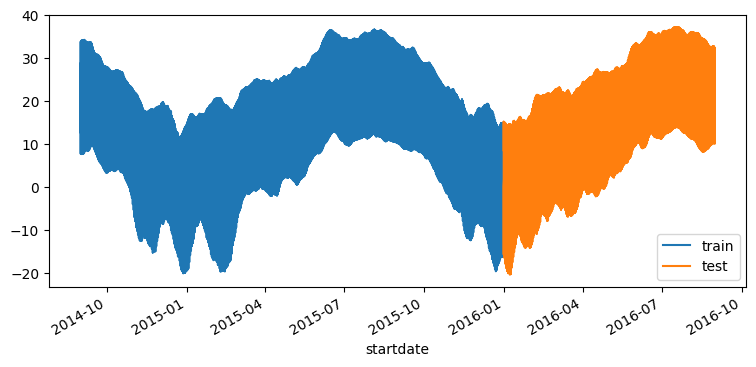

In [61]:
steps = int(data.shape[0] / 3)
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train[target[0]].plot(ax=ax, label='train')
data_test[target[0]].plot(ax=ax, label='test')
ax.legend();


In [63]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train[target[0]])
forecaster

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/skforecast/utils/utils.py:523: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/skforecast/utils/utils.py:523: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 250489] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-31 22:00:52 
Last fit date: 2023-01-31 22:04:46 
Skforecast version: 0.6.0 
Python version: 3.7.15 

In [64]:
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/skforecast/utils/utils.py:580: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


6    -0.750844
7     1.558693
8    -0.711937
9     0.270492
10    1.417319
Name: pred, dtype: float64

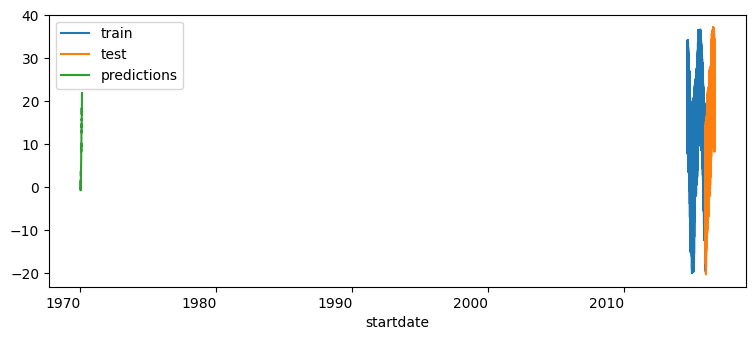

In [65]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train[target[0]].plot(ax=ax, label='train')
data_test[target[0]].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();


In [ ]:
error_mse = mean_squared_error(
                y_true = data_test[target[0]],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

In [29]:
preds = []
for cat_model in tqdm(cat_models):
    preds.append(cat_model.predict(test_df[selected_cols]))
s = 0
for pred in preds:
    s += pred
s = s/5
df = pd.read_csv('best_sub.csv')
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_corr_important.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.70it/s]

cos_sim with best submission: 0.9998636723641293
